In [10]:
import cv2 as cv
import numpy as np
import neat
import os
import gym
import gym_snake
import pickle

from tqdm import tqdm
from matplotlib import pyplot as plt

from helpers.feature_extraction import feature_vector

# Construct Environment
env = gym.make('snake-v0')
env.grid_size = 15, 15
observation = env.reset()  # Constructs an instance of the game

In [11]:
def show_moves(moves):
    for move in moves:
        plt.imshow(move)
        sleep(5)

In [12]:
def eval_genomes(individuals, config):
    """
    runs the game for each of the individuals
    :param config: config file from neat module
    :param individuals: list of individuals from one population
    :return: None
    """    
    def calculate_fitness(reward, steps):
        if reward == 1:
            return 4 * (steps ** .5)
        elif not reward:
            return -0.25
        else:
            return -100

    global env 
    nets, genomes = [], []
    
    for genome_id, genome in individuals:
        genome.fitness = 0  # Start with fitness level of 0
        net = neat.nn.FeedForwardNetwork.create(genome, config)
        nets.append(net)
        genomes.append(genome)

    all_eaten_apples = 0
    max_eaten_apples = 0
    
    x = 0
    for net in tqdm(nets):  # Cycle for each individual
        save = []
        observation = env.reset()  # Constructs an instance of the game
        game_controller = env.controller  # Controller
        grid_object = game_controller.grid  # Grid

        snakes_array = game_controller.snakes
        snake_object = snakes_array[0]
        
        fitness, eaten_apples, steps = 0, 0, 0
        
        features = feature_vector(snake_object, grid_object.grid, 
                                  env.grid_size, grid_object.FOOD_COLOR)
        output = nets[x].activate(features)  # Get output from neural network
        action = np.argmax(output).item()
        
        observation, reward, done, info = env.step(action)
        steps += 1
        if reward:
            eaten_apples += 1
        genomes[x].fitness += calculate_fitness(reward, steps)
        
        
        while not done:  #  Game cycle
            features = feature_vector(snake_object, observation, 
                                      env.grid_size, grid_object.FOOD_COLOR)  # Extract features
            output = nets[x].activate(features)
            action = np.argmax(output).item()

            observation, reward, done, info = env.step(action)  #  Make a move
            steps += 1
            if reward:
                eaten_apples += 1
            genomes[x].fitness += calculate_fitness(reward, steps)
                
            if steps > 100:
                break
                    
        all_eaten_apples += eaten_apples
        max_eaten_apples = max(max_eaten_apples, eaten_apples)
        x += 1
    
    
    print("Maximum apples eaten: ", max_eaten_apples)
    print("Apples eaten on average: ", all_eaten_apples / len(individuals))


In [13]:
def run(config_file, num_generations):
    """
    runs the NEAT algorithm to train a neural network to play game.
    :param config_file: location of config file
    :return: None
    """
    config = neat.config.Config(neat.DefaultGenome, neat.DefaultReproduction,
                         neat.DefaultSpeciesSet, neat.DefaultStagnation,
                         config_file)

    # Create the population, which is the top-level object for a NEAT run.
    population = neat.Population(config)

    # Add a stdout reporter to show progress in the terminal.
    population.add_reporter(neat.StdOutReporter(True))
    stats = neat.StatisticsReporter()
    population.add_reporter(stats)
    
    # Add a checkpointer to save progress
    checkpointer = neat.Checkpointer()
    population.add_reporter(checkpointer)

    steps = 0
    
    # Run for maximun of num_populations
    winner = neat.nn.FeedForwardNetwork.create(
        population.run(eval_genomes, num_generations), config)
    
    observation = env.reset()  # Constructs an instance of the game
    game_controller = env.controller  # Controller
    grid_object = game_controller.grid  # Grid

    snakes_array = game_controller.snakes
    snake_object = snakes_array[0]

    fitness, eaten_apples, steps = 0, 0, 0

    features = feature_vector(snake_object, grid_object.grid, env.grid_size, grid_object.FOOD_COLOR)
    output = winner.activate(features)  # Get output from neural network
    action = np.argmax(output).item()

    observation, reward, done, info = env.step(action)
    steps += 1
    
    %matplotlib notebook
    env.render()

    while not done:  # Game cycle
        features = feature_vector(snake_object, observation, 
                                  env.grid_size, grid_object.FOOD_COLOR)  # Extract features
        output = winner.activate(features)
        action = np.argmax(output).item()

        observation, reward, done, info = env.step(action)  #  Make a move
        steps += 1

        %matplotlib notebook
        env.render()
        
        if steps > 100:
            break
            
    # Show final stats
    print("Steps: ", steps)
    print('\nBest genome:\n{!s}'.format(winner))




 ****** Running generation 0 ****** 



100%|█████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 357.97it/s]


Maximum apples eaten:  2
Apples eaten on average:  1.08
Population's average fitness: -101.82931 stdev: 2.48903
Best fitness: -89.27944 - size: (8, 60) - species 36 - id 36
Average adjusted fitness: 0.147
Mean genetic distance 3.142, standard deviation 0.421
Population of 150 members in 50 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
     1    0     3   -102.8    0.085     0
     2    0     3   -102.8    0.085     0
     3    0     3   -102.0    0.136     0
     4    0     3   -101.8    0.153     0
     5    0     3   -103.2    0.051     0
     6    0     3   -102.8    0.085     0
     7    0     3   -102.0    0.136     0
     8    0     3   -102.8    0.085     0
     9    0     3   -104.0    0.000     0
    10    0     3   -102.8    0.085     0
    11    0     3   -102.0    0.136     0
    12    0     3   -102.8    0.085     0
    13    0     3   -102.0    0.136     0
    14    0     3   -102.8    0.085     0
    15    0     3   -102.0  

100%|███████████████████████████████████████████████████████████████████████████████| 150/150 [00:00<00:00, 348.49it/s]


Maximum apples eaten:  2
Apples eaten on average:  1.0266666666666666
Population's average fitness: -102.29764 stdev: 1.83308
Best fitness: -91.18629 - size: (8, 46) - species 42 - id 138
Average adjusted fitness: 0.297
Mean genetic distance 3.142, standard deviation 0.421
Population of 150 members in 50 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
     1    1     3   -102.8    0.269     1
     2    1     3   -102.0    0.285     0
     3    1     3   -102.0    0.269     1
     4    1     3   -102.0    0.295     1
     5    1     3   -102.0    0.300     0
     6    1     3   -101.8    0.290     0
     7    1     3   -102.0    0.300     1
     8    1     3   -102.8    0.269     1
     9    1     3   -102.0    0.300     0
    10    1     3   -102.5    0.274     0
    11    1     3   -102.0    0.316     1
    12    1     3   -102.8    0.269     1
    13    1     3   -102.0    0.316     1
    14    1     3   -102.0    0.285     0
    15    1  

100%|███████████████████████████████████████████████████████████████████████████████| 150/150 [00:00<00:00, 325.06it/s]


Maximum apples eaten:  2
Apples eaten on average:  1.02
Population's average fitness: -102.39539 stdev: 1.78106
Best fitness: -90.93629 - size: (8, 58) - species 50 - id 59
Average adjusted fitness: 0.275
Mean genetic distance 3.142, standard deviation 0.421
Population of 150 members in 50 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
     1    2     3   -102.8    0.253     2
     2    2     3   -102.0    0.269     1
     3    2     3   -102.0    0.253     2
     4    2     3   -102.2    0.242     2
     5    2     3   -102.0    0.258     1
     6    2     3   -102.8    0.253     1
     7    2     3   -102.0    0.195     2
     8    2     3   -102.8    0.253     2
     9    2     3   -102.0    0.300     1
    10    2     3   -102.0    0.269     0
    11    2     3   -102.0    0.300     2
    12    2     3   -102.8    0.253     2
    13    2     3   -102.0    0.300     2
    14    2     3   -102.0    0.269     1
    15    2     3   -102.0  

100%|███████████████████████████████████████████████████████████████████████████████| 150/150 [00:00<00:00, 296.31it/s]


Maximum apples eaten:  2
Apples eaten on average:  1.02
Population's average fitness: -102.43085 stdev: 1.37560
Best fitness: -92.80573 - size: (8, 60) - species 39 - id 133
Average adjusted fitness: 0.256
Mean genetic distance 3.142, standard deviation 0.421
Population of 150 members in 50 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
     1    3     3   -102.8    0.232     3
     2    3     3   -102.0    0.251     2
     3    3     3    -94.8    0.475     0
     4    3     3   -102.0    0.264     3
     5    3     3   -102.0    0.238     2
     6    3     3   -102.8    0.232     2
     7    3     3   -101.8    0.296     0
     8    3     3   -102.8    0.232     3
     9    3     3   -102.0    0.251     2
    10    3     3   -102.8    0.232     1
    11    3     3   -102.0    0.290     3
    12    3     3   -102.8    0.232     3
    13    3     3   -102.0    0.290     3
    14    3     3   -102.0    0.251     2
    15    3     3   -102.0 

100%|███████████████████████████████████████████████████████████████████████████████| 150/150 [00:00<00:00, 317.95it/s]


Maximum apples eaten:  2
Apples eaten on average:  1.06
Population's average fitness: -102.15386 stdev: 1.98809
Best fitness: -91.10089 - size: (8, 59) - species 27 - id 80
Average adjusted fitness: 0.205
Mean genetic distance 3.142, standard deviation 0.421
Population of 150 members in 50 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
     1    4     3    -91.9    0.422     0
     2    4     3   -102.0    0.180     3
     3    4     3    -97.8    0.318     1
     4    4     3   -102.0    0.150     4
     5    4     3   -102.0    0.198     3
     6    4     3   -102.8    0.162     3
     7    4     3   -102.0    0.168     1
     8    4     3   -102.8    0.162     4
     9    4     3   -102.0    0.198     3
    10    4     3   -102.0    0.180     2
    11    4     3   -102.0    0.216     4
    12    4     3   -102.8    0.162     4
    13    4     3   -102.0    0.156     4
    14    4     3   -102.0    0.180     3
    15    4     3   -102.0  

100%|███████████████████████████████████████████████████████████████████████████████| 150/150 [00:00<00:00, 371.74it/s]


Maximum apples eaten:  2
Apples eaten on average:  1.0466666666666666
Population's average fitness: -102.16617 stdev: 2.00435
Best fitness: -90.50807 - size: (9, 60) - species 45 - id 97

Species 8 with 3 members is stagnated: removing it

Species 12 with 3 members is stagnated: removing it

Species 30 with 3 members is stagnated: removing it

Species 32 with 3 members is stagnated: removing it

Species 34 with 3 members is stagnated: removing it

Species 48 with 3 members is stagnated: removing it

Species 24 with 3 members is stagnated: removing it

Species 49 with 3 members is stagnated: removing it

Species 4 with 3 members is stagnated: removing it

Species 13 with 3 members is stagnated: removing it

Species 15 with 3 members is stagnated: removing it

Species 18 with 3 members is stagnated: removing it

Species 23 with 3 members is stagnated: removing it

Species 38 with 3 members is stagnated: removing it

Species 31 with 3 members is stagnated: removing it

Species 36 with 3 m

100%|███████████████████████████████████████████████████████████████████████████████| 102/102 [00:00<00:00, 335.32it/s]


Maximum apples eaten:  3
Apples eaten on average:  1.0196078431372548
Population's average fitness: -102.37127 stdev: 2.20798
Best fitness: -81.11904 - size: (8, 58) - species 46 - id 100

Species 6 with 3 members is stagnated: removing it

Species 9 with 3 members is stagnated: removing it

Species 5 with 3 members is stagnated: removing it

Species 2 with 3 members is stagnated: removing it

Species 14 with 3 members is stagnated: removing it

Species 35 with 3 members is stagnated: removing it

Species 43 with 3 members is stagnated: removing it

Species 40 with 3 members is stagnated: removing it

Species 28 with 3 members is stagnated: removing it

Species 42 with 3 members is stagnated: removing it
Average adjusted fitness: 0.084
Mean genetic distance 3.082, standard deviation 0.578
Population of 73 members in 24 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
     1    6     3   -102.8    0.065     2
     3    6     3   -102.0    0.09

100%|█████████████████████████████████████████████████████████████████████████████████| 73/73 [00:00<00:00, 328.13it/s]


Maximum apples eaten:  3
Apples eaten on average:  1.0684931506849316
Population's average fitness: -101.97479 stdev: 2.91114
Best fitness: -85.60089 - size: (9, 61) - species 22 - id 58

Species 50 with 3 members is stagnated: removing it

Species 10 with 3 members is stagnated: removing it

Species 20 with 3 members is stagnated: removing it

Species 17 with 3 members is stagnated: removing it

Species 47 with 3 members is stagnated: removing it

Species 41 with 3 members is stagnated: removing it
Average adjusted fitness: 0.149
Mean genetic distance 3.040, standard deviation 0.647
Population of 56 members in 18 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
     1    7     3   -102.8    0.104     3
     3    7     3   -102.0    0.109     4
     7    7     3   -102.0    0.061     4
    11    7     3   -102.0    0.144     2
    16    7     3   -102.0    0.131     3
    19    7     3   -102.0    0.122     3
    21    7     4    -91.2    0.3

100%|█████████████████████████████████████████████████████████████████████████████████| 56/56 [00:00<00:00, 311.03it/s]


Maximum apples eaten:  3
Apples eaten on average:  1.125
Population's average fitness: -101.32027 stdev: 4.20156
Best fitness: -78.66699 - size: (9, 60) - species 45 - id 97

Species 39 with 3 members is stagnated: removing it

Species 7 with 3 members is stagnated: removing it

Species 3 with 3 members is stagnated: removing it
Average adjusted fitness: 0.130
Mean genetic distance 2.995, standard deviation 0.691
Population of 52 members in 15 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
     1    8     3   -102.8    0.068     4
    11    8     5    -91.2    0.237     0
    16    8     3   -102.0    0.097     4
    19    8     3   -102.0    0.077     4
    21    8     3    -97.8    0.116     1
    22    8     3   -102.8    0.053     1
    25    8     3   -102.0    0.055     4
    26    8     3   -102.0    0.087     4
    27    8     4    -89.9    0.228     0
    29    8     3   -102.0    0.097     3
    33    8     4    -90.5    0.226    

100%|█████████████████████████████████████████████████████████████████████████████████| 52/52 [00:00<00:00, 327.85it/s]


Maximum apples eaten:  1
Apples eaten on average:  1.0
Population's average fitness: -102.48558 stdev: 0.50339
Best fitness: -102.00000 - size: (7, 44) - species 19 - id 61

Species 1 with 3 members is stagnated: removing it

Species 19 with 3 members is stagnated: removing it

Species 16 with 3 members is stagnated: removing it

Species 25 with 3 members is stagnated: removing it

Species 26 with 3 members is stagnated: removing it
Average adjusted fitness: 0.804
Mean genetic distance 2.908, standard deviation 0.797
Population of 47 members in 10 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
    11    9     6   -102.0    1.000     1
    21    9     5   -102.0    1.000     2
    22    9     4   -102.8    0.667     2
    27    9     5   -102.0    0.675     1
    29    9     5   -102.0    1.000     4
    33    9     5   -102.8    0.700     1
    37    9     4   -102.8    0.700     2
    44    9     4   -102.8    0.700     4
    45    9     5

100%|█████████████████████████████████████████████████████████████████████████████████| 47/47 [00:00<00:00, 399.15it/s]


Maximum apples eaten:  2
Apples eaten on average:  1.0638297872340425
Population's average fitness: -102.12053 stdev: 1.53958
Best fitness: -95.57180 - size: (8, 60) - species 33 - id 33

Species 44 with 4 members is stagnated: removing it

Species 29 with 5 members is stagnated: removing it
Average adjusted fitness: 0.263
Mean genetic distance 2.850, standard deviation 0.826
Population of 52 members in 8 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
    11   10     8    -96.1    0.376     2
    21   10     7   -102.0    0.263     3
    22   10     6    -98.5    0.287     3
    27   10     7   -102.0    0.263     2
    33   10     8    -95.6    0.374     2
    37   10     6   -102.8    0.182     3
    45   10     7   -102.0    0.213     2
    46   10     3   -102.0    0.147     4
Total extinctions: 0
Generation time: 0.186 sec (0.554 average)

 ****** Running generation 11 ****** 



100%|█████████████████████████████████████████████████████████████████████████████████| 52/52 [00:00<00:00, 473.73it/s]


Maximum apples eaten:  2
Apples eaten on average:  1.0384615384615385
Population's average fitness: -102.14230 stdev: 2.08911
Best fitness: -89.82779 - size: (9, 60) - species 45 - id 191

Species 46 with 3 members is stagnated: removing it
Average adjusted fitness: 0.150
Mean genetic distance 2.815, standard deviation 0.890
Population of 50 members in 7 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
    11   11     7   -102.0    0.134     3
    21   11     8   -102.0    0.151     4
    22   11     5   -102.8    0.104     4
    27   11     6   -102.0    0.144     3
    33   11     7   -102.0    0.106     3
    37   11     8    -94.8    0.199     4
    45   11     9    -89.8    0.210     3
Total extinctions: 0
Generation time: 0.166 sec (0.493 average)

 ****** Running generation 12 ****** 



100%|█████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 301.95it/s]


Maximum apples eaten:  2
Apples eaten on average:  1.02
Population's average fitness: -100.62723 stdev: 10.94748
Best fitness: -25.25000 - size: (9, 61) - species 22 - id 206

Species 21 with 8 members is stagnated: removing it

Species 37 with 8 members is stagnated: removing it
Average adjusted fitness: 0.075
Mean genetic distance 2.698, standard deviation 0.981
Population of 51 members in 5 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
    11   12     8   -102.0    0.044     4
    22   12    21    -25.2    0.224     0
    27   12     6   -102.0    0.042     4
    33   12     8   -102.0    0.040     4
    45   12     8   -101.8    0.028     4
Total extinctions: 0
Generation time: 0.243 sec (0.433 average)

 ****** Running generation 13 ****** 



100%|█████████████████████████████████████████████████████████████████████████████████| 51/51 [00:00<00:00, 317.56it/s]


Maximum apples eaten:  2
Apples eaten on average:  1.0784313725490196
Population's average fitness: -102.03139 stdev: 1.67900
Best fitness: -94.35089 - size: (9, 59) - species 45 - id 231

Species 27 with 6 members is stagnated: removing it

Species 11 with 8 members is stagnated: removing it

Species 33 with 8 members is stagnated: removing it

Species 45 with 8 members is stagnated: removing it
Average adjusted fitness: 0.271
Mean genetic distance 0.939, standard deviation 0.225
Population of 50 members in 1 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
    22   13    50    -98.5    0.271     1
Total extinctions: 0
Generation time: 0.259 sec (0.373 average)

 ****** Running generation 14 ****** 



100%|█████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 329.90it/s]


Maximum apples eaten:  2
Apples eaten on average:  1.04
Population's average fitness: -102.35686 stdev: 1.63377
Best fitness: -94.50000 - size: (8, 47) - species 22 - id 268
Average adjusted fitness: 0.269
Mean genetic distance 1.147, standard deviation 0.271
Population of 50 members in 1 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
    22   14    50    -94.5    0.269     2
Total extinctions: 0
Generation time: 0.235 sec (0.313 average)

 ****** Running generation 15 ****** 



100%|█████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 363.10it/s]


Maximum apples eaten:  2
Apples eaten on average:  1.1
Population's average fitness: -101.43476 stdev: 3.19529
Best fitness: -90.50000 - size: (9, 59) - species 22 - id 321
Average adjusted fitness: 0.219
Mean genetic distance 1.217, standard deviation 0.274
Population of 50 members in 1 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
    22   15    50    -90.5    0.219     3
Total extinctions: 0
Generation time: 0.207 sec (0.265 average)

 ****** Running generation 16 ****** 



100%|█████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 393.07it/s]


Maximum apples eaten:  1
Apples eaten on average:  1.0
Population's average fitness: -102.55500 stdev: 0.68791
Best fitness: -102.00000 - size: (10, 63) - species 22 - id 346
Average adjusted fitness: 0.852
Mean genetic distance 1.207, standard deviation 0.305
Population of 50 members in 1 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
    22   16    50   -102.0    0.852     4
Total extinctions: 0
Generation time: 0.234 sec (0.242 average)

 ****** Running generation 17 ****** 



100%|█████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 435.95it/s]


Maximum apples eaten:  2
Apples eaten on average:  1.04
Population's average fitness: -102.27590 stdev: 1.76576
Best fitness: -92.70204 - size: (8, 44) - species 22 - id 424

Species 22 with 50 members is stagnated: removing it
All species extinct.
Mean genetic distance 3.280, standard deviation 0.102
Population of 50 members in 50 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
    51    0     1       --       --     0
    52    0     1       --       --     0
    53    0     1       --       --     0
    54    0     1       --       --     0
    55    0     1       --       --     0
    56    0     1       --       --     0
    57    0     1       --       --     0
    58    0     1       --       --     0
    59    0     1       --       --     0
    60    0     1       --       --     0
    61    0     1       --       --     0
    62    0     1       --       --     0
    63    0     1       --       --     0
    64    0     1       -- 

100%|█████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 254.45it/s]


Maximum apples eaten:  2
Apples eaten on average:  1.04
Population's average fitness: -102.43334 stdev: 1.72051
Best fitness: -93.16699 - size: (8, 60) - species 70 - id 478
Average adjusted fitness: 0.264
Mean genetic distance 3.149, standard deviation 0.430
Population of 150 members in 50 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
    51    1     3   -102.8    0.238     0
    52    1     3   -102.8    0.238     0
    53    1     3   -102.8    0.238     0
    54    1     3   -102.8    0.238     0
    55    1     3   -103.0    0.219     0
    56    1     3   -102.2    0.278     0
    57    1     3   -102.5    0.258     0
    58    1     3   -102.8    0.238     0
    59    1     3   -102.0    0.298     0
    60    1     3   -102.8    0.238     0
    61    1     3   -102.0    0.298     0
    62    1     3   -103.8    0.159     0
    63    1     3   -102.8    0.238     0
    64    1     3   -102.0    0.298     0
    65    1     3   -102.0 

100%|███████████████████████████████████████████████████████████████████████████████| 150/150 [00:00<00:00, 357.97it/s]


Maximum apples eaten:  2
Apples eaten on average:  1.0466666666666666
Population's average fitness: -102.23870 stdev: 2.13330
Best fitness: -90.50000 - size: (9, 61) - species 63 - id 537
Average adjusted fitness: 0.266
Mean genetic distance 3.149, standard deviation 0.430
Population of 150 members in 50 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
    51    2     3   -102.8    0.234     1
    52    2     3   -102.0    0.250     0
    53    2     3   -102.0    0.250     0
    54    2     3   -102.8    0.234     1
    55    2     3   -102.8    0.229     0
    56    2     3   -102.0    0.260     0
    57    2     3   -102.8    0.203     1
    58    2     3   -102.0    0.266     0
    59    2     3   -102.0    0.250     1
    60    2     3   -102.0    0.250     0
    61    2     3   -102.0    0.245     1
    62    2     3   -102.8    0.214     0
    63    2     3    -90.5    0.490     0
    64    2     3   -102.0    0.281     1
    65    2  

100%|███████████████████████████████████████████████████████████████████████████████| 150/150 [00:00<00:00, 342.58it/s]


Maximum apples eaten:  3
Apples eaten on average:  1.0466666666666666
Population's average fitness: -102.29186 stdev: 2.10952
Best fitness: -88.55573 - size: (8, 46) - species 66 - id 574
Average adjusted fitness: 0.224
Mean genetic distance 3.149, standard deviation 0.430
Population of 150 members in 50 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
    51    3     3   -102.8    0.193     2
    52    3     3   -102.0    0.179     1
    53    3     3   -102.0    0.217     1
    54    3     3    -91.2    0.416     0
    55    3     3   -102.8    0.198     1
    56    3     3   -102.0    0.226     1
    57    3     3   -102.8    0.170     2
    58    3     3   -102.0    0.226     1
    59    3     3   -102.0    0.212     2
    60    3     3   -102.2    0.207     1
    61    3     3   -102.0    0.212     2
    62    3     3   -102.8    0.155     1
    63    3     3   -102.8    0.198     1
    64    3     3   -102.0    0.240     2
    65    3  

100%|███████████████████████████████████████████████████████████████████████████████| 150/150 [00:00<00:00, 401.74it/s]


Maximum apples eaten:  2
Apples eaten on average:  1.06
Population's average fitness: -102.04417 stdev: 2.58291
Best fitness: -89.85089 - size: (8, 59) - species 82 - id 511
Average adjusted fitness: 0.278
Mean genetic distance 3.149, standard deviation 0.430
Population of 150 members in 50 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
    51    4     3   -102.8    0.212     3
    52    4     3   -102.0    0.251     2
    53    4     3   -102.0    0.266     2
    54    4     3   -102.8    0.232     1
    55    4     3   -102.8    0.237     2
    56    4     3   -102.0    0.247     2
    57    4     3   -102.8    0.207     3
    58    4     3   -102.8    0.222     2
    59    4     3   -102.0    0.281     3
    60    4     3   -102.8    0.237     2
    61    4     3    -92.8    0.428     0
    62    4     3   -102.8    0.187     2
    63    4     3    -90.5    0.620     2
    64    4     3   -102.0    0.281     3
    65    4     3   -102.0 

100%|███████████████████████████████████████████████████████████████████████████████| 150/150 [00:00<00:00, 408.74it/s]


Maximum apples eaten:  2
Apples eaten on average:  1.0466666666666666
Population's average fitness: -102.11126 stdev: 2.12689
Best fitness: -89.85089 - size: (8, 58) - species 96 - id 602
Average adjusted fitness: 0.191
Mean genetic distance 3.149, standard deviation 0.430
Population of 150 members in 50 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
    51    5     3   -102.8    0.143     4
    52    5     3   -102.0    0.182     3
    53    5     3   -102.0    0.165     3
    54    5     3   -102.8    0.149     2
    55    5     3    -96.8    0.273     0
    56    5     3   -102.0    0.160     3
    57    5     3   -102.2    0.160     0
    58    5     3   -102.0    0.165     3
    59    5     3   -102.0    0.198     4
    60    5     3   -102.0    0.165     3
    61    5     3   -102.0    0.165     1
    62    5     3   -102.8    0.132     3
    63    5     3   -102.8    0.149     3
    64    5     3   -102.0    0.198     4
    65    5  

100%|███████████████████████████████████████████████████████████████████████████████| 150/150 [00:00<00:00, 426.05it/s]


Maximum apples eaten:  2
Apples eaten on average:  1.0133333333333334
Population's average fitness: -102.46849 stdev: 1.20305
Best fitness: -92.70204 - size: (8, 59) - species 82 - id 511

Species 51 with 3 members is stagnated: removing it

Species 68 with 3 members is stagnated: removing it

Species 69 with 3 members is stagnated: removing it

Species 59 with 3 members is stagnated: removing it

Species 64 with 3 members is stagnated: removing it

Species 65 with 3 members is stagnated: removing it

Species 72 with 3 members is stagnated: removing it

Species 74 with 3 members is stagnated: removing it

Species 79 with 3 members is stagnated: removing it

Species 81 with 3 members is stagnated: removing it

Species 91 with 3 members is stagnated: removing it

Species 93 with 3 members is stagnated: removing it

Species 95 with 3 members is stagnated: removing it
Average adjusted fitness: 0.169
Mean genetic distance 3.138, standard deviation 0.488
Population of 111 members in 37 speci

100%|███████████████████████████████████████████████████████████████████████████████| 111/111 [00:00<00:00, 376.00it/s]


Maximum apples eaten:  3
Apples eaten on average:  1.0990990990990992
Population's average fitness: -101.74783 stdev: 3.49347
Best fitness: -76.94436 - size: (7, 44) - species 89 - id 593

Species 62 with 3 members is stagnated: removing it

Species 63 with 3 members is stagnated: removing it

Species 56 with 3 members is stagnated: removing it

Species 60 with 3 members is stagnated: removing it

Species 58 with 3 members is stagnated: removing it

Species 97 with 3 members is stagnated: removing it

Species 53 with 3 members is stagnated: removing it

Species 75 with 3 members is stagnated: removing it

Species 78 with 3 members is stagnated: removing it

Species 99 with 3 members is stagnated: removing it
Average adjusted fitness: 0.129
Mean genetic distance 3.113, standard deviation 0.561
Population of 81 members in 27 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
    52    7     3    -93.8    0.193     0
    54    7     3   -102.8    

100%|█████████████████████████████████████████████████████████████████████████████████| 81/81 [00:00<00:00, 359.31it/s]


Maximum apples eaten:  2
Apples eaten on average:  1.0617283950617284
Population's average fitness: -102.10201 stdev: 2.36318
Best fitness: -90.25000 - size: (8, 60) - species 57 - id 465

Species 84 with 3 members is stagnated: removing it

Species 54 with 3 members is stagnated: removing it

Species 70 with 3 members is stagnated: removing it

Species 94 with 3 members is stagnated: removing it

Species 87 with 3 members is stagnated: removing it

Species 66 with 3 members is stagnated: removing it
Average adjusted fitness: 0.179
Mean genetic distance 3.073, standard deviation 0.624
Population of 63 members in 21 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
    52    8     3   -102.0    0.140     1
    55    8     3    -92.7    0.352     0
    57    8     3    -90.2    0.415     0
    61    8     3   -102.0    0.129     4
    67    8     3   -102.0    0.170     1
    71    8     3   -102.0    0.140     3
    73    8     3   -102.8    0.

100%|█████████████████████████████████████████████████████████████████████████████████| 63/63 [00:00<00:00, 356.89it/s]


Maximum apples eaten:  2
Apples eaten on average:  1.0317460317460319
Population's average fitness: -102.47708 stdev: 1.71057
Best fitness: -93.55573 - size: (8, 60) - species 76 - id 548

Species 88 with 3 members is stagnated: removing it

Species 77 with 3 members is stagnated: removing it

Species 86 with 3 members is stagnated: removing it

Species 85 with 3 members is stagnated: removing it

Species 80 with 3 members is stagnated: removing it

Species 61 with 3 members is stagnated: removing it

Species 82 with 3 members is stagnated: removing it
Average adjusted fitness: 0.215
Mean genetic distance 3.014, standard deviation 0.726
Population of 54 members in 14 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
    52    9     3   -102.0    0.153     2
    55    9     4   -102.8    0.197     1
    57    9     4   -102.5    0.204     1
    67    9     4   -102.0    0.197     2
    71    9     4   -102.8    0.197     4
    73    9     4   -

100%|█████████████████████████████████████████████████████████████████████████████████| 54/54 [00:00<00:00, 365.75it/s]


Maximum apples eaten:  3
Apples eaten on average:  1.0555555555555556
Population's average fitness: -102.01933 stdev: 3.47132
Best fitness: -78.73834 - size: (8, 61) - species 71 - id 610

Species 90 with 3 members is stagnated: removing it

Species 96 with 4 members is stagnated: removing it

Species 92 with 4 members is stagnated: removing it
Average adjusted fitness: 0.075
Mean genetic distance 2.940, standard deviation 0.786
Population of 48 members in 11 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
    52   10     4   -102.0    0.050     3
    55   10     3   -102.8    0.040     2
    57   10     3   -102.5    0.042     2
    67   10     3   -102.0    0.062     3
    71   10    12    -78.7    0.295     0
    73   10     3   -102.8    0.040     3
    76   10     4   -102.0    0.052     1
    83   10     3   -102.8    0.027     4
    89   10     3   -102.0    0.052     3
    98   10     3   -102.0    0.047     3
   100   10     7    -9

100%|█████████████████████████████████████████████████████████████████████████████████| 48/48 [00:00<00:00, 338.93it/s]


Maximum apples eaten:  2
Apples eaten on average:  1.0208333333333333
Population's average fitness: -102.46742 stdev: 1.70024
Best fitness: -92.18629 - size: (8, 59) - species 100 - id 522

Species 83 with 3 members is stagnated: removing it
Average adjusted fitness: 0.258
Mean genetic distance 2.891, standard deviation 0.828
Population of 48 members in 10 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
    52   11     5   -102.0    0.262     4
    55   11     4   -102.8    0.229     3
    57   11     4   -102.8    0.235     3
    67   11     4   -101.8    0.296     4
    71   11     9   -102.0    0.228     1
    73   11     4   -102.0    0.271     4
    76   11     3   -102.0    0.199     2
    89   11     4   -102.0    0.271     4
    98   11     4   -102.0    0.253     4
   100   11     7    -92.2    0.334     4
Total extinctions: 1
Generation time: 0.212 sec (0.496 average)

 ****** Running generation 29 ****** 



100%|█████████████████████████████████████████████████████████████████████████████████| 48/48 [00:00<00:00, 414.78it/s]


Maximum apples eaten:  2
Apples eaten on average:  1.0416666666666667
Population's average fitness: -102.23858 stdev: 1.99103
Best fitness: -92.70204 - size: (8, 60) - species 98 - id 506

Species 73 with 4 members is stagnated: removing it

Species 52 with 5 members is stagnated: removing it

Species 89 with 4 members is stagnated: removing it

Species 100 with 7 members is stagnated: removing it

Species 67 with 4 members is stagnated: removing it
Average adjusted fitness: 0.262
Mean genetic distance 2.705, standard deviation 1.005
Population of 51 members in 5 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
    55   12     8   -102.8    0.192     4
    57   12     8   -102.8    0.201     4
    71   12    13   -102.0    0.236     2
    76   12     8   -102.8    0.230     3
    98   12    14    -92.7    0.451     0
Total extinctions: 1
Generation time: 0.186 sec (0.442 average)

 ****** Running generation 30 ****** 



100%|█████████████████████████████████████████████████████████████████████████████████| 51/51 [00:00<00:00, 409.08it/s]


Maximum apples eaten:  2
Apples eaten on average:  1.0196078431372548
Population's average fitness: -102.53269 stdev: 1.65441
Best fitness: -92.16699 - size: (8, 61) - species 71 - id 673

Species 57 with 8 members is stagnated: removing it

Species 55 with 8 members is stagnated: removing it
Average adjusted fitness: 0.255
Mean genetic distance 2.256, standard deviation 1.077
Population of 50 members in 3 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
    71   13    19    -92.2    0.317     3
    76   13    14   -102.8    0.233     4
    98   13    17   -102.0    0.214     1
Total extinctions: 1
Generation time: 0.184 sec (0.379 average)

 ****** Running generation 31 ****** 



100%|█████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 468.52it/s]


Maximum apples eaten:  2
Apples eaten on average:  1.04
Population's average fitness: -102.09798 stdev: 1.53865
Best fitness: -93.55573 - size: (8, 62) - species 76 - id 665

Species 76 with 14 members is stagnated: removing it
Average adjusted fitness: 0.853
Mean genetic distance 1.801, standard deviation 0.983
Population of 50 members in 2 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
    71   14    24   -102.0    0.816     4
    98   14    26   -102.0    0.890     2
Total extinctions: 1
Generation time: 0.160 sec (0.330 average)

 ****** Running generation 32 ****** 



100%|█████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 468.40it/s]


Maximum apples eaten:  2
Apples eaten on average:  1.02
Population's average fitness: -102.15404 stdev: 1.54703
Best fitness: -92.45204 - size: (8, 47) - species 71 - id 772

Species 71 with 24 members is stagnated: removing it
Average adjusted fitness: 0.663
Mean genetic distance 0.784, standard deviation 0.300
Population of 50 members in 1 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
    98   15    50   -102.0    0.663     3
Total extinctions: 1
Generation time: 0.157 sec (0.280 average)

 ****** Running generation 33 ****** 



100%|█████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 516.83it/s]


Maximum apples eaten:  2
Apples eaten on average:  1.02
Population's average fitness: -102.18500 stdev: 0.90666
Best fitness: -97.75000 - size: (7, 41) - species 98 - id 820
Average adjusted fitness: 0.409
Mean genetic distance 0.875, standard deviation 0.313
Population of 50 members in 1 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
    98   16    50    -97.8    0.409     4
Total extinctions: 1
Generation time: 0.141 sec (0.237 average)

 ****** Running generation 34 ****** 



100%|█████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 506.37it/s]


Maximum apples eaten:  1
Apples eaten on average:  1.0
Population's average fitness: -102.23500 stdev: 0.45114
Best fitness: -102.00000 - size: (7, 41) - species 98 - id 820

Species 98 with 50 members is stagnated: removing it
All species extinct.
Mean genetic distance 3.292, standard deviation 0.105
Population of 50 members in 50 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
   101    0     1       --       --     0
   102    0     1       --       --     0
   103    0     1       --       --     0
   104    0     1       --       --     0
   105    0     1       --       --     0
   106    0     1       --       --     0
   107    0     1       --       --     0
   108    0     1       --       --     0
   109    0     1       --       --     0
   110    0     1       --       --     0
   111    0     1       --       --     0
   112    0     1       --       --     0
   113    0     1       --       --     0
   114    0     1       -- 

100%|█████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 311.28it/s]


Maximum apples eaten:  2
Apples eaten on average:  1.1
Population's average fitness: -101.78036 stdev: 3.18671
Best fitness: -90.50000 - size: (8, 60) - species 146 - id 891
Average adjusted fitness: 0.284
Mean genetic distance 3.174, standard deviation 0.425
Population of 150 members in 50 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
   101    1     3   -102.8    0.222     0
   102    1     3   -102.0    0.270     0
   103    1     3   -102.0    0.270     0
   104    1     3    -92.8    0.854     0
   105    1     3   -102.0    0.270     0
   106    1     3   -102.8    0.222     0
   107    1     3   -102.8    0.222     0
   108    1     3   -102.0    0.270     0
   109    1     3   -102.0    0.270     0
   110    1     3   -102.8    0.222     0
   111    1     3    -96.1    0.645     0
   112    1     3   -102.0    0.270     0
   113    1     3   -106.0    0.016     0
   114    1     3   -102.8    0.222     0
   115    1     3   -102.8 

100%|███████████████████████████████████████████████████████████████████████████████| 150/150 [00:00<00:00, 381.70it/s]


Maximum apples eaten:  2
Apples eaten on average:  1.0466666666666666
Population's average fitness: -102.27786 stdev: 2.23676
Best fitness: -90.50000 - size: (8, 60) - species 124 - id 1016
Average adjusted fitness: 0.297
Mean genetic distance 3.174, standard deviation 0.425
Population of 150 members in 50 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
   101    2     3   -102.8    0.269     1
   102    2     3   -102.0    0.313     1
   103    2     3   -102.0    0.269     1
   104    2     3   -102.0    0.313     1
   105    2     3   -102.0    0.313     1
   106    2     3   -102.0    0.284     0
   107    2     3   -102.0    0.313     0
   108    2     3   -102.0    0.259     1
   109    2     3   -102.0    0.299     1
   110    2     3    -94.8    0.426     0
   111    2     3   -102.0    0.313     1
   112    2     3   -102.0    0.313     1
   113    2     3   -102.0    0.199     0
   114    2     3   -102.0    0.284     0
   115    2

100%|███████████████████████████████████████████████████████████████████████████████| 150/150 [00:00<00:00, 402.87it/s]


Maximum apples eaten:  2
Apples eaten on average:  1.0133333333333334
Population's average fitness: -102.69418 stdev: 1.51314
Best fitness: -93.30573 - size: (8, 60) - species 113 - id 908
Average adjusted fitness: 0.438
Mean genetic distance 3.174, standard deviation 0.425
Population of 150 members in 50 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
   101    3     3   -102.8    0.434     2
   102    3     3   -102.0    0.479     2
   103    3     3   -102.0    0.444     2
   104    3     3   -102.0    0.479     2
   105    3     3   -102.0    0.479     2
   106    3     3   -102.0    0.449     1
   107    3     3   -102.0    0.479     1
   108    3     3   -102.0    0.419     2
   109    3     3   -102.0    0.464     2
   110    3     3   -102.0    0.449     1
   111    3     3   -102.0    0.479     2
   112    3     3   -102.0    0.479     2
   113    3     3    -93.3    0.643     0
   114    3     3   -102.0    0.449     1
   115    3 

100%|███████████████████████████████████████████████████████████████████████████████| 150/150 [00:00<00:00, 404.22it/s]


Maximum apples eaten:  2
Apples eaten on average:  1.06
Population's average fitness: -102.14569 stdev: 2.34811
Best fitness: -87.98834 - size: (7, 45) - species 133 - id 963
Average adjusted fitness: 0.255
Mean genetic distance 3.174, standard deviation 0.425
Population of 150 members in 50 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
   101    4     3   -102.8    0.224     3
   102    4     3    -92.8    0.424     0
   103    4     3   -102.0    0.219     3
   104    4     3   -102.0    0.263     3
   105    4     3   -102.0    0.263     3
   106    4     3    -91.2    0.439     0
   107    4     3   -102.0    0.263     2
   108    4     3   -102.0    0.215     3
   109    4     3   -102.0    0.250     3
   110    4     3   -102.5    0.219     2
   111    4     3   -102.0    0.263     3
   112    4     3   -102.0    0.263     3
   113    4     3   -102.0    0.250     1
   114    4     3   -102.0    0.237     2
   115    4     3   -102.0

100%|███████████████████████████████████████████████████████████████████████████████| 150/150 [00:00<00:00, 430.92it/s]


Maximum apples eaten:  2
Apples eaten on average:  1.0466666666666666
Population's average fitness: -102.21886 stdev: 1.90893
Best fitness: -91.91699 - size: (8, 60) - species 119 - id 949
Average adjusted fitness: 0.294
Mean genetic distance 3.174, standard deviation 0.425
Population of 150 members in 50 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
   101    5     3   -102.8    0.257     4
   102    5     3   -102.0    0.309     1
   103    5     3    -93.8    0.627     0
   104    5     3   -102.0    0.309     4
   105    5     3   -102.0    0.309     4
   106    5     3   -102.0    0.189     1
   107    5     3   -102.0    0.309     3
   108    5     3   -102.0    0.291     4
   109    5     3   -102.0    0.309     4
   110    5     3    -92.7    0.464     0
   111    5     3   -102.0    0.309     4
   112    5     3   -102.0    0.309     4
   113    5     3   -102.0    0.309     2
   114    5     3   -102.0    0.274     3
   115    5 

100%|███████████████████████████████████████████████████████████████████████████████| 150/150 [00:00<00:00, 408.66it/s]


Maximum apples eaten:  2
Apples eaten on average:  1.04
Population's average fitness: -102.37067 stdev: 1.83928
Best fitness: -91.60089 - size: (9, 61) - species 136 - id 926

Species 101 with 3 members is stagnated: removing it

Species 120 with 3 members is stagnated: removing it

Species 121 with 3 members is stagnated: removing it

Species 126 with 3 members is stagnated: removing it

Species 130 with 3 members is stagnated: removing it

Species 148 with 3 members is stagnated: removing it

Species 127 with 3 members is stagnated: removing it

Species 129 with 3 members is stagnated: removing it

Species 108 with 3 members is stagnated: removing it

Species 109 with 3 members is stagnated: removing it

Species 112 with 3 members is stagnated: removing it

Species 116 with 3 members is stagnated: removing it

Species 131 with 3 members is stagnated: removing it

Species 141 with 3 members is stagnated: removing it

Species 142 with 3 members is stagnated: removing it

Species 111 wi

100%|█████████████████████████████████████████████████████████████████████████████████| 96/96 [00:00<00:00, 375.89it/s]


Maximum apples eaten:  2
Apples eaten on average:  1.0416666666666667
Population's average fitness: -102.29632 stdev: 1.95705
Best fitness: -91.18629 - size: (8, 60) - species 114 - id 909

Species 117 with 3 members is stagnated: removing it

Species 124 with 3 members is stagnated: removing it

Species 135 with 3 members is stagnated: removing it

Species 143 with 3 members is stagnated: removing it

Species 122 with 3 members is stagnated: removing it

Species 137 with 3 members is stagnated: removing it

Species 115 with 3 members is stagnated: removing it

Species 118 with 3 members is stagnated: removing it

Species 145 with 3 members is stagnated: removing it

Species 125 with 3 members is stagnated: removing it
Average adjusted fitness: 0.225
Mean genetic distance 3.090, standard deviation 0.607
Population of 66 members in 22 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
   102    7     3   -102.0    0.231     3
   103    7     3  

100%|█████████████████████████████████████████████████████████████████████████████████| 66/66 [00:00<00:00, 378.91it/s]


Maximum apples eaten:  2
Apples eaten on average:  1.0454545454545454
Population's average fitness: -102.31818 stdev: 1.72852
Best fitness: -94.50000 - size: (7, 44) - species 150 - id 978

Species 138 with 3 members is stagnated: removing it

Species 113 with 3 members is stagnated: removing it
Average adjusted fitness: 0.349
Mean genetic distance 3.076, standard deviation 0.633
Population of 60 members in 20 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
   102    8     3   -102.0    0.375     4
   103    8     3    -94.5    0.715     3
   105    8     3   -102.0    0.375     2
   106    8     3   -102.0    0.229     4
   107    8     3   -102.0    0.347     1
   110    8     3   -102.0    0.333     3
   114    8     3   -102.0    0.333     1
   119    8     3   -102.8    0.312     3
   123    8     3   -102.0    0.299     3
   128    8     3   -102.0    0.347     4
   132    8     3   -101.5    0.326     4
   133    8     3   -102.8    0

100%|█████████████████████████████████████████████████████████████████████████████████| 60/60 [00:00<00:00, 354.79it/s]


Maximum apples eaten:  1
Apples eaten on average:  1.0
Population's average fitness: -102.92083 stdev: 1.18804
Best fitness: -102.00000 - size: (7, 45) - species 149 - id 975

Species 132 with 3 members is stagnated: removing it

Species 144 with 3 members is stagnated: removing it

Species 140 with 3 members is stagnated: removing it

Species 133 with 3 members is stagnated: removing it

Species 128 with 3 members is stagnated: removing it

Species 102 with 3 members is stagnated: removing it

Species 106 with 3 members is stagnated: removing it
Average adjusted fitness: 0.758
Mean genetic distance 2.985, standard deviation 0.738
Population of 50 members in 13 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
   103    9     4   -102.8    0.762     4
   105    9     4   -102.0    0.952     3
   107    9     4   -102.0    1.000     2
   110    9     4   -102.8    0.690     4
   114    9     4   -102.0    0.857     2
   119    9     4   -102.8 

100%|█████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 382.70it/s]


Maximum apples eaten:  2
Apples eaten on average:  1.06
Population's average fitness: -102.19722 stdev: 2.59544
Best fitness: -91.16699 - size: (9, 60) - species 139 - id 1026

Species 119 with 4 members is stagnated: removing it

Species 147 with 3 members is stagnated: removing it

Species 110 with 4 members is stagnated: removing it

Species 149 with 4 members is stagnated: removing it

Species 123 with 4 members is stagnated: removing it
Average adjusted fitness: 0.278
Mean genetic distance 2.846, standard deviation 0.853
Population of 50 members in 8 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
   103   10     7    -91.6    0.361     0
   105   10     7    -96.1    0.369     0
   107   10     6   -102.0    0.270     3
   114   10     6   -102.0    0.232     3
   134   10     6   -102.0    0.240     4
   136   10     5   -102.8    0.146     4
   139   10     7    -91.2    0.389     0
   150   10     6   -102.8    0.219     2
Total ext

100%|█████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 443.53it/s]


Maximum apples eaten:  2
Apples eaten on average:  1.08
Population's average fitness: -101.52925 stdev: 3.05603
Best fitness: -89.85089 - size: (9, 61) - species 136 - id 926

Species 134 with 6 members is stagnated: removing it
Average adjusted fitness: 0.257
Mean genetic distance 2.796, standard deviation 0.859
Population of 49 members in 7 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
   103   11    10    -90.5    0.369     0
   105   11     6   -102.0    0.217     1
   107   11     7   -102.0    0.224     4
   114   11     5   -102.0    0.200     4
   136   11     7    -89.9    0.289     0
   139   11     9    -92.8    0.308     1
   150   11     5   -102.0    0.192     3
Total extinctions: 2
Generation time: 0.182 sec (0.450 average)

 ****** Running generation 46 ****** 



100%|█████████████████████████████████████████████████████████████████████████████████| 49/49 [00:00<00:00, 442.63it/s]


Maximum apples eaten:  2
Apples eaten on average:  1.0204081632653061
Population's average fitness: -102.18557 stdev: 1.01221
Best fitness: -96.09315 - size: (8, 60) - species 107 - id 902

Species 114 with 5 members is stagnated: removing it

Species 107 with 7 members is stagnated: removing it
Average adjusted fitness: 0.865
Mean genetic distance 2.701, standard deviation 0.981
Population of 49 members in 5 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
   103   12    10   -102.0    0.780     1
   105   12    10   -102.0    1.000     2
   136   12     9   -102.0    0.671     1
   139   12    11   -102.0    0.933     2
   150   12     9   -102.0    0.940     4
Total extinctions: 2
Generation time: 0.171 sec (0.395 average)

 ****** Running generation 47 ****** 



100%|█████████████████████████████████████████████████████████████████████████████████| 49/49 [00:00<00:00, 465.24it/s]


Maximum apples eaten:  2
Apples eaten on average:  1.0204081632653061
Population's average fitness: -102.08353 stdev: 0.87172
Best fitness: -97.09315 - size: (7, 44) - species 105 - id 1090

Species 150 with 9 members is stagnated: removing it
Average adjusted fitness: 0.364
Mean genetic distance 2.545, standard deviation 1.066
Population of 49 members in 4 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
   103   13    12   -102.0    0.370     2
   105   13    13    -97.1    0.432     3
   136   13    11   -102.0    0.285     2
   139   13    13   -102.0    0.371     3
Total extinctions: 2
Generation time: 0.161 sec (0.344 average)

 ****** Running generation 48 ****** 



100%|█████████████████████████████████████████████████████████████████████████████████| 49/49 [00:00<00:00, 450.75it/s]


Maximum apples eaten:  2
Apples eaten on average:  1.0408163265306123
Population's average fitness: -102.11561 stdev: 1.21658
Best fitness: -94.82180 - size: (6, 28) - species 105 - id 1153
Average adjusted fitness: 0.225
Mean genetic distance 2.563, standard deviation 1.113
Population of 49 members in 4 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
   103   14    13    -99.8    0.242     3
   105   14    14    -94.8    0.254     0
   136   14    10   -102.0    0.190     3
   139   14    12   -102.0    0.214     4
Total extinctions: 2
Generation time: 0.163 sec (0.294 average)

 ****** Running generation 49 ****** 



100%|█████████████████████████████████████████████████████████████████████████████████| 49/49 [00:00<00:00, 481.67it/s]


Maximum apples eaten:  2
Apples eaten on average:  1.0408163265306123
Population's average fitness: -101.95522 stdev: 1.52403
Best fitness: -92.80573 - size: (11, 62) - species 136 - id 1169

Species 139 with 12 members is stagnated: removing it
Average adjusted fitness: 0.182
Mean genetic distance 2.321, standard deviation 1.155
Population of 50 members in 3 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
   103   15    14   -102.0    0.139     4
   105   15    17   -102.0    0.174     1
   136   15    19    -92.8    0.232     4
Total extinctions: 2
Generation time: 0.180 sec (0.250 average)

 ****** Running generation 50 ****** 



100%|█████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 453.79it/s]


Maximum apples eaten:  2
Apples eaten on average:  1.02
Population's average fitness: -101.88000 stdev: 1.64867
Best fitness: -90.50000 - size: (8, 45) - species 103 - id 1196

Species 136 with 19 members is stagnated: removing it

Species 103 with 14 members is stagnated: removing it
Average adjusted fitness: 0.000
Mean genetic distance 0.926, standard deviation 0.404
Population of 50 members in 1 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
   105   16    50   -102.0    0.000     2
Total extinctions: 2
Generation time: 0.162 sec (0.211 average)

 ****** Running generation 51 ****** 



100%|█████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 531.83it/s]


Maximum apples eaten:  2
Apples eaten on average:  1.02
Population's average fitness: -101.93500 stdev: 1.21738
Best fitness: -93.75000 - size: (8, 59) - species 105 - id 1249
Average adjusted fitness: 0.201
Mean genetic distance 0.878, standard deviation 0.342
Population of 50 members in 1 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
   105   17    50    -93.8    0.201     0
Total extinctions: 2
Generation time: 0.142 sec (0.188 average)

 ****** Running generation 52 ****** 



100%|█████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 486.74it/s]


Maximum apples eaten:  1
Apples eaten on average:  1.0
Population's average fitness: -102.21500 stdev: 0.47437
Best fitness: -101.50000 - size: (8, 59) - species 105 - id 1322
Average adjusted fitness: 0.740
Mean genetic distance 0.904, standard deviation 0.231
Population of 50 members in 1 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
   105   18    50   -101.5    0.740     1
Total extinctions: 2
Generation time: 0.159 sec (0.178 average)

 ****** Running generation 53 ****** 



100%|█████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 451.52it/s]


Maximum apples eaten:  2
Apples eaten on average:  1.08
Population's average fitness: -101.60184 stdev: 2.91138
Best fitness: -91.16699 - size: (8, 58) - species 105 - id 1346
Average adjusted fitness: 0.341
Mean genetic distance 0.943, standard deviation 0.206
Population of 50 members in 1 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
   105   19    50    -91.2    0.341     0
Total extinctions: 2
Generation time: 0.162 sec (0.168 average)

 ****** Running generation 54 ****** 



100%|█████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 451.78it/s]


Maximum apples eaten:  2
Apples eaten on average:  1.06
Population's average fitness: -101.87707 stdev: 2.16477
Best fitness: -91.16699 - size: (8, 57) - species 105 - id 1417
Average adjusted fitness: 0.165
Mean genetic distance 1.132, standard deviation 0.200
Population of 50 members in 1 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
   105   20    50    -91.2    0.165     1
Total extinctions: 2
Generation time: 0.166 sec (0.164 average)

 ****** Running generation 55 ****** 



100%|█████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 464.20it/s]


Maximum apples eaten:  3
Apples eaten on average:  1.06
Population's average fitness: -101.74463 stdev: 3.11196
Best fitness: -81.13833 - size: (8, 55) - species 105 - id 1432
Average adjusted fitness: 0.127
Mean genetic distance 1.358, standard deviation 0.142
Population of 50 members in 1 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
   105   21    50    -81.1    0.127     0
Total extinctions: 2
Generation time: 0.165 sec (0.163 average)

 ****** Running generation 56 ****** 



100%|█████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 486.58it/s]


Maximum apples eaten:  2
Apples eaten on average:  1.06
Population's average fitness: -101.70787 stdev: 2.15850
Best fitness: -90.50000 - size: (9, 59) - species 105 - id 1513
Average adjusted fitness: 0.199
Mean genetic distance 1.379, standard deviation 0.175
Population of 50 members in 1 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
   105   22    50    -90.5    0.199     1
Total extinctions: 2
Generation time: 0.159 sec (0.162 average)

 ****** Running generation 57 ****** 



100%|█████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 219.89it/s]


Maximum apples eaten:  2
Apples eaten on average:  1.1
Population's average fitness: -101.38568 stdev: 2.88630
Best fitness: -89.85089 - size: (8, 55) - species 105 - id 1521
Average adjusted fitness: 0.155
Mean genetic distance 1.405, standard deviation 0.231
Population of 50 members in 1 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
   105   23    50    -89.9    0.155     2
Total extinctions: 2
Generation time: 0.323 sec (0.178 average)

 ****** Running generation 58 ****** 



100%|█████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 339.62it/s]


Maximum apples eaten:  2
Apples eaten on average:  1.04
Population's average fitness: -102.03978 stdev: 1.92983
Best fitness: -91.16699 - size: (8, 42) - species 105 - id 1586
Average adjusted fitness: 0.153
Mean genetic distance 1.682, standard deviation 0.268
Population of 50 members in 1 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
   105   24    50    -91.2    0.153     3
Total extinctions: 2
Generation time: 0.219 sec (0.183 average)

 ****** Running generation 59 ****** 



100%|█████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 372.61it/s]


Maximum apples eaten:  2
Apples eaten on average:  1.02
Population's average fitness: -102.12500 stdev: 1.29156
Best fitness: -93.75000 - size: (11, 62) - species 105 - id 1652
Average adjusted fitness: 0.202
Mean genetic distance 1.696, standard deviation 0.428
Population of 50 members in 1 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
   105   25    50    -93.8    0.202     4
Total extinctions: 2
Generation time: 0.206 sec (0.186 average)

 ****** Running generation 60 ****** 



100%|█████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 397.89it/s]


Maximum apples eaten:  2
Apples eaten on average:  1.06
Population's average fitness: -101.71048 stdev: 2.04652
Best fitness: -92.70204 - size: (8, 43) - species 105 - id 1684

Species 105 with 50 members is stagnated: removing it
All species extinct.
Mean genetic distance 3.290, standard deviation 0.107
Population of 50 members in 50 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
   151    0     1       --       --     0
   152    0     1       --       --     0
   153    0     1       --       --     0
   154    0     1       --       --     0
   155    0     1       --       --     0
   156    0     1       --       --     0
   157    0     1       --       --     0
   158    0     1       --       --     0
   159    0     1       --       --     0
   160    0     1       --       --     0
   161    0     1       --       --     0
   162    0     1       --       --     0
   163    0     1       --       --     0
   164    0     1       

100%|█████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 278.52it/s]


Maximum apples eaten:  2
Apples eaten on average:  1.04
Population's average fitness: -102.21298 stdev: 1.69549
Best fitness: -92.80573 - size: (8, 60) - species 163 - id 1715
Average adjusted fitness: 0.244
Mean genetic distance 3.175, standard deviation 0.433
Population of 150 members in 50 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
   151    1     3   -102.2    0.241     0
   152    1     3   -102.8    0.201     0
   153    1     3   -102.0    0.261     0
   154    1     3   -102.0    0.261     0
   155    1     3   -102.8    0.201     0
   156    1     3   -102.0    0.261     0
   157    1     3   -102.8    0.201     0
   158    1     3    -96.8    0.676     0
   159    1     3   -102.0    0.261     0
   160    1     3   -102.0    0.261     0
   161    1     3   -102.8    0.201     0
   162    1     3   -102.8    0.201     0
   163    1     3    -92.8    1.000     0
   164    1     3   -102.8    0.201     0
   165    1     3   -102.

100%|███████████████████████████████████████████████████████████████████████████████| 150/150 [00:00<00:00, 390.02it/s]


Maximum apples eaten:  2
Apples eaten on average:  1.0333333333333334
Population's average fitness: -102.19106 stdev: 1.71652
Best fitness: -89.07779 - size: (8, 61) - species 165 - id 1773
Average adjusted fitness: 0.213
Mean genetic distance 3.175, standard deviation 0.433
Population of 150 members in 50 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
   151    2     3   -102.0    0.220     0
   152    2     3   -102.8    0.180     1
   153    2     3   -102.0    0.225     1
   154    2     3   -102.0    0.210     1
   155    2     3   -102.8    0.180     1
   156    2     3   -102.0    0.225     1
   157    2     3   -102.0    0.185     0
   158    2     3   -102.8    0.180     1
   159    2     3   -102.0    0.225     1
   160    2     3   -102.0    0.205     1
   161    2     3   -102.8    0.165     1
   162    2     3   -102.8    0.180     1
   163    2     3   -102.0    0.210     1
   164    2     3   -102.8    0.165     1
   165    2

100%|███████████████████████████████████████████████████████████████████████████████| 150/150 [00:00<00:00, 409.81it/s]


Maximum apples eaten:  3
Apples eaten on average:  1.06
Population's average fitness: -102.01208 stdev: 2.32428
Best fitness: -88.55573 - size: (8, 47) - species 171 - id 1819
Average adjusted fitness: 0.299
Mean genetic distance 3.175, standard deviation 0.433
Population of 150 members in 50 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
   151    3     3    -98.0    0.369     0
   152    3     3    -89.9    0.498     0
   153    3     3   -102.0    0.300     2
   154    3     3   -102.0    0.287     2
   155    3     3    -90.5    0.473     0
   156    3     3   -102.0    0.300     2
   157    3     3   -102.0    0.256     1
   158    3     3   -102.0    0.274     2
   159    3     3   -102.0    0.300     2
   160    3     3   -102.0    0.282     2
   161    3     3   -102.8    0.230     2
   162    3     3   -102.8    0.260     2
   163    3     3   -102.0    0.260     2
   164    3     3   -102.8    0.260     2
   165    3     3    -96.

100%|███████████████████████████████████████████████████████████████████████████████| 150/150 [00:00<00:00, 420.42it/s]


Maximum apples eaten:  2
Apples eaten on average:  1.0466666666666666
Population's average fitness: -102.03579 stdev: 2.34712
Best fitness: -90.25000 - size: (8, 59) - species 170 - id 1818
Average adjusted fitness: 0.263
Mean genetic distance 3.175, standard deviation 0.433
Population of 150 members in 50 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
   151    4     3   -102.0    0.255     1
   152    4     3   -102.0    0.234     1
   153    4     3    -94.8    0.415     0
   154    4     3   -102.0    0.250     3
   155    4     3    -96.8    0.342     1
   156    4     3   -102.0    0.266     3
   157    4     3    -90.6    0.487     0
   158    4     3   -102.8    0.219     3
   159    4     3   -102.0    0.266     3
   160    4     3   -102.0    0.260     3
   161    4     3   -102.8    0.208     3
   162    4     3   -102.8    0.219     3
   163    4     3   -102.0    0.250     3
   164    4     3   -102.5    0.203     0
   165    4

100%|███████████████████████████████████████████████████████████████████████████████| 150/150 [00:00<00:00, 406.46it/s]


Maximum apples eaten:  2
Apples eaten on average:  1.0466666666666666
Population's average fitness: -102.17177 stdev: 1.91852
Best fitness: -89.85089 - size: (8, 59) - species 187 - id 1790
Average adjusted fitness: 0.292
Mean genetic distance 3.175, standard deviation 0.433
Population of 150 members in 50 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
   151    5     3   -102.0    0.297     2
   152    5     3    -94.8    0.411     2
   153    5     3   -102.0    0.302     1
   154    5     3   -102.0    0.283     4
   155    5     3   -102.8    0.259     2
   156    5     3   -102.0    0.302     4
   157    5     3   -102.0    0.259     1
   158    5     3   -102.8    0.254     4
   159    5     3   -102.0    0.302     4
   160    5     3   -102.0    0.283     4
   161    5     3   -102.8    0.254     4
   162    5     3   -102.8    0.259     4
   163    5     3   -102.0    0.287     4
   164    5     3   -102.8    0.239     1
   165    5

100%|███████████████████████████████████████████████████████████████████████████████| 150/150 [00:00<00:00, 420.03it/s]


Maximum apples eaten:  2
Apples eaten on average:  1.04
Population's average fitness: -102.26347 stdev: 1.68401
Best fitness: -93.55573 - size: (8, 59) - species 162 - id 1769

Species 161 with 3 members is stagnated: removing it

Species 190 with 3 members is stagnated: removing it

Species 158 with 3 members is stagnated: removing it

Species 156 with 3 members is stagnated: removing it

Species 159 with 3 members is stagnated: removing it

Species 160 with 3 members is stagnated: removing it

Species 166 with 3 members is stagnated: removing it

Species 173 with 3 members is stagnated: removing it

Species 174 with 3 members is stagnated: removing it

Species 176 with 3 members is stagnated: removing it

Species 181 with 3 members is stagnated: removing it

Species 183 with 3 members is stagnated: removing it

Species 184 with 3 members is stagnated: removing it

Species 186 with 3 members is stagnated: removing it

Species 196 with 3 members is stagnated: removing it

Species 200 w

100%|█████████████████████████████████████████████████████████████████████████████████| 99/99 [00:00<00:00, 358.32it/s]


Maximum apples eaten:  2
Apples eaten on average:  1.0606060606060606
Population's average fitness: -102.04725 stdev: 2.22905
Best fitness: -88.75807 - size: (8, 59) - species 180 - id 1799

Species 177 with 3 members is stagnated: removing it

Species 165 with 3 members is stagnated: removing it

Species 195 with 3 members is stagnated: removing it

Species 168 with 3 members is stagnated: removing it

Species 179 with 3 members is stagnated: removing it

Species 197 with 3 members is stagnated: removing it

Species 192 with 3 members is stagnated: removing it
Average adjusted fitness: 0.253
Mean genetic distance 3.125, standard deviation 0.571
Population of 78 members in 26 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
   151    7     3   -102.0    0.244     4
   152    7     3   -102.0    0.225     4
   153    7     3    -96.1    0.365     3
   154    7     3   -102.0    0.240     1
   155    7     3   -102.8    0.211     4
   157    7 

100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 382.31it/s]


Maximum apples eaten:  2
Apples eaten on average:  1.0128205128205128
Population's average fitness: -102.51521 stdev: 1.54518
Best fitness: -91.18629 - size: (8, 59) - species 193 - id 1798

Species 155 with 3 members is stagnated: removing it

Species 194 with 3 members is stagnated: removing it

Species 152 with 3 members is stagnated: removing it

Species 191 with 3 members is stagnated: removing it

Species 151 with 3 members is stagnated: removing it

Species 178 with 3 members is stagnated: removing it

Species 171 with 3 members is stagnated: removing it
Average adjusted fitness: 0.158
Mean genetic distance 3.098, standard deviation 0.658
Population of 58 members in 19 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
   153    8     3   -102.0    0.188     4
   154    8     3   -102.0    0.169     2
   157    8     3   -102.0    0.119     4
   162    8     3   -102.8    0.131     2
   164    8     3   -102.8    0.131     4
   167    8 

100%|█████████████████████████████████████████████████████████████████████████████████| 58/58 [00:00<00:00, 406.57it/s]


Maximum apples eaten:  2
Apples eaten on average:  1.103448275862069
Population's average fitness: -101.62392 stdev: 3.31659
Best fitness: -89.28337 - size: (8, 59) - species 170 - id 1817

Species 175 with 3 members is stagnated: removing it

Species 185 with 3 members is stagnated: removing it

Species 157 with 3 members is stagnated: removing it

Species 153 with 3 members is stagnated: removing it

Species 199 with 3 members is stagnated: removing it
Average adjusted fitness: 0.316
Mean genetic distance 3.047, standard deviation 0.749
Population of 49 members in 14 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
   154    9     4   -102.0    0.278     3
   162    9     3   -102.8    0.250     3
   164    9     4    -89.9    0.485     0
   167    9     3   -102.8    0.250     4
   169    9     3   -102.8    0.250     4
   170    9     5    -89.3    0.607     0
   172    9     3   -102.0    0.264     3
   180    9     3   -102.0    0.209  

100%|█████████████████████████████████████████████████████████████████████████████████| 49/49 [00:00<00:00, 323.22it/s]


Maximum apples eaten:  2
Apples eaten on average:  1.0408163265306123
Population's average fitness: -102.15718 stdev: 2.21460
Best fitness: -90.50000 - size: (7, 43) - species 189 - id 1756

Species 167 with 3 members is stagnated: removing it

Species 187 with 4 members is stagnated: removing it

Species 169 with 3 members is stagnated: removing it

Species 198 with 4 members is stagnated: removing it

Species 188 with 3 members is stagnated: removing it
Average adjusted fitness: 0.215
Mean genetic distance 2.902, standard deviation 0.869
Population of 51 members in 9 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
   154   10     6   -102.0    0.181     4
   162   10     5   -102.8    0.155     4
   164   10     7    -93.2    0.333     1
   170   10     5   -102.0    0.176     1
   172   10     5   -101.5    0.184     4
   180   10     4   -102.8    0.103     3
   182   10     6   -102.0    0.177     3
   189   10     8    -90.5    0.454  

100%|█████████████████████████████████████████████████████████████████████████████████| 51/51 [00:00<00:00, 399.51it/s]


Maximum apples eaten:  2
Apples eaten on average:  1.0392156862745099
Population's average fitness: -102.14289 stdev: 2.29732
Best fitness: -91.18629 - size: (8, 59) - species 164 - id 1878

Species 162 with 5 members is stagnated: removing it

Species 154 with 6 members is stagnated: removing it

Species 172 with 5 members is stagnated: removing it
Average adjusted fitness: 0.278
Mean genetic distance 2.709, standard deviation 0.932
Population of 49 members in 6 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
   164   11    11    -91.2    0.336     2
   170   11     7   -102.0    0.260     2
   180   11     8    -91.6    0.353     4
   182   11     8   -102.0    0.236     4
   189   11     8   -102.0    0.251     1
   193   11     7   -102.0    0.233     3
Total extinctions: 3
Generation time: 0.196 sec (0.458 average)

 ****** Running generation 72 ****** 



100%|█████████████████████████████████████████████████████████████████████████████████| 49/49 [00:00<00:00, 430.86it/s]


Maximum apples eaten:  2
Apples eaten on average:  1.0408163265306123
Population's average fitness: -101.95918 stdev: 2.25784
Best fitness: -89.25000 - size: (7, 46) - species 180 - id 1863

Species 182 with 8 members is stagnated: removing it

Species 180 with 8 members is stagnated: removing it
Average adjusted fitness: 0.171
Mean genetic distance 2.567, standard deviation 1.006
Population of 51 members in 4 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
   164   12    12   -102.0    0.116     3
   170   12    17    -93.8    0.279     3
   189   12    11   -102.0    0.128     2
   193   12    11   -101.8    0.161     4
Total extinctions: 3
Generation time: 0.182 sec (0.406 average)

 ****** Running generation 73 ****** 



100%|█████████████████████████████████████████████████████████████████████████████████| 51/51 [00:00<00:00, 384.40it/s]


Maximum apples eaten:  2
Apples eaten on average:  1.0588235294117647
Population's average fitness: -102.14065 stdev: 2.61160
Best fitness: -90.14359 - size: (7, 44) - species 189 - id 1918

Species 193 with 11 members is stagnated: removing it
Average adjusted fitness: 0.273
Mean genetic distance 2.429, standard deviation 1.066
Population of 50 members in 3 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
   164   13    14   -102.0    0.225     4
   170   13    20    -92.4    0.292     4
   189   13    16    -90.1    0.301     0
Total extinctions: 3
Generation time: 0.228 sec (0.366 average)

 ****** Running generation 74 ****** 



100%|█████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 325.54it/s]


Maximum apples eaten:  2
Apples eaten on average:  1.04
Population's average fitness: -102.06798 stdev: 1.68061
Best fitness: -93.05573 - size: (9, 62) - species 170 - id 1971

Species 164 with 14 members is stagnated: removing it

Species 170 with 20 members is stagnated: removing it
Average adjusted fitness: 0.830
Mean genetic distance 0.920, standard deviation 0.279
Population of 50 members in 1 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
   189   14    50   -102.0    0.830     1
Total extinctions: 3
Generation time: 0.222 sec (0.322 average)

 ****** Running generation 75 ****** 



100%|█████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 397.91it/s]


Maximum apples eaten:  2
Apples eaten on average:  1.1
Population's average fitness: -101.65536 stdev: 3.06975
Best fitness: -90.50000 - size: (10, 61) - species 189 - id 2041
Average adjusted fitness: 0.217
Mean genetic distance 1.094, standard deviation 0.254
Population of 50 members in 1 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
   189   15    50    -90.5    0.217     2
Total extinctions: 3
Generation time: 0.189 sec (0.275 average)

 ****** Running generation 76 ****** 



100%|█████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 421.30it/s]


Maximum apples eaten:  2
Apples eaten on average:  1.02
Population's average fitness: -102.40000 stdev: 1.32853
Best fitness: -93.75000 - size: (8, 58) - species 189 - id 2075
Average adjusted fitness: 0.135
Mean genetic distance 1.198, standard deviation 0.296
Population of 50 members in 1 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
   189   16    50    -93.8    0.135     3
Total extinctions: 3
Generation time: 0.175 sec (0.236 average)

 ****** Running generation 77 ****** 



100%|█████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 464.03it/s]


Maximum apples eaten:  2
Apples eaten on average:  1.02
Population's average fitness: -102.28000 stdev: 1.33383
Best fitness: -93.75000 - size: (7, 43) - species 189 - id 2106
Average adjusted fitness: 0.207
Mean genetic distance 1.354, standard deviation 0.268
Population of 50 members in 1 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
   189   17    50    -93.8    0.207     4
Total extinctions: 3
Generation time: 0.161 sec (0.210 average)

 ****** Running generation 78 ****** 



100%|█████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 455.77it/s]


Maximum apples eaten:  1
Apples eaten on average:  1.0
Population's average fitness: -102.32500 stdev: 0.52022
Best fitness: -101.50000 - size: (8, 58) - species 189 - id 2145

Species 189 with 50 members is stagnated: removing it
All species extinct.
Mean genetic distance 3.257, standard deviation 0.093
Population of 50 members in 50 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
   201    0     1       --       --     0
   202    0     1       --       --     0
   203    0     1       --       --     0
   204    0     1       --       --     0
   205    0     1       --       --     0
   206    0     1       --       --     0
   207    0     1       --       --     0
   208    0     1       --       --     0
   209    0     1       --       --     0
   210    0     1       --       --     0
   211    0     1       --       --     0
   212    0     1       --       --     0
   213    0     1       --       --     0
   214    0     1       

100%|█████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 283.19it/s]


Maximum apples eaten:  2
Apples eaten on average:  1.04
Population's average fitness: -102.42873 stdev: 1.18039
Best fitness: -96.84315 - size: (8, 60) - species 209 - id 2192
Average adjusted fitness: 0.294
Mean genetic distance 3.139, standard deviation 0.420
Population of 150 members in 50 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
   201    1     3   -104.2    0.063     0
   202    1     3   -102.8    0.253     0
   203    1     3   -102.8    0.253     0
   204    1     3   -102.0    0.348     0
   205    1     3   -102.8    0.253     0
   206    1     3   -102.8    0.253     0
   207    1     3   -102.8    0.253     0
   208    1     3   -102.0    0.348     0
   209    1     3    -96.8    1.000     0
   210    1     3   -102.8    0.253     0
   211    1     3   -102.0    0.348     0
   212    1     3   -102.0    0.348     0
   213    1     3   -102.8    0.253     0
   214    1     3   -102.8    0.253     0
   215    1     3   -102.

100%|███████████████████████████████████████████████████████████████████████████████| 150/150 [00:00<00:00, 351.19it/s]


Maximum apples eaten:  2
Apples eaten on average:  1.0533333333333332
Population's average fitness: -102.05213 stdev: 2.20754
Best fitness: -89.85089 - size: (8, 59) - species 243 - id 2247
Average adjusted fitness: 0.244
Mean genetic distance 3.139, standard deviation 0.420
Population of 150 members in 50 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
   201    2     3   -102.0    0.206     0
   202    2     3   -102.8    0.201     1
   203    2     3   -102.8    0.201     1
   204    2     3    -99.2    0.273     0
   205    2     3   -102.8    0.201     1
   206    2     3   -102.0    0.217     0
   207    2     3   -102.8    0.201     1
   208    2     3   -102.0    0.248     1
   209    2     3   -102.0    0.217     1
   210    2     3   -102.2    0.212     0
   211    2     3   -102.0    0.222     1
   212    2     3   -102.0    0.248     1
   213    2     3   -102.0    0.217     0
   214    2     3   -102.0    0.232     0
   215    2

100%|███████████████████████████████████████████████████████████████████████████████| 150/150 [00:00<00:00, 418.84it/s]


Maximum apples eaten:  2
Apples eaten on average:  1.0333333333333334
Population's average fitness: -102.25369 stdev: 1.90196
Best fitness: -90.50000 - size: (8, 60) - species 211 - id 2194
Average adjusted fitness: 0.229
Mean genetic distance 3.139, standard deviation 0.420
Population of 150 members in 50 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
   201    3     3   -102.0    0.186     1
   202    3     3   -102.8    0.197     2
   203    3     3   -102.8    0.197     2
   204    3     3   -102.0    0.180     1
   205    3     3   -102.8    0.197     2
   206    3     3   -102.0    0.213     1
   207    3     3   -101.8    0.219     0
   208    3     3   -102.0    0.240     2
   209    3     3   -102.8    0.175     2
   210    3     3   -101.5    0.224     0
   211    3     3    -90.5    0.497     0
   212    3     3   -102.0    0.246     2
   213    3     3    -92.0    0.422     0
   214    3     3    -92.8    0.376     0
   215    3

100%|███████████████████████████████████████████████████████████████████████████████| 150/150 [00:00<00:00, 402.11it/s]


Maximum apples eaten:  2
Apples eaten on average:  1.0533333333333332
Population's average fitness: -102.10097 stdev: 2.12088
Best fitness: -90.50000 - size: (8, 61) - species 245 - id 2289
Average adjusted fitness: 0.227
Mean genetic distance 3.139, standard deviation 0.420
Population of 150 members in 50 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
   201    4     3   -102.0    0.217     2
   202    4     3   -102.8    0.150     3
   203    4     3   -102.8    0.183     3
   204    4     3   -103.5    0.111     2
   205    4     3   -102.8    0.183     3
   206    4     3   -102.0    0.217     2
   207    4     3   -102.8    0.183     1
   208    4     3   -102.0    0.233     3
   209    4     3   -101.5    0.211     3
   210    4     3   -101.5    0.211     1
   211    4     3   -102.0    0.211     1
   212    4     3   -102.0    0.233     3
   213    4     3   -102.0    0.200     1
   214    4     3   -102.0    0.217     1
   215    4

100%|███████████████████████████████████████████████████████████████████████████████| 150/150 [00:00<00:00, 414.50it/s]


Maximum apples eaten:  2
Apples eaten on average:  1.0466666666666666
Population's average fitness: -102.32752 stdev: 1.60171
Best fitness: -93.55573 - size: (8, 60) - species 234 - id 2217
Average adjusted fitness: 0.348
Mean genetic distance 3.139, standard deviation 0.420
Population of 150 members in 50 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
   201    5     3   -102.0    0.353     3
   202    5     3   -102.8    0.310     4
   203    5     3   -102.8    0.316     4
   204    5     3   -102.0    0.267     3
   205    5     3   -102.8    0.316     4
   206    5     3   -102.0    0.335     3
   207    5     3   -102.8    0.316     2
   208    5     3   -102.0    0.372     4
   209    5     3   -102.0    0.329     4
   210    5     3   -102.8    0.316     2
   211    5     3    -97.2    0.452     2
   212    5     3   -102.0    0.372     4
   213    5     3    -98.5    0.440     2
   214    5     3   -102.0    0.353     2
   215    5

100%|███████████████████████████████████████████████████████████████████████████████| 150/150 [00:00<00:00, 406.48it/s]


Maximum apples eaten:  2
Apples eaten on average:  1.02
Population's average fitness: -102.34791 stdev: 1.70924
Best fitness: -90.75807 - size: (8, 60) - species 248 - id 2294

Species 202 with 3 members is stagnated: removing it

Species 203 with 3 members is stagnated: removing it

Species 232 with 3 members is stagnated: removing it

Species 247 with 3 members is stagnated: removing it

Species 209 with 3 members is stagnated: removing it

Species 221 with 3 members is stagnated: removing it

Species 208 with 3 members is stagnated: removing it

Species 212 with 3 members is stagnated: removing it

Species 227 with 3 members is stagnated: removing it

Species 240 with 3 members is stagnated: removing it

Species 241 with 3 members is stagnated: removing it

Species 250 with 3 members is stagnated: removing it

Species 236 with 3 members is stagnated: removing it
Average adjusted fitness: 0.243
Mean genetic distance 3.131, standard deviation 0.478
Population of 111 members in 37 spec

100%|███████████████████████████████████████████████████████████████████████████████| 111/111 [00:00<00:00, 401.75it/s]


Maximum apples eaten:  2
Apples eaten on average:  1.054054054054054
Population's average fitness: -102.09273 stdev: 2.49019
Best fitness: -89.28337 - size: (8, 45) - species 211 - id 2302

Species 235 with 3 members is stagnated: removing it

Species 237 with 3 members is stagnated: removing it

Species 204 with 3 members is stagnated: removing it

Species 243 with 3 members is stagnated: removing it

Species 228 with 3 members is stagnated: removing it

Species 201 with 3 members is stagnated: removing it

Species 206 with 3 members is stagnated: removing it

Species 226 with 3 members is stagnated: removing it

Species 218 with 3 members is stagnated: removing it

Species 233 with 3 members is stagnated: removing it

Species 217 with 3 members is stagnated: removing it

Species 220 with 3 members is stagnated: removing it

Species 230 with 3 members is stagnated: removing it
Average adjusted fitness: 0.250
Mean genetic distance 3.082, standard deviation 0.581
Population of 72 member

100%|█████████████████████████████████████████████████████████████████████████████████| 72/72 [00:00<00:00, 396.62it/s]


Maximum apples eaten:  2
Apples eaten on average:  1.0416666666666667
Population's average fitness: -102.19208 stdev: 1.81724
Best fitness: -92.70204 - size: (9, 61) - species 223 - id 2266

Species 210 with 3 members is stagnated: removing it

Species 229 with 3 members is stagnated: removing it

Species 214 with 3 members is stagnated: removing it

Species 213 with 3 members is stagnated: removing it
Average adjusted fitness: 0.167
Mean genetic distance 3.071, standard deviation 0.633
Population of 62 members in 20 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
   205    8     3   -102.8    0.111     2
   207    8     3   -102.8    0.111     1
   211    8     3   -102.2    0.125     1
   215    8     3   -102.0    0.170     3
   216    8     3   -102.0    0.177     3
   219    8     3   -102.0    0.118     1
   222    8     3   -101.5    0.148     4
   223    8     5    -92.7    0.619     4
   224    8     3   -102.8    0.111     4
   225

100%|█████████████████████████████████████████████████████████████████████████████████| 62/62 [00:00<00:00, 411.59it/s]


Maximum apples eaten:  2
Apples eaten on average:  1.0161290322580645
Population's average fitness: -102.46774 stdev: 1.68394
Best fitness: -90.50000 - size: (8, 60) - species 246 - id 2229

Species 244 with 3 members is stagnated: removing it

Species 224 with 3 members is stagnated: removing it

Species 245 with 3 members is stagnated: removing it

Species 222 with 3 members is stagnated: removing it

Species 225 with 3 members is stagnated: removing it

Species 239 with 3 members is stagnated: removing it

Species 223 with 5 members is stagnated: removing it
Average adjusted fitness: 0.140
Mean genetic distance 2.968, standard deviation 0.746
Population of 50 members in 13 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
   205    9     3   -102.8    0.085     3
   207    9     3   -102.8    0.109     2
   211    9     4   -102.0    0.127     2
   215    9     4   -102.0    0.145     4
   216    9     3   -102.0    0.109     4
   219    9 

100%|█████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 397.79it/s]


Maximum apples eaten:  2
Apples eaten on average:  1.04
Population's average fitness: -102.27000 stdev: 2.14292
Best fitness: -90.50000 - size: (8, 60) - species 246 - id 2229

Species 215 with 4 members is stagnated: removing it

Species 216 with 3 members is stagnated: removing it

Species 234 with 4 members is stagnated: removing it
Average adjusted fitness: 0.154
Mean genetic distance 2.897, standard deviation 0.801
Population of 49 members in 10 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
   205   10     4   -102.8    0.125     4
   207   10     4   -102.8    0.125     3
   211   10     6    -94.5    0.268     3
   219   10     5   -102.0    0.134     3
   231   10     5   -102.0    0.165     3
   238   10     3   -102.8    0.071     4
   242   10     5   -102.0    0.143     4
   246   10     8    -90.5    0.232     1
   248   10     4   -102.8    0.125     4
   249   10     5   -102.0    0.156     3
Total extinctions: 4
Generation 

100%|█████████████████████████████████████████████████████████████████████████████████| 49/49 [00:00<00:00, 405.95it/s]


Maximum apples eaten:  2
Apples eaten on average:  1.0204081632653061
Population's average fitness: -102.28984 stdev: 1.59340
Best fitness: -91.95204 - size: (8, 59) - species 231 - id 2342

Species 205 with 4 members is stagnated: removing it

Species 238 with 3 members is stagnated: removing it

Species 248 with 4 members is stagnated: removing it

Species 242 with 5 members is stagnated: removing it
Average adjusted fitness: 0.085
Mean genetic distance 2.819, standard deviation 0.931
Population of 50 members in 6 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
   207   11     3   -102.8    0.023     4
   211   11     6   -102.0    0.034     4
   219   11     7   -102.0    0.059     4
   231   11    19    -92.0    0.272     4
   246   11     8   -102.0    0.057     2
   249   11     7   -102.0    0.063     4
Total extinctions: 4
Generation time: 0.189 sec (0.464 average)

 ****** Running generation 90 ****** 



100%|█████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 493.43it/s]


Maximum apples eaten:  1
Apples eaten on average:  1.0
Population's average fitness: -102.26000 stdev: 0.40915
Best fitness: -101.75000 - size: (8, 59) - species 249 - id 2241

Species 207 with 3 members is stagnated: removing it

Species 219 with 7 members is stagnated: removing it

Species 211 with 6 members is stagnated: removing it

Species 231 with 19 members is stagnated: removing it

Species 249 with 7 members is stagnated: removing it
Average adjusted fitness: 0.625
Mean genetic distance 0.800, standard deviation 0.299
Population of 50 members in 1 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
   246   12    50   -102.0    0.625     3
Total extinctions: 4
Generation time: 0.163 sec (0.408 average)

 ****** Running generation 91 ****** 



100%|█████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 432.31it/s]


Maximum apples eaten:  2
Apples eaten on average:  1.04
Population's average fitness: -102.15373 stdev: 1.59123
Best fitness: -96.09315 - size: (10, 59) - species 246 - id 2424
Average adjusted fitness: 0.469
Mean genetic distance 0.918, standard deviation 0.295
Population of 50 members in 1 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
   246   13    50    -96.1    0.469     4
Total extinctions: 4
Generation time: 0.175 sec (0.356 average)

 ****** Running generation 92 ****** 



100%|█████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 451.52it/s]


Maximum apples eaten:  2
Apples eaten on average:  1.04
Population's average fitness: -101.96945 stdev: 1.97531
Best fitness: -91.16699 - size: (8, 42) - species 246 - id 2461

Species 246 with 50 members is stagnated: removing it
All species extinct.
Mean genetic distance 3.276, standard deviation 0.102
Population of 50 members in 50 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
   251    0     1       --       --     0
   252    0     1       --       --     0
   253    0     1       --       --     0
   254    0     1       --       --     0
   255    0     1       --       --     0
   256    0     1       --       --     0
   257    0     1       --       --     0
   258    0     1       --       --     0
   259    0     1       --       --     0
   260    0     1       --       --     0
   261    0     1       --       --     0
   262    0     1       --       --     0
   263    0     1       --       --     0
   264    0     1       

100%|█████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 300.95it/s]


Maximum apples eaten:  2
Apples eaten on average:  1.12
Population's average fitness: -101.78462 stdev: 2.82827
Best fitness: -91.16699 - size: (8, 60) - species 259 - id 2500
Average adjusted fitness: 0.259
Mean genetic distance 3.162, standard deviation 0.430
Population of 150 members in 50 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
   251    1     3   -102.8    0.192     0
   252    1     3   -102.5    0.209     0
   253    1     3   -102.0    0.244     0
   254    1     3   -102.8    0.192     0
   255    1     3   -102.0    0.244     0
   256    1     3   -102.8    0.192     0
   257    1     3    -96.1    0.656     0
   258    1     3   -102.0    0.244     0
   259    1     3    -91.2    1.000     0
   260    1     3   -102.0    0.244     0
   261    1     3   -103.0    0.174     0
   262    1     3   -102.0    0.244     0
   263    1     3   -105.5    0.000     0
   264    1     3    -92.8    0.886     0
   265    1     3   -102.

100%|███████████████████████████████████████████████████████████████████████████████| 150/150 [00:00<00:00, 390.62it/s]


Maximum apples eaten:  2
Apples eaten on average:  1.04
Population's average fitness: -102.24431 stdev: 1.89136
Best fitness: -91.18629 - size: (9, 61) - species 288 - id 2548
Average adjusted fitness: 0.312
Mean genetic distance 3.162, standard deviation 0.430
Population of 150 members in 50 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
   251    2     3   -102.0    0.296     0
   252    2     3   -102.0    0.306     0
   253    2     3   -102.0    0.244     1
   254    2     3   -102.0    0.296     0
   255    2     3   -102.0    0.301     1
   256    2     3   -102.8    0.280     1
   257    2     3   -102.0    0.327     1
   258    2     3   -102.0    0.327     1
   259    2     3   -102.0    0.327     1
   260    2     3   -102.0    0.311     1
   261    2     3   -101.8    0.208     0
   262    2     3   -102.0    0.327     1
   263    2     3   -102.8    0.249     0
   264    2     3   -102.0    0.327     1
   265    2     3    -97.

100%|███████████████████████████████████████████████████████████████████████████████| 150/150 [00:00<00:00, 440.97it/s]


Maximum apples eaten:  2
Apples eaten on average:  1.0533333333333332
Population's average fitness: -102.11506 stdev: 2.17291
Best fitness: -91.16699 - size: (8, 61) - species 276 - id 2554
Average adjusted fitness: 0.262
Mean genetic distance 3.162, standard deviation 0.430
Population of 150 members in 50 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
   251    3     3   -102.0    0.236     1
   252    3     3   -102.0    0.247     1
   253    3     3   -102.0    0.163     2
   254    3     3    -96.5    0.360     0
   255    3     3   -102.0    0.253     2
   256    3     3   -102.8    0.219     2
   257    3     3    -97.8    0.365     2
   258    3     3   -102.0    0.270     2
   259    3     3   -102.0    0.270     2
   260    3     3   -102.0    0.213     2
   261    3     3    -91.9    0.468     0
   262    3     3   -102.0    0.270     2
   263    3     3   -102.8    0.180     1
   264    3     3   -102.0    0.270     2
   265    3

100%|███████████████████████████████████████████████████████████████████████████████| 150/150 [00:00<00:00, 433.39it/s]


Maximum apples eaten:  2
Apples eaten on average:  1.0466666666666666
Population's average fitness: -102.13183 stdev: 1.94787
Best fitness: -90.25000 - size: (8, 59) - species 281 - id 2628
Average adjusted fitness: 0.246
Mean genetic distance 3.162, standard deviation 0.430
Population of 150 members in 50 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
   251    4     3   -102.0    0.206     2
   252    4     3   -102.0    0.222     2
   253    4     3   -102.0    0.159     3
   254    4     3   -101.5    0.233     1
   255    4     3   -102.0    0.238     3
   256    4     3    -94.5    0.381     0
   257    4     3   -102.0    0.254     3
   258    4     3   -102.0    0.254     3
   259    4     3   -102.0    0.254     3
   260    4     3   -102.0    0.238     3
   261    4     3   -101.8    0.196     1
   262    4     3   -102.0    0.254     3
   263    4     3   -102.0    0.238     0
   264    4     3    -92.0    0.467     0
   265    4

100%|███████████████████████████████████████████████████████████████████████████████| 150/150 [00:00<00:00, 417.07it/s]


Maximum apples eaten:  2
Apples eaten on average:  1.0466666666666666
Population's average fitness: -102.14694 stdev: 2.24995
Best fitness: -89.85089 - size: (8, 60) - species 270 - id 2511
Average adjusted fitness: 0.239
Mean genetic distance 3.162, standard deviation 0.430
Population of 150 members in 50 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
   251    5     3   -102.0    0.181     3
   252    5     3   -102.0    0.227     3
   253    5     3   -102.0    0.232     4
   254    5     3   -102.0    0.217     2
   255    5     3    -91.9    0.456     0
   256    5     3   -102.8    0.201     1
   257    5     3   -102.0    0.248     4
   258    5     3   -102.0    0.248     4
   259    5     3   -102.0    0.248     4
   260    5     3   -102.0    0.232     4
   261    5     3   -102.5    0.150     2
   262    5     3    -97.8    0.335     0
   263    5     3   -101.5    0.206     0
   264    5     3   -102.0    0.248     1
   265    5

100%|███████████████████████████████████████████████████████████████████████████████| 150/150 [00:00<00:00, 415.43it/s]


Maximum apples eaten:  2
Apples eaten on average:  1.04
Population's average fitness: -102.25370 stdev: 1.95558
Best fitness: -91.16699 - size: (8, 59) - species 265 - id 2614

Species 291 with 3 members is stagnated: removing it

Species 295 with 3 members is stagnated: removing it

Species 296 with 3 members is stagnated: removing it

Species 277 with 3 members is stagnated: removing it

Species 253 with 3 members is stagnated: removing it

Species 258 with 3 members is stagnated: removing it

Species 260 with 3 members is stagnated: removing it

Species 278 with 3 members is stagnated: removing it

Species 280 with 3 members is stagnated: removing it

Species 293 with 3 members is stagnated: removing it

Species 294 with 3 members is stagnated: removing it

Species 297 with 3 members is stagnated: removing it

Species 259 with 3 members is stagnated: removing it

Species 257 with 3 members is stagnated: removing it
Average adjusted fitness: 0.292
Mean genetic distance 3.154, standar

100%|███████████████████████████████████████████████████████████████████████████████| 108/108 [00:00<00:00, 394.38it/s]


Maximum apples eaten:  2
Apples eaten on average:  1.0277777777777777
Population's average fitness: -102.48976 stdev: 1.16389
Best fitness: -95.57180 - size: (8, 60) - species 272 - id 2633

Species 274 with 3 members is stagnated: removing it

Species 288 with 3 members is stagnated: removing it

Species 273 with 3 members is stagnated: removing it

Species 299 with 3 members is stagnated: removing it

Species 282 with 3 members is stagnated: removing it

Species 251 with 3 members is stagnated: removing it

Species 268 with 3 members is stagnated: removing it

Species 252 with 3 members is stagnated: removing it

Species 298 with 3 members is stagnated: removing it

Species 279 with 3 members is stagnated: removing it
Average adjusted fitness: 0.212
Mean genetic distance 3.141, standard deviation 0.574
Population of 78 members in 26 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
   254    7     3   -102.0    0.202     4
   255    7     3 

100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 439.37it/s]


Maximum apples eaten:  3
Apples eaten on average:  1.0512820512820513
Population's average fitness: -102.20437 stdev: 2.63014
Best fitness: -82.86904 - size: (7, 44) - species 255 - id 2607

Species 300 with 3 members is stagnated: removing it

Species 285 with 3 members is stagnated: removing it

Species 261 with 3 members is stagnated: removing it

Species 267 with 3 members is stagnated: removing it

Species 254 with 3 members is stagnated: removing it

Species 276 with 3 members is stagnated: removing it
Average adjusted fitness: 0.186
Mean genetic distance 3.101, standard deviation 0.643
Population of 61 members in 20 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
   255    8     4    -82.9    0.547     0
   256    8     3   -102.8    0.159     4
   262    8     3   -102.0    0.190     3
   263    8     3   -102.0    0.169     3
   264    8     3   -102.0    0.183     2
   265    8     3   -102.0    0.190     2
   266    8     3   -102

100%|█████████████████████████████████████████████████████████████████████████████████| 61/61 [00:00<00:00, 346.36it/s]


Maximum apples eaten:  2
Apples eaten on average:  1.1311475409836065
Population's average fitness: -101.61443 stdev: 2.94768
Best fitness: -91.66699 - size: (8, 60) - species 292 - id 2546

Species 281 with 3 members is stagnated: removing it

Species 271 with 3 members is stagnated: removing it

Species 266 with 3 members is stagnated: removing it

Species 290 with 3 members is stagnated: removing it
Average adjusted fitness: 0.235
Mean genetic distance 3.049, standard deviation 0.701
Population of 55 members in 16 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
   255    9     3   -102.0    0.164     1
   256    9     4    -93.6    0.363     0
   262    9     3   -102.0    0.179     4
   263    9     3    -98.5    0.192     0
   264    9     4    -93.8    0.397     3
   265    9     4    -97.8    0.265     3
   269    9     3   -102.0    0.159     3
   270    9     3   -102.8    0.119     4
   272    9     3   -102.8    0.119     4
   275

100%|█████████████████████████████████████████████████████████████████████████████████| 55/55 [00:00<00:00, 396.74it/s]


Maximum apples eaten:  2
Apples eaten on average:  1.018181818181818
Population's average fitness: -102.32640 stdev: 1.50515
Best fitness: -91.95204 - size: (8, 60) - species 275 - id 2545

Species 272 with 3 members is stagnated: removing it

Species 270 with 3 members is stagnated: removing it

Species 262 with 3 members is stagnated: removing it

Species 284 with 4 members is stagnated: removing it

Species 275 with 4 members is stagnated: removing it
Average adjusted fitness: 0.716
Mean genetic distance 2.928, standard deviation 0.801
Population of 49 members in 11 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
   255   10     6   -102.0    1.000     2
   256   10     3   -102.8    0.571     1
   263   10     4   -102.0    0.714     1
   264   10     6   -102.0    1.000     4
   265   10     6   -102.0    1.000     4
   269   10     4   -102.0    0.714     4
   283   10     4   -102.0    0.714     4
   286   10     3   -102.8    0.429  

100%|█████████████████████████████████████████████████████████████████████████████████| 49/49 [00:00<00:00, 383.84it/s]


Maximum apples eaten:  2
Apples eaten on average:  1.0612244897959184
Population's average fitness: -101.89359 stdev: 2.64785
Best fitness: -91.16699 - size: (9, 60) - species 255 - id 2606

Species 287 with 3 members is stagnated: removing it

Species 283 with 4 members is stagnated: removing it

Species 265 with 6 members is stagnated: removing it

Species 264 with 6 members is stagnated: removing it
Average adjusted fitness: 0.222
Mean genetic distance 2.774, standard deviation 0.890
Population of 51 members in 7 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
   255   11    10    -91.2    0.282     3
   256   11    10    -92.7    0.382     0
   263   11     6   -102.2    0.141     2
   269   11     8    -91.9    0.330     0
   286   11     5   -102.8    0.106     2
   289   11     6   -102.2    0.141     3
   292   11     6   -102.0    0.172     2
Total extinctions: 5
Generation time: 0.195 sec (0.456 average)

 ****** Running generation

100%|█████████████████████████████████████████████████████████████████████████████████| 51/51 [00:00<00:00, 367.89it/s]


Maximum apples eaten:  2
Apples eaten on average:  1.0588235294117647
Population's average fitness: -102.24890 stdev: 2.20370
Best fitness: -90.60089 - size: (8, 60) - species 286 - id 2666
Average adjusted fitness: 0.271
Mean genetic distance 2.767, standard deviation 0.827
Population of 51 members in 7 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
   255   12     9    -96.1    0.309     4
   256   12     8   -102.8    0.236     1
   263   12     7   -102.0    0.244     3
   269   12     7   -102.0    0.246     1
   286   12     8    -90.6    0.398     0
   289   12     5   -102.0    0.178     4
   292   12     7   -102.0    0.283     3
Total extinctions: 5
Generation time: 0.236 sec (0.412 average)

 ****** Running generation 105 ****** 



100%|█████████████████████████████████████████████████████████████████████████████████| 51/51 [00:00<00:00, 415.62it/s]


Maximum apples eaten:  1
Apples eaten on average:  1.0
Population's average fitness: -102.56863 stdev: 0.77504
Best fitness: -102.00000 - size: (9, 61) - species 289 - id 2668

Species 289 with 5 members is stagnated: removing it

Species 255 with 9 members is stagnated: removing it
Average adjusted fitness: 0.833
Mean genetic distance 2.601, standard deviation 0.954
Population of 49 members in 5 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
   256   13    10   -102.8    0.800     2
   263   13     9   -102.0    0.676     4
   269   13    10   -102.0    0.857     2
   286   13    10   -102.0    0.900     1
   292   13    10   -102.0    0.933     4
Total extinctions: 5
Generation time: 0.186 sec (0.366 average)

 ****** Running generation 106 ****** 



100%|█████████████████████████████████████████████████████████████████████████████████| 49/49 [00:00<00:00, 405.94it/s]


Maximum apples eaten:  2
Apples eaten on average:  1.0204081632653061
Population's average fitness: -102.25190 stdev: 1.05312
Best fitness: -96.09315 - size: (10, 62) - species 292 - id 2742

Species 263 with 9 members is stagnated: removing it

Species 292 with 10 members is stagnated: removing it
Average adjusted fitness: 0.767
Mean genetic distance 2.247, standard deviation 1.098
Population of 49 members in 3 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
   256   14    13   -102.8    0.500     3
   269   14    18   -102.0    0.900     3
   286   14    18   -102.0    0.900     2
Total extinctions: 5
Generation time: 0.174 sec (0.322 average)

 ****** Running generation 107 ****** 



100%|█████████████████████████████████████████████████████████████████████████████████| 49/49 [00:00<00:00, 427.21it/s]


Maximum apples eaten:  2
Apples eaten on average:  1.1020408163265305
Population's average fitness: -101.57108 stdev: 2.53882
Best fitness: -91.16699 - size: (10, 61) - species 286 - id 2723
Average adjusted fitness: 0.217
Mean genetic distance 2.238, standard deviation 1.028
Population of 50 members in 3 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
   256   15    14    -91.9    0.194     0
   269   15    19    -95.3    0.240     4
   286   15    17    -91.2    0.218     3
Total extinctions: 5
Generation time: 0.183 sec (0.274 average)

 ****** Running generation 108 ****** 



100%|█████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 396.09it/s]


Maximum apples eaten:  2
Apples eaten on average:  1.02
Population's average fitness: -102.44334 stdev: 1.55340
Best fitness: -92.66699 - size: (6, 26) - species 269 - id 2812

Species 269 with 19 members is stagnated: removing it
Average adjusted fitness: 0.762
Mean genetic distance 2.038, standard deviation 1.070
Population of 50 members in 2 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
   256   16    22   -102.0    0.671     1
   286   16    28   -102.0    0.853     4
Total extinctions: 5
Generation time: 0.197 sec (0.236 average)

 ****** Running generation 109 ****** 



100%|█████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 382.70it/s]


Maximum apples eaten:  2
Apples eaten on average:  1.08
Population's average fitness: -101.97164 stdev: 2.28280
Best fitness: -91.91699 - size: (11, 62) - species 286 - id 2877

Species 286 with 28 members is stagnated: removing it
Average adjusted fitness: 0.141
Mean genetic distance 1.217, standard deviation 0.243
Population of 50 members in 1 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
   256   17    50    -94.5    0.141     2
Total extinctions: 5
Generation time: 0.184 sec (0.213 average)

 ****** Running generation 110 ****** 



100%|█████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 447.50it/s]


Maximum apples eaten:  2
Apples eaten on average:  1.02
Population's average fitness: -102.45000 stdev: 1.52725
Best fitness: -93.75000 - size: (6, 28) - species 256 - id 2908
Average adjusted fitness: 0.318
Mean genetic distance 1.356, standard deviation 0.364
Population of 50 members in 1 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
   256   18    50    -93.8    0.318     3
Total extinctions: 5
Generation time: 0.156 sec (0.201 average)

 ****** Running generation 111 ****** 



100%|█████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 472.82it/s]


Maximum apples eaten:  2
Apples eaten on average:  1.06
Population's average fitness: -101.74647 stdev: 2.61573
Best fitness: -90.85089 - size: (7, 43) - species 256 - id 2894
Average adjusted fitness: 0.171
Mean genetic distance 1.341, standard deviation 0.333
Population of 50 members in 1 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
   256   19    50    -90.9    0.171     0
Total extinctions: 5
Generation time: 0.152 sec (0.190 average)

 ****** Running generation 112 ****** 



100%|█████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 488.76it/s]


Maximum apples eaten:  2
Apples eaten on average:  1.02
Population's average fitness: -102.17834 stdev: 1.58215
Best fitness: -92.16699 - size: (7, 40) - species 256 - id 3013
Average adjusted fitness: 0.235
Mean genetic distance 1.553, standard deviation 0.302
Population of 50 members in 1 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
   256   20    50    -92.2    0.235     1
Total extinctions: 5
Generation time: 0.151 sec (0.181 average)

 ****** Running generation 113 ****** 



100%|█████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 459.91it/s]


Maximum apples eaten:  2
Apples eaten on average:  1.04
Population's average fitness: -102.03478 stdev: 1.94050
Best fitness: -91.16699 - size: (6, 17) - species 256 - id 3036
Average adjusted fitness: 0.242
Mean genetic distance 1.786, standard deviation 0.419
Population of 50 members in 1 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
   256   21    50    -91.2    0.242     2
Total extinctions: 5
Generation time: 0.157 sec (0.177 average)

 ****** Running generation 114 ****** 



100%|█████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 443.51it/s]


Maximum apples eaten:  2
Apples eaten on average:  1.06
Population's average fitness: -101.64779 stdev: 2.15610
Best fitness: -91.16699 - size: (6, 17) - species 256 - id 3103
Average adjusted fitness: 0.199
Mean genetic distance 1.856, standard deviation 0.299
Population of 50 members in 1 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
   256   22    50    -91.2    0.199     3
Total extinctions: 5
Generation time: 0.159 sec (0.170 average)

 ****** Running generation 115 ****** 



100%|█████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 516.89it/s]


Maximum apples eaten:  1
Apples eaten on average:  1.0
Population's average fitness: -102.34500 stdev: 0.72610
Best fitness: -101.75000 - size: (8, 41) - species 256 - id 3158
Average adjusted fitness: 0.881
Mean genetic distance 1.894, standard deviation 0.459
Population of 50 members in 1 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
   256   23    50   -101.8    0.881     4
Total extinctions: 5
Generation time: 0.146 sec (0.166 average)

 ****** Running generation 116 ****** 



100%|█████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 501.18it/s]


Maximum apples eaten:  2
Apples eaten on average:  1.02
Population's average fitness: -102.21186 stdev: 0.91536
Best fitness: -98.09315 - size: (8, 44) - species 256 - id 3198

Species 256 with 50 members is stagnated: removing it
All species extinct.
Mean genetic distance 3.272, standard deviation 0.095
Population of 50 members in 50 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
   301    0     1       --       --     0
   302    0     1       --       --     0
   303    0     1       --       --     0
   304    0     1       --       --     0
   305    0     1       --       --     0
   306    0     1       --       --     0
   307    0     1       --       --     0
   308    0     1       --       --     0
   309    0     1       --       --     0
   310    0     1       --       --     0
   311    0     1       --       --     0
   312    0     1       --       --     0
   313    0     1       --       --     0
   314    0     1       

100%|█████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 332.01it/s]


Maximum apples eaten:  3
Apples eaten on average:  1.06
Population's average fitness: -101.90536 stdev: 2.76234
Best fitness: -87.66699 - size: (8, 60) - species 317 - id 3230
Average adjusted fitness: 0.213
Mean genetic distance 3.161, standard deviation 0.427
Population of 150 members in 50 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
   301    1     3   -102.0    0.207     0
   302    1     3   -102.0    0.207     0
   303    1     3   -102.8    0.166     0
   304    1     3    -89.9    0.879     0
   305    1     3   -102.8    0.166     0
   306    1     3   -102.0    0.207     0
   307    1     3   -102.8    0.166     0
   308    1     3   -102.8    0.166     0
   309    1     3   -102.8    0.166     0
   310    1     3   -102.8    0.166     0
   311    1     3   -102.8    0.166     0
   312    1     3   -102.8    0.166     0
   313    1     3   -102.8    0.166     0
   314    1     3   -102.0    0.207     0
   315    1     3   -102.

100%|███████████████████████████████████████████████████████████████████████████████| 150/150 [00:00<00:00, 407.47it/s]


Maximum apples eaten:  2
Apples eaten on average:  1.04
Population's average fitness: -102.18961 stdev: 1.85621
Best fitness: -91.70204 - size: (8, 58) - species 330 - id 3337
Average adjusted fitness: 0.366
Mean genetic distance 3.161, standard deviation 0.427
Population of 150 members in 50 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
   301    2     3   -102.0    0.378     1
   302    2     3   -102.0    0.347     1
   303    2     3   -102.8    0.332     1
   304    2     3   -102.8    0.332     1
   305    2     3   -102.8    0.332     1
   306    2     3   -102.0    0.347     1
   307    2     3   -101.8    0.353     0
   308    2     3   -102.8    0.332     1
   309    2     3    -93.6    0.518     0
   310    2     3   -102.8    0.332     1
   311    2     3   -102.8    0.332     1
   312    2     3   -102.8    0.332     1
   313    2     3   -102.2    0.342     0
   314    2     3   -102.0    0.363     1
   315    2     3   -102.

100%|███████████████████████████████████████████████████████████████████████████████| 150/150 [00:00<00:00, 421.26it/s]


Maximum apples eaten:  2
Apples eaten on average:  1.0466666666666666
Population's average fitness: -102.09122 stdev: 2.13957
Best fitness: -89.39359 - size: (7, 42) - species 324 - id 3331
Average adjusted fitness: 0.235
Mean genetic distance 3.161, standard deviation 0.427
Population of 150 members in 50 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
   301    3     3   -102.0    0.241     2
   302    3     3   -102.0    0.226     2
   303    3     3   -102.8    0.196     2
   304    3     3   -102.8    0.196     2
   305    3     3    -89.7    0.457     0
   306    3     3   -102.0    0.241     2
   307    3     3   -101.8    0.216     1
   308    3     3   -102.8    0.196     2
   309    3     3   -102.8    0.196     1
   310    3     3   -102.8    0.196     2
   311    3     3    -94.5    0.361     0
   312    3     3   -102.8    0.196     2
   313    3     3   -102.0    0.221     0
   314    3     3   -102.0    0.226     2
   315    3

100%|███████████████████████████████████████████████████████████████████████████████| 150/150 [00:00<00:00, 422.37it/s]


Maximum apples eaten:  2
Apples eaten on average:  1.0466666666666666
Population's average fitness: -102.13430 stdev: 1.95908
Best fitness: -91.16699 - size: (8, 60) - species 326 - id 3332
Average adjusted fitness: 0.261
Mean genetic distance 3.161, standard deviation 0.427
Population of 150 members in 50 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
   301    4     3   -102.0    0.270     3
   302    4     3   -102.0    0.253     3
   303    4     3   -102.8    0.219     3
   304    4     3   -102.8    0.219     3
   305    4     3   -102.8    0.219     1
   306    4     3   -102.0    0.264     3
   307    4     3   -102.8    0.219     2
   308    4     3   -102.5    0.202     0
   309    4     3   -102.8    0.219     2
   310    4     3   -102.8    0.219     3
   311    4     3   -102.8    0.219     1
   312    4     3    -93.6    0.426     0
   313    4     3   -102.0    0.253     1
   314    4     3   -102.0    0.253     3
   315    4

100%|███████████████████████████████████████████████████████████████████████████████| 150/150 [00:00<00:00, 369.79it/s]


Maximum apples eaten:  2
Apples eaten on average:  1.0266666666666666
Population's average fitness: -101.78048 stdev: 6.45400
Best fitness: -25.25000 - size: (9, 60) - species 331 - id 3312
Average adjusted fitness: 0.040
Mean genetic distance 3.161, standard deviation 0.427
Population of 150 members in 50 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
   301    5     3   -102.0    0.038     4
   302    5     3   -102.0    0.025     4
   303    5     3   -102.8    0.028     4
   304    5     3   -102.8    0.028     4
   305    5     3   -102.8    0.028     2
   306    5     3   -102.0    0.032     4
   307    5     3   -102.8    0.028     3
   308    5     3   -102.0    0.025     0
   309    5     3   -102.8    0.028     3
   310    5     3   -102.8    0.028     4
   311    5     3   -102.8    0.028     2
   312    5     3   -102.8    0.028     1
   313    5     3   -102.0    0.032     2
   314    5     3   -102.0    0.034     4
   315    5

100%|███████████████████████████████████████████████████████████████████████████████| 150/150 [00:00<00:00, 421.08it/s]


Maximum apples eaten:  3
Apples eaten on average:  1.06
Population's average fitness: -101.91321 stdev: 2.91529
Best fitness: -78.28718 - size: (8, 59) - species 317 - id 3362

Species 349 with 3 members is stagnated: removing it

Species 303 with 3 members is stagnated: removing it

Species 310 with 3 members is stagnated: removing it

Species 315 with 3 members is stagnated: removing it

Species 325 with 3 members is stagnated: removing it

Species 329 with 3 members is stagnated: removing it

Species 343 with 3 members is stagnated: removing it

Species 345 with 3 members is stagnated: removing it

Species 304 with 3 members is stagnated: removing it

Species 301 with 3 members is stagnated: removing it

Species 302 with 3 members is stagnated: removing it

Species 306 with 3 members is stagnated: removing it

Species 314 with 3 members is stagnated: removing it

Species 322 with 3 members is stagnated: removing it

Species 323 with 3 members is stagnated: removing it

Species 328 w

100%|█████████████████████████████████████████████████████████████████████████████████| 84/84 [00:00<00:00, 389.80it/s]


Maximum apples eaten:  2
Apples eaten on average:  1.0238095238095237
Population's average fitness: -102.39438 stdev: 1.43388
Best fitness: -93.55573 - size: (8, 59) - species 348 - id 3304

Species 340 with 3 members is stagnated: removing it

Species 309 with 3 members is stagnated: removing it

Species 307 with 3 members is stagnated: removing it

Species 320 with 3 members is stagnated: removing it

Species 319 with 3 members is stagnated: removing it

Species 330 with 3 members is stagnated: removing it

Species 321 with 3 members is stagnated: removing it
Average adjusted fitness: 0.283
Mean genetic distance 3.069, standard deviation 0.620
Population of 63 members in 21 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
   305    7     3   -102.8    0.246     4
   308    7     3   -102.5    0.232     2
   311    7     3   -102.8    0.246     4
   312    7     3   -102.8    0.246     1
   313    7     3   -102.0    0.287     1
   316    7 

100%|█████████████████████████████████████████████████████████████████████████████████| 63/63 [00:00<00:00, 397.25it/s]


Maximum apples eaten:  2
Apples eaten on average:  1.0793650793650793
Population's average fitness: -101.75293 stdev: 2.68774
Best fitness: -89.85089 - size: (8, 44) - species 327 - id 3309

Species 311 with 3 members is stagnated: removing it

Species 305 with 3 members is stagnated: removing it

Species 336 with 3 members is stagnated: removing it

Species 324 with 3 members is stagnated: removing it
Average adjusted fitness: 0.159
Mean genetic distance 3.036, standard deviation 0.677
Population of 54 members in 17 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
   308    8     3    -99.0    0.180     0
   312    8     4    -91.9    0.332     2
   313    8     3   -102.0    0.096     2
   316    8     3   -102.0    0.126     4
   317    8     3   -102.0    0.090     2
   318    8     3   -102.0    0.090     4
   326    8     3   -102.0    0.102     4
   327    8     4    -89.9    0.399     0
   331    8     3   -102.0    0.090     3
   332

100%|█████████████████████████████████████████████████████████████████████████████████| 54/54 [00:00<00:00, 358.49it/s]


Maximum apples eaten:  2
Apples eaten on average:  1.0185185185185186
Population's average fitness: -102.38889 stdev: 1.23666
Best fitness: -94.25000 - size: (8, 60) - species 331 - id 3244

Species 350 with 3 members is stagnated: removing it

Species 318 with 3 members is stagnated: removing it

Species 347 with 3 members is stagnated: removing it

Species 316 with 3 members is stagnated: removing it

Species 326 with 3 members is stagnated: removing it

Species 342 with 3 members is stagnated: removing it
Average adjusted fitness: 0.153
Mean genetic distance 2.951, standard deviation 0.776
Population of 52 members in 11 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
   308    9     5   -102.2    0.123     1
   312    9     3   -102.8    0.105     3
   313    9     5   -102.0    0.140     3
   317    9     5   -101.5    0.149     3
   327    9     3   -102.0    0.105     1
   331    9     8    -94.2    0.360     4
   332    9     5   -102

100%|█████████████████████████████████████████████████████████████████████████████████| 52/52 [00:00<00:00, 395.06it/s]


Maximum apples eaten:  2
Apples eaten on average:  1.0576923076923077
Population's average fitness: -102.11211 stdev: 1.78573
Best fitness: -92.80573 - size: (8, 60) - species 332 - id 3338

Species 338 with 5 members is stagnated: removing it

Species 331 with 8 members is stagnated: removing it

Species 332 with 5 members is stagnated: removing it
Average adjusted fitness: 0.080
Mean genetic distance 2.800, standard deviation 0.881
Population of 48 members in 8 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
   308   10     4   -102.8    0.000     2
   312   10     3   -102.8    0.000     4
   313   10     4   -102.0    0.051     4
   317   10    13    -98.8    0.238     4
   327   10     4   -102.0    0.064     2
   339   10     3   -102.5    0.021     2
   341   10     8   -102.0    0.127     2
   348   10     9   -102.0    0.140     3
Total extinctions: 6
Generation time: 0.207 sec (0.468 average)

 ****** Running generation 127 ****** 

100%|█████████████████████████████████████████████████████████████████████████████████| 48/48 [00:00<00:00, 394.39it/s]


Maximum apples eaten:  1
Apples eaten on average:  1.0
Population's average fitness: -102.56771 stdev: 0.68984
Best fitness: -101.50000 - size: (8, 61) - species 317 - id 3363

Species 312 with 3 members is stagnated: removing it

Species 313 with 4 members is stagnated: removing it

Species 317 with 13 members is stagnated: removing it
Average adjusted fitness: 0.704
Mean genetic distance 2.628, standard deviation 1.029
Population of 51 members in 5 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
   308   11     8   -102.0    0.536     3
   327   11     8   -102.5    0.607     3
   339   11     6   -102.8    0.429     3
   341   11    14   -102.0    0.946     3
   348   11    15   -102.0    1.000     4
Total extinctions: 6
Generation time: 0.183 sec (0.439 average)

 ****** Running generation 128 ****** 



100%|█████████████████████████████████████████████████████████████████████████████████| 51/51 [00:00<00:00, 469.01it/s]


Maximum apples eaten:  2
Apples eaten on average:  1.0392156862745099
Population's average fitness: -101.97876 stdev: 1.92644
Best fitness: -91.91699 - size: (8, 58) - species 308 - id 3368

Species 348 with 15 members is stagnated: removing it
Average adjusted fitness: 0.081
Mean genetic distance 2.404, standard deviation 1.097
Population of 49 members in 4 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
   308   12    21    -91.9    0.179     0
   327   12     8   -102.0    0.045     4
   339   12     5   -102.8    0.019     4
   341   12    15   -102.0    0.081     4
Total extinctions: 6
Generation time: 0.170 sec (0.392 average)

 ****** Running generation 129 ****** 



100%|█████████████████████████████████████████████████████████████████████████████████| 49/49 [00:00<00:00, 409.41it/s]


Maximum apples eaten:  2
Apples eaten on average:  1.0408163265306123
Population's average fitness: -102.17324 stdev: 1.99818
Best fitness: -91.91699 - size: (7, 44) - species 327 - id 3449

Species 341 with 15 members is stagnated: removing it

Species 339 with 5 members is stagnated: removing it

Species 327 with 8 members is stagnated: removing it
Average adjusted fitness: 0.862
Mean genetic distance 1.142, standard deviation 0.218
Population of 50 members in 1 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
   308   13    50   -102.0    0.862     1
Total extinctions: 6
Generation time: 0.186 sec (0.344 average)

 ****** Running generation 130 ****** 



100%|█████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 470.38it/s]


Maximum apples eaten:  2
Apples eaten on average:  1.04
Population's average fitness: -101.90978 stdev: 1.88505
Best fitness: -91.16699 - size: (8, 56) - species 308 - id 3520
Average adjusted fitness: 0.209
Mean genetic distance 1.279, standard deviation 0.208
Population of 50 members in 1 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
   308   14    50    -91.2    0.209     0
Total extinctions: 6
Generation time: 0.167 sec (0.297 average)

 ****** Running generation 131 ****** 



100%|█████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 365.88it/s]


Maximum apples eaten:  2
Apples eaten on average:  1.06
Population's average fitness: -102.09734 stdev: 2.02963
Best fitness: -93.70204 - size: (7, 40) - species 308 - id 3555
Average adjusted fitness: 0.392
Mean genetic distance 1.417, standard deviation 0.185
Population of 50 members in 1 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
   308   15    50    -93.7    0.392     1
Total extinctions: 6
Generation time: 0.221 sec (0.249 average)

 ****** Running generation 132 ****** 



100%|█████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 455.76it/s]


Maximum apples eaten:  2
Apples eaten on average:  1.02
Population's average fitness: -102.27644 stdev: 1.21207
Best fitness: -94.82180 - size: (6, 22) - species 308 - id 3605
Average adjusted fitness: 0.268
Mean genetic distance 1.411, standard deviation 0.284
Population of 50 members in 1 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
   308   16    50    -94.8    0.268     2
Total extinctions: 6
Generation time: 0.168 sec (0.211 average)

 ****** Running generation 133 ****** 



100%|█████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 394.66it/s]


Maximum apples eaten:  2
Apples eaten on average:  1.06
Population's average fitness: -101.76132 stdev: 2.28224
Best fitness: -91.16699 - size: (8, 41) - species 308 - id 3628
Average adjusted fitness: 0.286
Mean genetic distance 1.572, standard deviation 0.285
Population of 50 members in 1 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
   308   17    50    -91.2    0.286     3
Total extinctions: 6
Generation time: 0.186 sec (0.196 average)

 ****** Running generation 134 ****** 



100%|█████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 501.34it/s]


Maximum apples eaten:  2
Apples eaten on average:  1.02
Population's average fitness: -101.91834 stdev: 1.56178
Best fitness: -91.16699 - size: (8, 42) - species 308 - id 3680
Average adjusted fitness: 0.072
Mean genetic distance 1.611, standard deviation 0.332
Population of 50 members in 1 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
   308   18    50    -91.2    0.072     4
Total extinctions: 6
Generation time: 0.147 sec (0.187 average)

 ****** Running generation 135 ****** 



100%|█████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 451.67it/s]


Maximum apples eaten:  2
Apples eaten on average:  1.04
Population's average fitness: -102.03484 stdev: 2.06909
Best fitness: -91.18629 - size: (8, 53) - species 308 - id 3731

Species 308 with 50 members is stagnated: removing it
All species extinct.
Mean genetic distance 3.263, standard deviation 0.103
Population of 50 members in 50 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
   351    0     1       --       --     0
   352    0     1       --       --     0
   353    0     1       --       --     0
   354    0     1       --       --     0
   355    0     1       --       --     0
   356    0     1       --       --     0
   357    0     1       --       --     0
   358    0     1       --       --     0
   359    0     1       --       --     0
   360    0     1       --       --     0
   361    0     1       --       --     0
   362    0     1       --       --     0
   363    0     1       --       --     0
   364    0     1       

100%|█████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 282.06it/s]


Maximum apples eaten:  1
Apples eaten on average:  1.0
Population's average fitness: -102.54500 stdev: 0.70301
Best fitness: -102.00000 - size: (8, 60) - species 351 - id 3765
Average adjusted fitness: 0.844
Mean genetic distance 3.152, standard deviation 0.425
Population of 150 members in 50 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
   351    1     3   -102.0    1.000     0
   352    1     3   -102.8    0.786     0
   353    1     3   -102.8    0.786     0
   354    1     3   -102.8    0.786     0
   355    1     3   -102.0    1.000     0
   356    1     3   -102.8    0.786     0
   357    1     3   -102.8    0.786     0
   358    1     3   -102.0    1.000     0
   359    1     3   -102.0    1.000     0
   360    1     3   -103.8    0.500     0
   361    1     3   -102.0    1.000     0
   362    1     3   -102.8    0.786     0
   363    1     3   -103.5    0.571     0
   364    1     3   -102.0    1.000     0
   365    1     3   -102.

100%|███████████████████████████████████████████████████████████████████████████████| 150/150 [00:00<00:00, 351.38it/s]


Maximum apples eaten:  2
Apples eaten on average:  1.0533333333333332
Population's average fitness: -102.17701 stdev: 1.96609
Best fitness: -91.78337 - size: (7, 45) - species 373 - id 3837
Average adjusted fitness: 0.359
Mean genetic distance 3.152, standard deviation 0.425
Population of 150 members in 50 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
   351    2     3   -102.0    0.334     1
   352    2     3   -102.8    0.324     1
   353    2     3   -102.8    0.324     1
   354    2     3    -95.6    0.487     0
   355    2     3   -102.0    0.370     1
   356    2     3   -102.8    0.324     1
   357    2     3   -102.0    0.355     0
   358    2     3   -102.0    0.355     1
   359    2     3   -102.0    0.349     1
   360    2     3    -95.4    0.505     0
   361    2     3   -102.0    0.370     1
   362    2     3   -102.8    0.288     1
   363    2     3   -101.8    0.365     0
   364    2     3    -97.8    0.452     0
   365    2

100%|███████████████████████████████████████████████████████████████████████████████| 150/150 [00:00<00:00, 398.87it/s]


Maximum apples eaten:  2
Apples eaten on average:  1.0266666666666666
Population's average fitness: -102.30344 stdev: 1.57245
Best fitness: -89.85089 - size: (8, 58) - species 384 - id 3901
Average adjusted fitness: 0.252
Mean genetic distance 3.152, standard deviation 0.425
Population of 150 members in 50 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
   351    3     3   -102.0    0.230     2
   352    3     3   -102.0    0.240     0
   353    3     3   -102.8    0.225     2
   354    3     3   -102.0    0.240     1
   355    3     3   -102.0    0.265     2
   356    3     3   -102.8    0.225     2
   357    3     3   -102.0    0.270     1
   358    3     3   -102.0    0.270     2
   359    3     3   -102.0    0.265     2
   360    3     3    -93.8    0.405     0
   361    3     3   -102.0    0.270     2
   362    3     3   -102.8    0.220     2
   363    3     3   -102.0    0.220     1
   364    3     3   -102.0    0.270     1
   365    3

100%|███████████████████████████████████████████████████████████████████████████████| 150/150 [00:00<00:00, 385.56it/s]


Maximum apples eaten:  2
Apples eaten on average:  1.04
Population's average fitness: -102.15783 stdev: 1.89113
Best fitness: -91.18629 - size: (8, 60) - species 383 - id 3797
Average adjusted fitness: 0.247
Mean genetic distance 3.152, standard deviation 0.425
Population of 150 members in 50 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
   351    4     3   -101.5    0.269     0
   352    4     3    -93.6    0.416     0
   353    4     3   -102.8    0.206     3
   354    4     3   -102.0    0.223     2
   355    4     3   -102.0    0.257     3
   356    4     3   -102.8    0.206     3
   357    4     3   -102.0    0.240     2
   358    4     3   -102.0    0.240     3
   359    4     3   -102.0    0.252     3
   360    4     3    -92.5    0.669     0
   361    4     3   -102.0    0.257     3
   362    4     3   -102.8    0.166     3
   363    4     3   -102.0    0.257     2
   364    4     3   -102.0    0.257     2
   365    4     3   -102.

100%|███████████████████████████████████████████████████████████████████████████████| 150/150 [00:00<00:00, 405.49it/s]


Maximum apples eaten:  2
Apples eaten on average:  1.04
Population's average fitness: -102.26312 stdev: 2.11818
Best fitness: -91.18629 - size: (8, 60) - species 378 - id 3841
Average adjusted fitness: 0.310
Mean genetic distance 3.152, standard deviation 0.425
Population of 150 members in 50 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
   351    5     3   -102.0    0.275     1
   352    5     3   -102.5    0.285     1
   353    5     3   -102.8    0.280     4
   354    5     3   -102.0    0.311     3
   355    5     3    -94.8    0.476     0
   356    5     3   -102.8    0.280     4
   357    5     3   -102.0    0.275     3
   358    5     3    -93.8    0.498     0
   359    5     3   -102.0    0.311     4
   360    5     3   -102.0    0.270     1
   361    5     3   -102.0    0.311     4
   362    5     3   -102.8    0.275     4
   363    5     3   -102.0    0.311     3
   364    5     3   -102.0    0.327     3
   365    5     3   -102.

100%|███████████████████████████████████████████████████████████████████████████████| 150/150 [00:00<00:00, 374.10it/s]


Maximum apples eaten:  3
Apples eaten on average:  1.04
Population's average fitness: -102.20758 stdev: 1.82917
Best fitness: -85.26014 - size: (9, 59) - species 361 - id 3879

Species 353 with 3 members is stagnated: removing it

Species 356 with 3 members is stagnated: removing it

Species 365 with 3 members is stagnated: removing it

Species 377 with 3 members is stagnated: removing it

Species 379 with 3 members is stagnated: removing it

Species 387 with 3 members is stagnated: removing it

Species 394 with 3 members is stagnated: removing it

Species 399 with 3 members is stagnated: removing it

Species 367 with 3 members is stagnated: removing it

Species 359 with 3 members is stagnated: removing it

Species 366 with 3 members is stagnated: removing it

Species 375 with 3 members is stagnated: removing it

Species 381 with 3 members is stagnated: removing it

Species 390 with 3 members is stagnated: removing it

Species 395 with 3 members is stagnated: removing it

Species 398 w

100%|███████████████████████████████████████████████████████████████████████████████| 102/102 [00:00<00:00, 393.25it/s]


Maximum apples eaten:  2
Apples eaten on average:  1.0490196078431373
Population's average fitness: -102.16873 stdev: 1.86290
Best fitness: -92.70204 - size: (8, 60) - species 393 - id 3807

Species 396 with 3 members is stagnated: removing it

Species 368 with 3 members is stagnated: removing it

Species 357 with 3 members is stagnated: removing it

Species 397 with 3 members is stagnated: removing it

Species 400 with 3 members is stagnated: removing it

Species 376 with 3 members is stagnated: removing it

Species 363 with 3 members is stagnated: removing it

Species 364 with 3 members is stagnated: removing it

Species 369 with 3 members is stagnated: removing it

Species 354 with 3 members is stagnated: removing it

Species 374 with 3 members is stagnated: removing it

Species 386 with 3 members is stagnated: removing it

Species 373 with 3 members is stagnated: removing it
Average adjusted fitness: 0.373
Mean genetic distance 3.057, standard deviation 0.619
Population of 63 membe

100%|█████████████████████████████████████████████████████████████████████████████████| 63/63 [00:00<00:00, 272.24it/s]


Maximum apples eaten:  2
Apples eaten on average:  1.0158730158730158
Population's average fitness: -102.52381 stdev: 0.92551
Best fitness: -97.75000 - size: (7, 44) - species 360 - id 3820

Species 382 with 3 members is stagnated: removing it

Species 389 with 3 members is stagnated: removing it

Species 384 with 3 members is stagnated: removing it
Average adjusted fitness: 0.382
Mean genetic distance 3.004, standard deviation 0.654
Population of 54 members in 18 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
   351    8     3   -102.0    0.452     2
   352    8     3   -102.8    0.355     4
   355    8     3   -102.0    0.452     3
   358    8     3   -102.0    0.419     3
   360    8     3    -97.8    0.484     4
   361    8     3   -102.0    0.452     2
   362    8     3   -102.8    0.344     2
   370    8     3   -102.8    0.344     4
   371    8     3   -101.8    0.237     4
   372    8     3   -102.0    0.452     3
   378    8     3 

100%|█████████████████████████████████████████████████████████████████████████████████| 54/54 [00:00<00:00, 300.24it/s]


Maximum apples eaten:  2
Apples eaten on average:  1.037037037037037
Population's average fitness: -102.11420 stdev: 2.27872
Best fitness: -90.50000 - size: (8, 60) - species 370 - id 3890

Species 383 with 3 members is stagnated: removing it

Species 352 with 3 members is stagnated: removing it

Species 392 with 3 members is stagnated: removing it

Species 371 with 3 members is stagnated: removing it

Species 360 with 3 members is stagnated: removing it
Average adjusted fitness: 0.181
Mean genetic distance 2.957, standard deviation 0.736
Population of 52 members in 13 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
   351    9     4   -102.0    0.143     3
   355    9     4   -101.8    0.185     4
   358    9     4   -102.0    0.161     4
   361    9     4   -102.0    0.161     3
   362    9     3   -102.8    0.083     3
   370    9     6    -90.5    0.423     0
   372    9     4   -102.0    0.161     4
   378    9     3   -102.8    0.125  

100%|█████████████████████████████████████████████████████████████████████████████████| 52/52 [00:00<00:00, 319.87it/s]


Maximum apples eaten:  2
Apples eaten on average:  1.0384615384615385
Population's average fitness: -102.21169 stdev: 1.84434
Best fitness: -91.95204 - size: (9, 60) - species 358 - id 3876

Species 378 with 3 members is stagnated: removing it

Species 380 with 3 members is stagnated: removing it

Species 372 with 4 members is stagnated: removing it

Species 355 with 4 members is stagnated: removing it
Average adjusted fitness: 0.183
Mean genetic distance 2.870, standard deviation 0.831
Population of 48 members in 9 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
   351   10     5   -102.0    0.159     4
   358   10     9    -92.0    0.370     0
   361   10     5   -102.0    0.199     4
   362   10     4   -102.0    0.159     4
   370   10     5   -101.5    0.156     1
   385   10     4   -102.8    0.139     4
   388   10     3   -102.8    0.080     4
   391   10     8    -95.3    0.248     1
   393   10     5   -102.8    0.139     3
Total e

100%|█████████████████████████████████████████████████████████████████████████████████| 48/48 [00:00<00:00, 346.16it/s]


Maximum apples eaten:  1
Apples eaten on average:  1.0
Population's average fitness: -102.58333 stdev: 0.64213
Best fitness: -102.00000 - size: (7, 47) - species 385 - id 3928

Species 362 with 4 members is stagnated: removing it

Species 385 with 4 members is stagnated: removing it

Species 388 with 3 members is stagnated: removing it

Species 351 with 5 members is stagnated: removing it

Species 361 with 5 members is stagnated: removing it
Average adjusted fitness: 0.752
Mean genetic distance 2.474, standard deviation 1.038
Population of 51 members in 4 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
   358   11    14   -102.0    0.790     1
   370   11    13   -102.0    0.844     2
   391   11    12   -102.0    0.597     2
   393   11    12   -102.0    0.778     4
Total extinctions: 7
Generation time: 0.212 sec (0.492 average)

 ****** Running generation 147 ****** 



100%|█████████████████████████████████████████████████████████████████████████████████| 51/51 [00:00<00:00, 456.58it/s]


Maximum apples eaten:  2
Apples eaten on average:  1.0392156862745099
Population's average fitness: -102.12928 stdev: 2.00149
Best fitness: -90.50000 - size: (7, 46) - species 358 - id 3980

Species 393 with 12 members is stagnated: removing it
Average adjusted fitness: 0.229
Mean genetic distance 2.276, standard deviation 1.058
Population of 50 members in 3 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
   358   12    18    -90.5    0.260     0
   370   12    16   -102.0    0.213     3
   391   12    16   -101.8    0.214     3
Total extinctions: 7
Generation time: 0.174 sec (0.429 average)

 ****** Running generation 148 ****** 



100%|█████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 468.40it/s]


Maximum apples eaten:  2
Apples eaten on average:  1.08
Population's average fitness: -101.94484 stdev: 1.93580
Best fitness: -92.80573 - size: (8, 58) - species 391 - id 4012
Average adjusted fitness: 0.219
Mean genetic distance 2.336, standard deviation 1.056
Population of 50 members in 3 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
   358   13    17    -96.8    0.217     1
   370   13    15   -102.0    0.176     4
   391   13    18    -92.8    0.262     4
Total extinctions: 7
Generation time: 0.164 sec (0.375 average)

 ****** Running generation 149 ****** 



100%|█████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 447.50it/s]


Maximum apples eaten:  1
Apples eaten on average:  1.0
Population's average fitness: -102.36000 stdev: 0.45596
Best fitness: -102.00000 - size: (8, 58) - species 370 - id 3990

Species 370 with 15 members is stagnated: removing it

Species 391 with 18 members is stagnated: removing it
Average adjusted fitness: 0.755
Mean genetic distance 0.697, standard deviation 0.229
Population of 50 members in 1 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
   358   14    50   -102.0    0.755     2
Total extinctions: 7
Generation time: 0.164 sec (0.323 average)

 ****** Running generation 150 ****** 



100%|█████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 430.79it/s]


Maximum apples eaten:  2
Apples eaten on average:  1.02
Population's average fitness: -102.54500 stdev: 1.20384
Best fitness: -97.75000 - size: (8, 59) - species 358 - id 4105
Average adjusted fitness: 0.419
Mean genetic distance 0.757, standard deviation 0.229
Population of 50 members in 1 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
   358   15    50    -97.8    0.419     3
Total extinctions: 7
Generation time: 0.171 sec (0.275 average)

 ****** Running generation 151 ****** 



100%|█████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 506.24it/s]


Maximum apples eaten:  2
Apples eaten on average:  1.12
Population's average fitness: -101.22882 stdev: 2.99759
Best fitness: -91.95204 - size: (9, 60) - species 358 - id 4134
Average adjusted fitness: 0.246
Mean genetic distance 0.892, standard deviation 0.215
Population of 50 members in 1 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
   358   16    50    -92.0    0.246     4
Total extinctions: 7
Generation time: 0.158 sec (0.231 average)

 ****** Running generation 152 ****** 



100%|█████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 486.74it/s]


Maximum apples eaten:  1
Apples eaten on average:  1.0
Population's average fitness: -102.26500 stdev: 0.47542
Best fitness: -102.00000 - size: (9, 60) - species 358 - id 4134

Species 358 with 50 members is stagnated: removing it
All species extinct.
Mean genetic distance 3.288, standard deviation 0.107
Population of 50 members in 50 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
   401    0     1       --       --     0
   402    0     1       --       --     0
   403    0     1       --       --     0
   404    0     1       --       --     0
   405    0     1       --       --     0
   406    0     1       --       --     0
   407    0     1       --       --     0
   408    0     1       --       --     0
   409    0     1       --       --     0
   410    0     1       --       --     0
   411    0     1       --       --     0
   412    0     1       --       --     0
   413    0     1       --       --     0
   414    0     1       

100%|█████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 288.07it/s]


Maximum apples eaten:  1
Apples eaten on average:  1.0
Population's average fitness: -102.67000 stdev: 0.81154
Best fitness: -102.00000 - size: (8, 60) - species 441 - id 4214
Average adjusted fitness: 0.833
Mean genetic distance 3.183, standard deviation 0.427
Population of 150 members in 50 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
   401    1     3   -102.0    1.000     0
   402    1     3   -102.0    1.000     0
   403    1     3   -102.8    0.812     0
   404    1     3   -102.8    0.812     0
   405    1     3   -102.8    0.812     0
   406    1     3   -102.0    1.000     0
   407    1     3   -103.2    0.688     0
   408    1     3   -103.8    0.562     0
   409    1     3   -102.0    1.000     0
   410    1     3   -102.8    0.812     0
   411    1     3   -102.8    0.812     0
   412    1     3   -102.0    1.000     0
   413    1     3   -102.8    0.812     0
   414    1     3   -102.8    0.812     0
   415    1     3   -102.

100%|███████████████████████████████████████████████████████████████████████████████| 150/150 [00:00<00:00, 405.17it/s]


Maximum apples eaten:  3
Apples eaten on average:  1.0466666666666666
Population's average fitness: -102.28388 stdev: 2.64084
Best fitness: -81.85089 - size: (8, 59) - species 427 - id 4297
Average adjusted fitness: 0.188
Mean genetic distance 3.183, standard deviation 0.427
Population of 150 members in 50 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
   401    2     3   -102.0    0.182     1
   402    2     3   -102.0    0.199     1
   403    2     3   -102.8    0.149     1
   404    2     3   -102.8    0.169     1
   405    2     3   -102.0    0.162     0
   406    2     3   -102.8    0.149     1
   407    2     3   -102.0    0.179     0
   408    2     3   -102.0    0.156     0
   409    2     3   -102.0    0.172     1
   410    2     3   -102.8    0.169     1
   411    2     3   -102.8    0.123     1
   412    2     3   -102.0    0.199     1
   413    2     3   -102.0    0.176     0
   414    2     3   -102.8    0.169     1
   415    2

100%|███████████████████████████████████████████████████████████████████████████████| 150/150 [00:00<00:00, 354.72it/s]


Maximum apples eaten:  2
Apples eaten on average:  1.0333333333333334
Population's average fitness: -101.71990 stdev: 6.56619
Best fitness: -25.25000 - size: (8, 45) - species 424 - id 4344
Average adjusted fitness: 0.056
Mean genetic distance 3.183, standard deviation 0.427
Population of 150 members in 50 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
   401    3     3   -102.0    0.043     2
   402    3     3    -90.8    0.099     0
   403    3     3   -102.8    0.040     2
   404    3     3   -102.8    0.043     2
   405    3     3   -102.0    0.038     1
   406    3     3   -102.8    0.038     2
   407    3     3   -102.0    0.046     1
   408    3     3   -102.0    0.045     1
   409    3     3    -89.3    0.105     0
   410    3     3   -102.8    0.043     2
   411    3     3   -102.8    0.035     2
   412    3     3    -92.0    0.094     0
   413    3     3   -102.0    0.042     1
   414    3     3   -102.8    0.043     2
   415    3

100%|███████████████████████████████████████████████████████████████████████████████| 150/150 [00:00<00:00, 359.78it/s]


Maximum apples eaten:  2
Apples eaten on average:  1.02
Population's average fitness: -101.90043 stdev: 6.42671
Best fitness: -25.25000 - size: (8, 60) - species 444 - id 4263
Average adjusted fitness: 0.051
Mean genetic distance 3.183, standard deviation 0.427
Population of 150 members in 50 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
   401    4     3   -102.0    0.040     3
   402    4     3   -102.0    0.044     1
   403    4     3   -102.8    0.040     3
   404    4     3   -102.8    0.040     3
   405    4     3   -102.0    0.034     2
   406    4     3   -102.0    0.043     3
   407    4     3   -102.0    0.037     2
   408    4     3    -96.1    0.064     0
   409    4     3    -94.8    0.077     1
   410    4     3   -102.8    0.040     3
   411    4     3   -102.8    0.029     3
   412    4     3   -102.0    0.047     1
   413    4     3   -102.8    0.038     2
   414    4     3    -96.8    0.065     0
   415    4     3   -102.

100%|███████████████████████████████████████████████████████████████████████████████| 150/150 [00:00<00:00, 422.85it/s]


Maximum apples eaten:  2
Apples eaten on average:  1.04
Population's average fitness: -102.26569 stdev: 1.97145
Best fitness: -90.75000 - size: (9, 60) - species 443 - id 4315
Average adjusted fitness: 0.232
Mean genetic distance 3.183, standard deviation 0.427
Population of 150 members in 50 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
   401    5     3   -102.0    0.239     4
   402    5     3   -102.0    0.250     2
   403    5     3   -102.8    0.178     4
   404    5     3   -102.8    0.200     4
   405    5     3   -102.8    0.172     3
   406    5     3   -102.8    0.167     4
   407    5     3   -102.0    0.217     3
   408    5     3   -102.0    0.194     1
   409    5     3   -102.0    0.228     2
   410    5     3   -102.8    0.200     4
   411    5     3   -102.0    0.189     0
   412    5     3   -102.0    0.250     2
   413    5     3   -102.5    0.139     3
   414    5     3   -102.8    0.200     1
   415    5     3   -102.

100%|███████████████████████████████████████████████████████████████████████████████| 150/150 [00:00<00:00, 379.74it/s]


Maximum apples eaten:  2
Apples eaten on average:  1.06
Population's average fitness: -102.04821 stdev: 2.67298
Best fitness: -87.37258 - size: (8, 45) - species 424 - id 4344

Species 403 with 3 members is stagnated: removing it

Species 410 with 3 members is stagnated: removing it

Species 423 with 3 members is stagnated: removing it

Species 438 with 3 members is stagnated: removing it

Species 406 with 3 members is stagnated: removing it

Species 428 with 3 members is stagnated: removing it

Species 430 with 3 members is stagnated: removing it

Species 401 with 3 members is stagnated: removing it

Species 416 with 3 members is stagnated: removing it

Species 418 with 3 members is stagnated: removing it

Species 419 with 3 members is stagnated: removing it

Species 429 with 3 members is stagnated: removing it

Species 436 with 3 members is stagnated: removing it

Species 441 with 3 members is stagnated: removing it

Species 446 with 3 members is stagnated: removing it

Species 447 w

100%|███████████████████████████████████████████████████████████████████████████████| 102/102 [00:00<00:00, 369.22it/s]


Maximum apples eaten:  2
Apples eaten on average:  1.0392156862745099
Population's average fitness: -101.47009 stdev: 9.01688
Best fitness: -13.00000 - size: (8, 60) - species 444 - id 4263

Species 431 with 3 members is stagnated: removing it

Species 407 with 3 members is stagnated: removing it

Species 427 with 3 members is stagnated: removing it

Species 413 with 3 members is stagnated: removing it

Species 422 with 3 members is stagnated: removing it

Species 437 with 3 members is stagnated: removing it

Species 405 with 3 members is stagnated: removing it

Species 440 with 3 members is stagnated: removing it

Species 417 with 3 members is stagnated: removing it

Species 433 with 3 members is stagnated: removing it

Species 439 with 3 members is stagnated: removing it

Species 442 with 3 members is stagnated: removing it

Species 420 with 3 members is stagnated: removing it

Species 450 with 3 members is stagnated: removing it
Average adjusted fitness: 0.065
Mean genetic distance 

100%|█████████████████████████████████████████████████████████████████████████████████| 63/63 [00:00<00:00, 342.02it/s]


Maximum apples eaten:  2
Apples eaten on average:  1.0793650793650793
Population's average fitness: -102.13326 stdev: 2.95613
Best fitness: -89.85089 - size: (8, 58) - species 432 - id 4301

Species 412 with 3 members is stagnated: removing it

Species 402 with 3 members is stagnated: removing it

Species 409 with 3 members is stagnated: removing it

Species 424 with 3 members is stagnated: removing it
Average adjusted fitness: 0.308
Mean genetic distance 3.059, standard deviation 0.692
Population of 54 members in 16 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
   404    8     3   -102.8    0.259     2
   408    8     3   -102.8    0.216     4
   411    8     3   -102.8    0.206     3
   414    8     3   -102.8    0.259     4
   415    8     4    -91.2    0.495     2
   421    8     4    -93.8    0.431     2
   425    8     3   -101.5    0.283     1
   426    8     4    -94.3    0.544     3
   432    8     4    -89.9    0.506     0
   434

100%|█████████████████████████████████████████████████████████████████████████████████| 54/54 [00:00<00:00, 401.07it/s]


Maximum apples eaten:  2
Apples eaten on average:  1.0740740740740742
Population's average fitness: -102.13332 stdev: 2.07073
Best fitness: -92.80573 - size: (7, 44) - species 444 - id 4362

Species 414 with 3 members is stagnated: removing it

Species 408 with 3 members is stagnated: removing it
Average adjusted fitness: 0.166
Mean genetic distance 3.047, standard deviation 0.726
Population of 52 members in 14 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
   404    9     3   -102.8    0.112     3
   411    9     3   -102.8    0.045     4
   415    9     7    -94.8    0.434     3
   421    9     3   -102.0    0.145     3
   425    9     4   -101.5    0.149     2
   426    9     3   -102.0    0.128     4
   432    9     5    -95.6    0.272     1
   434    9     3   -102.8    0.112     3
   435    9     3   -102.8    0.112     2
   443    9     3   -102.8    0.089     4
   444    9     6    -92.8    0.334     2
   445    9     3   -102.8    

100%|█████████████████████████████████████████████████████████████████████████████████| 52/52 [00:00<00:00, 388.91it/s]


Maximum apples eaten:  2
Apples eaten on average:  1.0384615384615385
Population's average fitness: -102.37478 stdev: 1.95961
Best fitness: -91.16699 - size: (8, 60) - species 448 - id 4221

Species 449 with 3 members is stagnated: removing it

Species 411 with 3 members is stagnated: removing it

Species 426 with 3 members is stagnated: removing it

Species 443 with 3 members is stagnated: removing it
Average adjusted fitness: 0.180
Mean genetic distance 2.990, standard deviation 0.845
Population of 48 members in 10 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
   404   10     6    -95.6    0.311     4
   415   10     6   -102.0    0.166     4
   421   10     4   -102.0    0.169     4
   425   10     5   -102.0    0.145     3
   432   10     4   -102.8    0.131     2
   434   10     3   -102.8    0.069     4
   435   10     4   -102.8    0.113     3
   444   10     4   -102.0    0.103     3
   445   10     4   -102.5    0.138     4
   448

100%|█████████████████████████████████████████████████████████████████████████████████| 48/48 [00:00<00:00, 431.81it/s]


Maximum apples eaten:  1
Apples eaten on average:  1.0
Population's average fitness: -102.45833 stdev: 0.54086
Best fitness: -101.50000 - size: (8, 60) - species 425 - id 4248

Species 434 with 3 members is stagnated: removing it

Species 445 with 4 members is stagnated: removing it

Species 421 with 4 members is stagnated: removing it

Species 415 with 6 members is stagnated: removing it

Species 404 with 6 members is stagnated: removing it
Average adjusted fitness: 0.238
Mean genetic distance 2.685, standard deviation 1.054
Population of 50 members in 5 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
   425   11    15   -101.5    0.440     4
   432   11     4   -102.8    0.000     3
   435   11     4   -102.8    0.000     4
   444   11     6   -102.0    0.150     4
   448   11    21   -102.0    0.600     1
Total extinctions: 8
Generation time: 0.190 sec (0.462 average)

 ****** Running generation 164 ****** 



100%|█████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 428.35it/s]


Maximum apples eaten:  2
Apples eaten on average:  1.04
Population's average fitness: -102.00210 stdev: 2.15444
Best fitness: -89.03337 - size: (8, 60) - species 425 - id 4428

Species 435 with 4 members is stagnated: removing it

Species 444 with 6 members is stagnated: removing it
Average adjusted fitness: 0.188
Mean genetic distance 2.391, standard deviation 1.239
Population of 50 members in 3 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
   425   12    18    -89.0    0.185     0
   432   12    13    -95.6    0.229     4
   448   12    19   -101.8    0.150     2
Total extinctions: 8
Generation time: 0.185 sec (0.417 average)

 ****** Running generation 165 ****** 



100%|█████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 451.67it/s]


Maximum apples eaten:  2
Apples eaten on average:  1.1
Population's average fitness: -101.46128 stdev: 2.74405
Best fitness: -90.50000 - size: (8, 60) - species 425 - id 4465

Species 432 with 13 members is stagnated: removing it
Average adjusted fitness: 0.120
Mean genetic distance 2.058, standard deviation 1.268
Population of 50 members in 2 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
   425   13    29    -90.5    0.154     1
   448   13    21    -97.8    0.085     3
Total extinctions: 8
Generation time: 0.175 sec (0.361 average)

 ****** Running generation 166 ****** 



100%|█████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 443.55it/s]


Maximum apples eaten:  2
Apples eaten on average:  1.06
Population's average fitness: -101.63103 stdev: 3.02825
Best fitness: -88.78337 - size: (7, 44) - species 425 - id 4496
Average adjusted fitness: 0.230
Mean genetic distance 2.052, standard deviation 1.057
Population of 50 members in 2 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
   425   14    27    -88.8    0.237     0
   448   14    23    -91.2    0.223     4
Total extinctions: 8
Generation time: 0.171 sec (0.306 average)

 ****** Running generation 167 ****** 



100%|█████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 459.80it/s]


Maximum apples eaten:  2
Apples eaten on average:  1.06
Population's average fitness: -101.67404 stdev: 2.19177
Best fitness: -92.25000 - size: (7, 44) - species 425 - id 4496

Species 448 with 23 members is stagnated: removing it
Average adjusted fitness: 0.209
Mean genetic distance 1.093, standard deviation 0.253
Population of 50 members in 1 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
   425   15    50    -92.2    0.209     1
Total extinctions: 8
Generation time: 0.181 sec (0.263 average)

 ****** Running generation 168 ****** 



100%|█████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 421.05it/s]


Maximum apples eaten:  2
Apples eaten on average:  1.04
Population's average fitness: -101.98121 stdev: 2.38840
Best fitness: -90.14359 - size: (9, 45) - species 425 - id 4566
Average adjusted fitness: 0.253
Mean genetic distance 1.241, standard deviation 0.246
Population of 50 members in 1 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
   425   16    50    -90.1    0.253     2
Total extinctions: 8
Generation time: 0.170 sec (0.220 average)

 ****** Running generation 169 ****** 



100%|█████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 460.07it/s]


Maximum apples eaten:  2
Apples eaten on average:  1.14
Population's average fitness: -101.18215 stdev: 3.67126
Best fitness: -89.85089 - size: (7, 42) - species 425 - id 4631
Average adjusted fitness: 0.329
Mean genetic distance 1.312, standard deviation 0.254
Population of 50 members in 1 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
   425   17    50    -89.9    0.329     3
Total extinctions: 8
Generation time: 0.156 sec (0.193 average)

 ****** Running generation 170 ****** 



100%|█████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 398.14it/s]


Maximum apples eaten:  2
Apples eaten on average:  1.04
Population's average fitness: -102.10388 stdev: 1.96992
Best fitness: -89.85089 - size: (7, 42) - species 425 - id 4631
Average adjusted fitness: 0.134
Mean genetic distance 1.126, standard deviation 0.324
Population of 50 members in 1 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
   425   18    50    -89.9    0.134     4
Total extinctions: 8
Generation time: 0.169 sec (0.182 average)

 ****** Running generation 171 ****** 



100%|█████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 461.74it/s]


Maximum apples eaten:  2
Apples eaten on average:  1.04
Population's average fitness: -102.12548 stdev: 1.67882
Best fitness: -93.20204 - size: (7, 40) - species 425 - id 4740

Species 425 with 50 members is stagnated: removing it
All species extinct.
Mean genetic distance 3.277, standard deviation 0.110
Population of 50 members in 50 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
   451    0     1       --       --     0
   452    0     1       --       --     0
   453    0     1       --       --     0
   454    0     1       --       --     0
   455    0     1       --       --     0
   456    0     1       --       --     0
   457    0     1       --       --     0
   458    0     1       --       --     0
   459    0     1       --       --     0
   460    0     1       --       --     0
   461    0     1       --       --     0
   462    0     1       --       --     0
   463    0     1       --       --     0
   464    0     1       

100%|█████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 329.76it/s]


Maximum apples eaten:  2
Apples eaten on average:  1.02
Population's average fitness: -102.39500 stdev: 0.81714
Best fitness: -98.50000 - size: (8, 60) - species 474 - id 4773
Average adjusted fitness: 0.323
Mean genetic distance 3.167, standard deviation 0.432
Population of 150 members in 50 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
   451    1     3   -102.8    0.261     0
   452    1     3   -102.8    0.261     0
   453    1     3   -102.8    0.261     0
   454    1     3   -103.0    0.217     0
   455    1     3   -102.0    0.391     0
   456    1     3   -102.0    0.391     0
   457    1     3   -102.0    0.391     0
   458    1     3   -102.0    0.391     0
   459    1     3   -102.0    0.391     0
   460    1     3   -102.0    0.391     0
   461    1     3   -101.5    0.478     0
   462    1     3   -102.0    0.391     0
   463    1     3   -101.5    0.478     0
   464    1     3   -102.8    0.261     0
   465    1     3   -104.

100%|███████████████████████████████████████████████████████████████████████████████| 150/150 [00:00<00:00, 423.63it/s]


Maximum apples eaten:  2
Apples eaten on average:  1.0533333333333332
Population's average fitness: -102.06381 stdev: 2.13414
Best fitness: -87.75758 - size: (8, 59) - species 461 - id 4895
Average adjusted fitness: 0.226
Mean genetic distance 3.167, standard deviation 0.432
Population of 150 members in 50 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
   451    2     3   -102.0    0.203     0
   452    2     3    -96.8    0.291     0
   453    2     3   -102.8    0.189     1
   454    2     3    -90.8    0.433     0
   455    2     3   -102.0    0.230     1
   456    2     3   -102.0    0.216     1
   457    2     3   -102.0    0.216     1
   458    2     3   -102.0    0.230     1
   459    2     3   -102.0    0.198     1
   460    2     3   -102.0    0.230     1
   461    2     3    -87.8    0.487     0
   462    2     3   -102.0    0.230     1
   463    2     3   -101.8    0.176     1
   464    2     3   -102.8    0.189     1
   465    2

100%|███████████████████████████████████████████████████████████████████████████████| 150/150 [00:00<00:00, 442.47it/s]


Maximum apples eaten:  2
Apples eaten on average:  1.0333333333333334
Population's average fitness: -102.16546 stdev: 1.94221
Best fitness: -90.50000 - size: (7, 45) - species 495 - id 4887
Average adjusted fitness: 0.195
Mean genetic distance 3.167, standard deviation 0.432
Population of 150 members in 50 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
   451    3     3   -102.8    0.126     1
   452    3     3   -102.8    0.103     1
   453    3     3   -102.8    0.155     2
   454    3     3   -102.0    0.190     1
   455    3     3   -102.0    0.207     2
   456    3     3   -102.0    0.207     2
   457    3     3   -101.5    0.201     0
   458    3     3    -92.8    0.418     0
   459    3     3   -102.0    0.167     2
   460    3     3   -102.0    0.207     2
   461    3     3   -102.0    0.149     1
   462    3     3   -102.0    0.207     2
   463    3     3   -101.8    0.184     2
   464    3     3    -91.2    0.421     0
   465    3

100%|███████████████████████████████████████████████████████████████████████████████| 150/150 [00:00<00:00, 414.60it/s]


Maximum apples eaten:  2
Apples eaten on average:  1.04
Population's average fitness: -102.19135 stdev: 1.97660
Best fitness: -90.35089 - size: (8, 61) - species 472 - id 4869
Average adjusted fitness: 0.267
Mean genetic distance 3.167, standard deviation 0.432
Population of 150 members in 50 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
   451    4     3   -102.0    0.248     2
   452    4     3   -102.8    0.232     2
   453    4     3   -102.8    0.232     3
   454    4     3   -102.5    0.196     2
   455    4     3   -102.0    0.273     3
   456    4     3   -102.0    0.279     3
   457    4     3    -92.8    0.453     0
   458    4     3   -102.0    0.222     1
   459    4     3   -102.0    0.243     3
   460    4     3   -102.0    0.279     3
   461    4     3   -103.0    0.212     2
   462    4     3   -102.0    0.279     3
   463    4     3   -101.5    0.268     3
   464    4     3   -102.8    0.232     1
   465    4     3   -102.

100%|███████████████████████████████████████████████████████████████████████████████| 150/150 [00:00<00:00, 430.91it/s]


Maximum apples eaten:  2
Apples eaten on average:  1.0733333333333333
Population's average fitness: -101.86662 stdev: 2.38013
Best fitness: -91.18629 - size: (7, 44) - species 476 - id 4810
Average adjusted fitness: 0.213
Mean genetic distance 3.167, standard deviation 0.432
Population of 150 members in 50 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
   451    5     3   -102.8    0.104     3
   452    5     3   -102.2    0.160     3
   453    5     3   -102.8    0.147     4
   454    5     3   -102.0    0.160     3
   455    5     3   -102.0    0.203     4
   456    5     3   -101.5    0.215     0
   457    5     3   -102.0    0.184     1
   458    5     3   -102.0    0.166     2
   459    5     3   -102.0    0.166     4
   460    5     3   -102.0    0.203     4
   461    5     3   -102.0    0.141     3
   462    5     3   -102.0    0.203     4
   463    5     3   -101.8    0.184     4
   464    5     3   -102.8    0.147     2
   465    5

100%|███████████████████████████████████████████████████████████████████████████████| 150/150 [00:00<00:00, 383.64it/s]


Maximum apples eaten:  2
Apples eaten on average:  1.0466666666666666
Population's average fitness: -102.21583 stdev: 1.82803
Best fitness: -91.95204 - size: (8, 60) - species 490 - id 4789

Species 478 with 3 members is stagnated: removing it

Species 486 with 3 members is stagnated: removing it

Species 498 with 3 members is stagnated: removing it

Species 455 with 3 members is stagnated: removing it

Species 459 with 3 members is stagnated: removing it

Species 460 with 3 members is stagnated: removing it

Species 462 with 3 members is stagnated: removing it

Species 475 with 3 members is stagnated: removing it

Species 477 with 3 members is stagnated: removing it

Species 482 with 3 members is stagnated: removing it

Species 488 with 3 members is stagnated: removing it

Species 492 with 3 members is stagnated: removing it

Species 500 with 3 members is stagnated: removing it

Species 463 with 3 members is stagnated: removing it
Average adjusted fitness: 0.298
Mean genetic distance 

100%|███████████████████████████████████████████████████████████████████████████████| 108/108 [00:00<00:00, 398.84it/s]


Maximum apples eaten:  2
Apples eaten on average:  1.0185185185185186
Population's average fitness: -102.51859 stdev: 1.45263
Best fitness: -91.93629 - size: (7, 44) - species 496 - id 4846

Species 461 with 3 members is stagnated: removing it

Species 452 with 3 members is stagnated: removing it

Species 451 with 3 members is stagnated: removing it

Species 474 with 3 members is stagnated: removing it

Species 468 with 3 members is stagnated: removing it

Species 483 with 3 members is stagnated: removing it

Species 494 with 3 members is stagnated: removing it

Species 480 with 3 members is stagnated: removing it

Species 454 with 3 members is stagnated: removing it
Average adjusted fitness: 0.259
Mean genetic distance 3.097, standard deviation 0.559
Population of 81 members in 27 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
   453    7     3   -102.8    0.245     1
   456    7     3   -102.0    0.297     2
   457    7     3   -102.0    

100%|█████████████████████████████████████████████████████████████████████████████████| 81/81 [00:00<00:00, 367.44it/s]


Maximum apples eaten:  2
Apples eaten on average:  1.0987654320987654
Population's average fitness: -101.81478 stdev: 2.46844
Best fitness: -91.18629 - size: (8, 60) - species 487 - id 4786

Species 499 with 3 members is stagnated: removing it

Species 464 with 3 members is stagnated: removing it

Species 491 with 3 members is stagnated: removing it

Species 495 with 3 members is stagnated: removing it

Species 466 with 3 members is stagnated: removing it

Species 458 with 3 members is stagnated: removing it
Average adjusted fitness: 0.199
Mean genetic distance 3.062, standard deviation 0.623
Population of 63 members in 21 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
   453    8     3   -102.8    0.077     2
   456    8     3    -92.0    0.409     0
   457    8     3   -102.0    0.153     4
   465    8     3    -98.5    0.223     0
   467    8     3    -95.6    0.298     4
   469    8     3    -97.1    0.259     3
   470    8     3   -102

100%|█████████████████████████████████████████████████████████████████████████████████| 63/63 [00:00<00:00, 342.35it/s]


Maximum apples eaten:  2
Apples eaten on average:  1.0634920634920635
Population's average fitness: -102.06586 stdev: 2.10934
Best fitness: -90.50000 - size: (8, 60) - species 469 - id 4768

Species 467 with 3 members is stagnated: removing it

Species 484 with 3 members is stagnated: removing it

Species 472 with 3 members is stagnated: removing it

Species 493 with 3 members is stagnated: removing it

Species 457 with 3 members is stagnated: removing it
Average adjusted fitness: 0.238
Mean genetic distance 3.055, standard deviation 0.700
Population of 55 members in 16 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
   453    9     3   -102.0    0.200     3
   456    9     4   -102.0    0.233     1
   465    9     3   -102.0    0.139     1
   469    9     4    -90.5    0.456     0
   470    9     3   -102.8    0.183     3
   471    9     3   -102.0    0.156     3
   473    9     4    -98.6    0.292     0
   476    9     3   -102.0    0.194 

100%|█████████████████████████████████████████████████████████████████████████████████| 55/55 [00:00<00:00, 420.97it/s]


Maximum apples eaten:  2
Apples eaten on average:  1.0363636363636364
Population's average fitness: -102.30000 stdev: 1.69183
Best fitness: -93.75000 - size: (8, 60) - species 490 - id 4789

Species 479 with 3 members is stagnated: removing it

Species 489 with 3 members is stagnated: removing it

Species 497 with 4 members is stagnated: removing it

Species 476 with 3 members is stagnated: removing it

Species 481 with 4 members is stagnated: removing it
Average adjusted fitness: 0.206
Mean genetic distance 3.005, standard deviation 0.812
Population of 50 members in 11 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
   453   10     3   -102.8    0.078     4
   456   10     5   -102.0    0.233     2
   465   10     3   -102.8    0.116     2
   469   10     6    -94.5    0.355     1
   470   10     4   -102.2    0.178     4
   471   10     4   -102.0    0.147     4
   473   10     5   -102.0    0.186     1
   485   10     5   -102.0    0.215 

100%|█████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 400.48it/s]


Maximum apples eaten:  2
Apples eaten on average:  1.02
Population's average fitness: -102.27500 stdev: 1.82226
Best fitness: -90.50000 - size: (8, 60) - species 496 - id 4907

Species 453 with 3 members is stagnated: removing it

Species 470 with 4 members is stagnated: removing it

Species 471 with 4 members is stagnated: removing it

Species 490 with 7 members is stagnated: removing it
Average adjusted fitness: 0.173
Mean genetic distance 2.898, standard deviation 0.967
Population of 50 members in 7 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
   456   11     7   -101.5    0.186     3
   465   11     5   -102.8    0.101     3
   469   11     8   -101.5    0.152     2
   473   11     7   -102.0    0.154     2
   485   11     7   -102.0    0.168     2
   487   11     6   -102.0    0.107     3
   496   11    10    -90.5    0.344     0
Total extinctions: 9
Generation time: 0.212 sec (0.474 average)

 ****** Running generation 183 ****** 



100%|█████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 327.70it/s]


Maximum apples eaten:  2
Apples eaten on average:  1.02
Population's average fitness: -102.58000 stdev: 1.01666
Best fitness: -97.75000 - size: (8, 60) - species 487 - id 4840
Average adjusted fitness: 0.416
Mean genetic distance 2.867, standard deviation 0.906
Population of 50 members in 7 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
   456   12     6   -102.0    0.394     4
   465   12     6   -102.8    0.352     4
   469   12     7   -102.0    0.345     3
   473   12     8   -102.0    0.433     3
   485   12     8   -102.0    0.485     3
   487   12     7    -97.8    0.505     4
   496   12     8   -102.0    0.400     1
Total extinctions: 9
Generation time: 0.220 sec (0.426 average)

 ****** Running generation 184 ****** 



100%|█████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 410.81it/s]


Maximum apples eaten:  1
Apples eaten on average:  1.0
Population's average fitness: -102.69000 stdev: 1.08116
Best fitness: -102.00000 - size: (8, 60) - species 473 - id 4808

Species 465 with 6 members is stagnated: removing it

Species 456 with 6 members is stagnated: removing it

Species 487 with 7 members is stagnated: removing it
Average adjusted fitness: 0.828
Mean genetic distance 2.588, standard deviation 1.025
Population of 50 members in 4 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
   469   13    10   -102.0    0.593     4
   473   13    14   -102.0    0.931     4
   485   13    14   -102.0    0.963     4
   496   13    12   -102.0    0.825     2
Total extinctions: 9
Generation time: 0.185 sec (0.381 average)

 ****** Running generation 185 ****** 



100%|█████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 464.20it/s]


Maximum apples eaten:  2
Apples eaten on average:  1.06
Population's average fitness: -101.69440 stdev: 2.67128
Best fitness: -91.16699 - size: (7, 45) - species 473 - id 4988

Species 485 with 14 members is stagnated: removing it

Species 469 with 10 members is stagnated: removing it
Average adjusted fitness: 0.293
Mean genetic distance 2.105, standard deviation 0.968
Population of 50 members in 2 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
   473   14    30    -91.2    0.347     0
   496   14    20   -102.0    0.240     3
Total extinctions: 9
Generation time: 0.169 sec (0.333 average)

 ****** Running generation 186 ****** 



100%|█████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 506.30it/s]


Maximum apples eaten:  1
Apples eaten on average:  1.0
Population's average fitness: -102.34000 stdev: 0.84226
Best fitness: -101.50000 - size: (8, 46) - species 473 - id 5062
Average adjusted fitness: 0.823
Mean genetic distance 2.074, standard deviation 0.953
Population of 50 members in 2 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
   473   15    28   -101.5    0.774     1
   496   15    22   -102.0    0.872     4
Total extinctions: 9
Generation time: 0.149 sec (0.284 average)

 ****** Running generation 187 ****** 



100%|█████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 443.66it/s]


Maximum apples eaten:  2
Apples eaten on average:  1.02
Population's average fitness: -102.20404 stdev: 1.67372
Best fitness: -91.95204 - size: (7, 29) - species 496 - id 5069

Species 496 with 22 members is stagnated: removing it
Average adjusted fitness: 0.750
Mean genetic distance 1.159, standard deviation 0.206
Population of 50 members in 1 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
   473   16    50   -101.5    0.750     2
Total extinctions: 9
Generation time: 0.166 sec (0.236 average)

 ****** Running generation 188 ****** 



100%|█████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 391.57it/s]


Maximum apples eaten:  2
Apples eaten on average:  1.02
Population's average fitness: -102.35834 stdev: 1.88611
Best fitness: -91.16699 - size: (8, 46) - species 473 - id 5143
Average adjusted fitness: 0.246
Mean genetic distance 1.249, standard deviation 0.329
Population of 50 members in 1 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
   473   17    50    -91.2    0.246     3
Total extinctions: 9
Generation time: 0.214 sec (0.214 average)

 ****** Running generation 189 ****** 



100%|█████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 442.45it/s]


Maximum apples eaten:  2
Apples eaten on average:  1.04
Population's average fitness: -102.11606 stdev: 2.38774
Best fitness: -90.10089 - size: (7, 44) - species 473 - id 5175
Average adjusted fitness: 0.166
Mean genetic distance 1.277, standard deviation 0.275
Population of 50 members in 1 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
   473   18    50    -90.1    0.166     0
Total extinctions: 9
Generation time: 0.168 sec (0.199 average)

 ****** Running generation 190 ****** 



100%|█████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 462.21it/s]


Maximum apples eaten:  2
Apples eaten on average:  1.04
Population's average fitness: -102.04373 stdev: 1.82396
Best fitness: -91.18629 - size: (9, 60) - species 473 - id 5209
Average adjusted fitness: 0.228
Mean genetic distance 1.334, standard deviation 0.248
Population of 50 members in 1 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
   473   19    50    -91.2    0.228     1
Total extinctions: 9
Generation time: 0.160 sec (0.185 average)

 ****** Running generation 191 ****** 



100%|█████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 472.82it/s]


Maximum apples eaten:  2
Apples eaten on average:  1.1
Population's average fitness: -101.35471 stdev: 2.92758
Best fitness: -89.78337 - size: (8, 58) - species 473 - id 5260
Average adjusted fitness: 0.214
Mean genetic distance 1.500, standard deviation 0.214
Population of 50 members in 1 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
   473   20    50    -89.8    0.214     0
Total extinctions: 9
Generation time: 0.160 sec (0.180 average)

 ****** Running generation 192 ****** 



100%|█████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 508.52it/s]


Maximum apples eaten:  2
Apples eaten on average:  1.06
Population's average fitness: -101.71834 stdev: 2.61945
Best fitness: -90.75000 - size: (10, 62) - species 473 - id 5342
Average adjusted fitness: 0.281
Mean genetic distance 1.665, standard deviation 0.193
Population of 50 members in 1 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
   473   21    50    -90.8    0.281     1
Total extinctions: 9
Generation time: 0.150 sec (0.174 average)

 ****** Running generation 193 ****** 



100%|█████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 417.65it/s]


Maximum apples eaten:  2
Apples eaten on average:  1.02
Population's average fitness: -102.08334 stdev: 1.77697
Best fitness: -91.16699 - size: (10, 61) - species 473 - id 5359
Average adjusted fitness: 0.342
Mean genetic distance 1.692, standard deviation 0.308
Population of 50 members in 1 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
   473   22    50    -91.2    0.342     2
Total extinctions: 9
Generation time: 0.179 sec (0.170 average)

 ****** Running generation 194 ****** 



100%|█████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 468.37it/s]


Maximum apples eaten:  2
Apples eaten on average:  1.08
Population's average fitness: -101.51312 stdev: 2.81383
Best fitness: -91.16699 - size: (7, 42) - species 473 - id 5393
Average adjusted fitness: 0.314
Mean genetic distance 1.745, standard deviation 0.395
Population of 50 members in 1 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
   473   23    50    -91.2    0.314     3
Total extinctions: 9
Generation time: 0.167 sec (0.168 average)

 ****** Running generation 195 ****** 



100%|█████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 477.42it/s]


Maximum apples eaten:  1
Apples eaten on average:  1.0
Population's average fitness: -102.13000 stdev: 0.40386
Best fitness: -101.75000 - size: (7, 28) - species 473 - id 5451
Average adjusted fitness: 0.862
Mean genetic distance 1.776, standard deviation 0.456
Population of 50 members in 1 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
   473   24    50   -101.8    0.862     4
Total extinctions: 9
Generation time: 0.159 sec (0.167 average)

 ****** Running generation 196 ****** 



100%|█████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 516.67it/s]


Maximum apples eaten:  1
Apples eaten on average:  1.0
Population's average fitness: -102.24000 stdev: 0.40915
Best fitness: -101.75000 - size: (7, 28) - species 473 - id 5451

Species 473 with 50 members is stagnated: removing it
All species extinct.
Mean genetic distance 3.271, standard deviation 0.100
Population of 50 members in 50 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
   501    0     1       --       --     0
   502    0     1       --       --     0
   503    0     1       --       --     0
   504    0     1       --       --     0
   505    0     1       --       --     0
   506    0     1       --       --     0
   507    0     1       --       --     0
   508    0     1       --       --     0
   509    0     1       --       --     0
   510    0     1       --       --     0
   511    0     1       --       --     0
   512    0     1       --       --     0
   513    0     1       --       --     0
   514    0     1       

100%|█████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 296.59it/s]


Maximum apples eaten:  2
Apples eaten on average:  1.02
Population's average fitness: -102.50404 stdev: 1.64667
Best fitness: -93.20204 - size: (8, 60) - species 519 - id 5549
Average adjusted fitness: 0.326
Mean genetic distance 3.150, standard deviation 0.428
Population of 150 members in 50 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
   501    1     3   -102.0    0.362     0
   502    1     3   -106.2    0.054     0
   503    1     3   -102.8    0.308     0
   504    1     3   -107.0    0.000     0
   505    1     3   -102.8    0.308     0
   506    1     3   -103.0    0.290     0
   507    1     3   -103.0    0.290     0
   508    1     3   -102.8    0.308     0
   509    1     3   -102.0    0.362     0
   510    1     3   -102.8    0.308     0
   511    1     3   -102.8    0.308     0
   512    1     3   -101.8    0.380     0
   513    1     3   -102.8    0.308     0
   514    1     3   -102.8    0.308     0
   515    1     3   -102.

100%|███████████████████████████████████████████████████████████████████████████████| 150/150 [00:00<00:00, 327.60it/s]


Maximum apples eaten:  2
Apples eaten on average:  1.0333333333333334
Population's average fitness: -102.39017 stdev: 1.98561
Best fitness: -89.85089 - size: (8, 59) - species 525 - id 5622
Average adjusted fitness: 0.269
Mean genetic distance 3.150, standard deviation 0.428
Population of 150 members in 50 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
   501    2     3   -102.0    0.267     1
   502    2     3    -90.8    0.461     0
   503    2     3   -102.8    0.248     1
   504    2     3   -102.2    0.185     0
   505    2     3    -98.8    0.326     0
   506    2     3   -102.8    0.243     0
   507    2     3   -102.0    0.267     0
   508    2     3   -102.8    0.248     1
   509    2     3   -102.0    0.277     1
   510    2     3   -102.0    0.258     0
   511    2     3   -102.8    0.248     1
   512    2     3   -102.0    0.277     1
   513    2     3   -102.8    0.199     1
   514    2     3   -102.0    0.262     0
   515    2

100%|███████████████████████████████████████████████████████████████████████████████| 150/150 [00:00<00:00, 380.73it/s]


Maximum apples eaten:  3
Apples eaten on average:  1.0466666666666666
Population's average fitness: -102.08067 stdev: 2.85210
Best fitness: -76.42868 - size: (8, 59) - species 504 - id 5582
Average adjusted fitness: 0.174
Mean genetic distance 3.150, standard deviation 0.428
Population of 150 members in 50 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
   501    3     3   -102.0    0.169     2
   502    3     3   -102.8    0.102     1
   503    3     3   -102.8    0.153     2
   504    3     3    -76.4    0.403     0
   505    3     3    -97.3    0.211     0
   506    3     3   -102.2    0.158     0
   507    3     3   -102.0    0.166     1
   508    3     3   -102.8    0.153     2
   509    3     3   -102.0    0.174     2
   510    3     3   -102.0    0.169     1
   511    3     3   -102.8    0.153     2
   512    3     3   -101.5    0.174     0
   513    3     3   -101.8    0.164     0
   514    3     3   -102.0    0.161     1
   515    3

100%|███████████████████████████████████████████████████████████████████████████████| 150/150 [00:00<00:00, 420.68it/s]


Maximum apples eaten:  2
Apples eaten on average:  1.0533333333333332
Population's average fitness: -101.68397 stdev: 7.39357
Best fitness: -16.05573 - size: (8, 59) - species 543 - id 5669
Average adjusted fitness: 0.137
Mean genetic distance 3.150, standard deviation 0.428
Population of 150 members in 50 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
   501    4     3   -102.0    0.129     3
   502    4     3   -102.8    0.113     2
   503    4     3   -102.8    0.126     3
   504    4     3   -102.8    0.078     1
   505    4     3   -102.8    0.126     1
   506    4     3   -102.5    0.127     1
   507    4     3   -102.0    0.133     2
   508    4     3   -102.8    0.126     3
   509    4     3   -102.0    0.134     3
   510    4     3   -102.0    0.129     2
   511    4     3   -102.8    0.126     3
   512    4     3   -101.5    0.133     1
   513    4     3   -102.5    0.126     1
   514    4     3   -102.0    0.129     2
   515    4

100%|███████████████████████████████████████████████████████████████████████████████| 150/150 [00:00<00:00, 395.76it/s]


Maximum apples eaten:  2
Apples eaten on average:  1.0666666666666667
Population's average fitness: -102.01025 stdev: 2.61945
Best fitness: -89.48350 - size: (8, 60) - species 535 - id 5591
Average adjusted fitness: 0.305
Mean genetic distance 3.150, standard deviation 0.428
Population of 150 members in 50 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
   501    5     3   -102.0    0.291     4
   502    5     3   -102.8    0.176     3
   503    5     3   -102.8    0.264     4
   504    5     3   -102.8    0.167     2
   505    5     3   -101.5    0.287     2
   506    5     3   -102.5    0.268     2
   507    5     3    -94.5    0.430     0
   508    5     3   -102.8    0.264     4
   509    5     3   -102.0    0.301     4
   510    5     3   -102.0    0.291     3
   511    5     3    -90.5    0.643     0
   512    5     3   -101.8    0.264     2
   513    5     3   -102.5    0.268     2
   514    5     3   -102.0    0.278     3
   515    5

100%|███████████████████████████████████████████████████████████████████████████████| 150/150 [00:00<00:00, 409.34it/s]


Maximum apples eaten:  2
Apples eaten on average:  1.0466666666666666
Population's average fitness: -102.09968 stdev: 2.44260
Best fitness: -89.25807 - size: (8, 60) - species 533 - id 5563

Species 503 with 3 members is stagnated: removing it

Species 550 with 3 members is stagnated: removing it

Species 519 with 3 members is stagnated: removing it

Species 501 with 3 members is stagnated: removing it

Species 509 with 3 members is stagnated: removing it

Species 515 with 3 members is stagnated: removing it

Species 527 with 3 members is stagnated: removing it

Species 531 with 3 members is stagnated: removing it

Species 540 with 3 members is stagnated: removing it

Species 549 with 3 members is stagnated: removing it

Species 546 with 3 members is stagnated: removing it
Average adjusted fitness: 0.217
Mean genetic distance 3.142, standard deviation 0.475
Population of 117 members in 39 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
   50

100%|███████████████████████████████████████████████████████████████████████████████| 117/117 [00:00<00:00, 418.14it/s]


Maximum apples eaten:  2
Apples eaten on average:  1.0341880341880343
Population's average fitness: -102.25347 stdev: 1.88676
Best fitness: -91.16699 - size: (8, 60) - species 520 - id 5597

Species 502 with 3 members is stagnated: removing it

Species 523 with 3 members is stagnated: removing it

Species 534 with 3 members is stagnated: removing it

Species 510 with 3 members is stagnated: removing it

Species 514 with 3 members is stagnated: removing it

Species 517 with 3 members is stagnated: removing it

Species 530 with 3 members is stagnated: removing it

Species 541 with 3 members is stagnated: removing it

Species 528 with 3 members is stagnated: removing it

Species 529 with 3 members is stagnated: removing it

Species 525 with 3 members is stagnated: removing it
Average adjusted fitness: 0.282
Mean genetic distance 3.104, standard deviation 0.545
Population of 84 members in 28 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
   504

100%|█████████████████████████████████████████████████████████████████████████████████| 84/84 [00:00<00:00, 374.33it/s]


Maximum apples eaten:  3
Apples eaten on average:  1.0595238095238095
Population's average fitness: -102.31475 stdev: 2.54009
Best fitness: -84.45204 - size: (8, 59) - species 524 - id 5620

Species 518 with 3 members is stagnated: removing it

Species 532 with 3 members is stagnated: removing it

Species 504 with 3 members is stagnated: removing it

Species 513 with 3 members is stagnated: removing it

Species 522 with 3 members is stagnated: removing it

Species 548 with 3 members is stagnated: removing it

Species 537 with 3 members is stagnated: removing it

Species 512 with 3 members is stagnated: removing it

Species 539 with 3 members is stagnated: removing it
Average adjusted fitness: 0.144
Mean genetic distance 3.076, standard deviation 0.648
Population of 58 members in 19 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
   505    8     3   -102.8    0.109     2
   506    8     3   -102.5    0.114     2
   507    8     3    -96.1    

100%|█████████████████████████████████████████████████████████████████████████████████| 58/58 [00:00<00:00, 350.26it/s]


Maximum apples eaten:  2
Apples eaten on average:  1.0172413793103448
Population's average fitness: -102.60010 stdev: 1.63699
Best fitness: -93.05573 - size: (7, 44) - species 547 - id 5635

Species 526 with 3 members is stagnated: removing it

Species 521 with 3 members is stagnated: removing it

Species 538 with 3 members is stagnated: removing it

Species 544 with 3 members is stagnated: removing it

Species 543 with 3 members is stagnated: removing it

Species 547 with 3 members is stagnated: removing it
Average adjusted fitness: 0.881
Mean genetic distance 2.988, standard deviation 0.740
Population of 50 members in 13 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
   505    9     4   -102.8    0.889     3
   506    9     4   -102.8    0.716     3
   507    9     4   -102.0    0.963     4
   508    9     4   -102.8    0.889     3
   511    9     4   -102.8    0.889     4
   516    9     4   -102.0    0.963     3
   520    9     3   -102

100%|█████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 424.75it/s]


Maximum apples eaten:  2
Apples eaten on average:  1.04
Population's average fitness: -102.08777 stdev: 2.16230
Best fitness: -91.18629 - size: (8, 59) - species 524 - id 5619

Species 511 with 4 members is stagnated: removing it

Species 535 with 4 members is stagnated: removing it

Species 536 with 4 members is stagnated: removing it

Species 507 with 4 members is stagnated: removing it
Average adjusted fitness: 0.197
Mean genetic distance 2.915, standard deviation 0.839
Population of 51 members in 9 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
   505   10     8    -92.5    0.320     4
   506   10     4   -102.8    0.131     4
   508   10     4   -102.8    0.131     4
   516   10     6   -102.0    0.174     4
   520   10     5   -102.0    0.156     3
   524   10     8    -91.2    0.421     2
   533   10     4   -102.0    0.131     4
   542   10     6   -102.0    0.164     4
   545   10     6   -102.0    0.146     3
Total extinctions: 10

100%|█████████████████████████████████████████████████████████████████████████████████| 51/51 [00:00<00:00, 402.52it/s]


Maximum apples eaten:  2
Apples eaten on average:  1.0588235294117647
Population's average fitness: -102.15978 stdev: 1.78863
Best fitness: -93.25000 - size: (9, 59) - species 505 - id 5601

Species 508 with 4 members is stagnated: removing it

Species 506 with 4 members is stagnated: removing it

Species 516 with 6 members is stagnated: removing it

Species 533 with 4 members is stagnated: removing it

Species 542 with 6 members is stagnated: removing it

Species 505 with 8 members is stagnated: removing it
Average adjusted fitness: 0.753
Mean genetic distance 2.361, standard deviation 1.123
Population of 51 members in 3 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
   520   11    18   -102.0    0.900     4
   524   11    18   -102.2    0.725     3
   545   11    15   -102.0    0.633     4
Total extinctions: 10
Generation time: 0.199 sec (0.480 average)

 ****** Running generation 208 ****** 



100%|█████████████████████████████████████████████████████████████████████████████████| 51/51 [00:00<00:00, 426.04it/s]


Maximum apples eaten:  2
Apples eaten on average:  1.0196078431372548
Population's average fitness: -102.36671 stdev: 1.69003
Best fitness: -91.95204 - size: (8, 57) - species 545 - id 5741

Species 520 with 18 members is stagnated: removing it
Average adjusted fitness: 0.183
Mean genetic distance 2.008, standard deviation 1.167
Population of 50 members in 2 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
   524   12    23   -102.0    0.144     4
   545   12    27    -92.0    0.222     0
Total extinctions: 10
Generation time: 0.183 sec (0.420 average)

 ****** Running generation 209 ****** 



100%|█████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 417.65it/s]


Maximum apples eaten:  2
Apples eaten on average:  1.02
Population's average fitness: -102.23334 stdev: 1.66287
Best fitness: -91.91699 - size: (8, 58) - species 545 - id 5798

Species 524 with 23 members is stagnated: removing it
Average adjusted fitness: 0.299
Mean genetic distance 1.012, standard deviation 0.210
Population of 50 members in 1 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
   545   13    50    -91.9    0.299     0
Total extinctions: 10
Generation time: 0.197 sec (0.370 average)

 ****** Running generation 210 ****** 



100%|█████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 415.77it/s]


Maximum apples eaten:  2
Apples eaten on average:  1.08
Population's average fitness: -101.91106 stdev: 2.68396
Best fitness: -89.85089 - size: (8, 55) - species 545 - id 5841
Average adjusted fitness: 0.276
Mean genetic distance 1.304, standard deviation 0.330
Population of 50 members in 1 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
   545   14    50    -89.9    0.276     0
Total extinctions: 10
Generation time: 0.188 sec (0.327 average)

 ****** Running generation 211 ****** 



100%|█████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 404.20it/s]


Maximum apples eaten:  1
Apples eaten on average:  1.0
Population's average fitness: -102.55000 stdev: 0.90967
Best fitness: -101.50000 - size: (7, 31) - species 545 - id 5851
Average adjusted fitness: 0.779
Mean genetic distance 1.518, standard deviation 0.259
Population of 50 members in 1 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
   545   15    50   -101.5    0.779     1
Total extinctions: 10
Generation time: 0.177 sec (0.277 average)

 ****** Running generation 212 ****** 



100%|█████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 468.39it/s]


Maximum apples eaten:  2
Apples eaten on average:  1.04
Population's average fitness: -101.90201 stdev: 2.26360
Best fitness: -87.75758 - size: (9, 54) - species 545 - id 5938
Average adjusted fitness: 0.180
Mean genetic distance 1.746, standard deviation 0.360
Population of 50 members in 1 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
   545   16    50    -87.8    0.180     0
Total extinctions: 10
Generation time: 0.167 sec (0.233 average)

 ****** Running generation 213 ****** 



100%|█████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 455.76it/s]


Maximum apples eaten:  2
Apples eaten on average:  1.02
Population's average fitness: -102.21202 stdev: 1.70891
Best fitness: -91.60089 - size: (9, 54) - species 545 - id 5978
Average adjusted fitness: 0.208
Mean genetic distance 2.033, standard deviation 0.258
Population of 50 members in 1 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
   545   17    50    -91.6    0.208     1
Total extinctions: 10
Generation time: 0.159 sec (0.205 average)

 ****** Running generation 214 ****** 



100%|█████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 501.28it/s]


Maximum apples eaten:  1
Apples eaten on average:  1.0
Population's average fitness: -102.31000 stdev: 0.96250
Best fitness: -101.50000 - size: (7, 15) - species 545 - id 5927
Average adjusted fitness: 0.820
Mean genetic distance 1.904, standard deviation 0.322
Population of 50 members in 1 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
   545   18    50   -101.5    0.820     2
Total extinctions: 10
Generation time: 0.171 sec (0.189 average)

 ****** Running generation 215 ****** 



100%|█████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 533.16it/s]


Maximum apples eaten:  2
Apples eaten on average:  1.04
Population's average fitness: -101.59059 stdev: 2.33478
Best fitness: -88.27944 - size: (8, 16) - species 545 - id 6066
Average adjusted fitness: 0.227
Mean genetic distance 1.676, standard deviation 0.366
Population of 50 members in 1 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
   545   19    50    -88.3    0.227     3
Total extinctions: 10
Generation time: 0.126 sec (0.176 average)

 ****** Running generation 216 ****** 



100%|█████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 506.26it/s]


Maximum apples eaten:  2
Apples eaten on average:  1.08
Population's average fitness: -101.57904 stdev: 2.18201
Best fitness: -91.50000 - size: (5, 14) - species 545 - id 6125
Average adjusted fitness: 0.280
Mean genetic distance 1.622, standard deviation 0.398
Population of 50 members in 1 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
   545   20    50    -91.5    0.280     4
Total extinctions: 10
Generation time: 0.135 sec (0.170 average)

 ****** Running generation 217 ****** 



100%|█████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 425.96it/s]


Maximum apples eaten:  2
Apples eaten on average:  1.04
Population's average fitness: -102.26144 stdev: 1.34850
Best fitness: -96.57180 - size: (6, 15) - species 545 - id 6163

Species 545 with 50 members is stagnated: removing it
All species extinct.
Mean genetic distance 3.270, standard deviation 0.103
Population of 50 members in 50 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
   551    0     1       --       --     0
   552    0     1       --       --     0
   553    0     1       --       --     0
   554    0     1       --       --     0
   555    0     1       --       --     0
   556    0     1       --       --     0
   557    0     1       --       --     0
   558    0     1       --       --     0
   559    0     1       --       --     0
   560    0     1       --       --     0
   561    0     1       --       --     0
   562    0     1       --       --     0
   563    0     1       --       --     0
   564    0     1       

100%|█████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 319.32it/s]


Maximum apples eaten:  2
Apples eaten on average:  1.04
Population's average fitness: -102.32106 stdev: 2.37802
Best fitness: -90.85089 - size: (8, 60) - species 555 - id 6183
Average adjusted fitness: 0.267
Mean genetic distance 3.141, standard deviation 0.430
Population of 150 members in 50 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
   551    1     3   -102.0    0.288     0
   552    1     3   -102.0    0.288     0
   553    1     3   -102.0    0.288     0
   554    1     3   -102.0    0.288     0
   555    1     3    -90.9    1.000     0
   556    1     3   -102.8    0.240     0
   557    1     3   -102.0    0.288     0
   558    1     3   -102.0    0.288     0
   559    1     3   -103.8    0.176     0
   560    1     3   -102.0    0.288     0
   561    1     3   -102.8    0.240     0
   562    1     3   -102.0    0.288     0
   563    1     3   -103.0    0.224     0
   564    1     3   -103.0    0.224     0
   565    1     3   -102.

100%|███████████████████████████████████████████████████████████████████████████████| 150/150 [00:00<00:00, 402.60it/s]


Maximum apples eaten:  3
Apples eaten on average:  1.0666666666666667
Population's average fitness: -102.01906 stdev: 2.73590
Best fitness: -81.85089 - size: (8, 60) - species 583 - id 6269
Average adjusted fitness: 0.173
Mean genetic distance 3.141, standard deviation 0.430
Population of 150 members in 50 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
   551    2     3   -102.0    0.164     1
   552    2     3   -102.0    0.140     1
   553    2     3    -91.9    0.312     0
   554    2     3   -102.0    0.174     1
   555    2     3   -102.0    0.143     1
   556    2     3   -102.0    0.154     0
   557    2     3   -102.0    0.164     1
   558    2     3    -93.8    0.276     0
   559    2     3   -102.0    0.137     0
   560    2     3   -102.0    0.147     1
   561    2     3    -93.5    0.270     0
   562    2     3   -102.0    0.123     1
   563    2     3   -101.5    0.167     0
   564    2     3   -102.0    0.143     0
   565    2

100%|███████████████████████████████████████████████████████████████████████████████| 150/150 [00:00<00:00, 400.01it/s]


Maximum apples eaten:  2
Apples eaten on average:  1.04
Population's average fitness: -102.22459 stdev: 2.25457
Best fitness: -89.27944 - size: (8, 60) - species 587 - id 6215
Average adjusted fitness: 0.290
Mean genetic distance 3.141, standard deviation 0.430
Population of 150 members in 50 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
   551    3     3   -102.0    0.302     2
   552    3     3   -102.0    0.261     2
   553    3     3   -102.0    0.288     1
   554    3     3   -102.0    0.302     2
   555    3     3   -102.5    0.229     2
   556    3     3   -102.2    0.270     1
   557    3     3   -102.0    0.242     2
   558    3     3   -102.0    0.288     1
   559    3     3   -102.0    0.274     1
   560    3     3   -102.0    0.265     2
   561    3     3   -102.8    0.261     1
   562    3     3   -102.0    0.302     2
   563    3     3   -102.0    0.270     1
   564    3     3   -102.0    0.242     1
   565    3     3   -102.

100%|███████████████████████████████████████████████████████████████████████████████| 150/150 [00:00<00:00, 393.68it/s]


Maximum apples eaten:  2
Apples eaten on average:  1.0533333333333332
Population's average fitness: -102.26049 stdev: 2.21541
Best fitness: -90.50000 - size: (9, 61) - species 580 - id 6237
Average adjusted fitness: 0.397
Mean genetic distance 3.141, standard deviation 0.430
Population of 150 members in 50 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
   551    4     3   -102.0    0.397     3
   552    4     3   -102.0    0.368     3
   553    4     3   -102.0    0.397     2
   554    4     3   -102.0    0.410     3
   555    4     3   -102.2    0.363     3
   556    4     3   -102.0    0.385     2
   557    4     3   -102.0    0.397     3
   558    4     3   -102.0    0.385     2
   559    4     3   -102.0    0.368     2
   560    4     3   -102.0    0.372     3
   561    4     3   -102.8    0.372     2
   562    4     3   -102.0    0.406     3
   563    4     3   -102.0    0.380     2
   564    4     3    -91.9    0.591     0
   565    4

100%|███████████████████████████████████████████████████████████████████████████████| 150/150 [00:00<00:00, 413.77it/s]


Maximum apples eaten:  2
Apples eaten on average:  1.0466666666666666
Population's average fitness: -102.20147 stdev: 2.10895
Best fitness: -89.85089 - size: (8, 59) - species 594 - id 6286
Average adjusted fitness: 0.235
Mean genetic distance 3.141, standard deviation 0.430
Population of 150 members in 50 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
   551    5     3   -102.0    0.232     4
   552    5     3   -102.0    0.248     4
   553    5     3   -102.0    0.232     3
   554    5     3   -102.0    0.248     4
   555    5     3   -102.2    0.103     4
   556    5     3   -102.0    0.217     3
   557    5     3   -102.0    0.232     4
   558    5     3   -102.0    0.232     3
   559    5     3   -102.0    0.227     3
   560    5     3   -102.0    0.196     4
   561    5     3   -102.8    0.201     3
   562    5     3   -102.0    0.248     4
   563    5     3   -102.0    0.232     3
   564    5     3   -102.0    0.191     1
   565    5

100%|███████████████████████████████████████████████████████████████████████████████| 150/150 [00:00<00:00, 416.62it/s]


Maximum apples eaten:  2
Apples eaten on average:  1.04
Population's average fitness: -102.21609 stdev: 2.27257
Best fitness: -89.39359 - size: (8, 60) - species 570 - id 6198

Species 565 with 3 members is stagnated: removing it

Species 572 with 3 members is stagnated: removing it

Species 573 with 3 members is stagnated: removing it

Species 555 with 3 members is stagnated: removing it

Species 551 with 3 members is stagnated: removing it

Species 552 with 3 members is stagnated: removing it

Species 554 with 3 members is stagnated: removing it

Species 557 with 3 members is stagnated: removing it

Species 560 with 3 members is stagnated: removing it

Species 562 with 3 members is stagnated: removing it

Species 566 with 3 members is stagnated: removing it

Species 581 with 3 members is stagnated: removing it

Species 596 with 3 members is stagnated: removing it

Species 597 with 3 members is stagnated: removing it

Species 582 with 3 members is stagnated: removing it
Average adjust

100%|███████████████████████████████████████████████████████████████████████████████| 105/105 [00:00<00:00, 330.03it/s]


Maximum apples eaten:  2
Apples eaten on average:  1.0095238095238095
Population's average fitness: -102.57540 stdev: 1.30349
Best fitness: -91.91699 - size: (8, 59) - species 585 - id 6273

Species 591 with 3 members is stagnated: removing it

Species 583 with 3 members is stagnated: removing it

Species 556 with 3 members is stagnated: removing it

Species 563 with 3 members is stagnated: removing it

Species 576 with 3 members is stagnated: removing it

Species 559 with 3 members is stagnated: removing it

Species 590 with 3 members is stagnated: removing it

Species 579 with 3 members is stagnated: removing it

Species 558 with 3 members is stagnated: removing it

Species 553 with 3 members is stagnated: removing it

Species 584 with 3 members is stagnated: removing it

Species 577 with 3 members is stagnated: removing it

Species 561 with 3 members is stagnated: removing it
Average adjusted fitness: 0.246
Mean genetic distance 3.072, standard deviation 0.609
Population of 66 membe

100%|█████████████████████████████████████████████████████████████████████████████████| 66/66 [00:00<00:00, 391.52it/s]


Maximum apples eaten:  2
Apples eaten on average:  1.0606060606060606
Population's average fitness: -101.99326 stdev: 2.99470
Best fitness: -88.25000 - size: (8, 60) - species 568 - id 6255

Species 569 with 3 members is stagnated: removing it

Species 598 with 3 members is stagnated: removing it

Species 567 with 3 members is stagnated: removing it

Species 587 with 3 members is stagnated: removing it
Average adjusted fitness: 0.256
Mean genetic distance 3.045, standard deviation 0.665
Population of 55 members in 18 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
   564    8     3   -102.0    0.196     4
   568    8     4    -88.2    0.677     0
   570    8     3   -102.0    0.164     2
   571    8     3   -102.8    0.205     4
   574    8     3   -102.8    0.137     3
   575    8     3   -102.0    0.237     3
   578    8     3   -102.8    0.205     2
   580    8     3   -102.0    0.215     4
   585    8     3   -102.0    0.205     1
   586

100%|█████████████████████████████████████████████████████████████████████████████████| 55/55 [00:00<00:00, 415.97it/s]


Maximum apples eaten:  2
Apples eaten on average:  1.0363636363636364
Population's average fitness: -102.26382 stdev: 1.76130
Best fitness: -91.16699 - size: (8, 60) - species 585 - id 6213

Species 571 with 3 members is stagnated: removing it

Species 586 with 3 members is stagnated: removing it

Species 580 with 3 members is stagnated: removing it

Species 564 with 3 members is stagnated: removing it
Average adjusted fitness: 0.142
Mean genetic distance 2.981, standard deviation 0.729
Population of 51 members in 14 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
   568    9     3   -102.8    0.073     1
   570    9     4   -101.5    0.156     3
   574    9     3   -102.8    0.078     4
   575    9     4   -102.0    0.149     4
   578    9     3   -102.8    0.097     3
   585    9     6    -91.2    0.392     0
   588    9     4   -102.0    0.156     1
   589    9     3   -102.0    0.117     1
   592    9     3   -102.8    0.097     3
   593

100%|█████████████████████████████████████████████████████████████████████████████████| 51/51 [00:00<00:00, 396.35it/s]


Maximum apples eaten:  2
Apples eaten on average:  1.0588235294117647
Population's average fitness: -102.08217 stdev: 2.42964
Best fitness: -91.91699 - size: (8, 60) - species 599 - id 6281

Species 574 with 3 members is stagnated: removing it

Species 594 with 3 members is stagnated: removing it

Species 575 with 4 members is stagnated: removing it
Average adjusted fitness: 0.152
Mean genetic distance 2.924, standard deviation 0.797
Population of 49 members in 11 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
   568   10     3   -102.8    0.085     2
   570   10     3   -102.0    0.085     4
   578   10     3   -102.8    0.085     4
   585   10     8    -92.0    0.247     1
   588   10     7    -94.8    0.278     2
   589   10     3   -102.0    0.092     2
   592   10     4   -102.0    0.106     4
   593   10     4   -102.0    0.110     1
   595   10     3   -102.0    0.116     3
   599   10     8    -91.9    0.390     0
   600   10     3 

100%|█████████████████████████████████████████████████████████████████████████████████| 49/49 [00:00<00:00, 412.63it/s]


Maximum apples eaten:  2
Apples eaten on average:  1.0408163265306123
Population's average fitness: -102.26579 stdev: 1.84306
Best fitness: -91.95204 - size: (8, 60) - species 589 - id 6217

Species 600 with 3 members is stagnated: removing it

Species 578 with 3 members is stagnated: removing it

Species 592 with 4 members is stagnated: removing it

Species 570 with 3 members is stagnated: removing it
Average adjusted fitness: 0.209
Mean genetic distance 2.779, standard deviation 0.933
Population of 51 members in 7 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
   568   11     7    -95.6    0.284     3
   585   11     8   -102.0    0.152     2
   588   11     7   -102.0    0.148     3
   589   11    10    -92.0    0.420     3
   593   11     6   -102.0    0.154     2
   595   11     5   -102.0    0.159     4
   599   11     8   -102.0    0.147     1
Total extinctions: 11
Generation time: 0.197 sec (0.459 average)

 ****** Running generatio

100%|█████████████████████████████████████████████████████████████████████████████████| 51/51 [00:00<00:00, 393.32it/s]


Maximum apples eaten:  2
Apples eaten on average:  1.0196078431372548
Population's average fitness: -102.40379 stdev: 0.90406
Best fitness: -97.34315 - size: (9, 60) - species 585 - id 6368

Species 595 with 5 members is stagnated: removing it
Average adjusted fitness: 0.294
Mean genetic distance 2.766, standard deviation 0.909
Population of 48 members in 6 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
   568   12     8   -102.0    0.250     4
   585   12     9    -97.3    0.378     3
   588   12     8   -102.0    0.299     4
   589   12     9   -102.0    0.269     4
   593   12     7   -102.0    0.297     3
   599   12     7   -102.0    0.271     2
Total extinctions: 11
Generation time: 0.205 sec (0.414 average)

 ****** Running generation 230 ****** 



100%|█████████████████████████████████████████████████████████████████████████████████| 48/48 [00:00<00:00, 401.07it/s]


Maximum apples eaten:  2
Apples eaten on average:  1.0625
Population's average fitness: -101.91804 stdev: 2.26863
Best fitness: -91.16699 - size: (8, 45) - species 588 - id 6393

Species 568 with 8 members is stagnated: removing it

Species 589 with 9 members is stagnated: removing it
Average adjusted fitness: 0.178
Mean genetic distance 2.661, standard deviation 0.851
Population of 50 members in 4 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
   585   13    10   -101.8    0.123     4
   588   13    18    -91.2    0.298     0
   593   13    10   -102.0    0.139     4
   599   13    12   -102.0    0.153     3
Total extinctions: 11
Generation time: 0.198 sec (0.368 average)

 ****** Running generation 231 ****** 



100%|█████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 516.85it/s]


Maximum apples eaten:  2
Apples eaten on average:  1.02
Population's average fitness: -102.13000 stdev: 0.84149
Best fitness: -97.75000 - size: (8, 44) - species 585 - id 6435

Species 593 with 10 members is stagnated: removing it

Species 585 with 10 members is stagnated: removing it
Average adjusted fitness: 0.667
Mean genetic distance 2.061, standard deviation 1.072
Population of 50 members in 2 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
   588   14    28   -102.0    0.708     1
   599   14    22   -102.0    0.625     4
Total extinctions: 11
Generation time: 0.154 sec (0.320 average)

 ****** Running generation 232 ****** 



100%|█████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 486.86it/s]


Maximum apples eaten:  2
Apples eaten on average:  1.02
Population's average fitness: -102.12904 stdev: 1.55967
Best fitness: -91.95204 - size: (8, 59) - species 588 - id 6486

Species 599 with 22 members is stagnated: removing it
Average adjusted fitness: 0.179
Mean genetic distance 0.989, standard deviation 0.306
Population of 50 members in 1 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
   588   15    50    -92.0    0.179     2
Total extinctions: 11
Generation time: 0.159 sec (0.268 average)

 ****** Running generation 233 ****** 



100%|█████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 407.60it/s]


Maximum apples eaten:  2
Apples eaten on average:  1.04
Population's average fitness: -100.16301 stdev: 10.97347
Best fitness: -25.25000 - size: (8, 57) - species 588 - id 6502
Average adjusted fitness: 0.055
Mean genetic distance 1.129, standard deviation 0.246
Population of 50 members in 1 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
   588   16    50    -25.2    0.055     0
Total extinctions: 11
Generation time: 0.182 sec (0.229 average)

 ****** Running generation 234 ****** 



100%|█████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 445.33it/s]


Maximum apples eaten:  2
Apples eaten on average:  1.02
Population's average fitness: -102.24500 stdev: 1.40222
Best fitness: -93.75000 - size: (8, 57) - species 588 - id 6553
Average adjusted fitness: 0.277
Mean genetic distance 1.210, standard deviation 0.289
Population of 50 members in 1 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
   588   17    50    -93.8    0.277     1
Total extinctions: 11
Generation time: 0.178 sec (0.196 average)

 ****** Running generation 235 ****** 



100%|█████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 465.84it/s]


Maximum apples eaten:  2
Apples eaten on average:  1.06
Population's average fitness: -101.95516 stdev: 2.24379
Best fitness: -91.95204 - size: (8, 30) - species 588 - id 6595
Average adjusted fitness: 0.346
Mean genetic distance 1.371, standard deviation 0.300
Population of 50 members in 1 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
   588   18    50    -92.0    0.346     2
Total extinctions: 11
Generation time: 0.162 sec (0.186 average)

 ****** Running generation 236 ****** 



100%|█████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 482.06it/s]


Maximum apples eaten:  2
Apples eaten on average:  1.06
Population's average fitness: -101.87020 stdev: 2.20268
Best fitness: -91.91699 - size: (8, 56) - species 588 - id 6682
Average adjusted fitness: 0.340
Mean genetic distance 1.548, standard deviation 0.385
Population of 50 members in 1 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
   588   19    50    -91.9    0.340     3
Total extinctions: 11
Generation time: 0.160 sec (0.180 average)

 ****** Running generation 237 ****** 



100%|█████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 472.97it/s]


Maximum apples eaten:  2
Apples eaten on average:  1.12
Population's average fitness: -101.35920 stdev: 2.51084
Best fitness: -91.95204 - size: (9, 46) - species 588 - id 6693
Average adjusted fitness: 0.250
Mean genetic distance 1.687, standard deviation 0.388
Population of 50 members in 1 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
   588   20    50    -92.0    0.250     4
Total extinctions: 11
Generation time: 0.160 sec (0.175 average)

 ****** Running generation 238 ****** 



100%|█████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 508.85it/s]


Maximum apples eaten:  2
Apples eaten on average:  1.04
Population's average fitness: -101.87334 stdev: 1.99838
Best fitness: -91.16699 - size: (9, 30) - species 588 - id 6759

Species 588 with 50 members is stagnated: removing it
All species extinct.
Mean genetic distance 3.277, standard deviation 0.107
Population of 50 members in 50 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
   601    0     1       --       --     0
   602    0     1       --       --     0
   603    0     1       --       --     0
   604    0     1       --       --     0
   605    0     1       --       --     0
   606    0     1       --       --     0
   607    0     1       --       --     0
   608    0     1       --       --     0
   609    0     1       --       --     0
   610    0     1       --       --     0
   611    0     1       --       --     0
   612    0     1       --       --     0
   613    0     1       --       --     0
   614    0     1       

100%|█████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 338.67it/s]


Maximum apples eaten:  2
Apples eaten on average:  1.02
Population's average fitness: -102.48686 stdev: 1.13350
Best fitness: -96.84315 - size: (8, 60) - species 645 - id 6828
Average adjusted fitness: 0.384
Mean genetic distance 3.170, standard deviation 0.433
Population of 150 members in 50 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
   601    1     3   -102.8    0.355     0
   602    1     3   -102.8    0.355     0
   603    1     3   -102.8    0.355     0
   604    1     3   -102.0    0.437     0
   605    1     3   -102.8    0.355     0
   606    1     3   -102.0    0.437     0
   607    1     3   -105.0    0.109     0
   608    1     3   -102.8    0.355     0
   609    1     3   -102.2    0.410     0
   610    1     3   -102.0    0.437     0
   611    1     3   -102.0    0.437     0
   612    1     3   -102.0    0.437     0
   613    1     3   -102.8    0.355     0
   614    1     3   -102.0    0.437     0
   615    1     3   -102.

100%|███████████████████████████████████████████████████████████████████████████████| 150/150 [00:00<00:00, 404.76it/s]


Maximum apples eaten:  2
Apples eaten on average:  1.0266666666666666
Population's average fitness: -102.48413 stdev: 1.48871
Best fitness: -91.91699 - size: (9, 60) - species 636 - id 6872
Average adjusted fitness: 0.311
Mean genetic distance 3.170, standard deviation 0.433
Population of 150 members in 50 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
   601    2     3   -102.8    0.293     1
   602    2     3   -102.0    0.304     0
   603    2     3   -102.8    0.293     1
   604    2     3    -98.0    0.397     0
   605    2     3   -102.8    0.293     1
   606    2     3   -102.0    0.310     1
   607    2     3   -102.8    0.293     0
   608    2     3   -102.0    0.310     0
   609    2     3   -102.0    0.315     0
   610    2     3   -102.0    0.223     1
   611    2     3   -102.0    0.299     1
   612    2     3   -102.0    0.326     1
   613    2     3   -102.0    0.310     0
   614    2     3   -102.0    0.342     1
   615    2

100%|███████████████████████████████████████████████████████████████████████████████| 150/150 [00:00<00:00, 392.66it/s]


Maximum apples eaten:  2
Apples eaten on average:  1.0533333333333332
Population's average fitness: -101.52081 stdev: 6.65380
Best fitness: -25.25000 - size: (8, 60) - species 634 - id 6914
Average adjusted fitness: 0.053
Mean genetic distance 3.170, standard deviation 0.433
Population of 150 members in 50 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
   601    3     3   -102.8    0.037     2
   602    3     3   -102.0    0.043     1
   603    3     3   -102.8    0.037     2
   604    3     3   -102.8    0.036     1
   605    3     3    -94.5    0.071     0
   606    3     3   -101.8    0.042     0
   607    3     3   -102.8    0.028     1
   608    3     3    -92.0    0.082     0
   609    3     3   -102.0    0.037     1
   610    3     3   -102.0    0.043     2
   611    3     3   -102.0    0.028     2
   612    3     3   -102.0    0.042     2
   613    3     3   -102.0    0.040     1
   614    3     3   -102.0    0.047     2
   615    3

100%|███████████████████████████████████████████████████████████████████████████████| 150/150 [00:00<00:00, 416.57it/s]


Maximum apples eaten:  3
Apples eaten on average:  1.0466666666666666
Population's average fitness: -102.14455 stdev: 2.65566
Best fitness: -80.65662 - size: (8, 60) - species 650 - id 6783
Average adjusted fitness: 0.126
Mean genetic distance 3.170, standard deviation 0.433
Population of 150 members in 50 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
   601    4     3   -102.8    0.102     3
   602    4     3    -91.9    0.269     0
   603    4     3   -102.8    0.102     3
   604    4     3   -102.8    0.085     2
   605    4     3    -89.9    0.276     0
   606    4     3   -102.0    0.122     1
   607    4     3   -102.8    0.102     2
   608    4     3   -102.8    0.081     1
   609    4     3   -102.0    0.115     2
   610    4     3   -102.0    0.102     3
   611    4     3   -102.0    0.095     3
   612    4     3   -102.0    0.108     3
   613    4     3   -102.0    0.112     2
   614    4     3   -102.0    0.132     3
   615    4

100%|███████████████████████████████████████████████████████████████████████████████| 150/150 [00:00<00:00, 360.67it/s]


Maximum apples eaten:  2
Apples eaten on average:  1.06
Population's average fitness: -101.35657 stdev: 6.79133
Best fitness: -25.25000 - size: (8, 60) - species 634 - id 6914
Average adjusted fitness: 0.099
Mean genetic distance 3.170, standard deviation 0.433
Population of 150 members in 50 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
   601    5     3   -102.8    0.083     4
   602    5     3   -102.0    0.089     1
   603    5     3   -102.8    0.083     4
   604    5     3    -92.7    0.121     0
   605    5     3   -102.8    0.083     1
   606    5     3   -102.0    0.089     2
   607    5     3   -102.8    0.083     3
   608    5     3   -102.8    0.079     2
   609    5     3   -101.5    0.089     0
   610    5     3    -90.2    0.137     0
   611    5     3   -102.0    0.080     4
   612    5     3   -102.0    0.086     4
   613    5     3   -102.0    0.086     3
   614    5     3   -102.0    0.092     4
   615    5     3   -102.

100%|███████████████████████████████████████████████████████████████████████████████| 150/150 [00:00<00:00, 404.29it/s]


Maximum apples eaten:  2
Apples eaten on average:  1.04
Population's average fitness: -102.26493 stdev: 1.90012
Best fitness: -91.18629 - size: (8, 61) - species 635 - id 6869

Species 601 with 3 members is stagnated: removing it

Species 603 with 3 members is stagnated: removing it

Species 615 with 3 members is stagnated: removing it

Species 617 with 3 members is stagnated: removing it

Species 642 with 3 members is stagnated: removing it

Species 645 with 3 members is stagnated: removing it

Species 627 with 3 members is stagnated: removing it

Species 625 with 3 members is stagnated: removing it

Species 611 with 3 members is stagnated: removing it

Species 614 with 3 members is stagnated: removing it

Species 622 with 3 members is stagnated: removing it

Species 624 with 3 members is stagnated: removing it

Species 629 with 3 members is stagnated: removing it

Species 633 with 3 members is stagnated: removing it

Species 638 with 3 members is stagnated: removing it

Species 628 w

100%|███████████████████████████████████████████████████████████████████████████████| 102/102 [00:00<00:00, 319.58it/s]


Maximum apples eaten:  2
Apples eaten on average:  1.0784313725490196
Population's average fitness: -101.28840 stdev: 8.06824
Best fitness: -25.25000 - size: (8, 60) - species 634 - id 6914

Species 643 with 3 members is stagnated: removing it

Species 631 with 3 members is stagnated: removing it

Species 636 with 3 members is stagnated: removing it

Species 640 with 3 members is stagnated: removing it

Species 613 with 3 members is stagnated: removing it

Species 630 with 3 members is stagnated: removing it
Average adjusted fitness: 0.084
Mean genetic distance 3.142, standard deviation 0.561
Population of 84 members in 28 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
   602    7     3   -102.0    0.065     3
   604    7     3   -102.8    0.058     2
   605    7     3    -90.5    0.113     3
   606    7     3   -102.0    0.066     4
   607    7     3   -102.8    0.063     1
   608    7     3   -102.0    0.066     4
   609    7     3   -102

100%|█████████████████████████████████████████████████████████████████████████████████| 84/84 [00:00<00:00, 317.80it/s]


Maximum apples eaten:  2
Apples eaten on average:  1.0476190476190477
Population's average fitness: -101.18126 stdev: 8.67228
Best fitness: -25.25000 - size: (8, 60) - species 634 - id 6914

Species 646 with 3 members is stagnated: removing it

Species 608 with 3 members is stagnated: removing it

Species 606 with 3 members is stagnated: removing it

Species 618 with 3 members is stagnated: removing it

Species 634 with 3 members is stagnated: removing it
Average adjusted fitness: 0.242
Mean genetic distance 3.100, standard deviation 0.604
Population of 69 members in 23 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
   602    8     3   -102.0    0.216     4
   604    8     3   -102.8    0.186     3
   605    8     3   -102.8    0.196     4
   607    8     3   -102.0    0.196     2
   609    8     3    -97.1    0.324     0
   610    8     3   -102.0    0.216     3
   612    8     3   -102.0    0.211     2
   616    8     3   -102.8    0.196 

100%|█████████████████████████████████████████████████████████████████████████████████| 69/69 [00:00<00:00, 332.55it/s]


Maximum apples eaten:  2
Apples eaten on average:  1.0579710144927537
Population's average fitness: -102.01167 stdev: 2.54341
Best fitness: -88.00000 - size: (8, 60) - species 648 - id 6781

Species 616 with 3 members is stagnated: removing it

Species 605 with 3 members is stagnated: removing it

Species 641 with 3 members is stagnated: removing it

Species 602 with 3 members is stagnated: removing it

Species 650 with 3 members is stagnated: removing it
Average adjusted fitness: 0.195
Mean genetic distance 3.068, standard deviation 0.674
Population of 55 members in 18 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
   604    9     3   -102.8    0.148     4
   607    9     3   -102.8    0.157     3
   609    9     3   -102.0    0.152     1
   610    9     3   -102.0    0.143     4
   612    9     3   -102.0    0.186     3
   619    9     3    -95.6    0.308     2
   620    9     3   -102.0    0.171     2
   621    9     3   -102.0    0.133 

100%|█████████████████████████████████████████████████████████████████████████████████| 55/55 [00:00<00:00, 348.96it/s]


Maximum apples eaten:  2
Apples eaten on average:  1.018181818181818
Population's average fitness: -100.82305 stdev: 10.55211
Best fitness: -25.25000 - size: (8, 60) - species 619 - id 6858

Species 626 with 3 members is stagnated: removing it

Species 649 with 3 members is stagnated: removing it

Species 610 with 3 members is stagnated: removing it

Species 623 with 3 members is stagnated: removing it

Species 647 with 3 members is stagnated: removing it
Average adjusted fitness: 0.078
Mean genetic distance 3.011, standard deviation 0.759
Population of 48 members in 13 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
   604   10     4    -91.9    0.094     0
   607   10     3   -102.8    0.039     4
   609   10     3   -102.0    0.052     2
   612   10     3   -102.0    0.049     4
   619   10    10    -25.2    0.364     0
   620   10     3   -102.0    0.049     3
   621   10     3   -102.0    0.055     2
   632   10     3   -102.8    0.046 

100%|█████████████████████████████████████████████████████████████████████████████████| 48/48 [00:00<00:00, 363.32it/s]


Maximum apples eaten:  3
Apples eaten on average:  1.0625
Population's average fitness: -102.11326 stdev: 3.49351
Best fitness: -82.25000 - size: (9, 61) - species 632 - id 6867

Species 644 with 3 members is stagnated: removing it

Species 607 with 3 members is stagnated: removing it
Average adjusted fitness: 0.213
Mean genetic distance 2.919, standard deviation 0.785
Population of 48 members in 11 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
   604   11     5   -102.0    0.195     1
   609   11     4   -102.0    0.177     3
   612   11     5    -90.7    0.351     0
   619   11     7   -102.0    0.200     1
   620   11     4   -102.0    0.190     4
   621   11     3   -102.0    0.130     3
   632   11     6    -82.2    0.453     0
   635   11     3   -102.8    0.180     1
   637   11     4   -102.0    0.193     4
   639   11     4   -102.8    0.143     3
   648   11     3   -103.5    0.127     2
Total extinctions: 12
Generation time: 0.2

100%|█████████████████████████████████████████████████████████████████████████████████| 48/48 [00:00<00:00, 329.58it/s]


Maximum apples eaten:  2
Apples eaten on average:  1.0625
Population's average fitness: -100.12171 stdev: 11.37422
Best fitness: -25.25000 - size: (8, 58) - species 637 - id 6873

Species 620 with 4 members is stagnated: removing it
Average adjusted fitness: 0.094
Mean genetic distance 2.909, standard deviation 0.787
Population of 48 members in 10 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
   604   12     4   -102.0    0.060     2
   609   12     5    -95.2    0.087     0
   612   12     4    -91.9    0.091     1
   619   12     5   -102.0    0.063     2
   621   12     3   -102.0    0.042     4
   632   12     5    -91.9    0.081     1
   635   12     4   -102.8    0.058     2
   637   12    11    -25.2    0.296     0
   639   12     3   -102.0    0.062     4
   648   12     4    -88.5    0.103     3
Total extinctions: 12
Generation time: 0.214 sec (0.451 average)

 ****** Running generation 251 ****** 



100%|█████████████████████████████████████████████████████████████████████████████████| 48/48 [00:00<00:00, 421.54it/s]


Maximum apples eaten:  2
Apples eaten on average:  1.0833333333333333
Population's average fitness: -101.58870 stdev: 3.38810
Best fitness: -88.00000 - size: (8, 59) - species 648 - id 6835

Species 639 with 3 members is stagnated: removing it

Species 621 with 3 members is stagnated: removing it
Average adjusted fitness: 0.192
Mean genetic distance 2.856, standard deviation 0.836
Population of 50 members in 8 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
   604   13     6   -102.0    0.148     3
   609   13     4   -102.0    0.112     1
   612   13     8    -90.2    0.307     0
   619   13     7    -92.8    0.245     3
   632   13     4   -102.0    0.115     2
   635   13     3   -102.8    0.106     3
   637   13    10    -92.0    0.190     1
   648   13     8    -88.0    0.311     4
Total extinctions: 12
Generation time: 0.187 sec (0.402 average)

 ****** Running generation 252 ****** 



100%|█████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 368.72it/s]


Maximum apples eaten:  2
Apples eaten on average:  1.08
Population's average fitness: -101.56850 stdev: 2.88909
Best fitness: -91.16699 - size: (9, 58) - species 604 - id 6974

Species 648 with 8 members is stagnated: removing it
Average adjusted fitness: 0.311
Mean genetic distance 2.785, standard deviation 0.883
Population of 49 members in 7 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
   604   14     7    -91.2    0.391     0
   609   14     5   -102.0    0.270     2
   612   14     7   -102.0    0.246     1
   619   14     9    -92.8    0.358     4
   632   14     5   -102.0    0.244     3
   635   14     7    -92.7    0.445     4
   637   14     9   -102.0    0.221     2
Total extinctions: 12
Generation time: 0.201 sec (0.357 average)

 ****** Running generation 253 ****** 



100%|█████████████████████████████████████████████████████████████████████████████████| 49/49 [00:00<00:00, 438.55it/s]


Maximum apples eaten:  2
Apples eaten on average:  1.0204081632653061
Population's average fitness: -102.25190 stdev: 1.05554
Best fitness: -96.09315 - size: (8, 58) - species 609 - id 6999

Species 635 with 7 members is stagnated: removing it

Species 619 with 9 members is stagnated: removing it
Average adjusted fitness: 0.268
Mean genetic distance 2.698, standard deviation 1.001
Population of 51 members in 5 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
   604   15    10   -102.0    0.245     1
   609   15    12    -96.1    0.421     3
   612   15    10   -102.0    0.263     2
   632   15     9   -102.0    0.239     4
   637   15    10   -102.0    0.174     3
Total extinctions: 12
Generation time: 0.181 sec (0.304 average)

 ****** Running generation 254 ****** 



100%|█████████████████████████████████████████████████████████████████████████████████| 51/51 [00:00<00:00, 426.14it/s]


Maximum apples eaten:  2
Apples eaten on average:  1.0392156862745099
Population's average fitness: -102.00980 stdev: 1.33299
Best fitness: -94.50000 - size: (8, 56) - species 637 - id 7037

Species 632 with 9 members is stagnated: removing it
Average adjusted fitness: 0.243
Mean genetic distance 2.570, standard deviation 0.979
Population of 50 members in 4 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
   604   16    12   -102.0    0.225     2
   609   16    12   -102.0    0.206     4
   612   16    12   -102.0    0.222     3
   637   16    14    -94.5    0.317     4
Total extinctions: 12
Generation time: 0.181 sec (0.260 average)

 ****** Running generation 255 ****** 



100%|█████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 407.35it/s]


Maximum apples eaten:  2
Apples eaten on average:  1.06
Population's average fitness: -101.86822 stdev: 2.28193
Best fitness: -91.78337 - size: (7, 41) - species 609 - id 7080

Species 637 with 14 members is stagnated: removing it
Average adjusted fitness: 0.151
Mean genetic distance 2.360, standard deviation 0.976
Population of 49 members in 3 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
   604   17    15   -102.0    0.136     3
   609   17    19    -91.8    0.184     0
   612   17    15   -102.0    0.134     4
Total extinctions: 12
Generation time: 0.186 sec (0.229 average)

 ****** Running generation 256 ****** 



100%|█████████████████████████████████████████████████████████████████████████████████| 49/49 [00:00<00:00, 467.71it/s]


Maximum apples eaten:  2
Apples eaten on average:  1.0204081632653061
Population's average fitness: -102.04195 stdev: 1.37960
Best fitness: -92.80573 - size: (8, 45) - species 604 - id 7119

Species 612 with 15 members is stagnated: removing it
Average adjusted fitness: 0.129
Mean genetic distance 2.081, standard deviation 1.213
Population of 50 members in 2 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
   604   18    29    -92.8    0.170     4
   609   18    21   -102.0    0.088     1
Total extinctions: 12
Generation time: 0.158 sec (0.206 average)

 ****** Running generation 257 ****** 



100%|█████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 439.77it/s]


Maximum apples eaten:  2
Apples eaten on average:  1.06
Population's average fitness: -101.83548 stdev: 2.21590
Best fitness: -91.95204 - size: (7, 42) - species 604 - id 7113

Species 604 with 29 members is stagnated: removing it
Average adjusted fitness: 0.908
Mean genetic distance 1.026, standard deviation 0.282
Population of 50 members in 1 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
   609   19    50   -102.0    0.908     2
Total extinctions: 12
Generation time: 0.167 sec (0.191 average)

 ****** Running generation 258 ****** 



100%|█████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 477.46it/s]


Maximum apples eaten:  2
Apples eaten on average:  1.08
Population's average fitness: -101.53308 stdev: 2.86473
Best fitness: -90.50000 - size: (7, 43) - species 609 - id 7196
Average adjusted fitness: 0.226
Mean genetic distance 1.298, standard deviation 0.235
Population of 50 members in 1 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
   609   20    50    -90.5    0.226     0
Total extinctions: 12
Generation time: 0.189 sec (0.187 average)

 ****** Running generation 259 ****** 



100%|█████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 473.10it/s]


Maximum apples eaten:  2
Apples eaten on average:  1.02
Population's average fitness: -102.25186 stdev: 1.14210
Best fitness: -96.09315 - size: (7, 43) - species 609 - id 7239
Average adjusted fitness: 0.408
Mean genetic distance 1.364, standard deviation 0.306
Population of 50 members in 1 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
   609   21    50    -96.1    0.408     1
Total extinctions: 12
Generation time: 0.153 sec (0.181 average)

 ****** Running generation 260 ****** 



100%|█████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 447.51it/s]


Maximum apples eaten:  2
Apples eaten on average:  1.02
Population's average fitness: -102.30404 stdev: 1.83794
Best fitness: -91.95204 - size: (7, 30) - species 609 - id 7290
Average adjusted fitness: 0.345
Mean genetic distance 1.527, standard deviation 0.387
Population of 50 members in 1 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
   609   22    50    -92.0    0.345     2
Total extinctions: 12
Generation time: 0.157 sec (0.176 average)

 ****** Running generation 261 ****** 



100%|█████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 414.33it/s]


Maximum apples eaten:  2
Apples eaten on average:  1.02
Population's average fitness: -102.04611 stdev: 1.47430
Best fitness: -92.80573 - size: (9, 46) - species 609 - id 7351
Average adjusted fitness: 0.286
Mean genetic distance 1.596, standard deviation 0.364
Population of 50 members in 1 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
   609   23    50    -92.8    0.286     3
Total extinctions: 12
Generation time: 0.169 sec (0.174 average)

 ****** Running generation 262 ****** 



100%|█████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 501.13it/s]


Maximum apples eaten:  3
Apples eaten on average:  1.08
Population's average fitness: -101.60345 stdev: 2.81160
Best fitness: -86.04519 - size: (7, 19) - species 609 - id 7400
Average adjusted fitness: 0.133
Mean genetic distance 1.655, standard deviation 0.377
Population of 50 members in 1 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
   609   24    50    -86.0    0.133     0
Total extinctions: 12
Generation time: 0.157 sec (0.169 average)

 ****** Running generation 263 ****** 



100%|█████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 464.06it/s]


Maximum apples eaten:  2
Apples eaten on average:  1.08
Population's average fitness: -101.53336 stdev: 2.89880
Best fitness: -88.27944 - size: (8, 40) - species 609 - id 7445
Average adjusted fitness: 0.170
Mean genetic distance 1.756, standard deviation 0.369
Population of 50 members in 1 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
   609   25    50    -88.3    0.170     1
Total extinctions: 12
Generation time: 0.156 sec (0.167 average)

 ****** Running generation 264 ****** 



100%|█████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 472.65it/s]


Maximum apples eaten:  1
Apples eaten on average:  1.0
Population's average fitness: -102.60000 stdev: 0.78102
Best fitness: -102.00000 - size: (8, 59) - species 609 - id 7464
Average adjusted fitness: 0.880
Mean genetic distance 1.527, standard deviation 0.518
Population of 50 members in 1 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
   609   26    50   -102.0    0.880     2
Total extinctions: 12
Generation time: 0.152 sec (0.164 average)

 ****** Running generation 265 ****** 



100%|█████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 488.72it/s]


Maximum apples eaten:  2
Apples eaten on average:  1.06
Population's average fitness: -101.97255 stdev: 1.90078
Best fitness: -92.80573 - size: (8, 58) - species 609 - id 7555
Average adjusted fitness: 0.216
Mean genetic distance 1.912, standard deviation 0.524
Population of 50 members in 1 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
   609   27    50    -92.8    0.216     3
Total extinctions: 12
Generation time: 0.152 sec (0.161 average)

 ****** Running generation 266 ****** 



100%|█████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 524.41it/s]


Maximum apples eaten:  2
Apples eaten on average:  1.08
Population's average fitness: -101.58312 stdev: 2.44501
Best fitness: -91.16699 - size: (9, 20) - species 609 - id 7578
Average adjusted fitness: 0.219
Mean genetic distance 1.895, standard deviation 0.601
Population of 50 members in 1 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
   609   28    50    -91.2    0.219     4
Total extinctions: 12
Generation time: 0.146 sec (0.159 average)

 ****** Running generation 267 ****** 



100%|█████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 491.35it/s]


Maximum apples eaten:  2
Apples eaten on average:  1.02
Population's average fitness: -102.20000 stdev: 0.85878
Best fitness: -97.75000 - size: (9, 21) - species 609 - id 7623

Species 609 with 50 members is stagnated: removing it
All species extinct.
Mean genetic distance 3.297, standard deviation 0.110
Population of 50 members in 50 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
   651    0     1       --       --     0
   652    0     1       --       --     0
   653    0     1       --       --     0
   654    0     1       --       --     0
   655    0     1       --       --     0
   656    0     1       --       --     0
   657    0     1       --       --     0
   658    0     1       --       --     0
   659    0     1       --       --     0
   660    0     1       --       --     0
   661    0     1       --       --     0
   662    0     1       --       --     0
   663    0     1       --       --     0
   664    0     1       

100%|█████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 294.90it/s]


Maximum apples eaten:  2
Apples eaten on average:  1.06
Population's average fitness: -102.12516 stdev: 1.70419
Best fitness: -94.82180 - size: (8, 60) - species 662 - id 7691
Average adjusted fitness: 0.204
Mean genetic distance 3.184, standard deviation 0.432
Population of 150 members in 50 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
   651    1     3   -102.0    0.218     0
   652    1     3   -102.0    0.218     0
   653    1     3   -102.0    0.218     0
   654    1     3   -102.5    0.163     0
   655    1     3   -102.8    0.136     0
   656    1     3   -102.8    0.136     0
   657    1     3   -102.0    0.218     0
   658    1     3   -102.8    0.136     0
   659    1     3   -102.8    0.136     0
   660    1     3   -102.0    0.218     0
   661    1     3   -102.8    0.136     0
   662    1     3    -94.8    1.000     0
   663    1     3   -102.8    0.136     0
   664    1     3   -102.8    0.136     0
   665    1     3   -102.

100%|███████████████████████████████████████████████████████████████████████████████| 150/150 [00:00<00:00, 424.78it/s]


Maximum apples eaten:  2
Apples eaten on average:  1.04
Population's average fitness: -102.24452 stdev: 1.89508
Best fitness: -88.52944 - size: (8, 59) - species 687 - id 7800
Average adjusted fitness: 0.192
Mean genetic distance 3.184, standard deviation 0.432
Population of 150 members in 50 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
   651    2     3   -102.0    0.187     1
   652    2     3   -102.0    0.152     1
   653    2     3   -102.0    0.206     1
   654    2     3   -102.0    0.162     0
   655    2     3   -102.8    0.162     1
   656    2     3   -102.8    0.118     1
   657    2     3   -102.0    0.162     1
   658    2     3   -102.0    0.177     0
   659    2     3   -102.0    0.177     0
   660    2     3   -102.0    0.206     1
   661    2     3   -102.8    0.162     1
   662    2     3   -102.0    0.177     1
   663    2     3   -102.8    0.162     1
   664    2     3   -102.0    0.177     0
   665    2     3   -102.

100%|███████████████████████████████████████████████████████████████████████████████| 150/150 [00:00<00:00, 395.80it/s]


Maximum apples eaten:  2
Apples eaten on average:  1.1
Population's average fitness: -101.74176 stdev: 2.79727
Best fitness: -89.03337 - size: (8, 60) - species 678 - id 7657
Average adjusted fitness: 0.251
Mean genetic distance 3.184, standard deviation 0.432
Population of 150 members in 50 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
   651    3     3   -102.0    0.196     2
   652    3     3   -102.0    0.192     2
   653    3     3   -102.0    0.236     2
   654    3     3   -101.8    0.211     0
   655    3     3    -92.7    0.389     0
   656    3     3    -95.6    0.333     0
   657    3     3   -102.0    0.206     2
   658    3     3    -91.9    0.419     0
   659    3     3   -102.8    0.167     1
   660    3     3   -102.0    0.221     2
   661    3     3   -102.8    0.192     2
   662    3     3   -102.0    0.206     2
   663    3     3   -102.8    0.192     2
   664    3     3   -102.0    0.177     1
   665    3     3   -102.0

100%|███████████████████████████████████████████████████████████████████████████████| 150/150 [00:00<00:00, 410.21it/s]


Maximum apples eaten:  2
Apples eaten on average:  1.0533333333333332
Population's average fitness: -102.14001 stdev: 2.17282
Best fitness: -89.85089 - size: (8, 60) - species 700 - id 7679
Average adjusted fitness: 0.273
Mean genetic distance 3.184, standard deviation 0.432
Population of 150 members in 50 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
   651    4     3    -97.3    0.338     0
   652    4     3   -102.0    0.202     3
   653    4     3   -102.0    0.281     3
   654    4     3   -101.8    0.247     1
   655    4     3   -102.8    0.237     1
   656    4     3   -102.8    0.237     1
   657    4     3   -102.0    0.232     3
   658    4     3   -102.8    0.237     1
   659    4     3   -102.8    0.232     2
   660    4     3   -102.0    0.281     3
   661    4     3   -102.8    0.237     3
   662    4     3   -102.0    0.251     3
   663    4     3   -102.8    0.237     3
   664    4     3   -102.0    0.232     2
   665    4

100%|███████████████████████████████████████████████████████████████████████████████| 150/150 [00:00<00:00, 422.97it/s]


Maximum apples eaten:  2
Apples eaten on average:  1.02
Population's average fitness: -102.35984 stdev: 1.38648
Best fitness: -92.70204 - size: (8, 60) - species 667 - id 7696
Average adjusted fitness: 0.287
Mean genetic distance 3.184, standard deviation 0.432
Population of 150 members in 50 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
   651    5     3   -102.0    0.295     1
   652    5     3   -102.0    0.252     4
   653    5     3   -102.0    0.314     4
   654    5     3   -102.0    0.277     2
   655    5     3   -102.8    0.258     2
   656    5     3   -102.8    0.258     2
   657    5     3    -93.7    0.499     0
   658    5     3   -102.8    0.258     2
   659    5     3   -102.0    0.277     3
   660    5     3   -102.0    0.314     4
   661    5     3   -102.8    0.258     4
   662    5     3   -102.0    0.277     4
   663    5     3   -102.8    0.258     4
   664    5     3   -102.0    0.234     3
   665    5     3   -102.

100%|███████████████████████████████████████████████████████████████████████████████| 150/150 [00:00<00:00, 398.33it/s]


Maximum apples eaten:  2
Apples eaten on average:  1.0666666666666667
Population's average fitness: -101.96969 stdev: 2.63689
Best fitness: -89.85089 - size: (8, 60) - species 681 - id 7660

Species 661 with 3 members is stagnated: removing it

Species 663 with 3 members is stagnated: removing it

Species 668 with 3 members is stagnated: removing it

Species 669 with 3 members is stagnated: removing it

Species 672 with 3 members is stagnated: removing it

Species 697 with 3 members is stagnated: removing it

Species 694 with 3 members is stagnated: removing it

Species 679 with 3 members is stagnated: removing it

Species 652 with 3 members is stagnated: removing it

Species 653 with 3 members is stagnated: removing it

Species 671 with 3 members is stagnated: removing it

Species 680 with 3 members is stagnated: removing it

Species 684 with 3 members is stagnated: removing it

Species 685 with 3 members is stagnated: removing it

Species 693 with 3 members is stagnated: removing it


100%|█████████████████████████████████████████████████████████████████████████████████| 99/99 [00:00<00:00, 380.11it/s]


Maximum apples eaten:  2
Apples eaten on average:  1.0303030303030303
Population's average fitness: -102.37277 stdev: 1.57544
Best fitness: -91.95204 - size: (8, 60) - species 677 - id 7656

Species 689 with 3 members is stagnated: removing it

Species 664 with 3 members is stagnated: removing it

Species 687 with 3 members is stagnated: removing it

Species 698 with 3 members is stagnated: removing it
Average adjusted fitness: 0.191
Mean genetic distance 3.151, standard deviation 0.547
Population of 87 members in 29 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
   651    7     3   -102.8    0.156     3
   654    7     3   -101.5    0.195     0
   655    7     3   -102.8    0.156     4
   656    7     3   -102.8    0.156     4
   657    7     3   -102.0    0.176     2
   658    7     3   -102.0    0.176     4
   659    7     3    -92.7    0.438     0
   660    7     3   -102.0    0.215     1
   662    7     3   -102.0    0.176     1
   665

100%|█████████████████████████████████████████████████████████████████████████████████| 87/87 [00:00<00:00, 421.41it/s]


Maximum apples eaten:  2
Apples eaten on average:  1.0229885057471264
Population's average fitness: -102.32918 stdev: 1.71308
Best fitness: -91.43629 - size: (8, 60) - species 674 - id 7703

Species 683 with 3 members is stagnated: removing it

Species 656 with 3 members is stagnated: removing it

Species 655 with 3 members is stagnated: removing it

Species 699 with 3 members is stagnated: removing it

Species 682 with 3 members is stagnated: removing it

Species 658 with 3 members is stagnated: removing it

Species 670 with 3 members is stagnated: removing it

Species 673 with 3 members is stagnated: removing it

Species 666 with 3 members is stagnated: removing it

Species 678 with 3 members is stagnated: removing it
Average adjusted fitness: 0.209
Mean genetic distance 3.112, standard deviation 0.660
Population of 58 members in 19 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
   651    8     3   -102.8    0.166     4
   654    8     3 

100%|█████████████████████████████████████████████████████████████████████████████████| 58/58 [00:00<00:00, 392.87it/s]


Maximum apples eaten:  2
Apples eaten on average:  1.0344827586206897
Population's average fitness: -102.11124 stdev: 2.12637
Best fitness: -90.50000 - size: (8, 59) - species 662 - id 7802

Species 651 with 3 members is stagnated: removing it

Species 700 with 3 members is stagnated: removing it

Species 675 with 3 members is stagnated: removing it

Species 692 with 3 members is stagnated: removing it

Species 676 with 3 members is stagnated: removing it
Average adjusted fitness: 0.162
Mean genetic distance 3.066, standard deviation 0.738
Population of 53 members in 14 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
   654    9     3   -102.8    0.085     2
   657    9     3   -102.0    0.127     4
   659    9     3   -102.0    0.127     2
   660    9     4   -102.0    0.145     3
   662    9     6    -90.5    0.424     0
   665    9     4   -102.0    0.139     3
   667    9     4   -102.0    0.145     4
   674    9     5    -92.0    0.301 

100%|█████████████████████████████████████████████████████████████████████████████████| 53/53 [00:00<00:00, 430.51it/s]


Maximum apples eaten:  2
Apples eaten on average:  1.0188679245283019
Population's average fitness: -102.22485 stdev: 1.63676
Best fitness: -91.16699 - size: (8, 59) - species 686 - id 7704

Species 657 with 3 members is stagnated: removing it

Species 667 with 4 members is stagnated: removing it
Average adjusted fitness: 0.188
Mean genetic distance 3.028, standard deviation 0.763
Population of 48 members in 12 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
   654   10     4   -102.0    0.190     3
   659   10     4   -102.8    0.141     3
   660   10     3   -102.0    0.147     4
   662   10     5   -102.0    0.169     1
   665   10     3   -102.0    0.170     4
   674   10     4   -102.0    0.202     2
   677   10     3   -102.0    0.175     3
   681   10     3   -102.0    0.175     4
   686   10     6    -91.2    0.382     0
   688   10     4   -102.2    0.147     4
   690   10     5   -102.0    0.202     4
   691   10     4   -102.0    

100%|█████████████████████████████████████████████████████████████████████████████████| 48/48 [00:00<00:00, 388.04it/s]


Maximum apples eaten:  2
Apples eaten on average:  1.0625
Population's average fitness: -102.09275 stdev: 1.97498
Best fitness: -92.70204 - size: (8, 58) - species 688 - id 7817

Species 665 with 3 members is stagnated: removing it

Species 690 with 5 members is stagnated: removing it

Species 660 with 3 members is stagnated: removing it

Species 691 with 4 members is stagnated: removing it

Species 681 with 3 members is stagnated: removing it

Species 688 with 4 members is stagnated: removing it
Average adjusted fitness: 0.614
Mean genetic distance 2.803, standard deviation 0.996
Population of 50 members in 6 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
   654   11     8   -101.5    0.625     4
   659   11     8   -102.0    0.575     4
   662   11     9   -102.0    0.640     2
   674   11     7   -102.0    0.475     3
   677   11     9   -102.0    0.800     4
   686   11     9   -102.0    0.567     1
Total extinctions: 13
Generation time

100%|█████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 437.69it/s]


Maximum apples eaten:  2
Apples eaten on average:  1.02
Population's average fitness: -102.05334 stdev: 1.49641
Best fitness: -91.91699 - size: (8, 60) - species 659 - id 7816

Species 677 with 9 members is stagnated: removing it

Species 654 with 8 members is stagnated: removing it
Average adjusted fitness: 0.135
Mean genetic distance 2.616, standard deviation 1.101
Population of 50 members in 4 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
   659   12    16    -91.9    0.195     0
   662   12    12   -102.0    0.122     3
   674   12    10   -102.0    0.099     4
   686   12    12   -102.0    0.122     2
Total extinctions: 13
Generation time: 0.184 sec (0.414 average)

 ****** Running generation 280 ****** 



100%|█████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 482.06it/s]


Maximum apples eaten:  2
Apples eaten on average:  1.02
Population's average fitness: -102.05334 stdev: 1.54086
Best fitness: -91.91699 - size: (8, 60) - species 659 - id 7895

Species 674 with 10 members is stagnated: removing it
Average adjusted fitness: 0.178
Mean genetic distance 2.451, standard deviation 1.199
Population of 50 members in 3 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
   659   13    19    -91.9    0.192     1
   662   13    14   -102.0    0.159     4
   686   13    17   -102.0    0.182     3
Total extinctions: 13
Generation time: 0.166 sec (0.364 average)

 ****** Running generation 281 ****** 



100%|█████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 459.94it/s]


Maximum apples eaten:  1
Apples eaten on average:  1.0
Population's average fitness: -102.37000 stdev: 0.53907
Best fitness: -102.00000 - size: (8, 60) - species 662 - id 7691

Species 662 with 14 members is stagnated: removing it
Average adjusted fitness: 0.836
Mean genetic distance 2.049, standard deviation 1.195
Population of 50 members in 2 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
   659   14    23   -102.0    0.717     2
   686   14    27   -102.0    0.956     4
Total extinctions: 13
Generation time: 0.173 sec (0.316 average)

 ****** Running generation 282 ****** 



100%|█████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 473.14it/s]


Maximum apples eaten:  2
Apples eaten on average:  1.1
Population's average fitness: -101.35679 stdev: 2.97219
Best fitness: -90.73350 - size: (9, 58) - species 659 - id 7982

Species 686 with 27 members is stagnated: removing it
Average adjusted fitness: 0.128
Mean genetic distance 0.886, standard deviation 0.227
Population of 50 members in 1 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
   659   15    50    -90.7    0.128     0
Total extinctions: 13
Generation time: 0.163 sec (0.266 average)

 ****** Running generation 283 ****** 



100%|█████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 376.94it/s]


Maximum apples eaten:  2
Apples eaten on average:  1.02
Population's average fitness: -100.63000 stdev: 10.86614
Best fitness: -25.25000 - size: (9, 57) - species 659 - id 8020
Average adjusted fitness: 0.061
Mean genetic distance 1.111, standard deviation 0.183
Population of 50 members in 1 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
   659   16    50    -25.2    0.061     0
Total extinctions: 13
Generation time: 0.199 sec (0.226 average)

 ****** Running generation 284 ****** 



100%|█████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 328.55it/s]


Maximum apples eaten:  2
Apples eaten on average:  1.08
Population's average fitness: -100.16312 stdev: 11.32767
Best fitness: -25.25000 - size: (9, 57) - species 659 - id 8020
Average adjusted fitness: 0.106
Mean genetic distance 1.102, standard deviation 0.211
Population of 50 members in 1 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
   659   17    50    -25.2    0.106     1
Total extinctions: 13
Generation time: 0.245 sec (0.207 average)

 ****** Running generation 285 ****** 



100%|█████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 443.60it/s]


Maximum apples eaten:  2
Apples eaten on average:  1.02
Population's average fitness: -102.30000 stdev: 1.34257
Best fitness: -94.50000 - size: (10, 60) - species 659 - id 8080
Average adjusted fitness: 0.291
Mean genetic distance 1.270, standard deviation 0.197
Population of 50 members in 1 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
   659   18    50    -94.5    0.291     2
Total extinctions: 13
Generation time: 0.172 sec (0.193 average)

 ****** Running generation 286 ****** 



100%|█████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 424.71it/s]


Maximum apples eaten:  2
Apples eaten on average:  1.06
Population's average fitness: -101.93345 stdev: 2.15529
Best fitness: -89.85089 - size: (10, 58) - species 659 - id 8167
Average adjusted fitness: 0.161
Mean genetic distance 1.235, standard deviation 0.266
Population of 50 members in 1 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
   659   19    50    -89.9    0.161     3
Total extinctions: 13
Generation time: 0.179 sec (0.188 average)

 ****** Running generation 287 ****** 



100%|█████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 423.06it/s]


Maximum apples eaten:  2
Apples eaten on average:  1.04
Population's average fitness: -102.08445 stdev: 2.02449
Best fitness: -91.91699 - size: (9, 57) - species 659 - id 8215
Average adjusted fitness: 0.278
Mean genetic distance 1.369, standard deviation 0.244
Population of 50 members in 1 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
   659   20    50    -91.9    0.278     4
Total extinctions: 13
Generation time: 0.176 sec (0.185 average)

 ****** Running generation 288 ****** 



100%|█████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 400.96it/s]


Maximum apples eaten:  2
Apples eaten on average:  1.06
Population's average fitness: -102.06186 stdev: 2.24072
Best fitness: -90.50000 - size: (10, 54) - species 659 - id 8246

Species 659 with 50 members is stagnated: removing it
All species extinct.
Mean genetic distance 3.320, standard deviation 0.128
Population of 50 members in 50 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
   701    0     1       --       --     0
   702    0     1       --       --     0
   703    0     1       --       --     0
   704    0     1       --       --     0
   705    0     1       --       --     0
   706    0     1       --       --     0
   707    0     1       --       --     0
   708    0     1       --       --     0
   709    0     1       --       --     0
   710    0     1       --       --     0
   711    0     1       --       --     0
   712    0     1       --       --     0
   713    0     1       --       --     0
   714    0     1      

100%|█████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 278.47it/s]


Maximum apples eaten:  1
Apples eaten on average:  1.0
Population's average fitness: -102.69000 stdev: 0.78829
Best fitness: -102.00000 - size: (8, 60) - species 701 - id 8265
Average adjusted fitness: 0.816
Mean genetic distance 3.220, standard deviation 0.434
Population of 150 members in 50 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
   701    1     3   -102.0    1.000     0
   702    1     3   -102.0    1.000     0
   703    1     3   -102.8    0.800     0
   704    1     3   -102.0    1.000     0
   705    1     3   -102.0    1.000     0
   706    1     3   -102.8    0.800     0
   707    1     3   -102.8    0.800     0
   708    1     3   -104.0    0.467     0
   709    1     3   -102.0    1.000     0
   710    1     3   -102.0    1.000     0
   711    1     3   -102.8    0.800     0
   712    1     3   -102.0    1.000     0
   713    1     3   -102.0    1.000     0
   714    1     3   -102.0    1.000     0
   715    1     3   -102.

100%|███████████████████████████████████████████████████████████████████████████████| 150/150 [00:00<00:00, 384.12it/s]


Maximum apples eaten:  2
Apples eaten on average:  1.0333333333333334
Population's average fitness: -102.41697 stdev: 1.95435
Best fitness: -90.50000 - size: (8, 60) - species 711 - id 8275
Average adjusted fitness: 0.255
Mean genetic distance 3.220, standard deviation 0.434
Population of 150 members in 50 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
   701    2     3   -102.0    0.260     1
   702    2     3   -102.0    0.266     1
   703    2     3   -102.8    0.234     1
   704    2     3   -102.0    0.214     1
   705    2     3   -102.0    0.281     1
   706    2     3    -98.5    0.323     0
   707    2     3   -102.8    0.234     1
   708    2     3   -102.8    0.167     0
   709    2     3   -102.0    0.281     1
   710    2     3   -102.0    0.255     1
   711    2     3    -90.5    0.490     0
   712    2     3   -102.0    0.266     1
   713    2     3   -102.0    0.281     1
   714    2     3    -96.1    0.321     0
   715    2

100%|███████████████████████████████████████████████████████████████████████████████| 150/150 [00:00<00:00, 389.61it/s]


Maximum apples eaten:  2
Apples eaten on average:  1.0466666666666666
Population's average fitness: -101.73122 stdev: 6.60811
Best fitness: -25.25000 - size: (8, 60) - species 726 - id 8290
Average adjusted fitness: 0.073
Mean genetic distance 3.220, standard deviation 0.434
Population of 150 members in 50 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
   701    3     3   -102.0    0.064     2
   702    3     3   -102.0    0.064     2
   703    3     3    -91.9    0.104     0
   704    3     3    -97.8    0.074     0
   705    3     3    -97.8    0.087     0
   706    3     3   -102.8    0.061     1
   707    3     3   -102.8    0.061     2
   708    3     3   -102.8    0.058     1
   709    3     3   -102.0    0.070     2
   710    3     3   -102.0    0.061     2
   711    3     3   -102.5    0.062     1
   712    3     3   -102.0    0.070     2
   713    3     3   -102.0    0.070     2
   714    3     3   -102.0    0.054     1
   715    3

100%|███████████████████████████████████████████████████████████████████████████████| 150/150 [00:00<00:00, 393.20it/s]


Maximum apples eaten:  2
Apples eaten on average:  1.0333333333333334
Population's average fitness: -102.39970 stdev: 1.70561
Best fitness: -90.50000 - size: (8, 60) - species 723 - id 8326
Average adjusted fitness: 0.256
Mean genetic distance 3.220, standard deviation 0.434
Population of 150 members in 50 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
   701    4     3   -102.0    0.260     3
   702    4     3   -102.0    0.255     3
   703    4     3   -102.8    0.234     1
   704    4     3    -97.8    0.354     1
   705    4     3   -102.0    0.281     1
   706    4     3   -102.8    0.234     2
   707    4     3   -102.0    0.266     0
   708    4     3   -102.8    0.188     2
   709    4     3   -102.0    0.281     3
   710    4     3    -97.6    0.357     0
   711    4     3   -102.8    0.229     2
   712    4     3   -102.0    0.250     3
   713    4     3   -102.0    0.255     3
   714    4     3   -102.0    0.188     2
   715    4

100%|███████████████████████████████████████████████████████████████████████████████| 150/150 [00:00<00:00, 398.94it/s]


Maximum apples eaten:  2
Apples eaten on average:  1.0466666666666666
Population's average fitness: -102.20971 stdev: 2.25847
Best fitness: -90.50000 - size: (8, 60) - species 741 - id 8305
Average adjusted fitness: 0.268
Mean genetic distance 3.220, standard deviation 0.434
Population of 150 members in 50 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
   701    5     3   -102.0    0.271     4
   702    5     3    -91.9    0.491     0
   703    5     3   -102.8    0.234     2
   704    5     3   -102.0    0.250     2
   705    5     3   -102.0    0.281     2
   706    5     3   -102.8    0.234     3
   707    5     3   -102.0    0.234     1
   708    5     3   -102.8    0.214     3
   709    5     3   -102.0    0.281     4
   710    5     3   -102.0    0.229     1
   711    5     3    -93.7    0.423     3
   712    5     3   -102.0    0.266     4
   713    5     3   -102.0    0.276     4
   714    5     3    -93.8    0.438     0
   715    5

100%|███████████████████████████████████████████████████████████████████████████████| 150/150 [00:00<00:00, 404.23it/s]


Maximum apples eaten:  2
Apples eaten on average:  1.0266666666666666
Population's average fitness: -102.38767 stdev: 1.63026
Best fitness: -88.50758 - size: (7, 45) - species 743 - id 8362

Species 732 with 3 members is stagnated: removing it

Species 734 with 3 members is stagnated: removing it

Species 750 with 3 members is stagnated: removing it

Species 738 with 3 members is stagnated: removing it

Species 709 with 3 members is stagnated: removing it

Species 712 with 3 members is stagnated: removing it

Species 713 with 3 members is stagnated: removing it

Species 715 with 3 members is stagnated: removing it

Species 719 with 3 members is stagnated: removing it

Species 746 with 3 members is stagnated: removing it
Average adjusted fitness: 0.185
Mean genetic distance 3.219, standard deviation 0.481
Population of 120 members in 40 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
   701    6     3    -97.8    0.275     0
   702    6     3

100%|███████████████████████████████████████████████████████████████████████████████| 120/120 [00:00<00:00, 381.93it/s]


Maximum apples eaten:  2
Apples eaten on average:  1.025
Population's average fitness: -102.47054 stdev: 1.77632
Best fitness: -89.64359 - size: (8, 60) - species 708 - id 8272

Species 742 with 3 members is stagnated: removing it

Species 748 with 3 members is stagnated: removing it

Species 706 with 3 members is stagnated: removing it

Species 711 with 3 members is stagnated: removing it

Species 740 with 3 members is stagnated: removing it

Species 724 with 3 members is stagnated: removing it

Species 722 with 3 members is stagnated: removing it

Species 728 with 3 members is stagnated: removing it

Species 730 with 3 members is stagnated: removing it

Species 745 with 3 members is stagnated: removing it

Species 747 with 3 members is stagnated: removing it
Average adjusted fitness: 0.225
Mean genetic distance 3.193, standard deviation 0.560
Population of 87 members in 29 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
   701    7     3  

100%|█████████████████████████████████████████████████████████████████████████████████| 87/87 [00:00<00:00, 379.23it/s]


Maximum apples eaten:  2
Apples eaten on average:  1.0229885057471264
Population's average fitness: -102.47448 stdev: 1.52500
Best fitness: -93.18629 - size: (8, 60) - species 741 - id 8320

Species 703 with 3 members is stagnated: removing it

Species 716 with 3 members is stagnated: removing it

Species 718 with 3 members is stagnated: removing it

Species 705 with 3 members is stagnated: removing it

Species 737 with 3 members is stagnated: removing it

Species 731 with 3 members is stagnated: removing it

Species 736 with 3 members is stagnated: removing it

Species 735 with 3 members is stagnated: removing it

Species 726 with 3 members is stagnated: removing it

Species 704 with 3 members is stagnated: removing it
Average adjusted fitness: 0.280
Mean genetic distance 3.117, standard deviation 0.669
Population of 57 members in 19 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
   701    8     3    -96.6    0.453     1
   702    8     3 

100%|█████████████████████████████████████████████████████████████████████████████████| 57/57 [00:00<00:00, 342.09it/s]


Maximum apples eaten:  1
Apples eaten on average:  1.0
Population's average fitness: -103.04825 stdev: 1.15512
Best fitness: -102.00000 - size: (8, 60) - species 725 - id 8374

Species 749 with 3 members is stagnated: removing it

Species 723 with 3 members is stagnated: removing it

Species 725 with 3 members is stagnated: removing it

Species 707 with 3 members is stagnated: removing it

Species 710 with 3 members is stagnated: removing it

Species 744 with 3 members is stagnated: removing it

Species 720 with 3 members is stagnated: removing it

Species 729 with 3 members is stagnated: removing it
Average adjusted fitness: 0.776
Mean genetic distance 2.964, standard deviation 0.809
Population of 55 members in 11 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
   701    9     5   -102.0    0.870     2
   702    9     5   -102.0    0.944     4
   708    9     5   -102.8    0.648     2
   714    9     5   -102.0    0.907     4
   717    9   

100%|█████████████████████████████████████████████████████████████████████████████████| 55/55 [00:00<00:00, 404.15it/s]


Maximum apples eaten:  2
Apples eaten on average:  1.0545454545454545
Population's average fitness: -102.13622 stdev: 2.32884
Best fitness: -92.43629 - size: (8, 61) - species 714 - id 8428

Species 721 with 5 members is stagnated: removing it

Species 733 with 5 members is stagnated: removing it

Species 717 with 5 members is stagnated: removing it

Species 739 with 5 members is stagnated: removing it

Species 741 with 5 members is stagnated: removing it

Species 702 with 5 members is stagnated: removing it
Average adjusted fitness: 0.271
Mean genetic distance 2.697, standard deviation 0.989
Population of 50 members in 5 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
   701   10     9   -102.0    0.240     3
   708   10     9   -102.0    0.236     3
   714   10    13    -92.4    0.392     0
   727   10    11   -102.0    0.284     4
   743   10     8   -102.0    0.203     4
Total extinctions: 14
Generation time: 0.215 sec (0.509 average)

 

100%|█████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 421.18it/s]


Maximum apples eaten:  2
Apples eaten on average:  1.08
Population's average fitness: -101.79083 stdev: 2.90631
Best fitness: -91.16699 - size: (8, 61) - species 714 - id 8470

Species 727 with 11 members is stagnated: removing it

Species 743 with 8 members is stagnated: removing it
Average adjusted fitness: 0.349
Mean genetic distance 2.370, standard deviation 1.157
Population of 50 members in 3 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
   701   11    16    -92.7    0.369     0
   708   11    16    -95.6    0.365     4
   714   11    18    -91.2    0.311     0
Total extinctions: 14
Generation time: 0.186 sec (0.481 average)
Saving checkpoint to neat-checkpoint-299

 ****** Running generation 300 ****** 



100%|█████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 368.54it/s]


Maximum apples eaten:  2
Apples eaten on average:  1.02
Population's average fitness: -102.49500 stdev: 1.00560
Best fitness: -98.25000 - size: (8, 61) - species 714 - id 8503

Species 708 with 16 members is stagnated: removing it
Average adjusted fitness: 0.468
Mean genetic distance 2.051, standard deviation 1.140
Population of 50 members in 2 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
   701   12    24   -102.0    0.446     1
   714   12    26    -98.2    0.491     1
Total extinctions: 14
Generation time: 0.196 sec (0.434 average)

 ****** Running generation 301 ****** 



100%|█████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 451.55it/s]


Maximum apples eaten:  2
Apples eaten on average:  1.1
Population's average fitness: -101.56057 stdev: 2.67082
Best fitness: -91.91699 - size: (9, 59) - species 701 - id 8524
Average adjusted fitness: 0.235
Mean genetic distance 2.020, standard deviation 1.144
Population of 50 members in 2 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
   701   13    26    -91.9    0.258     0
   714   13    24    -93.6    0.211     2
Total extinctions: 14
Generation time: 0.171 sec (0.380 average)

 ****** Running generation 302 ****** 



100%|█████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 443.66it/s]


Maximum apples eaten:  2
Apples eaten on average:  1.06
Population's average fitness: -101.83574 stdev: 2.48395
Best fitness: -89.85089 - size: (8, 58) - species 701 - id 8598
Average adjusted fitness: 0.168
Mean genetic distance 1.993, standard deviation 1.133
Population of 50 members in 2 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
   701   14    25    -89.9    0.156     0
   714   14    25    -91.2    0.180     3
Total extinctions: 14
Generation time: 0.174 sec (0.331 average)

 ****** Running generation 303 ****** 



100%|█████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 463.91it/s]


Maximum apples eaten:  2
Apples eaten on average:  1.02
Population's average fitness: -102.19967 stdev: 1.68064
Best fitness: -91.48350 - size: (8, 59) - species 714 - id 8602
Average adjusted fitness: 0.177
Mean genetic distance 2.056, standard deviation 1.144
Population of 50 members in 2 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
   701   15    24   -101.8    0.157     1
   714   15    26    -91.5    0.197     4
Total extinctions: 14
Generation time: 0.173 sec (0.282 average)

 ****** Running generation 304 ****** 



100%|█████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 410.91it/s]


Maximum apples eaten:  4
Apples eaten on average:  1.06
Population's average fitness: -101.66285 stdev: 5.83574
Best fitness: -61.14233 - size: (8, 57) - species 714 - id 8674
Average adjusted fitness: 0.086
Mean genetic distance 1.964, standard deviation 1.095
Population of 50 members in 2 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
   701   16    22   -101.8    0.068     2
   714   16    28    -61.1    0.103     0
Total extinctions: 14
Generation time: 0.213 sec (0.243 average)

 ****** Running generation 305 ****** 



100%|█████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 435.81it/s]


Maximum apples eaten:  3
Apples eaten on average:  1.1
Population's average fitness: -101.42749 stdev: 4.22824
Best fitness: -77.60089 - size: (8, 42) - species 714 - id 8713
Average adjusted fitness: 0.174
Mean genetic distance 2.008, standard deviation 0.935
Population of 50 members in 2 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
   701   17    23    -90.5    0.160     3
   714   17    27    -77.6    0.187     1
Total extinctions: 14
Generation time: 0.175 sec (0.212 average)

 ****** Running generation 306 ****** 



100%|█████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 455.64it/s]


Maximum apples eaten:  2
Apples eaten on average:  1.06
Population's average fitness: -102.05888 stdev: 1.91074
Best fitness: -91.60089 - size: (10, 55) - species 701 - id 8745
Average adjusted fitness: 0.220
Mean genetic distance 2.101, standard deviation 0.984
Population of 50 members in 2 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
   701   18    24    -91.6    0.224     4
   714   18    26    -96.1    0.216     2
Total extinctions: 14
Generation time: 0.168 sec (0.194 average)

 ****** Running generation 307 ****** 



100%|█████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 486.74it/s]


Maximum apples eaten:  2
Apples eaten on average:  1.08
Population's average fitness: -101.53279 stdev: 2.73784
Best fitness: -91.16699 - size: (7, 44) - species 714 - id 8795

Species 701 with 24 members is stagnated: removing it
Average adjusted fitness: 0.136
Mean genetic distance 1.156, standard deviation 0.290
Population of 50 members in 1 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
   714   19    50    -91.2    0.136     3
Total extinctions: 14
Generation time: 0.168 sec (0.184 average)

 ****** Running generation 308 ****** 



100%|█████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 457.67it/s]


Maximum apples eaten:  2
Apples eaten on average:  1.02
Population's average fitness: -102.36611 stdev: 1.66007
Best fitness: -93.55573 - size: (8, 59) - species 714 - id 8845
Average adjusted fitness: 0.368
Mean genetic distance 1.134, standard deviation 0.332
Population of 50 members in 1 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
   714   20    50    -93.6    0.368     4
Total extinctions: 14
Generation time: 0.165 sec (0.179 average)

 ****** Running generation 309 ****** 



100%|█████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 451.62it/s]


Maximum apples eaten:  2
Apples eaten on average:  1.04
Population's average fitness: -101.90611 stdev: 2.30355
Best fitness: -88.25000 - size: (7, 30) - species 714 - id 8906

Species 714 with 50 members is stagnated: removing it
All species extinct.
Mean genetic distance 3.298, standard deviation 0.109
Population of 50 members in 50 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
   751    0     1       --       --     0
   752    0     1       --       --     0
   753    0     1       --       --     0
   754    0     1       --       --     0
   755    0     1       --       --     0
   756    0     1       --       --     0
   757    0     1       --       --     0
   758    0     1       --       --     0
   759    0     1       --       --     0
   760    0     1       --       --     0
   761    0     1       --       --     0
   762    0     1       --       --     0
   763    0     1       --       --     0
   764    0     1       

100%|█████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 309.43it/s]


Maximum apples eaten:  2
Apples eaten on average:  1.06
Population's average fitness: -101.98589 stdev: 2.36249
Best fitness: -91.16699 - size: (8, 60) - species 795 - id 8954
Average adjusted fitness: 0.271
Mean genetic distance 3.187, standard deviation 0.431
Population of 150 members in 50 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
   751    1     3   -102.8    0.219     0
   752    1     3   -102.0    0.270     0
   753    1     3   -103.0    0.202     0
   754    1     3   -102.8    0.219     0
   755    1     3   -102.8    0.219     0
   756    1     3   -106.0    0.000     0
   757    1     3   -102.0    0.270     0
   758    1     3   -102.8    0.219     0
   759    1     3   -102.0    0.270     0
   760    1     3   -102.0    0.270     0
   761    1     3   -102.0    0.270     0
   762    1     3   -102.8    0.219     0
   763    1     3   -102.0    0.270     0
   764    1     3   -102.0    0.270     0
   765    1     3   -102.

100%|███████████████████████████████████████████████████████████████████████████████| 150/150 [00:00<00:00, 404.34it/s]


Maximum apples eaten:  3
Apples eaten on average:  1.04
Population's average fitness: -102.28450 stdev: 2.12728
Best fitness: -88.16699 - size: (8, 60) - species 774 - id 8933
Average adjusted fitness: 0.279
Mean genetic distance 3.187, standard deviation 0.431
Population of 150 members in 50 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
   751    2     3    -91.2    0.448     0
   752    2     3   -102.0    0.281     1
   753    2     3   -102.8    0.251     0
   754    2     3    -90.5    0.464     0
   755    2     3   -102.8    0.238     1
   756    2     3   -102.0    0.187     0
   757    2     3   -102.0    0.281     1
   758    2     3   -102.0    0.268     0
   759    2     3   -102.0    0.281     1
   760    2     3   -102.0    0.294     1
   761    2     3   -102.0    0.272     1
   762    2     3    -94.8    0.475     0
   763    2     3   -102.0    0.260     1
   764    2     3   -102.0    0.281     1
   765    2     3   -102.

100%|███████████████████████████████████████████████████████████████████████████████| 150/150 [00:00<00:00, 440.96it/s]


Maximum apples eaten:  2
Apples eaten on average:  1.0466666666666666
Population's average fitness: -102.15317 stdev: 2.20624
Best fitness: -89.85089 - size: (8, 57) - species 774 - id 9009
Average adjusted fitness: 0.214
Mean genetic distance 3.187, standard deviation 0.431
Population of 150 members in 50 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
   751    3     3   -102.8    0.176     1
   752    3     3   -102.0    0.208     2
   753    3     3   -102.8    0.154     1
   754    3     3   -102.8    0.176     1
   755    3     3   -102.8    0.160     2
   756    3     3   -102.0    0.197     1
   757    3     3   -102.0    0.208     2
   758    3     3   -102.0    0.192     1
   759    3     3   -102.0    0.192     2
   760    3     3   -102.0    0.224     2
   761    3     3   -102.0    0.181     2
   762    3     3   -102.0    0.202     1
   763    3     3   -102.0    0.208     2
   764    3     3   -102.0    0.208     2
   765    3

100%|███████████████████████████████████████████████████████████████████████████████| 150/150 [00:00<00:00, 387.59it/s]


Maximum apples eaten:  2
Apples eaten on average:  1.0266666666666666
Population's average fitness: -101.68111 stdev: 6.64399
Best fitness: -25.25000 - size: (9, 60) - species 765 - id 8988
Average adjusted fitness: 0.042
Mean genetic distance 3.187, standard deviation 0.431
Population of 150 members in 50 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
   751    4     3   -102.8    0.028     2
   752    4     3   -102.0    0.034     3
   753    4     3   -102.8    0.017     2
   754    4     3   -102.8    0.028     2
   755    4     3   -102.8    0.025     3
   756    4     3   -102.0    0.028     2
   757    4     3   -102.0    0.034     3
   758    4     3   -102.0    0.031     2
   759    4     3   -102.0    0.031     3
   760    4     3   -102.0    0.031     3
   761    4     3   -102.0    0.026     3
   762    4     3   -102.0    0.027     2
   763    4     3   -102.0    0.034     3
   764    4     3   -102.2    0.026     3
   765    4

100%|███████████████████████████████████████████████████████████████████████████████| 150/150 [00:00<00:00, 407.32it/s]


Maximum apples eaten:  2
Apples eaten on average:  1.02
Population's average fitness: -102.47215 stdev: 1.46076
Best fitness: -90.50000 - size: (7, 43) - species 773 - id 8994
Average adjusted fitness: 0.285
Mean genetic distance 3.187, standard deviation 0.431
Population of 150 members in 50 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
   751    5     3   -102.8    0.269     3
   752    5     3   -102.0    0.299     4
   753    5     3   -102.8    0.254     3
   754    5     3   -102.8    0.269     3
   755    5     3   -102.8    0.234     4
   756    5     3   -102.0    0.189     3
   757    5     3   -102.0    0.299     4
   758    5     3   -102.0    0.284     3
   759    5     3   -102.0    0.299     4
   760    5     3   -102.0    0.299     4
   761    5     3   -102.0    0.274     4
   762    5     3   -102.0    0.284     3
   763    5     3   -102.0    0.284     4
   764    5     3   -102.0    0.279     4
   765    5     3   -102.

100%|███████████████████████████████████████████████████████████████████████████████| 150/150 [00:00<00:00, 415.40it/s]


Maximum apples eaten:  2
Apples eaten on average:  1.0333333333333334
Population's average fitness: -102.27381 stdev: 1.45085
Best fitness: -91.85089 - size: (8, 59) - species 766 - id 8976

Species 798 with 3 members is stagnated: removing it

Species 783 with 3 members is stagnated: removing it

Species 793 with 3 members is stagnated: removing it

Species 780 with 3 members is stagnated: removing it

Species 764 with 3 members is stagnated: removing it

Species 779 with 3 members is stagnated: removing it

Species 752 with 3 members is stagnated: removing it

Species 757 with 3 members is stagnated: removing it

Species 759 with 3 members is stagnated: removing it

Species 760 with 3 members is stagnated: removing it

Species 761 with 3 members is stagnated: removing it

Species 763 with 3 members is stagnated: removing it

Species 767 with 3 members is stagnated: removing it

Species 781 with 3 members is stagnated: removing it

Species 785 with 3 members is stagnated: removing it


100%|█████████████████████████████████████████████████████████████████████████████████| 93/93 [00:00<00:00, 416.29it/s]


Maximum apples eaten:  2
Apples eaten on average:  1.064516129032258
Population's average fitness: -102.07192 stdev: 2.45820
Best fitness: -89.14359 - size: (8, 60) - species 800 - id 8959

Species 753 with 3 members is stagnated: removing it

Species 751 with 3 members is stagnated: removing it

Species 754 with 3 members is stagnated: removing it

Species 772 with 3 members is stagnated: removing it

Species 756 with 3 members is stagnated: removing it

Species 758 with 3 members is stagnated: removing it

Species 768 with 3 members is stagnated: removing it

Species 762 with 3 members is stagnated: removing it

Species 774 with 3 members is stagnated: removing it
Average adjusted fitness: 0.248
Mean genetic distance 3.101, standard deviation 0.617
Population of 66 members in 22 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
   755    7     3   -102.8    0.188     1
   765    7     3   -102.0    0.203     3
   766    7     3    -95.6    0

100%|█████████████████████████████████████████████████████████████████████████████████| 66/66 [00:00<00:00, 357.66it/s]


Maximum apples eaten:  2
Apples eaten on average:  1.0909090909090908
Population's average fitness: -101.60748 stdev: 3.28256
Best fitness: -88.75807 - size: (8, 60) - species 787 - id 8946

Species 777 with 3 members is stagnated: removing it

Species 784 with 3 members is stagnated: removing it

Species 775 with 3 members is stagnated: removing it

Species 788 with 3 members is stagnated: removing it
Average adjusted fitness: 0.244
Mean genetic distance 3.066, standard deviation 0.670
Population of 54 members in 18 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
   755    8     3   -102.8    0.164     2
   765    8     3   -102.5    0.169     4
   766    8     3    -89.8    0.362     4
   769    8     3    -95.6    0.292     0
   770    8     3   -102.0    0.209     1
   771    8     3   -102.0    0.209     3
   773    8     3   -102.8    0.164     3
   776    8     3    -90.5    0.408     0
   778    8     3   -102.0    0.144     2
   782

100%|█████████████████████████████████████████████████████████████████████████████████| 54/54 [00:00<00:00, 388.00it/s]


Maximum apples eaten:  1
Apples eaten on average:  1.0
Population's average fitness: -102.69444 stdev: 0.84665
Best fitness: -102.00000 - size: (9, 60) - species 765 - id 8988

Species 766 with 3 members is stagnated: removing it

Species 765 with 3 members is stagnated: removing it

Species 789 with 3 members is stagnated: removing it
Average adjusted fitness: 0.806
Mean genetic distance 3.025, standard deviation 0.713
Population of 57 members in 15 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
   755    9     3   -102.8    0.722     3
   769    9     4   -102.0    0.833     1
   770    9     4   -102.0    1.000     2
   771    9     4   -102.0    1.000     4
   773    9     4   -102.8    0.750     4
   776    9     4   -102.8    0.750     1
   778    9     3   -102.0    0.611     3
   782    9     4   -102.8    0.750     4
   787    9     4   -102.0    0.750     1
   790    9     4   -102.0    0.750     4
   792    9     3   -102.0    0.

100%|█████████████████████████████████████████████████████████████████████████████████| 57/57 [00:00<00:00, 413.98it/s]


Maximum apples eaten:  2
Apples eaten on average:  1.0701754385964912
Population's average fitness: -101.87176 stdev: 2.91971
Best fitness: -88.23834 - size: (8, 60) - species 790 - id 8949

Species 773 with 4 members is stagnated: removing it

Species 771 with 4 members is stagnated: removing it
Average adjusted fitness: 0.176
Mean genetic distance 2.989, standard deviation 0.730
Population of 48 members in 13 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
   755   10     3   -102.0    0.116     4
   769   10     5    -92.0    0.281     0
   770   10     5    -97.8    0.231     3
   776   10     3   -102.0    0.132     2
   778   10     3   -102.0    0.101     4
   782   10     5    -90.5    0.310     0
   787   10     3   -102.0    0.148     2
   790   10     6    -88.2    0.348     0
   792   10     3   -102.0    0.096     4
   794   10     3   -102.0    0.087     2
   796   10     3   -102.0    0.132     2
   797   10     3   -102.0    

100%|█████████████████████████████████████████████████████████████████████████████████| 48/48 [00:00<00:00, 418.40it/s]


Maximum apples eaten:  2
Apples eaten on average:  1.0416666666666667
Population's average fitness: -102.08622 stdev: 2.13283
Best fitness: -91.95204 - size: (8, 60) - species 778 - id 8937

Species 755 with 3 members is stagnated: removing it

Species 792 with 3 members is stagnated: removing it

Species 797 with 3 members is stagnated: removing it
Average adjusted fitness: 0.228
Mean genetic distance 2.913, standard deviation 0.798
Population of 48 members in 10 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
   769   11     4   -102.0    0.180     1
   770   11     4   -102.0    0.215     4
   776   11     4   -102.0    0.176     3
   778   11     7    -92.0    0.385     0
   782   11     4   -102.0    0.176     1
   787   11     4   -102.0    0.195     3
   790   11     6   -101.8    0.153     1
   794   11     7    -92.7    0.451     0
   796   11     4   -102.0    0.176     3
   800   11     4   -102.0    0.176     4
Total extinctions:

100%|█████████████████████████████████████████████████████████████████████████████████| 48/48 [00:00<00:00, 391.27it/s]


Maximum apples eaten:  2
Apples eaten on average:  1.0625
Population's average fitness: -102.12594 stdev: 2.16497
Best fitness: -91.95204 - size: (8, 57) - species 769 - id 9073

Species 800 with 4 members is stagnated: removing it

Species 770 with 4 members is stagnated: removing it
Average adjusted fitness: 0.264
Mean genetic distance 2.797, standard deviation 0.830
Population of 53 members in 8 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
   769   12     8    -92.0    0.430     2
   776   12     6   -102.0    0.208     4
   778   12     7   -102.0    0.198     1
   782   12     6   -102.0    0.212     2
   787   12     6   -102.0    0.240     4
   790   12     6   -101.5    0.185     2
   794   12     7    -96.8    0.271     1
   796   12     7    -94.5    0.369     4
Total extinctions: 15
Generation time: 0.189 sec (0.397 average)

 ****** Running generation 322 ****** 



100%|█████████████████████████████████████████████████████████████████████████████████| 53/53 [00:00<00:00, 397.92it/s]


Maximum apples eaten:  1
Apples eaten on average:  1.0
Population's average fitness: -102.40566 stdev: 0.60701
Best fitness: -101.75000 - size: (7, 46) - species 794 - id 9013

Species 776 with 6 members is stagnated: removing it

Species 787 with 6 members is stagnated: removing it

Species 796 with 7 members is stagnated: removing it
Average adjusted fitness: 0.797
Mean genetic distance 2.612, standard deviation 0.834
Population of 52 members in 5 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
   769   13    11   -102.0    0.740     3
   778   13    10   -102.0    0.714     2
   782   13    10   -102.0    0.846     3
   790   13    10   -102.0    0.782     3
   794   13    11   -101.8    0.901     2
Total extinctions: 15
Generation time: 0.198 sec (0.351 average)

 ****** Running generation 323 ****** 



100%|█████████████████████████████████████████████████████████████████████████████████| 52/52 [00:00<00:00, 449.36it/s]


Maximum apples eaten:  1
Apples eaten on average:  1.0
Population's average fitness: -102.53365 stdev: 1.05045
Best fitness: -102.00000 - size: (7, 44) - species 782 - id 9082
Average adjusted fitness: 0.913
Mean genetic distance 2.564, standard deviation 0.897
Population of 51 members in 5 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
   769   14    10   -102.0    0.864     4
   778   14    11   -102.0    1.000     3
   782   14    11   -102.0    0.950     4
   790   14     9   -102.0    0.904     4
   794   14    10   -102.0    0.848     3
Total extinctions: 15
Generation time: 0.179 sec (0.302 average)

 ****** Running generation 324 ****** 



100%|█████████████████████████████████████████████████████████████████████████████████| 51/51 [00:00<00:00, 456.44it/s]


Maximum apples eaten:  2
Apples eaten on average:  1.0392156862745099
Population's average fitness: -102.14956 stdev: 1.98423
Best fitness: -92.80573 - size: (6, 31) - species 794 - id 9201

Species 782 with 11 members is stagnated: removing it

Species 769 with 10 members is stagnated: removing it

Species 790 with 9 members is stagnated: removing it
Average adjusted fitness: 0.313
Mean genetic distance 1.990, standard deviation 0.834
Population of 50 members in 2 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
   778   15    21   -102.0    0.235     4
   794   15    29    -92.8    0.391     4
Total extinctions: 15
Generation time: 0.174 sec (0.255 average)

 ****** Running generation 325 ****** 



100%|█████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 435.66it/s]


Maximum apples eaten:  2
Apples eaten on average:  1.02
Population's average fitness: -102.27000 stdev: 1.04264
Best fitness: -97.75000 - size: (6, 28) - species 794 - id 9227

Species 778 with 21 members is stagnated: removing it

Species 794 with 29 members is stagnated: removing it
All species extinct.
Mean genetic distance 3.255, standard deviation 0.096
Population of 50 members in 50 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
   801    0     1       --       --     0
   802    0     1       --       --     0
   803    0     1       --       --     0
   804    0     1       --       --     0
   805    0     1       --       --     0
   806    0     1       --       --     0
   807    0     1       --       --     0
   808    0     1       --       --     0
   809    0     1       --       --     0
   810    0     1       --       --     0
   811    0     1       --       --     0
   812    0     1       --       --     0
   813    0

100%|█████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 326.31it/s]


Maximum apples eaten:  2
Apples eaten on average:  1.04
Population's average fitness: -102.10334 stdev: 2.01653
Best fitness: -91.91699 - size: (8, 60) - species 850 - id 9299
Average adjusted fitness: 0.277
Mean genetic distance 3.148, standard deviation 0.423
Population of 150 members in 50 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
   801    1     3   -102.8    0.231     0
   802    1     3   -102.0    0.284     0
   803    1     3   -102.0    0.284     0
   804    1     3   -102.8    0.231     0
   805    1     3   -102.0    0.284     0
   806    1     3    -93.8    0.870     0
   807    1     3   -102.8    0.231     0
   808    1     3   -102.8    0.231     0
   809    1     3   -102.8    0.231     0
   810    1     3   -102.8    0.231     0
   811    1     3   -102.8    0.231     0
   812    1     3   -102.8    0.231     0
   813    1     3   -102.8    0.231     0
   814    1     3   -102.0    0.284     0
   815    1     3   -102.

100%|███████████████████████████████████████████████████████████████████████████████| 150/150 [00:00<00:00, 398.94it/s]


Maximum apples eaten:  2
Apples eaten on average:  1.0733333333333333
Population's average fitness: -102.07629 stdev: 2.46323
Best fitness: -89.85089 - size: (8, 60) - species 818 - id 9267
Average adjusted fitness: 0.243
Mean genetic distance 3.148, standard deviation 0.423
Population of 150 members in 50 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
   801    2     3   -102.0    0.217     0
   802    2     3   -102.0    0.248     1
   803    2     3    -93.8    0.361     0
   804    2     3    -93.6    0.365     0
   805    2     3   -102.0    0.248     1
   806    2     3   -102.0    0.243     1
   807    2     3   -102.8    0.150     1
   808    2     3   -102.8    0.201     1
   809    2     3   -102.0    0.217     0
   810    2     3   -102.0    0.217     0
   811    2     3   -102.8    0.134     1
   812    2     3   -102.0    0.232     0
   813    2     3    -98.5    0.289     0
   814    2     3   -102.0    0.227     1
   815    2

100%|███████████████████████████████████████████████████████████████████████████████| 150/150 [00:00<00:00, 346.15it/s]


Maximum apples eaten:  2
Apples eaten on average:  1.0333333333333334
Population's average fitness: -102.33942 stdev: 1.96399
Best fitness: -91.16699 - size: (8, 60) - species 823 - id 9272
Average adjusted fitness: 0.271
Mean genetic distance 3.148, standard deviation 0.423
Population of 150 members in 50 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
   801    3     3   -102.8    0.207     1
   802    3     3   -102.0    0.293     2
   803    3     3   -102.0    0.272     1
   804    3     3    -92.7    0.479     0
   805    3     3   -102.0    0.293     2
   806    3     3   -102.0    0.293     2
   807    3     3    -91.9    0.480     0
   808    3     3   -102.8    0.245     2
   809    3     3   -102.8    0.245     1
   810    3     3   -102.0    0.228     1
   811    3     3   -102.8    0.217     2
   812    3     3   -102.0    0.261     1
   813    3     3   -102.8    0.245     1
   814    3     3   -102.0    0.288     2
   815    3

100%|███████████████████████████████████████████████████████████████████████████████| 150/150 [00:00<00:00, 324.80it/s]


Maximum apples eaten:  2
Apples eaten on average:  1.04
Population's average fitness: -102.32811 stdev: 2.12821
Best fitness: -88.00000 - size: (8, 58) - species 819 - id 9363
Average adjusted fitness: 0.226
Mean genetic distance 3.148, standard deviation 0.423
Population of 150 members in 50 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
   801    4     3    -96.2    0.320     0
   802    4     3   -102.0    0.243     3
   803    4     3   -102.0    0.221     2
   804    4     3   -102.8    0.176     1
   805    4     3   -102.0    0.243     3
   806    4     3   -102.0    0.243     3
   807    4     3   -102.8    0.203     1
   808    4     3   -102.8    0.203     3
   809    4     3   -102.8    0.203     2
   810    4     3   -102.0    0.212     2
   811    4     3   -102.8    0.149     3
   812    4     3   -102.0    0.230     2
   813    4     3   -102.8    0.203     2
   814    4     3   -102.0    0.162     3
   815    4     3   -102.

100%|███████████████████████████████████████████████████████████████████████████████| 150/150 [00:00<00:00, 395.26it/s]


Maximum apples eaten:  2
Apples eaten on average:  1.0333333333333334
Population's average fitness: -102.29640 stdev: 1.95759
Best fitness: -89.00000 - size: (8, 60) - species 832 - id 9375
Average adjusted fitness: 0.318
Mean genetic distance 3.148, standard deviation 0.423
Population of 150 members in 50 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
   801    5     3   -102.0    0.308     1
   802    5     3   -102.0    0.333     4
   803    5     3   -102.0    0.308     3
   804    5     3   -102.8    0.291     2
   805    5     3   -102.0    0.333     4
   806    5     3    -92.0    0.505     0
   807    5     3   -102.8    0.295     2
   808    5     3    -98.5    0.368     0
   809    5     3   -102.0    0.308     3
   810    5     3   -102.0    0.303     3
   811    5     3   -102.8    0.269     4
   812    5     3   -102.0    0.308     3
   813    5     3   -102.8    0.295     3
   814    5     3   -102.0    0.325     4
   815    5

100%|███████████████████████████████████████████████████████████████████████████████| 150/150 [00:00<00:00, 346.91it/s]


Maximum apples eaten:  2
Apples eaten on average:  1.0266666666666666
Population's average fitness: -102.40663 stdev: 1.77186
Best fitness: -89.39359 - size: (9, 61) - species 847 - id 9347

Species 811 with 3 members is stagnated: removing it

Species 816 with 3 members is stagnated: removing it

Species 822 with 3 members is stagnated: removing it

Species 829 with 3 members is stagnated: removing it

Species 849 with 3 members is stagnated: removing it

Species 834 with 3 members is stagnated: removing it

Species 802 with 3 members is stagnated: removing it

Species 805 with 3 members is stagnated: removing it

Species 814 with 3 members is stagnated: removing it

Species 815 with 3 members is stagnated: removing it

Species 821 with 3 members is stagnated: removing it

Species 827 with 3 members is stagnated: removing it

Species 843 with 3 members is stagnated: removing it

Species 846 with 3 members is stagnated: removing it

Species 850 with 3 members is stagnated: removing it


100%|███████████████████████████████████████████████████████████████████████████████| 105/105 [00:00<00:00, 338.52it/s]


Maximum apples eaten:  3
Apples eaten on average:  1.0476190476190477
Population's average fitness: -102.25669 stdev: 2.80641
Best fitness: -78.77984 - size: (8, 60) - species 833 - id 9282

Species 813 with 3 members is stagnated: removing it

Species 842 with 3 members is stagnated: removing it

Species 820 with 3 members is stagnated: removing it

Species 809 with 3 members is stagnated: removing it

Species 828 with 3 members is stagnated: removing it

Species 810 with 3 members is stagnated: removing it

Species 812 with 3 members is stagnated: removing it

Species 817 with 3 members is stagnated: removing it

Species 831 with 3 members is stagnated: removing it

Species 803 with 3 members is stagnated: removing it

Species 838 with 3 members is stagnated: removing it

Species 818 with 3 members is stagnated: removing it
Average adjusted fitness: 0.123
Mean genetic distance 3.103, standard deviation 0.591
Population of 69 members in 23 species:
   ID   age  size  fitness  adj fit 

100%|█████████████████████████████████████████████████████████████████████████████████| 69/69 [00:00<00:00, 257.56it/s]


Maximum apples eaten:  2
Apples eaten on average:  1.0289855072463767
Population's average fitness: -102.55797 stdev: 1.65182
Best fitness: -94.50000 - size: (8, 60) - species 807 - id 9256

Species 824 with 3 members is stagnated: removing it

Species 804 with 3 members is stagnated: removing it

Species 845 with 3 members is stagnated: removing it

Species 823 with 3 members is stagnated: removing it

Species 807 with 3 members is stagnated: removing it
Average adjusted fitness: 0.337
Mean genetic distance 3.074, standard deviation 0.658
Population of 54 members in 18 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
   801    8     3   -102.8    0.327     4
   806    8     3   -102.0    0.388     3
   808    8     3   -102.8    0.327     3
   819    8     3   -102.0    0.320     4
   825    8     3   -102.5    0.224     3
   826    8     3    -94.5    0.537     0
   830    8     3   -102.0    0.388     4
   832    8     3   -102.0    0.388 

100%|█████████████████████████████████████████████████████████████████████████████████| 54/54 [00:00<00:00, 370.87it/s]


Maximum apples eaten:  2
Apples eaten on average:  1.0185185185185186
Population's average fitness: -102.63426 stdev: 0.98919
Best fitness: -99.75000 - size: (8, 60) - species 835 - id 9284

Species 801 with 3 members is stagnated: removing it

Species 839 with 3 members is stagnated: removing it

Species 830 with 3 members is stagnated: removing it

Species 841 with 3 members is stagnated: removing it

Species 819 with 3 members is stagnated: removing it
Average adjusted fitness: 0.633
Mean genetic distance 2.988, standard deviation 0.737
Population of 51 members in 13 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
   806    9     4   -102.0    0.688     4
   808    9     4   -102.8    0.613     4
   825    9     4   -102.0    0.677     4
   826    9     4   -102.8    0.602     1
   832    9     4   -102.0    0.710     4
   833    9     4   -102.0    0.656     2
   835    9     4    -99.8    0.742     2
   836    9     4   -102.0    0.645 

100%|█████████████████████████████████████████████████████████████████████████████████| 51/51 [00:00<00:00, 271.25it/s]


Maximum apples eaten:  1
Apples eaten on average:  1.0
Population's average fitness: -102.66176 stdev: 0.62783
Best fitness: -101.75000 - size: (8, 46) - species 826 - id 9404

Species 808 with 4 members is stagnated: removing it

Species 848 with 3 members is stagnated: removing it

Species 825 with 4 members is stagnated: removing it

Species 832 with 4 members is stagnated: removing it

Species 836 with 4 members is stagnated: removing it

Species 806 with 4 members is stagnated: removing it
Average adjusted fitness: 0.636
Mean genetic distance 2.803, standard deviation 0.912
Population of 51 members in 7 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
   826   10     8   -101.8    0.795     2
   833   10     9   -102.0    0.841     3
   835   10     6   -102.0    0.523     3
   837   10     8   -102.8    0.636     4
   840   10     6   -102.5    0.614     4
   844   10     8   -102.8    0.636     4
   847   10     6   -102.8    0.409    

100%|█████████████████████████████████████████████████████████████████████████████████| 51/51 [00:00<00:00, 304.39it/s]


Maximum apples eaten:  2
Apples eaten on average:  1.0980392156862746
Population's average fitness: -101.90449 stdev: 2.64365
Best fitness: -91.41699 - size: (8, 47) - species 826 - id 9439

Species 844 with 8 members is stagnated: removing it

Species 840 with 6 members is stagnated: removing it

Species 837 with 8 members is stagnated: removing it

Species 847 with 6 members is stagnated: removing it
Average adjusted fitness: 0.249
Mean genetic distance 2.406, standard deviation 1.025
Population of 51 members in 3 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
   826   11    18    -91.4    0.259     0
   833   11    18    -91.9    0.261     4
   835   11    15    -98.5    0.228     4
Total extinctions: 16
Generation time: 0.252 sec (0.531 average)

 ****** Running generation 337 ****** 



100%|█████████████████████████████████████████████████████████████████████████████████| 51/51 [00:00<00:00, 299.05it/s]


Maximum apples eaten:  2
Apples eaten on average:  1.0392156862745099
Population's average fitness: -102.25183 stdev: 1.55761
Best fitness: -93.75000 - size: (9, 61) - species 835 - id 9444

Species 833 with 18 members is stagnated: removing it

Species 835 with 15 members is stagnated: removing it
Average adjusted fitness: 0.389
Mean genetic distance 1.143, standard deviation 0.240
Population of 50 members in 1 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
   826   12    50   -101.5    0.389     1
Total extinctions: 16
Generation time: 0.249 sec (0.479 average)

 ****** Running generation 338 ****** 



100%|█████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 325.49it/s]


Maximum apples eaten:  2
Apples eaten on average:  1.04
Population's average fitness: -102.18191 stdev: 2.30297
Best fitness: -90.14359 - size: (8, 46) - species 826 - id 9504
Average adjusted fitness: 0.161
Mean genetic distance 1.088, standard deviation 0.214
Population of 50 members in 1 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
   826   13    50    -90.1    0.161     0
Total extinctions: 16
Generation time: 0.215 sec (0.425 average)

 ****** Running generation 339 ****** 



100%|█████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 443.54it/s]


Maximum apples eaten:  1
Apples eaten on average:  1.0
Population's average fitness: -102.47000 stdev: 0.75769
Best fitness: -102.00000 - size: (8, 46) - species 826 - id 9504
Average adjusted fitness: 0.906
Mean genetic distance 1.209, standard deviation 0.239
Population of 50 members in 1 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
   826   14    50   -102.0    0.906     1
Total extinctions: 16
Generation time: 0.167 sec (0.366 average)

 ****** Running generation 340 ****** 



100%|█████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 451.36it/s]


Maximum apples eaten:  2
Apples eaten on average:  1.02
Population's average fitness: -102.27644 stdev: 1.20720
Best fitness: -95.07180 - size: (8, 46) - species 826 - id 9504
Average adjusted fitness: 0.236
Mean genetic distance 1.473, standard deviation 0.317
Population of 50 members in 1 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
   826   15    50    -95.1    0.236     2
Total extinctions: 16
Generation time: 0.178 sec (0.310 average)

 ****** Running generation 341 ****** 



100%|█████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 435.82it/s]


Maximum apples eaten:  2
Apples eaten on average:  1.04
Population's average fitness: -101.89904 stdev: 1.85879
Best fitness: -92.70204 - size: (7, 32) - species 826 - id 9643
Average adjusted fitness: 0.220
Mean genetic distance 1.654, standard deviation 0.439
Population of 50 members in 1 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
   826   16    50    -92.7    0.220     3
Total extinctions: 16
Generation time: 0.215 sec (0.262 average)

 ****** Running generation 342 ****** 



100%|█████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 394.20it/s]


Maximum apples eaten:  2
Apples eaten on average:  1.04
Population's average fitness: -101.66269 stdev: 2.43632
Best fitness: -89.78337 - size: (9, 42) - species 826 - id 9702
Average adjusted fitness: 0.084
Mean genetic distance 1.642, standard deviation 0.367
Population of 50 members in 1 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
   826   17    50    -89.8    0.084     0
Total extinctions: 16
Generation time: 0.185 sec (0.235 average)

 ****** Running generation 343 ****** 



100%|█████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 488.90it/s]


Maximum apples eaten:  2
Apples eaten on average:  1.04
Population's average fitness: -101.85334 stdev: 1.88629
Best fitness: -91.91699 - size: (7, 29) - species 826 - id 9743
Average adjusted fitness: 0.103
Mean genetic distance 1.761, standard deviation 0.259
Population of 50 members in 1 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
   826   18    50    -91.9    0.103     1
Total extinctions: 16
Generation time: 0.154 sec (0.215 average)

 ****** Running generation 344 ****** 



100%|█████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 404.30it/s]


Maximum apples eaten:  2
Apples eaten on average:  1.1
Population's average fitness: -101.48032 stdev: 2.89190
Best fitness: -91.93629 - size: (6, 16) - species 826 - id 9782
Average adjusted fitness: 0.296
Mean genetic distance 1.819, standard deviation 0.227
Population of 50 members in 1 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
   826   19    50    -91.9    0.296     2
Total extinctions: 16
Generation time: 0.168 sec (0.208 average)

 ****** Running generation 345 ****** 



100%|█████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 532.96it/s]


Maximum apples eaten:  2
Apples eaten on average:  1.1
Population's average fitness: -101.63611 stdev: 2.71326
Best fitness: -91.18629 - size: (7, 27) - species 826 - id 9839
Average adjusted fitness: 0.244
Mean genetic distance 2.191, standard deviation 0.601
Population of 50 members in 2 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
   826   20    37    -91.2    0.244     3
   851    0    13       --       --     0
Total extinctions: 16
Generation time: 0.128 sec (0.191 average)

 ****** Running generation 346 ****** 



100%|█████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 511.27it/s]


Maximum apples eaten:  2
Apples eaten on average:  1.02
Population's average fitness: -102.18111 stdev: 1.45659
Best fitness: -92.80573 - size: (7, 26) - species 826 - id 9902
Average adjusted fitness: 0.202
Mean genetic distance 2.370, standard deviation 0.776
Population of 50 members in 2 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
   826   21    19    -92.8    0.195     4
   851    1    31   -102.0    0.209     0
Total extinctions: 16
Generation time: 0.132 sec (0.179 average)

 ****** Running generation 347 ****** 



100%|█████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 428.38it/s]


Maximum apples eaten:  2
Apples eaten on average:  1.04
Population's average fitness: -101.93798 stdev: 1.47619
Best fitness: -93.55573 - size: (7, 25) - species 826 - id 9923

Species 826 with 19 members is stagnated: removing it
Average adjusted fitness: 0.914
Mean genetic distance 1.524, standard deviation 0.473
Population of 50 members in 1 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
   851    2    50   -102.0    0.914     1
Total extinctions: 16
Generation time: 0.160 sec (0.170 average)

 ****** Running generation 348 ****** 



100%|█████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 491.34it/s]


Maximum apples eaten:  3
Apples eaten on average:  1.08
Population's average fitness: -101.54350 stdev: 2.80736
Best fitness: -86.93629 - size: (7, 11) - species 851 - id 9958
Average adjusted fitness: 0.118
Mean genetic distance 1.556, standard deviation 0.297
Population of 50 members in 1 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
   851    3    50    -86.9    0.118     0
Total extinctions: 16
Generation time: 0.142 sec (0.163 average)

 ****** Running generation 349 ****** 



100%|█████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 503.49it/s]


Maximum apples eaten:  2
Apples eaten on average:  1.1
Population's average fitness: -101.19067 stdev: 3.01881
Best fitness: -89.85089 - size: (6, 12) - species 851 - id 10008
Average adjusted fitness: 0.121
Mean genetic distance 1.757, standard deviation 0.304
Population of 50 members in 1 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
   851    4    50    -89.9    0.121     1
Total extinctions: 16
Generation time: 0.145 sec (0.161 average)

 ****** Running generation 350 ****** 



100%|█████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 511.58it/s]


Maximum apples eaten:  2
Apples eaten on average:  1.04
Population's average fitness: -101.87978 stdev: 1.73287
Best fitness: -91.91699 - size: (9, 16) - species 851 - id 10047
Average adjusted fitness: 0.080
Mean genetic distance 1.631, standard deviation 0.470
Population of 50 members in 1 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
   851    5    50    -91.9    0.080     2
Total extinctions: 16
Generation time: 0.137 sec (0.156 average)

 ****** Running generation 351 ****** 



100%|█████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 477.41it/s]


Maximum apples eaten:  2
Apples eaten on average:  1.04
Population's average fitness: -101.94984 stdev: 2.04171
Best fitness: -91.18629 - size: (7, 14) - species 851 - id 10099
Average adjusted fitness: 0.192
Mean genetic distance 1.773, standard deviation 0.511
Population of 50 members in 1 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
   851    6    50    -91.2    0.192     3
Total extinctions: 16
Generation time: 0.141 sec (0.149 average)

 ****** Running generation 352 ****** 



100%|█████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 503.48it/s]


Maximum apples eaten:  2
Apples eaten on average:  1.02
Population's average fitness: -102.13404 stdev: 1.42779
Best fitness: -92.70204 - size: (8, 8) - species 851 - id 10174
Average adjusted fitness: 0.201
Mean genetic distance 1.755, standard deviation 0.495
Population of 50 members in 1 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
   851    7    50    -92.7    0.201     4
Total extinctions: 16
Generation time: 0.139 sec (0.144 average)

 ****** Running generation 353 ****** 



100%|█████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 455.88it/s]


Maximum apples eaten:  1
Apples eaten on average:  1.0
Population's average fitness: -102.37000 stdev: 0.73014
Best fitness: -102.00000 - size: (7, 15) - species 851 - id 10080

Species 851 with 50 members is stagnated: removing it
All species extinct.
Mean genetic distance 3.296, standard deviation 0.102
Population of 50 members in 50 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
   852    0     1       --       --     0
   853    0     1       --       --     0
   854    0     1       --       --     0
   855    0     1       --       --     0
   856    0     1       --       --     0
   857    0     1       --       --     0
   858    0     1       --       --     0
   859    0     1       --       --     0
   860    0     1       --       --     0
   861    0     1       --       --     0
   862    0     1       --       --     0
   863    0     1       --       --     0
   864    0     1       --       --     0
   865    0     1      

100%|█████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 293.14it/s]


Maximum apples eaten:  2
Apples eaten on average:  1.12
Population's average fitness: -101.60563 stdev: 2.89475
Best fitness: -91.95204 - size: (8, 60) - species 853 - id 10241
Average adjusted fitness: 0.199
Mean genetic distance 3.193, standard deviation 0.428
Population of 150 members in 50 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
   852    1     3    -94.5    0.789     0
   853    1     3    -92.0    1.000     0
   854    1     3   -102.2    0.145     0
   855    1     3   -102.8    0.104     0
   856    1     3   -102.8    0.104     0
   857    1     3   -102.8    0.104     0
   858    1     3   -102.8    0.104     0
   859    1     3   -102.8    0.104     0
   860    1     3    -94.8    0.762     0
   861    1     3   -102.8    0.104     0
   862    1     3   -102.8    0.104     0
   863    1     3   -102.8    0.104     0
   864    1     3   -103.8    0.021     0
   865    1     3   -102.8    0.104     0
   866    1     3    -93

100%|███████████████████████████████████████████████████████████████████████████████| 150/150 [00:00<00:00, 393.16it/s]


Maximum apples eaten:  2
Apples eaten on average:  1.04
Population's average fitness: -101.70675 stdev: 6.57276
Best fitness: -25.25000 - size: (8, 61) - species 862 - id 10304
Average adjusted fitness: 0.062
Mean genetic distance 3.193, standard deviation 0.428
Population of 150 members in 50 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
   852    2     3   -102.0    0.052     1
   853    2     3    -92.0    0.099     1
   854    2     3    -94.0    0.091     0
   855    2     3   -102.0    0.047     0
   856    2     3   -102.0    0.052     0
   857    2     3   -102.0    0.052     0
   858    2     3   -102.8    0.049     1
   859    2     3    -94.5    0.077     0
   860    2     3   -102.0    0.058     1
   861    2     3   -102.8    0.047     1
   862    2     3    -25.2    0.366     0
   863    2     3   -102.0    0.055     0
   864    2     3   -102.8    0.049     0
   865    2     3   -102.8    0.049     1
   866    2     3    -96

100%|███████████████████████████████████████████████████████████████████████████████| 150/150 [00:00<00:00, 386.44it/s]


Maximum apples eaten:  2
Apples eaten on average:  1.0333333333333334
Population's average fitness: -102.39175 stdev: 1.73252
Best fitness: -91.91699 - size: (8, 60) - species 895 - id 10233
Average adjusted fitness: 0.282
Mean genetic distance 3.193, standard deviation 0.428
Population of 150 members in 50 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
   852    3     3   -102.0    0.274     2
   853    3     3   -101.8    0.314     2
   854    3     3   -102.0    0.291     1
   855    3     3   -102.8    0.223     1
   856    3     3   -102.8    0.217     1
   857    3     3   -102.0    0.274     1
   858    3     3    -95.6    0.585     0
   859    3     3   -102.8    0.200     1
   860    3     3   -102.0    0.286     2
   861    3     3   -102.8    0.246     2
   862    3     3   -102.8    0.200     1
   863    3     3   -102.0    0.274     1
   864    3     3   -102.8    0.257     1
   865    3     3   -102.8    0.223     2
   866    

100%|███████████████████████████████████████████████████████████████████████████████| 150/150 [00:00<00:00, 410.29it/s]


Maximum apples eaten:  3
Apples eaten on average:  1.06
Population's average fitness: -102.00391 stdev: 2.59707
Best fitness: -84.77384 - size: (8, 60) - species 875 - id 10263
Average adjusted fitness: 0.159
Mean genetic distance 3.193, standard deviation 0.428
Population of 150 members in 50 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
   852    4     3   -102.0    0.134     3
   853    4     3   -102.0    0.159     3
   854    4     3   -101.8    0.138     2
   855    4     3   -102.0    0.138     2
   856    4     3   -102.0    0.134     2
   857    4     3   -102.0    0.134     2
   858    4     3   -101.5    0.142     1
   859    4     3   -102.8    0.118     2
   860    4     3   -102.0    0.159     3
   861    4     3   -102.8    0.114     3
   862    4     3   -103.8    0.065     2
   863    4     3   -102.0    0.134     2
   864    4     3   -102.0    0.134     0
   865    4     3   -102.8    0.122     3
   866    4     3   -102

100%|███████████████████████████████████████████████████████████████████████████████| 150/150 [00:00<00:00, 404.64it/s]


Maximum apples eaten:  2
Apples eaten on average:  1.0466666666666666
Population's average fitness: -101.63844 stdev: 6.63902
Best fitness: -25.25000 - size: (8, 61) - species 862 - id 10304
Average adjusted fitness: 0.060
Mean genetic distance 3.193, standard deviation 0.428
Population of 150 members in 50 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
   852    5     3   -102.0    0.049     4
   853    5     3   -102.0    0.053     4
   854    5     3   -102.5    0.040     3
   855    5     3   -102.0    0.051     3
   856    5     3    -93.8    0.107     0
   857    5     3   -102.0    0.049     3
   858    5     3   -102.8    0.046     2
   859    5     3   -102.8    0.046     3
   860    5     3   -102.0    0.051     4
   861    5     3   -102.8    0.044     4
   862    5     3    -25.2    0.354     3
   863    5     3   -102.0    0.049     3
   864    5     3   -102.0    0.049     1
   865    5     3   -102.8    0.046     4
   866    

100%|███████████████████████████████████████████████████████████████████████████████| 150/150 [00:00<00:00, 414.33it/s]


Maximum apples eaten:  2
Apples eaten on average:  1.02
Population's average fitness: -102.45220 stdev: 1.51020
Best fitness: -88.00758 - size: (8, 60) - species 869 - id 10257

Species 861 with 3 members is stagnated: removing it

Species 865 with 3 members is stagnated: removing it

Species 873 with 3 members is stagnated: removing it

Species 874 with 3 members is stagnated: removing it

Species 879 with 3 members is stagnated: removing it

Species 883 with 3 members is stagnated: removing it

Species 885 with 3 members is stagnated: removing it

Species 897 with 3 members is stagnated: removing it

Species 877 with 3 members is stagnated: removing it

Species 884 with 3 members is stagnated: removing it

Species 896 with 3 members is stagnated: removing it

Species 898 with 3 members is stagnated: removing it

Species 901 with 3 members is stagnated: removing it

Species 882 with 3 members is stagnated: removing it

Species 860 with 3 members is stagnated: removing it

Species 852 

100%|█████████████████████████████████████████████████████████████████████████████████| 96/96 [00:00<00:00, 380.36it/s]


Maximum apples eaten:  2
Apples eaten on average:  1.0208333333333333
Population's average fitness: -101.64525 stdev: 7.98307
Best fitness: -25.25000 - size: (8, 61) - species 862 - id 10304

Species 859 with 3 members is stagnated: removing it

Species 878 with 3 members is stagnated: removing it

Species 855 with 3 members is stagnated: removing it

Species 871 with 3 members is stagnated: removing it

Species 857 with 3 members is stagnated: removing it

Species 854 with 3 members is stagnated: removing it

Species 900 with 3 members is stagnated: removing it

Species 872 with 3 members is stagnated: removing it

Species 863 with 3 members is stagnated: removing it

Species 890 with 3 members is stagnated: removing it

Species 876 with 3 members is stagnated: removing it

Species 862 with 3 members is stagnated: removing it
Average adjusted fitness: 0.179
Mean genetic distance 3.113, standard deviation 0.643
Population of 61 members in 20 species:
   ID   age  size  fitness  adj fit

100%|█████████████████████████████████████████████████████████████████████████████████| 61/61 [00:00<00:00, 407.72it/s]


Maximum apples eaten:  2
Apples eaten on average:  1.0491803278688525
Population's average fitness: -102.11025 stdev: 2.47448
Best fitness: -90.48350 - size: (9, 60) - species 888 - id 10332

Species 858 with 3 members is stagnated: removing it

Species 881 with 3 members is stagnated: removing it
Average adjusted fitness: 0.264
Mean genetic distance 3.115, standard deviation 0.676
Population of 55 members in 18 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
   856    8     3   -102.8    0.206     3
   864    8     3   -102.0    0.238     4
   866    8     3   -102.8    0.222     3
   867    8     3   -102.0    0.270     3
   868    8     3   -103.0    0.164     4
   869    8     3   -101.5    0.259     2
   870    8     3   -102.8    0.222     4
   875    8     3   -102.0    0.270     4
   886    8     3   -102.2    0.217     3
   887    8     3    -91.2    0.498     4
   888    8     4    -90.5    0.416     1
   889    8     3   -102.8   

100%|█████████████████████████████████████████████████████████████████████████████████| 55/55 [00:00<00:00, 341.32it/s]


Maximum apples eaten:  2
Apples eaten on average:  1.018181818181818
Population's average fitness: -102.67727 stdev: 1.52007
Best fitness: -93.75000 - size: (8, 60) - species 875 - id 10263

Species 868 with 3 members is stagnated: removing it

Species 870 with 3 members is stagnated: removing it

Species 892 with 3 members is stagnated: removing it

Species 895 with 3 members is stagnated: removing it

Species 889 with 3 members is stagnated: removing it

Species 899 with 3 members is stagnated: removing it

Species 864 with 3 members is stagnated: removing it

Species 887 with 3 members is stagnated: removing it

Species 875 with 3 members is stagnated: removing it
Average adjusted fitness: 0.844
Mean genetic distance 2.906, standard deviation 0.845
Population of 48 members in 9 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
   856    9     5   -102.0    0.889     4
   866    9     5   -102.8    0.833     4
   867    9     6   -102.0    1

100%|█████████████████████████████████████████████████████████████████████████████████| 48/48 [00:00<00:00, 312.46it/s]


Maximum apples eaten:  2
Apples eaten on average:  1.0208333333333333
Population's average fitness: -102.33721 stdev: 1.74017
Best fitness: -91.18629 - size: (9, 60) - species 894 - id 10401

Species 866 with 5 members is stagnated: removing it

Species 856 with 5 members is stagnated: removing it

Species 886 with 5 members is stagnated: removing it

Species 867 with 6 members is stagnated: removing it

Species 891 with 6 members is stagnated: removing it
Average adjusted fitness: 0.178
Mean genetic distance 2.539, standard deviation 1.053
Population of 50 members in 4 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
   869   10    10   -102.0    0.136     4
   888   10    11   -102.8    0.131     3
   893   10    10   -102.8    0.131     2
   894   10    19    -91.2    0.314     0
Total extinctions: 17
Generation time: 0.227 sec (0.487 average)

 ****** Running generation 364 ****** 



100%|█████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 421.29it/s]


Maximum apples eaten:  2
Apples eaten on average:  1.02
Population's average fitness: -102.21500 stdev: 1.74428
Best fitness: -90.50000 - size: (9, 59) - species 894 - id 10429

Species 869 with 10 members is stagnated: removing it
Average adjusted fitness: 0.122
Mean genetic distance 2.347, standard deviation 1.087
Population of 49 members in 3 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
   888   11    13   -102.0    0.096     4
   893   11    12   -102.8    0.093     3
   894   11    24    -90.5    0.178     0
Total extinctions: 17
Generation time: 0.179 sec (0.456 average)

 ****** Running generation 365 ****** 



100%|█████████████████████████████████████████████████████████████████████████████████| 49/49 [00:00<00:00, 369.40it/s]


Maximum apples eaten:  1
Apples eaten on average:  0.9795918367346939
Population's average fitness: -100.97959 stdev: 10.94873
Best fitness: -25.25000 - size: (9, 57) - species 894 - id 10481

Species 888 with 13 members is stagnated: removing it
Average adjusted fitness: 0.048
Mean genetic distance 2.035, standard deviation 1.160
Population of 50 members in 2 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
   893   12    15   -102.0    0.026     4
   894   12    35    -25.2    0.070     0
Total extinctions: 17
Generation time: 0.206 sec (0.408 average)

 ****** Running generation 366 ****** 



100%|█████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 341.05it/s]


Maximum apples eaten:  2
Apples eaten on average:  1.04
Population's average fitness: -102.16971 stdev: 2.52971
Best fitness: -88.53337 - size: (9, 60) - species 894 - id 10496

Species 893 with 15 members is stagnated: removing it
Average adjusted fitness: 0.188
Mean genetic distance 1.169, standard deviation 0.215
Population of 50 members in 1 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
   894   13    50    -88.5    0.188     1
Total extinctions: 17
Generation time: 0.233 sec (0.363 average)

 ****** Running generation 367 ****** 



100%|█████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 334.18it/s]


Maximum apples eaten:  1
Apples eaten on average:  1.0
Population's average fitness: -102.64500 stdev: 1.19068
Best fitness: -101.50000 - size: (10, 60) - species 894 - id 10514
Average adjusted fitness: 0.817
Mean genetic distance 1.139, standard deviation 0.237
Population of 50 members in 1 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
   894   14    50   -101.5    0.817     2
Total extinctions: 17
Generation time: 0.223 sec (0.321 average)

 ****** Running generation 368 ****** 



100%|█████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 404.11it/s]


Maximum apples eaten:  2
Apples eaten on average:  1.08
Population's average fitness: -101.67032 stdev: 2.77505
Best fitness: -91.18629 - size: (10, 58) - species 894 - id 10582
Average adjusted fitness: 0.315
Mean genetic distance 1.146, standard deviation 0.291
Population of 50 members in 1 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
   894   15    50    -91.2    0.315     3
Total extinctions: 17
Generation time: 0.197 sec (0.270 average)

 ****** Running generation 369 ****** 



100%|█████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 362.85it/s]


Maximum apples eaten:  1
Apples eaten on average:  1.0
Population's average fitness: -102.24500 stdev: 0.37580
Best fitness: -101.75000 - size: (10, 58) - species 894 - id 10625
Average adjusted fitness: 0.670
Mean genetic distance 1.214, standard deviation 0.295
Population of 50 members in 1 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
   894   16    50   -101.8    0.670     4
Total extinctions: 17
Generation time: 0.209 sec (0.234 average)

 ****** Running generation 370 ****** 



100%|█████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 407.63it/s]


Maximum apples eaten:  2
Apples eaten on average:  1.06
Population's average fitness: -101.77445 stdev: 2.37062
Best fitness: -91.41699 - size: (10, 56) - species 894 - id 10710

Species 894 with 50 members is stagnated: removing it
All species extinct.
Mean genetic distance 3.292, standard deviation 0.118
Population of 50 members in 50 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
   902    0     1       --       --     0
   903    0     1       --       --     0
   904    0     1       --       --     0
   905    0     1       --       --     0
   906    0     1       --       --     0
   907    0     1       --       --     0
   908    0     1       --       --     0
   909    0     1       --       --     0
   910    0     1       --       --     0
   911    0     1       --       --     0
   912    0     1       --       --     0
   913    0     1       --       --     0
   914    0     1       --       --     0
   915    0     1     

100%|█████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 276.97it/s]


Maximum apples eaten:  2
Apples eaten on average:  1.08
Population's average fitness: -102.12020 stdev: 2.01121
Best fitness: -92.16699 - size: (8, 60) - species 941 - id 10741
Average adjusted fitness: 0.224
Mean genetic distance 3.205, standard deviation 0.430
Population of 150 members in 50 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
   902    1     3   -103.5    0.117     0
   903    1     3   -102.8    0.175     0
   904    1     3   -102.0    0.234     0
   905    1     3   -105.0    0.000     0
   906    1     3   -102.8    0.175     0
   907    1     3   -102.8    0.175     0
   908    1     3   -102.0    0.234     0
   909    1     3   -103.0    0.156     0
   910    1     3    -97.8    0.565     0
   911    1     3   -102.8    0.175     0
   912    1     3   -102.0    0.234     0
   913    1     3   -102.8    0.175     0
   914    1     3   -102.0    0.234     0
   915    1     3   -102.8    0.175     0
   916    1     3   -104

100%|███████████████████████████████████████████████████████████████████████████████| 150/150 [00:00<00:00, 359.34it/s]


Maximum apples eaten:  2
Apples eaten on average:  1.0333333333333334
Population's average fitness: -102.34616 stdev: 2.11263
Best fitness: -88.25758 - size: (8, 60) - species 915 - id 10790
Average adjusted fitness: 0.206
Mean genetic distance 3.205, standard deviation 0.430
Population of 150 members in 50 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
   902    2     3   -102.0    0.174     0
   903    2     3   -102.8    0.141     1
   904    2     3   -102.0    0.155     1
   905    2     3   -102.0    0.164     0
   906    2     3   -102.0    0.197     0
   907    2     3   -102.0    0.197     0
   908    2     3   -102.0    0.225     1
   909    2     3   -102.8    0.178     0
   910    2     3   -102.0    0.216     1
   911    2     3   -102.8    0.122     1
   912    2     3   -102.0    0.207     1
   913    2     3   -102.8    0.183     1
   914    2     3   -102.0    0.225     1
   915    2     3    -88.3    0.394     0
   916    

100%|███████████████████████████████████████████████████████████████████████████████| 150/150 [00:00<00:00, 332.90it/s]


Maximum apples eaten:  2
Apples eaten on average:  1.06
Population's average fitness: -101.44771 stdev: 6.67064
Best fitness: -25.25000 - size: (8, 60) - species 922 - id 10796
Average adjusted fitness: 0.050
Mean genetic distance 3.205, standard deviation 0.430
Population of 150 members in 50 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
   902    3     3   -102.2    0.031     1
   903    3     3    -96.8    0.059     0
   904    3     3   -102.0    0.040     2
   905    3     3   -102.8    0.023     1
   906    3     3   -102.0    0.037     1
   907    3     3   -102.0    0.044     1
   908    3     3    -96.1    0.068     0
   909    3     3   -102.8    0.032     1
   910    3     3    -92.8    0.078     0
   911    3     3   -102.8    0.034     2
   912    3     3   -102.0    0.037     2
   913    3     3   -102.8    0.034     2
   914    3     3   -102.0    0.044     2
   915    3     3   -102.8    0.023     1
   916    3     3   -102

100%|███████████████████████████████████████████████████████████████████████████████| 150/150 [00:00<00:00, 339.06it/s]


Maximum apples eaten:  2
Apples eaten on average:  1.0133333333333334
Population's average fitness: -102.45736 stdev: 1.47869
Best fitness: -91.16699 - size: (8, 60) - species 935 - id 10847
Average adjusted fitness: 0.226
Mean genetic distance 3.205, standard deviation 0.430
Population of 150 members in 50 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
   902    4     3   -102.2    0.200     2
   903    4     3   -102.8    0.206     1
   904    4     3   -102.5    0.149     3
   905    4     3   -102.8    0.177     2
   906    4     3   -102.0    0.223     2
   907    4     3   -102.0    0.223     2
   908    4     3   -102.0    0.257     1
   909    4     3   -102.8    0.206     2
   910    4     3   -102.0    0.234     1
   911    4     3    -91.2    0.470     0
   912    4     3   -102.0    0.229     3
   913    4     3   -102.8    0.206     3
   914    4     3   -102.0    0.257     3
   915    4     3   -102.8    0.206     2
   916    

100%|███████████████████████████████████████████████████████████████████████████████| 150/150 [00:00<00:00, 352.61it/s]


Maximum apples eaten:  2
Apples eaten on average:  1.0133333333333334
Population's average fitness: -101.95048 stdev: 6.40005
Best fitness: -25.25000 - size: (8, 60) - species 922 - id 10796
Average adjusted fitness: 0.056
Mean genetic distance 3.205, standard deviation 0.430
Population of 150 members in 50 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
   902    5     3   -101.8    0.045     0
   903    5     3   -102.8    0.039     2
   904    5     3   -102.0    0.034     4
   905    5     3   -102.8    0.038     3
   906    5     3   -102.0    0.049     3
   907    5     3   -102.0    0.052     3
   908    5     3   -102.0    0.055     2
   909    5     3   -102.8    0.046     3
   910    5     3   -102.0    0.055     2
   911    5     3   -102.8    0.046     1
   912    5     3   -102.0    0.051     4
   913    5     3   -102.8    0.046     4
   914    5     3    -94.8    0.085     0
   915    5     3   -102.0    0.049     3
   916    

100%|███████████████████████████████████████████████████████████████████████████████| 150/150 [00:00<00:00, 331.34it/s]


Maximum apples eaten:  2
Apples eaten on average:  1.04
Population's average fitness: -102.20583 stdev: 2.18359
Best fitness: -91.16699 - size: (8, 60) - species 919 - id 10835

Species 913 with 3 members is stagnated: removing it

Species 920 with 3 members is stagnated: removing it

Species 928 with 3 members is stagnated: removing it

Species 929 with 3 members is stagnated: removing it

Species 941 with 3 members is stagnated: removing it

Species 904 with 3 members is stagnated: removing it

Species 923 with 3 members is stagnated: removing it

Species 926 with 3 members is stagnated: removing it

Species 927 with 3 members is stagnated: removing it

Species 931 with 3 members is stagnated: removing it

Species 937 with 3 members is stagnated: removing it

Species 943 with 3 members is stagnated: removing it

Species 949 with 3 members is stagnated: removing it

Species 951 with 3 members is stagnated: removing it
Average adjusted fitness: 0.253
Mean genetic distance 3.187, standa

100%|███████████████████████████████████████████████████████████████████████████████| 108/108 [00:00<00:00, 320.35it/s]


Maximum apples eaten:  3
Apples eaten on average:  1.0740740740740742
Population's average fitness: -101.26098 stdev: 7.76647
Best fitness: -25.25000 - size: (8, 60) - species 922 - id 10796

Species 909 with 3 members is stagnated: removing it

Species 921 with 3 members is stagnated: removing it

Species 916 with 3 members is stagnated: removing it

Species 906 with 3 members is stagnated: removing it

Species 907 with 3 members is stagnated: removing it

Species 934 with 3 members is stagnated: removing it

Species 939 with 3 members is stagnated: removing it

Species 933 with 3 members is stagnated: removing it

Species 940 with 3 members is stagnated: removing it

Species 946 with 3 members is stagnated: removing it
Average adjusted fitness: 0.064
Mean genetic distance 3.141, standard deviation 0.570
Population of 79 members in 26 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
   902    7     3   -101.5    0.040     0
   903    7     3

100%|█████████████████████████████████████████████████████████████████████████████████| 79/79 [00:00<00:00, 313.08it/s]


Maximum apples eaten:  2
Apples eaten on average:  1.0126582278481013
Population's average fitness: -102.57713 stdev: 0.77539
Best fitness: -98.34315 - size: (8, 60) - species 917 - id 10792

Species 924 with 3 members is stagnated: removing it

Species 932 with 3 members is stagnated: removing it

Species 950 with 3 members is stagnated: removing it

Species 918 with 3 members is stagnated: removing it

Species 942 with 3 members is stagnated: removing it

Species 938 with 3 members is stagnated: removing it

Species 945 with 3 members is stagnated: removing it

Species 908 with 3 members is stagnated: removing it

Species 910 with 3 members is stagnated: removing it

Species 948 with 3 members is stagnated: removing it

Species 922 with 4 members is stagnated: removing it
Average adjusted fitness: 0.310
Mean genetic distance 3.053, standard deviation 0.722
Population of 55 members in 15 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
   90

100%|█████████████████████████████████████████████████████████████████████████████████| 55/55 [00:00<00:00, 298.10it/s]


Maximum apples eaten:  2
Apples eaten on average:  1.0545454545454545
Population's average fitness: -102.42543 stdev: 1.64627
Best fitness: -94.05573 - size: (8, 60) - species 936 - id 10736

Species 944 with 3 members is stagnated: removing it

Species 911 with 4 members is stagnated: removing it

Species 935 with 4 members is stagnated: removing it
Average adjusted fitness: 0.301
Mean genetic distance 3.008, standard deviation 0.796
Population of 46 members in 12 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
   902    9     4   -102.2    0.251     2
   903    9     3   -102.8    0.204     3
   905    9     4   -102.8    0.223     3
   912    9     5    -98.5    0.351     0
   914    9     5   -102.0    0.335     3
   915    9     3   -102.8    0.209     2
   917    9     3   -102.8    0.241     3
   919    9     5    -97.8    0.422     3
   925    9     3   -102.8    0.272     4
   930    9     3   -102.5    0.277     2
   936    9     5

100%|█████████████████████████████████████████████████████████████████████████████████| 46/46 [00:00<00:00, 307.42it/s]


Maximum apples eaten:  2
Apples eaten on average:  1.065217391304348
Population's average fitness: -102.34644 stdev: 1.42933
Best fitness: -96.84315 - size: (8, 58) - species 917 - id 10876

Species 925 with 3 members is stagnated: removing it
Average adjusted fitness: 0.400
Mean genetic distance 2.966, standard deviation 0.798
Population of 47 members in 11 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
   902   10     5    -96.8    0.468     0
   903   10     4   -102.8    0.319     4
   905   10     3   -102.0    0.280     4
   912   10     4   -102.0    0.393     1
   914   10     6   -101.5    0.448     4
   915   10     4   -102.0    0.382     3
   917   10     5    -96.8    0.534     4
   919   10     4   -102.0    0.404     4
   930   10     4   -102.8    0.346     3
   936   10     4   -100.2    0.426     3
   947   10     4   -102.0    0.400     3
Total extinctions: 18
Generation time: 0.224 sec (0.582 average)

 ****** Running ge

100%|█████████████████████████████████████████████████████████████████████████████████| 47/47 [00:00<00:00, 304.03it/s]


Maximum apples eaten:  3
Apples eaten on average:  1.127659574468085
Population's average fitness: -101.49442 stdev: 4.46129
Best fitness: -79.01788 - size: (9, 57) - species 936 - id 10896

Species 903 with 4 members is stagnated: removing it

Species 905 with 3 members is stagnated: removing it

Species 917 with 5 members is stagnated: removing it

Species 919 with 4 members is stagnated: removing it

Species 914 with 6 members is stagnated: removing it
Average adjusted fitness: 0.152
Mean genetic distance 2.728, standard deviation 0.931
Population of 50 members in 6 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
   902   11     6   -102.0    0.040     1
   912   11     4   -102.0    0.066     2
   915   11     8    -89.9    0.163     4
   930   11    14    -91.9    0.294     0
   936   11    14    -79.0    0.285     0
   947   11     4   -102.0    0.066     4
Total extinctions: 18
Generation time: 0.247 sec (0.544 average)

 ****** Runni

100%|█████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 281.65it/s]


Maximum apples eaten:  2
Apples eaten on average:  1.1
Population's average fitness: -101.71734 stdev: 2.22344
Best fitness: -92.70204 - size: (8, 46) - species 930 - id 10907

Species 947 with 4 members is stagnated: removing it

Species 915 with 8 members is stagnated: removing it
Average adjusted fitness: 0.132
Mean genetic distance 2.535, standard deviation 1.019
Population of 50 members in 4 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
   902   12    13    -94.0    0.186     0
   912   12     8   -102.0    0.097     3
   930   12    17    -92.7    0.160     1
   936   12    12    -96.8    0.086     1
Total extinctions: 18
Generation time: 0.262 sec (0.493 average)

 ****** Running generation 383 ****** 



100%|█████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 326.14it/s]


Maximum apples eaten:  2
Apples eaten on average:  1.04
Population's average fitness: -102.06106 stdev: 2.16769
Best fitness: -90.85089 - size: (8, 57) - species 902 - id 10954
Average adjusted fitness: 0.177
Mean genetic distance 2.501, standard deviation 0.940
Population of 50 members in 4 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
   902   13    14    -90.9    0.209     0
   912   13    10   -102.0    0.174     4
   930   13    15    -92.7    0.183     2
   936   13    11   -102.0    0.142     2
Total extinctions: 18
Generation time: 0.238 sec (0.435 average)

 ****** Running generation 384 ****** 



100%|█████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 351.70it/s]


Maximum apples eaten:  2
Apples eaten on average:  1.02
Population's average fitness: -102.23500 stdev: 1.81756
Best fitness: -90.50000 - size: (8, 42) - species 936 - id 10984

Species 912 with 10 members is stagnated: removing it
Average adjusted fitness: 0.182
Mean genetic distance 2.334, standard deviation 1.003
Population of 50 members in 3 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
   902   14    15   -102.0    0.132     1
   930   14    16   -102.0    0.161     3
   936   14    19    -90.5    0.252     3
Total extinctions: 18
Generation time: 0.212 sec (0.380 average)

 ****** Running generation 385 ****** 



100%|█████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 343.38it/s]


Maximum apples eaten:  2
Apples eaten on average:  1.1
Population's average fitness: -101.44513 stdev: 3.21793
Best fitness: -89.85089 - size: (7, 33) - species 930 - id 11015
Average adjusted fitness: 0.284
Mean genetic distance 2.303, standard deviation 1.050
Population of 51 members in 3 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
   902   15    14   -102.0    0.206     2
   930   15    21    -89.9    0.427     0
   936   15    16   -102.0    0.220     4
Total extinctions: 18
Generation time: 0.261 sec (0.330 average)

 ****** Running generation 386 ****** 



100%|█████████████████████████████████████████████████████████████████████████████████| 51/51 [00:00<00:00, 306.23it/s]


Maximum apples eaten:  2
Apples eaten on average:  1.1372549019607843
Population's average fitness: -101.25735 stdev: 2.77726
Best fitness: -91.95204 - size: (9, 59) - species 902 - id 11022

Species 936 with 16 members is stagnated: removing it
Average adjusted fitness: 0.265
Mean genetic distance 1.992, standard deviation 1.143
Population of 50 members in 2 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
   902   16    27    -92.0    0.346     3
   930   16    23    -96.1    0.183     1
Total extinctions: 18
Generation time: 0.253 sec (0.284 average)

 ****** Running generation 387 ****** 



100%|█████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 319.95it/s]


Maximum apples eaten:  2
Apples eaten on average:  1.02
Population's average fitness: -102.13334 stdev: 1.60369
Best fitness: -91.91699 - size: (9, 59) - species 902 - id 11054
Average adjusted fitness: 0.274
Mean genetic distance 2.019, standard deviation 1.165
Population of 50 members in 2 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
   902   17    26    -91.9    0.280     4
   930   17    24   -102.0    0.269     2
Total extinctions: 18
Generation time: 0.240 sec (0.259 average)

 ****** Running generation 388 ****** 



100%|█████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 355.52it/s]


Maximum apples eaten:  2
Apples eaten on average:  1.02
Population's average fitness: -102.11500 stdev: 1.28764
Best fitness: -94.00000 - size: (11, 63) - species 930 - id 11150

Species 902 with 26 members is stagnated: removing it
Average adjusted fitness: 0.133
Mean genetic distance 0.858, standard deviation 0.234
Population of 50 members in 1 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
   930   18    50    -94.0    0.133     3
Total extinctions: 18
Generation time: 0.214 sec (0.242 average)

 ****** Running generation 389 ****** 



100%|█████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 312.37it/s]


Maximum apples eaten:  2
Apples eaten on average:  1.06
Population's average fitness: -101.70627 stdev: 2.27878
Best fitness: -91.95204 - size: (11, 66) - species 930 - id 11136
Average adjusted fitness: 0.190
Mean genetic distance 1.075, standard deviation 0.230
Population of 50 members in 1 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
   930   19    50    -92.0    0.190     4
Total extinctions: 18
Generation time: 0.239 sec (0.239 average)

 ****** Running generation 390 ****** 



100%|█████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 331.99it/s]


Maximum apples eaten:  2
Apples eaten on average:  1.04
Population's average fitness: -101.90308 stdev: 1.98844
Best fitness: -91.95204 - size: (11, 63) - species 930 - id 11263

Species 930 with 50 members is stagnated: removing it
All species extinct.
Mean genetic distance 3.283, standard deviation 0.100
Population of 50 members in 50 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
   952    0     1       --       --     0
   953    0     1       --       --     0
   954    0     1       --       --     0
   955    0     1       --       --     0
   956    0     1       --       --     0
   957    0     1       --       --     0
   958    0     1       --       --     0
   959    0     1       --       --     0
   960    0     1       --       --     0
   961    0     1       --       --     0
   962    0     1       --       --     0
   963    0     1       --       --     0
   964    0     1       --       --     0
   965    0     1     

100%|█████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 271.00it/s]


Maximum apples eaten:  2
Apples eaten on average:  1.02
Population's average fitness: -102.34111 stdev: 1.47753
Best fitness: -92.80573 - size: (8, 60) - species 953 - id 11275
Average adjusted fitness: 0.218
Mean genetic distance 3.157, standard deviation 0.427
Population of 150 members in 50 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
   952    1     3   -102.0    0.246     0
   953    1     3    -92.8    1.000     0
   954    1     3   -102.8    0.185     0
   955    1     3   -102.0    0.246     0
   956    1     3   -102.0    0.246     0
   957    1     3   -102.8    0.185     0
   958    1     3   -105.0    0.000     0
   959    1     3   -102.8    0.185     0
   960    1     3   -102.0    0.246     0
   961    1     3   -103.0    0.164     0
   962    1     3   -102.8    0.185     0
   963    1     3   -102.8    0.185     0
   964    1     3   -102.0    0.246     0
   965    1     3   -102.0    0.246     0
   966    1     3   -102

100%|███████████████████████████████████████████████████████████████████████████████| 150/150 [00:00<00:00, 286.62it/s]


Maximum apples eaten:  2
Apples eaten on average:  1.0666666666666667
Population's average fitness: -102.05361 stdev: 2.24536
Best fitness: -90.25000 - size: (7, 44) - species 987 - id 11367
Average adjusted fitness: 0.226
Mean genetic distance 3.157, standard deviation 0.427
Population of 150 members in 50 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
   952    2     3   -102.0    0.224     1
   953    2     3   -102.0    0.230     1
   954    2     3   -102.8    0.180     1
   955    2     3   -102.5    0.186     1
   956    2     3    -98.5    0.306     0
   957    2     3   -102.8    0.180     1
   958    2     3   -101.5    0.224     0
   959    2     3   -102.0    0.197     0
   960    2     3   -102.0    0.213     1
   961    2     3    -94.8    0.317     0
   962    2     3   -102.0    0.197     0
   963    2     3   -102.8    0.164     1
   964    2     3   -102.0    0.164     1
   965    2     3   -102.0    0.158     1
   966    

100%|███████████████████████████████████████████████████████████████████████████████| 150/150 [00:00<00:00, 346.53it/s]


Maximum apples eaten:  2
Apples eaten on average:  1.04
Population's average fitness: -102.15633 stdev: 2.04342
Best fitness: -89.48350 - size: (8, 60) - species 958 - id 11280
Average adjusted fitness: 0.266
Mean genetic distance 3.157, standard deviation 0.427
Population of 150 members in 50 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
   952    3     3    -91.7    0.455     0
   953    3     3   -102.0    0.275     2
   954    3     3    -94.5    0.396     0
   955    3     3   -102.0    0.275     2
   956    3     3   -102.0    0.261     1
   957    3     3   -102.8    0.232     2
   958    3     3    -89.5    0.502     0
   959    3     3   -102.0    0.261     1
   960    3     3   -102.0    0.183     2
   961    3     3   -102.8    0.188     1
   962    3     3    -96.8    0.360     0
   963    3     3   -102.8    0.232     2
   964    3     3   -102.0    0.275     2
   965    3     3   -102.0    0.256     2
   966    3     3   -102

100%|███████████████████████████████████████████████████████████████████████████████| 150/150 [00:00<00:00, 351.04it/s]


Maximum apples eaten:  2
Apples eaten on average:  1.0466666666666666
Population's average fitness: -102.20577 stdev: 2.18616
Best fitness: -91.16699 - size: (8, 60) - species 971 - id 11293
Average adjusted fitness: 0.280
Mean genetic distance 3.157, standard deviation 0.427
Population of 150 members in 50 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
   952    4     3   -102.0    0.250     1
   953    4     3   -102.0    0.283     3
   954    4     3   -102.2    0.255     1
   955    4     3   -102.0    0.201     3
   956    4     3   -102.0    0.277     2
   957    4     3   -102.8    0.245     3
   958    4     3    -94.8    0.384     1
   959    4     3   -102.0    0.212     2
   960    4     3   -102.0    0.196     3
   961    4     3   -102.0    0.217     2
   962    4     3    -93.6    0.461     0
   963    4     3   -102.8    0.245     3
   964    4     3   -102.0    0.277     3
   965    4     3   -102.2    0.196     3
   966    

100%|███████████████████████████████████████████████████████████████████████████████| 150/150 [00:00<00:00, 333.46it/s]


Maximum apples eaten:  2
Apples eaten on average:  1.06
Population's average fitness: -101.98960 stdev: 2.73750
Best fitness: -89.85089 - size: (8, 60) - species 998 - id 11320
Average adjusted fitness: 0.271
Mean genetic distance 3.157, standard deviation 0.427
Population of 150 members in 50 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
   952    5     3   -101.5    0.280     2
   953    5     3   -102.0    0.270     4
   954    5     3   -102.8    0.225     2
   955    5     3   -102.0    0.245     4
   956    5     3   -102.0    0.255     3
   957    5     3   -102.8    0.225     4
   958    5     3   -102.0    0.230     2
   959    5     3   -102.0    0.240     3
   960    5     3   -102.0    0.180     4
   961    5     3   -105.0    0.080     3
   962    5     3   -102.0    0.230     1
   963    5     3   -102.0    0.240     0
   964    5     3   -102.0    0.255     4
   965    5     3   -102.0    0.255     4
   966    5     3   -102

100%|███████████████████████████████████████████████████████████████████████████████| 150/150 [00:00<00:00, 274.71it/s]


Maximum apples eaten:  2
Apples eaten on average:  1.0666666666666667
Population's average fitness: -102.03389 stdev: 2.51560
Best fitness: -89.48350 - size: (7, 46) - species 977 - id 11406

Species 957 with 3 members is stagnated: removing it

Species 993 with 3 members is stagnated: removing it

Species 967 with 3 members is stagnated: removing it

Species 965 with 3 members is stagnated: removing it

Species 955 with 3 members is stagnated: removing it

Species 960 with 3 members is stagnated: removing it

Species 964 with 3 members is stagnated: removing it

Species 966 with 3 members is stagnated: removing it

Species 970 with 3 members is stagnated: removing it

Species 980 with 3 members is stagnated: removing it

Species 985 with 3 members is stagnated: removing it

Species 989 with 3 members is stagnated: removing it

Species 953 with 3 members is stagnated: removing it
Average adjusted fitness: 0.267
Mean genetic distance 3.135, standard deviation 0.485
Population of 111 mem

100%|███████████████████████████████████████████████████████████████████████████████| 111/111 [00:00<00:00, 355.58it/s]


Maximum apples eaten:  2
Apples eaten on average:  1.018018018018018
Population's average fitness: -102.45728 stdev: 1.45152
Best fitness: -92.70204 - size: (8, 60) - species 984 - id 11363

Species 983 with 3 members is stagnated: removing it

Species 988 with 3 members is stagnated: removing it

Species 982 with 3 members is stagnated: removing it

Species 978 with 3 members is stagnated: removing it

Species 961 with 3 members is stagnated: removing it

Species 1001 with 3 members is stagnated: removing it

Species 959 with 3 members is stagnated: removing it

Species 974 with 3 members is stagnated: removing it

Species 956 with 3 members is stagnated: removing it

Species 972 with 3 members is stagnated: removing it
Average adjusted fitness: 0.259
Mean genetic distance 3.103, standard deviation 0.557
Population of 81 members in 27 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
   952    7     3   -102.0    0.249     4
   954    7     3

100%|█████████████████████████████████████████████████████████████████████████████████| 81/81 [00:00<00:00, 312.33it/s]


Maximum apples eaten:  2
Apples eaten on average:  1.037037037037037
Population's average fitness: -102.32611 stdev: 1.43388
Best fitness: -95.00000 - size: (8, 58) - species 977 - id 11407

Species 992 with 3 members is stagnated: removing it

Species 954 with 3 members is stagnated: removing it

Species 958 with 3 members is stagnated: removing it

Species 968 with 3 members is stagnated: removing it

Species 952 with 3 members is stagnated: removing it
Average adjusted fitness: 0.237
Mean genetic distance 3.099, standard deviation 0.610
Population of 67 members in 22 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
   962    8     3   -102.0    0.211     4
   963    8     3   -101.5    0.254     0
   969    8     3   -102.0    0.211     4
   971    8     3   -102.0    0.237     4
   973    8     3   -102.8    0.175     3
   975    8     3   -102.0    0.263     3
   976    8     3    -95.6    0.489     0
   977    8     4    -95.0    0.716 

100%|█████████████████████████████████████████████████████████████████████████████████| 67/67 [00:00<00:00, 278.71it/s]


Maximum apples eaten:  2
Apples eaten on average:  1.044776119402985
Population's average fitness: -102.21411 stdev: 2.42678
Best fitness: -89.89359 - size: (7, 44) - species 1000 - id 11420

Species 986 with 3 members is stagnated: removing it

Species 962 with 3 members is stagnated: removing it

Species 969 with 3 members is stagnated: removing it

Species 971 with 3 members is stagnated: removing it

Species 990 with 3 members is stagnated: removing it
Average adjusted fitness: 0.290
Mean genetic distance 3.040, standard deviation 0.678
Population of 54 members in 17 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
   963    9     3   -102.0    0.180     1
   973    9     3   -102.8    0.248     4
   975    9     3   -102.0    0.292     4
   976    9     3   -102.0    0.278     1
   977    9     3   -102.0    0.227     3
   979    9     3   -102.0    0.263     3
   981    9     3   -101.5    0.287     4
   984    9     3   -102.8    0.248

100%|█████████████████████████████████████████████████████████████████████████████████| 54/54 [00:00<00:00, 342.61it/s]


Maximum apples eaten:  2
Apples eaten on average:  1.037037037037037
Population's average fitness: -102.26216 stdev: 2.33502
Best fitness: -89.85089 - size: (8, 59) - species 963 - id 11340

Species 998 with 3 members is stagnated: removing it

Species 987 with 3 members is stagnated: removing it

Species 996 with 3 members is stagnated: removing it

Species 973 with 3 members is stagnated: removing it

Species 999 with 3 members is stagnated: removing it

Species 975 with 3 members is stagnated: removing it

Species 995 with 4 members is stagnated: removing it

Species 981 with 3 members is stagnated: removing it
Average adjusted fitness: 0.263
Mean genetic distance 2.889, standard deviation 0.862
Population of 51 members in 9 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
   963   10     9    -89.9    0.499     0
   976   10     5   -102.0    0.255     2
   977   10     5   -102.0    0.200     4
   979   10     5   -102.0    0.240     4
 

100%|█████████████████████████████████████████████████████████████████████████████████| 51/51 [00:00<00:00, 297.98it/s]


Maximum apples eaten:  2
Apples eaten on average:  1.0588235294117647
Population's average fitness: -102.07311 stdev: 2.39362
Best fitness: -89.85089 - size: (8, 61) - species 979 - id 11355

Species 997 with 5 members is stagnated: removing it

Species 994 with 5 members is stagnated: removing it

Species 977 with 5 members is stagnated: removing it

Species 991 with 5 members is stagnated: removing it
Average adjusted fitness: 0.097
Mean genetic distance 2.657, standard deviation 1.079
Population of 50 members in 5 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
   963   11     7   -101.5    0.034     1
   976   11     7   -102.0    0.053     3
   979   11    24    -89.9    0.336     0
   984   11     5   -102.8    0.019     4
  1000   11     7   -102.0    0.041     2
Total extinctions: 19
Generation time: 0.260 sec (0.574 average)

 ****** Running generation 402 ****** 



100%|█████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 363.19it/s]


Maximum apples eaten:  2
Apples eaten on average:  1.02
Population's average fitness: -102.17500 stdev: 1.79948
Best fitness: -90.50000 - size: (8, 58) - species 984 - id 11431
Average adjusted fitness: 0.264
Mean genetic distance 2.704, standard deviation 1.006
Population of 49 members in 5 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
   963   12     8   -101.5    0.235     2
   976   12     8   -102.0    0.240     4
   979   12    16   -102.0    0.226     1
   984   12     9    -90.5    0.368     0
  1000   12     8   -102.0    0.251     3
Total extinctions: 19
Generation time: 0.214 sec (0.509 average)

 ****** Running generation 403 ****** 



100%|█████████████████████████████████████████████████████████████████████████████████| 49/49 [00:00<00:00, 325.37it/s]


Maximum apples eaten:  2
Apples eaten on average:  1.0408163265306123
Population's average fitness: -101.98924 stdev: 2.06469
Best fitness: -91.91699 - size: (7, 43) - species 976 - id 11489
Average adjusted fitness: 0.211
Mean genetic distance 2.699, standard deviation 0.967
Population of 51 members in 5 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
   963   13     9   -102.0    0.170     3
   976   13    11    -91.9    0.298     0
   979   13    14    -92.8    0.243     2
   984   13     8   -101.8    0.147     1
  1000   13     9   -102.0    0.197     4
Total extinctions: 19
Generation time: 0.224 sec (0.450 average)

 ****** Running generation 404 ****** 



100%|█████████████████████████████████████████████████████████████████████████████████| 51/51 [00:00<00:00, 323.65it/s]


Maximum apples eaten:  2
Apples eaten on average:  1.0784313725490196
Population's average fitness: -101.64538 stdev: 2.60612
Best fitness: -91.16699 - size: (8, 47) - species 979 - id 11541

Species 1000 with 9 members is stagnated: removing it
Average adjusted fitness: 0.246
Mean genetic distance 2.619, standard deviation 0.906
Population of 50 members in 4 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
   963   14    11    -96.8    0.216     4
   976   14    11   -102.0    0.213     1
   979   14    18    -91.2    0.376     3
   984   14    10   -102.8    0.178     2
Total extinctions: 19
Generation time: 0.238 sec (0.397 average)

 ****** Running generation 405 ****** 



100%|█████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 338.76it/s]


Maximum apples eaten:  2
Apples eaten on average:  1.04
Population's average fitness: -102.07798 stdev: 1.65527
Best fitness: -92.80573 - size: (8, 57) - species 963 - id 11575

Species 963 with 11 members is stagnated: removing it
Average adjusted fitness: 0.118
Mean genetic distance 2.542, standard deviation 0.948
Population of 50 members in 3 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
   976   15    22    -96.1    0.193     2
   979   15    19   -102.0    0.125     4
   984   15     9   -102.8    0.036     3
Total extinctions: 19
Generation time: 0.227 sec (0.340 average)

 ****** Running generation 406 ****** 



100%|█████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 360.67it/s]


Maximum apples eaten:  1
Apples eaten on average:  1.0
Population's average fitness: -102.35000 stdev: 0.70356
Best fitness: -101.75000 - size: (8, 59) - species 984 - id 11595

Species 979 with 19 members is stagnated: removing it
Average adjusted fitness: 0.533
Mean genetic distance 1.844, standard deviation 1.160
Population of 50 members in 2 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
   976   16    32   -102.0    0.659     3
   984   16    18   -101.8    0.407     4
Total extinctions: 19
Generation time: 0.204 sec (0.282 average)

 ****** Running generation 407 ****** 



100%|█████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 341.08it/s]


Maximum apples eaten:  2
Apples eaten on average:  1.02
Population's average fitness: -102.44000 stdev: 1.42000
Best fitness: -94.50000 - size: (9, 59) - species 984 - id 11673

Species 984 with 18 members is stagnated: removing it
Average adjusted fitness: 0.871
Mean genetic distance 0.871, standard deviation 0.219
Population of 50 members in 1 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
   976   17    50   -102.0    0.871     4
Total extinctions: 19
Generation time: 0.220 sec (0.256 average)

 ****** Running generation 408 ****** 



100%|█████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 388.62it/s]


Maximum apples eaten:  2
Apples eaten on average:  1.02
Population's average fitness: -102.16500 stdev: 0.78200
Best fitness: -97.75000 - size: (8, 43) - species 976 - id 11711

Species 976 with 50 members is stagnated: removing it
All species extinct.
Mean genetic distance 3.301, standard deviation 0.113
Population of 50 members in 50 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
  1002    0     1       --       --     0
  1003    0     1       --       --     0
  1004    0     1       --       --     0
  1005    0     1       --       --     0
  1006    0     1       --       --     0
  1007    0     1       --       --     0
  1008    0     1       --       --     0
  1009    0     1       --       --     0
  1010    0     1       --       --     0
  1011    0     1       --       --     0
  1012    0     1       --       --     0
  1013    0     1       --       --     0
  1014    0     1       --       --     0
  1015    0     1      

100%|█████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 223.81it/s]


Maximum apples eaten:  2
Apples eaten on average:  1.04
Population's average fitness: -102.61644 stdev: 1.87355
Best fitness: -94.50000 - size: (8, 60) - species 1017 - id 11741
Average adjusted fitness: 0.363
Mean genetic distance 3.188, standard deviation 0.431
Population of 150 members in 50 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
  1002    1     3   -102.8    0.353     0
  1003    1     3   -102.8    0.353     0
  1004    1     3   -102.8    0.353     0
  1005    1     3   -102.8    0.353     0
  1006    1     3   -102.8    0.353     0
  1007    1     3   -102.8    0.353     0
  1008    1     3   -104.5    0.216     0
  1009    1     3   -102.8    0.353     0
  1010    1     3   -102.0    0.412     0
  1011    1     3   -102.8    0.353     0
  1012    1     3   -102.0    0.412     0
  1013    1     3   -103.8    0.275     0
  1014    1     3   -102.8    0.353     0
  1015    1     3   -102.0    0.412     0
  1016    1     3   -10

100%|███████████████████████████████████████████████████████████████████████████████| 150/150 [00:00<00:00, 297.21it/s]


Maximum apples eaten:  2
Apples eaten on average:  1.0333333333333334
Population's average fitness: -102.44913 stdev: 1.91923
Best fitness: -91.18629 - size: (8, 59) - species 1008 - id 11783
Average adjusted fitness: 0.310
Mean genetic distance 3.188, standard deviation 0.431
Population of 150 members in 50 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
  1002    2     3    -96.8    0.427     0
  1003    2     3   -102.2    0.301     0
  1004    2     3   -102.8    0.291     1
  1005    2     3   -102.8    0.291     1
  1006    2     3   -102.8    0.291     1
  1007    2     3   -102.0    0.306     0
  1008    2     3    -91.2    0.512     0
  1009    2     3   -102.0    0.306     0
  1010    2     3   -102.0    0.306     1
  1011    2     3   -102.8    0.291     1
  1012    2     3   -102.0    0.337     1
  1013    2     3    -91.9    0.499     0
  1014    2     3   -102.8    0.291     1
  1015    2     3   -102.0    0.312     1
  1016   

100%|███████████████████████████████████████████████████████████████████████████████| 150/150 [00:00<00:00, 312.36it/s]


Maximum apples eaten:  2
Apples eaten on average:  1.0266666666666666
Population's average fitness: -102.45328 stdev: 1.78241
Best fitness: -90.48350 - size: (8, 59) - species 1038 - id 11834
Average adjusted fitness: 0.307
Mean genetic distance 3.188, standard deviation 0.431
Population of 150 members in 50 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
  1002    3     3   -102.0    0.304     1
  1003    3     3   -102.8    0.290     1
  1004    3     3   -102.8    0.290     2
  1005    3     3   -102.0    0.304     0
  1006    3     3   -102.8    0.290     2
  1007    3     3   -102.0    0.304     1
  1008    3     3   -102.0    0.275     1
  1009    3     3   -102.0    0.304     1
  1010    3     3    -95.1    0.467     0
  1011    3     3   -102.8    0.290     2
  1012    3     3   -102.0    0.333     2
  1013    3     3   -102.8    0.251     1
  1014    3     3   -102.8    0.290     2
  1015    3     3   -102.0    0.309     2
  1016   

100%|███████████████████████████████████████████████████████████████████████████████| 150/150 [00:00<00:00, 339.48it/s]


Maximum apples eaten:  2
Apples eaten on average:  1.0466666666666666
Population's average fitness: -102.16363 stdev: 2.34276
Best fitness: -89.85089 - size: (8, 60) - species 1037 - id 11761
Average adjusted fitness: 0.226
Mean genetic distance 3.188, standard deviation 0.431
Population of 150 members in 50 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
  1002    4     3   -102.0    0.204     2
  1003    4     3   -102.0    0.204     0
  1004    4     3   -102.0    0.204     0
  1005    4     3    -93.6    0.397     0
  1006    4     3   -102.8    0.189     3
  1007    4     3    -90.5    0.461     0
  1008    4     3   -102.0    0.220     2
  1009    4     3   -102.0    0.204     2
  1010    4     3   -102.0    0.220     1
  1011    4     3    -90.5    0.656     0
  1012    4     3   -102.0    0.236     3
  1013    4     3   -102.8    0.157     2
  1014    4     3   -102.8    0.189     3
  1015    4     3   -102.0    0.220     3
  1016   

100%|███████████████████████████████████████████████████████████████████████████████| 150/150 [00:00<00:00, 280.03it/s]


Maximum apples eaten:  2
Apples eaten on average:  1.0333333333333334
Population's average fitness: -102.39628 stdev: 2.30698
Best fitness: -88.78337 - size: (8, 61) - species 1037 - id 11831
Average adjusted fitness: 0.273
Mean genetic distance 3.188, standard deviation 0.431
Population of 150 members in 50 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
  1002    5     3   -102.0    0.267     3
  1003    5     3   -102.8    0.254     1
  1004    5     3   -102.0    0.267     1
  1005    5     3   -102.0    0.267     1
  1006    5     3   -102.8    0.254     4
  1007    5     3   -102.0    0.267     1
  1008    5     3   -102.0    0.263     3
  1009    5     3   -102.0    0.267     3
  1010    5     3   -102.0    0.183     2
  1011    5     3   -102.8    0.254     1
  1012    5     3   -102.0    0.294     4
  1013    5     3   -102.8    0.223     3
  1014    5     3   -102.8    0.254     4
  1015    5     3   -102.0    0.285     4
  1016   

100%|███████████████████████████████████████████████████████████████████████████████| 150/150 [00:00<00:00, 313.97it/s]


Maximum apples eaten:  3
Apples eaten on average:  1.1133333333333333
Population's average fitness: -101.84317 stdev: 2.92761
Best fitness: -82.25000 - size: (8, 60) - species 1030 - id 11782

Species 1006 with 3 members is stagnated: removing it

Species 1014 with 3 members is stagnated: removing it

Species 1019 with 3 members is stagnated: removing it

Species 1033 with 3 members is stagnated: removing it

Species 1034 with 3 members is stagnated: removing it

Species 1027 with 3 members is stagnated: removing it

Species 1012 with 3 members is stagnated: removing it

Species 1015 with 3 members is stagnated: removing it

Species 1024 with 3 members is stagnated: removing it

Species 1028 with 3 members is stagnated: removing it

Species 1031 with 3 members is stagnated: removing it

Species 1044 with 3 members is stagnated: removing it

Species 1049 with 3 members is stagnated: removing it

Species 1051 with 3 members is stagnated: removing it
Average adjusted fitness: 0.242
Mean g

100%|███████████████████████████████████████████████████████████████████████████████| 108/108 [00:00<00:00, 301.61it/s]


Maximum apples eaten:  3
Apples eaten on average:  1.037037037037037
Population's average fitness: -102.37190 stdev: 2.90194
Best fitness: -77.24448 - size: (8, 59) - species 1038 - id 11834

Species 1032 with 3 members is stagnated: removing it

Species 1025 with 3 members is stagnated: removing it

Species 1013 with 3 members is stagnated: removing it

Species 1002 with 3 members is stagnated: removing it

Species 1022 with 3 members is stagnated: removing it

Species 1023 with 3 members is stagnated: removing it

Species 1016 with 3 members is stagnated: removing it

Species 1045 with 3 members is stagnated: removing it

Species 1043 with 3 members is stagnated: removing it

Species 1008 with 3 members is stagnated: removing it
Average adjusted fitness: 0.130
Mean genetic distance 3.122, standard deviation 0.567
Population of 78 members in 26 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
  1003    7     3   -102.0    0.122     1
  1004 

100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 284.24it/s]


Maximum apples eaten:  2
Apples eaten on average:  1.0384615384615385
Population's average fitness: -102.46451 stdev: 2.07961
Best fitness: -91.18629 - size: (8, 60) - species 1029 - id 11753

Species 1050 with 3 members is stagnated: removing it

Species 1018 with 3 members is stagnated: removing it
Average adjusted fitness: 0.265
Mean genetic distance 3.105, standard deviation 0.585
Population of 72 members in 24 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
  1003    8     3   -102.8    0.245     2
  1004    8     3   -102.8    0.245     4
  1005    8     3    -92.0    0.398     0
  1007    8     3   -102.0    0.261     4
  1009    8     3   -102.0    0.261     2
  1010    8     3   -102.0    0.278     2
  1011    8     3   -102.8    0.245     4
  1017    8     3    -96.1    0.390     2
  1020    8     3   -102.8    0.245     3
  1021    8     3   -102.8    0.201     2
  1026    8     3   -102.0    0.234     2
  1029    8     3    -91.2

100%|█████████████████████████████████████████████████████████████████████████████████| 72/72 [00:00<00:00, 284.65it/s]


Maximum apples eaten:  2
Apples eaten on average:  1.0416666666666667
Population's average fitness: -102.23910 stdev: 2.28520
Best fitness: -90.39359 - size: (8, 59) - species 1038 - id 11834

Species 1036 with 3 members is stagnated: removing it

Species 1011 with 3 members is stagnated: removing it

Species 1004 with 3 members is stagnated: removing it

Species 1007 with 3 members is stagnated: removing it
Average adjusted fitness: 0.157
Mean genetic distance 3.074, standard deviation 0.631
Population of 62 members in 20 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
  1003    9     3   -102.0    0.126     3
  1005    9     3   -102.0    0.126     1
  1009    9     3   -102.0    0.126     3
  1010    9     3   -102.0    0.126     3
  1017    9     3   -102.0    0.126     3
  1020    9     3   -102.8    0.108     4
  1021    9     3   -102.0    0.126     3
  1026    9     3   -102.0    0.138     3
  1029    9     3   -102.8    0.102     1


100%|█████████████████████████████████████████████████████████████████████████████████| 62/62 [00:00<00:00, 290.25it/s]


Maximum apples eaten:  2
Apples eaten on average:  1.032258064516129
Population's average fitness: -102.54105 stdev: 1.70095
Best fitness: -92.70204 - size: (8, 60) - species 1017 - id 11875

Species 1020 with 3 members is stagnated: removing it

Species 1047 with 3 members is stagnated: removing it

Species 1037 with 4 members is stagnated: removing it

Species 1035 with 3 members is stagnated: removing it

Species 1041 with 3 members is stagnated: removing it
Average adjusted fitness: 0.255
Mean genetic distance 3.046, standard deviation 0.709
Population of 55 members in 15 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
  1003   10     4   -102.0    0.263     4
  1005   10     4   -102.5    0.251     2
  1009   10     4   -102.0    0.263     4
  1010   10     4   -102.0    0.263     4
  1017   10     5    -92.7    0.515     4
  1021   10     4   -102.8    0.238     4
  1026   10     3   -102.0    0.213     4
  1029   10     4   -102.8    

100%|█████████████████████████████████████████████████████████████████████████████████| 55/55 [00:00<00:00, 302.99it/s]


Maximum apples eaten:  2
Apples eaten on average:  1.0545454545454545
Population's average fitness: -102.37344 stdev: 2.28489
Best fitness: -90.48350 - size: (8, 57) - species 1040 - id 11788

Species 1046 with 3 members is stagnated: removing it

Species 1042 with 3 members is stagnated: removing it

Species 1039 with 4 members is stagnated: removing it

Species 1021 with 4 members is stagnated: removing it

Species 1003 with 4 members is stagnated: removing it

Species 1030 with 3 members is stagnated: removing it

Species 1026 with 3 members is stagnated: removing it

Species 1010 with 4 members is stagnated: removing it

Species 1048 with 4 members is stagnated: removing it

Species 1009 with 4 members is stagnated: removing it

Species 1017 with 5 members is stagnated: removing it
Average adjusted fitness: 0.222
Mean genetic distance 2.612, standard deviation 1.121
Population of 49 members in 4 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  ======= 

100%|█████████████████████████████████████████████████████████████████████████████████| 49/49 [00:00<00:00, 396.22it/s]


Maximum apples eaten:  2
Apples eaten on average:  1.0612244897959184
Population's average fitness: -102.12657 stdev: 2.59480
Best fitness: -90.50000 - size: (8, 44) - species 1029 - id 11889

Species 1038 with 11 members is stagnated: removing it

Species 1040 with 20 members is stagnated: removing it
Average adjusted fitness: 0.129
Mean genetic distance 1.881, standard deviation 1.075
Population of 50 members in 2 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
  1005   12    25    -92.7    0.127     4
  1029   12    25    -90.5    0.131     0
Total extinctions: 20
Generation time: 0.193 sec (0.537 average)

 ****** Running generation 421 ****** 



100%|█████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 313.34it/s]


Maximum apples eaten:  2
Apples eaten on average:  1.02
Population's average fitness: -102.31702 stdev: 1.89579
Best fitness: -89.85089 - size: (9, 61) - species 1005 - id 11897
Average adjusted fitness: 0.216
Mean genetic distance 1.984, standard deviation 1.008
Population of 50 members in 2 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
  1005   13    26    -89.9    0.237     0
  1029   13    24   -102.0    0.194     1
Total extinctions: 20
Generation time: 0.230 sec (0.476 average)

 ****** Running generation 422 ****** 



100%|█████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 343.37it/s]


Maximum apples eaten:  2
Apples eaten on average:  1.06
Population's average fitness: -102.02287 stdev: 1.91587
Best fitness: -93.75000 - size: (8, 43) - species 1029 - id 11977
Average adjusted fitness: 0.296
Mean genetic distance 2.005, standard deviation 1.014
Population of 50 members in 2 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
  1005   14    25    -95.8    0.288     1
  1029   14    25    -93.8    0.305     2
Total extinctions: 20
Generation time: 0.204 sec (0.418 average)

 ****** Running generation 423 ****** 



100%|█████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 352.95it/s]


Maximum apples eaten:  2
Apples eaten on average:  1.04
Population's average fitness: -102.14787 stdev: 1.57494
Best fitness: -94.82180 - size: (8, 47) - species 1005 - id 12024
Average adjusted fitness: 0.262
Mean genetic distance 2.096, standard deviation 1.034
Population of 50 members in 2 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
  1005   15    27    -94.8    0.308     2
  1029   15    23   -102.0    0.217     3
Total extinctions: 20
Generation time: 0.259 sec (0.352 average)

 ****** Running generation 424 ****** 



100%|█████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 342.11it/s]


Maximum apples eaten:  2
Apples eaten on average:  1.02
Population's average fitness: -102.12404 stdev: 1.61635
Best fitness: -91.95204 - size: (8, 45) - species 1029 - id 12076
Average adjusted fitness: 0.251
Mean genetic distance 2.083, standard deviation 1.058
Population of 50 members in 2 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
  1005   16    25   -102.0    0.234     3
  1029   16    25    -92.0    0.267     4
Total extinctions: 20
Generation time: 0.214 sec (0.298 average)

 ****** Running generation 425 ****** 



100%|█████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 315.74it/s]


Maximum apples eaten:  2
Apples eaten on average:  1.12
Population's average fitness: -101.03093 stdev: 3.63704
Best fitness: -86.98834 - size: (8, 44) - species 1029 - id 12141
Average adjusted fitness: 0.241
Mean genetic distance 2.152, standard deviation 1.068
Population of 50 members in 2 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
  1005   17    24    -91.2    0.234     4
  1029   17    26    -87.0    0.249     0
Total extinctions: 20
Generation time: 0.223 sec (0.268 average)

 ****** Running generation 426 ****** 



100%|█████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 331.71it/s]


Maximum apples eaten:  2
Apples eaten on average:  1.02
Population's average fitness: -102.42644 stdev: 1.50776
Best fitness: -95.57180 - size: (7, 32) - species 1005 - id 12163

Species 1005 with 24 members is stagnated: removing it
Average adjusted fitness: 0.735
Mean genetic distance 1.164, standard deviation 0.338
Population of 50 members in 1 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
  1029   18    50   -101.8    0.735     1
Total extinctions: 20
Generation time: 0.211 sec (0.247 average)

 ****** Running generation 427 ****** 



100%|█████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 350.59it/s]


Maximum apples eaten:  1
Apples eaten on average:  1.0
Population's average fitness: -102.49000 stdev: 0.57437
Best fitness: -102.00000 - size: (9, 43) - species 1029 - id 12186
Average adjusted fitness: 0.782
Mean genetic distance 1.160, standard deviation 0.357
Population of 50 members in 1 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
  1029   19    50   -102.0    0.782     2
Total extinctions: 20
Generation time: 0.198 sec (0.230 average)

 ****** Running generation 428 ****** 



100%|█████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 338.74it/s]


Maximum apples eaten:  2
Apples eaten on average:  1.02
Population's average fitness: -102.24686 stdev: 0.93457
Best fitness: -96.84315 - size: (9, 31) - species 1029 - id 12268
Average adjusted fitness: 0.270
Mean genetic distance 1.166, standard deviation 0.282
Population of 50 members in 1 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
  1029   20    50    -96.8    0.270     3
Total extinctions: 20
Generation time: 0.215 sec (0.221 average)

 ****** Running generation 429 ****** 



100%|█████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 368.61it/s]


Maximum apples eaten:  2
Apples eaten on average:  1.04
Population's average fitness: -101.99830 stdev: 1.42157
Best fitness: -94.82180 - size: (8, 39) - species 1029 - id 12289
Average adjusted fitness: 0.258
Mean genetic distance 1.299, standard deviation 0.383
Population of 50 members in 1 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
  1029   21    50    -94.8    0.258     4
Total extinctions: 20
Generation time: 0.196 sec (0.214 average)

 ****** Running generation 430 ****** 



100%|█████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 352.98it/s]


Maximum apples eaten:  2
Apples eaten on average:  1.04
Population's average fitness: -101.97873 stdev: 1.73912
Best fitness: -91.18629 - size: (8, 31) - species 1029 - id 12352

Species 1029 with 50 members is stagnated: removing it
All species extinct.
Mean genetic distance 3.296, standard deviation 0.115
Population of 50 members in 50 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
  1052    0     1       --       --     0
  1053    0     1       --       --     0
  1054    0     1       --       --     0
  1055    0     1       --       --     0
  1056    0     1       --       --     0
  1057    0     1       --       --     0
  1058    0     1       --       --     0
  1059    0     1       --       --     0
  1060    0     1       --       --     0
  1061    0     1       --       --     0
  1062    0     1       --       --     0
  1063    0     1       --       --     0
  1064    0     1       --       --     0
  1065    0     1    

100%|█████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 285.46it/s]


Maximum apples eaten:  2
Apples eaten on average:  1.06
Population's average fitness: -102.08159 stdev: 2.26980
Best fitness: -92.70204 - size: (8, 60) - species 1080 - id 12394
Average adjusted fitness: 0.320
Mean genetic distance 3.196, standard deviation 0.429
Population of 150 members in 50 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
  1052    1     3   -102.8    0.272     0
  1053    1     3    -92.8    0.992     0
  1054    1     3   -102.0    0.326     0
  1055    1     3   -102.0    0.326     0
  1056    1     3   -103.8    0.199     0
  1057    1     3   -102.0    0.326     0
  1058    1     3   -103.0    0.254     0
  1059    1     3   -103.5    0.217     0
  1060    1     3   -106.5    0.000     0
  1061    1     3   -102.0    0.326     0
  1062    1     3   -102.8    0.272     0
  1063    1     3   -102.8    0.272     0
  1064    1     3   -102.8    0.272     0
  1065    1     3   -102.0    0.326     0
  1066    1     3   -10

100%|███████████████████████████████████████████████████████████████████████████████| 150/150 [00:00<00:00, 344.17it/s]


Maximum apples eaten:  2
Apples eaten on average:  1.0266666666666666
Population's average fitness: -102.29865 stdev: 1.70442
Best fitness: -89.85089 - size: (8, 60) - species 1078 - id 12392
Average adjusted fitness: 0.229
Mean genetic distance 3.196, standard deviation 0.429
Population of 150 members in 50 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
  1052    2     3   -102.8    0.186     1
  1053    2     3   -102.0    0.232     1
  1054    2     3   -102.0    0.248     1
  1055    2     3   -102.0    0.227     1
  1056    2     3   -102.8    0.129     0
  1057    2     3   -102.0    0.217     1
  1058    2     3   -102.0    0.217     0
  1059    2     3   -102.0    0.196     0
  1060    2     3   -102.8    0.134     0
  1061    2     3    -93.4    0.424     0
  1062    2     3   -102.0    0.217     0
  1063    2     3   -102.8    0.201     1
  1064    2     3   -102.8    0.201     1
  1065    2     3   -102.0    0.248     1
  1066   

100%|███████████████████████████████████████████████████████████████████████████████| 150/150 [00:00<00:00, 367.24it/s]


Maximum apples eaten:  3
Apples eaten on average:  1.04
Population's average fitness: -102.18517 stdev: 1.94639
Best fitness: -85.50758 - size: (8, 60) - species 1089 - id 12514
Average adjusted fitness: 0.196
Mean genetic distance 3.196, standard deviation 0.429
Population of 150 members in 50 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
  1052    3     3    -94.2    0.306     0
  1053    3     3   -102.0    0.205     2
  1054    3     3   -102.0    0.193     2
  1055    3     3   -102.0    0.185     2
  1056    3     3   -102.0    0.185     0
  1057    3     3   -102.0    0.181     2
  1058    3     3   -102.0    0.181     1
  1059    3     3   -102.0    0.125     1
  1060    3     3   -102.8    0.141     1
  1061    3     3   -102.0    0.193     1
  1062    3     3   -102.8    0.169     1
  1063    3     3   -102.0    0.181     0
  1064    3     3   -102.8    0.169     2
  1065    3     3   -102.0    0.205     2
  1066    3     3   -10

100%|███████████████████████████████████████████████████████████████████████████████| 150/150 [00:00<00:00, 344.04it/s]


Maximum apples eaten:  3
Apples eaten on average:  1.0333333333333334
Population's average fitness: -102.28062 stdev: 1.82971
Best fitness: -86.89887 - size: (8, 60) - species 1086 - id 12400
Average adjusted fitness: 0.271
Mean genetic distance 3.196, standard deviation 0.429
Population of 150 members in 50 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
  1052    4     3   -100.2    0.288     1
  1053    4     3   -102.0    0.284     3
  1054    4     3   -102.0    0.284     3
  1055    4     3   -102.0    0.272     3
  1056    4     3   -102.0    0.261     1
  1057    4     3   -102.0    0.237     3
  1058    4     3   -102.0    0.261     2
  1059    4     3   -102.0    0.241     2
  1060    4     3   -102.0    0.261     0
  1061    4     3   -102.0    0.272     2
  1062    4     3   -102.8    0.249     2
  1063    4     3   -102.5    0.253     1
  1064    4     3   -102.8    0.249     3
  1065    4     3   -102.0    0.284     3
  1066   

100%|███████████████████████████████████████████████████████████████████████████████| 150/150 [00:00<00:00, 301.13it/s]


Maximum apples eaten:  2
Apples eaten on average:  1.0533333333333332
Population's average fitness: -102.15826 stdev: 2.08063
Best fitness: -91.18629 - size: (7, 45) - species 1097 - id 12479
Average adjusted fitness: 0.259
Mean genetic distance 3.196, standard deviation 0.429
Population of 150 members in 50 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
  1052    5     3   -102.8    0.191     2
  1053    5     3   -102.0    0.253     4
  1054    5     3   -102.0    0.270     4
  1055    5     3   -102.0    0.248     4
  1056    5     3   -102.0    0.236     2
  1057    5     3   -102.8    0.180     4
  1058    5     3   -102.0    0.236     3
  1059    5     3   -102.0    0.203     3
  1060    5     3   -101.5    0.236     0
  1061    5     3   -102.0    0.236     3
  1062    5     3   -102.8    0.158     3
  1063    5     3   -102.0    0.236     2
  1064    5     3   -102.8    0.219     4
  1065    5     3   -102.0    0.253     4
  1066   

100%|███████████████████████████████████████████████████████████████████████████████| 150/150 [00:00<00:00, 336.44it/s]


Maximum apples eaten:  2
Apples eaten on average:  1.0266666666666666
Population's average fitness: -102.22996 stdev: 1.75185
Best fitness: -89.85089 - size: (9, 60) - species 1078 - id 12458

Species 1064 with 3 members is stagnated: removing it

Species 1090 with 3 members is stagnated: removing it

Species 1092 with 3 members is stagnated: removing it

Species 1080 with 3 members is stagnated: removing it

Species 1057 with 3 members is stagnated: removing it

Species 1054 with 3 members is stagnated: removing it

Species 1055 with 3 members is stagnated: removing it

Species 1065 with 3 members is stagnated: removing it

Species 1066 with 3 members is stagnated: removing it

Species 1070 with 3 members is stagnated: removing it

Species 1072 with 3 members is stagnated: removing it

Species 1074 with 3 members is stagnated: removing it

Species 1075 with 3 members is stagnated: removing it

Species 1077 with 3 members is stagnated: removing it

Species 1093 with 3 members is stagna

100%|█████████████████████████████████████████████████████████████████████████████████| 99/99 [00:00<00:00, 302.64it/s]


Maximum apples eaten:  2
Apples eaten on average:  1.0505050505050506
Population's average fitness: -102.06116 stdev: 2.31856
Best fitness: -90.50000 - size: (8, 60) - species 1101 - id 12483

Species 1062 with 3 members is stagnated: removing it

Species 1091 with 3 members is stagnated: removing it

Species 1078 with 3 members is stagnated: removing it

Species 1059 with 3 members is stagnated: removing it

Species 1058 with 3 members is stagnated: removing it

Species 1069 with 3 members is stagnated: removing it

Species 1084 with 3 members is stagnated: removing it

Species 1085 with 3 members is stagnated: removing it

Species 1088 with 3 members is stagnated: removing it

Species 1100 with 3 members is stagnated: removing it

Species 1061 with 3 members is stagnated: removing it

Species 1087 with 3 members is stagnated: removing it
Average adjusted fitness: 0.153
Mean genetic distance 3.102, standard deviation 0.617
Population of 64 members in 21 species:
   ID   age  size  fit

100%|█████████████████████████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 281.45it/s]


Maximum apples eaten:  2
Apples eaten on average:  1.03125
Population's average fitness: -102.34748 stdev: 1.79611
Best fitness: -91.16699 - size: (8, 60) - species 1076 - id 12390

Species 1052 with 3 members is stagnated: removing it

Species 1082 with 3 members is stagnated: removing it

Species 1089 with 3 members is stagnated: removing it

Species 1063 with 3 members is stagnated: removing it
Average adjusted fitness: 0.172
Mean genetic distance 3.076, standard deviation 0.677
Population of 55 members in 17 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
  1056    8     3   -101.5    0.169     0
  1060    8     3   -102.0    0.150     3
  1067    8     3   -102.8    0.131     4
  1068    8     3   -102.8    0.113     4
  1071    8     4   -102.0    0.188     1
  1073    8     3   -102.8    0.131     4
  1076    8     4    -91.2    0.458     0
  1079    8     4   -102.0    0.188     3
  1081    8     3   -102.0    0.144     3
  1083    8

100%|█████████████████████████████████████████████████████████████████████████████████| 55/55 [00:00<00:00, 317.70it/s]


Maximum apples eaten:  2
Apples eaten on average:  1.0363636363636364
Population's average fitness: -102.09733 stdev: 2.09716
Best fitness: -91.18629 - size: (8, 60) - species 1094 - id 12408

Species 1073 with 3 members is stagnated: removing it

Species 1067 with 3 members is stagnated: removing it

Species 1068 with 3 members is stagnated: removing it

Species 1096 with 3 members is stagnated: removing it

Species 1086 with 4 members is stagnated: removing it
Average adjusted fitness: 0.167
Mean genetic distance 3.022, standard deviation 0.784
Population of 47 members in 12 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
  1056    9     4   -101.5    0.124     1
  1060    9     3   -102.2    0.111     4
  1071    9     3   -102.0    0.127     2
  1076    9     3   -102.0    0.156     1
  1079    9     3   -102.0    0.151     4
  1081    9     4   -102.0    0.137     4
  1083    9     7    -91.9    0.379     3
  1094    9     8    -91.2   

100%|█████████████████████████████████████████████████████████████████████████████████| 47/47 [00:00<00:00, 245.45it/s]


Maximum apples eaten:  2
Apples eaten on average:  1.0212765957446808
Population's average fitness: -102.37353 stdev: 1.55854
Best fitness: -92.80573 - size: (8, 60) - species 1099 - id 12413

Species 1095 with 3 members is stagnated: removing it

Species 1097 with 3 members is stagnated: removing it

Species 1060 with 3 members is stagnated: removing it

Species 1081 with 4 members is stagnated: removing it

Species 1079 with 3 members is stagnated: removing it
Average adjusted fitness: 0.302
Mean genetic distance 2.847, standard deviation 0.958
Population of 50 members in 7 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
  1056   10     6   -102.0    0.261     2
  1071   10     6   -102.0    0.265     3
  1076   10     6   -102.0    0.303     2
  1083   10     8   -102.0    0.219     4
  1094   10     9   -102.0    0.284     1
  1099   10    10    -92.8    0.535     3
  1101   10     5   -102.8    0.246     3
Total extinctions: 21
Generati

100%|█████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 273.75it/s]


Maximum apples eaten:  3
Apples eaten on average:  1.06
Population's average fitness: -101.96520 stdev: 2.93915
Best fitness: -82.91699 - size: (8, 60) - species 1094 - id 12541

Species 1083 with 8 members is stagnated: removing it
Average adjusted fitness: 0.152
Mean genetic distance 2.787, standard deviation 0.976
Population of 51 members in 6 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
  1056   11     5   -101.5    0.101     3
  1071   11     8   -102.8    0.113     4
  1076   11     8   -102.0    0.155     3
  1094   11    13    -82.9    0.274     0
  1099   11    10   -102.0    0.149     4
  1101   11     7   -102.8    0.122     4
Total extinctions: 21
Generation time: 0.277 sec (0.551 average)

 ****** Running generation 442 ****** 



100%|█████████████████████████████████████████████████████████████████████████████████| 51/51 [00:00<00:00, 338.59it/s]


Maximum apples eaten:  2
Apples eaten on average:  1.0784313725490196
Population's average fitness: -101.59166 stdev: 2.84797
Best fitness: -91.16699 - size: (9, 62) - species 1071 - id 12546

Species 1101 with 7 members is stagnated: removing it

Species 1099 with 10 members is stagnated: removing it
Average adjusted fitness: 0.091
Mean genetic distance 2.629, standard deviation 1.099
Population of 50 members in 4 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
  1056   12     5   -102.5    0.004     4
  1071   12    15    -91.2    0.133     0
  1076   12     7   -102.0    0.032     4
  1094   12    23    -91.8    0.195     1
Total extinctions: 21
Generation time: 0.230 sec (0.497 average)

 ****** Running generation 443 ****** 



100%|█████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 294.89it/s]


Maximum apples eaten:  2
Apples eaten on average:  1.02
Population's average fitness: -102.14334 stdev: 1.62989
Best fitness: -91.16699 - size: (8, 60) - species 1076 - id 12390

Species 1056 with 5 members is stagnated: removing it

Species 1076 with 7 members is stagnated: removing it
Average adjusted fitness: 0.347
Mean genetic distance 2.151, standard deviation 1.141
Population of 50 members in 2 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
  1071   13    18   -102.0    0.217     1
  1094   13    32   -102.0    0.478     2
Total extinctions: 21
Generation time: 0.245 sec (0.445 average)

 ****** Running generation 444 ****** 



100%|█████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 341.04it/s]


Maximum apples eaten:  2
Apples eaten on average:  1.02
Population's average fitness: -102.22611 stdev: 1.58653
Best fitness: -92.80573 - size: (9, 61) - species 1071 - id 12632
Average adjusted fitness: 0.273
Mean genetic distance 1.998, standard deviation 1.169
Population of 50 members in 2 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
  1071   14    22    -92.8    0.277     2
  1094   14    28   -102.0    0.270     3
Total extinctions: 21
Generation time: 0.218 sec (0.391 average)

 ****** Running generation 445 ****** 



100%|█████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 277.71it/s]


Maximum apples eaten:  2
Apples eaten on average:  1.08
Population's average fitness: -101.51882 stdev: 2.79022
Best fitness: -91.16699 - size: (9, 61) - species 1071 - id 12728
Average adjusted fitness: 0.211
Mean genetic distance 2.000, standard deviation 1.141
Population of 50 members in 2 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
  1071   15    25    -91.2    0.233     3
  1094   15    25    -92.0    0.190     4
Total extinctions: 21
Generation time: 0.249 sec (0.328 average)

 ****** Running generation 446 ****** 



100%|█████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 365.94it/s]


Maximum apples eaten:  2
Apples eaten on average:  1.04
Population's average fitness: -101.93834 stdev: 2.03704
Best fitness: -91.16699 - size: (9, 59) - species 1094 - id 12735

Species 1094 with 25 members is stagnated: removing it
Average adjusted fitness: 0.230
Mean genetic distance 0.885, standard deviation 0.206
Population of 50 members in 1 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
  1071   16    50    -93.8    0.230     4
Total extinctions: 21
Generation time: 0.215 sec (0.282 average)

 ****** Running generation 447 ****** 



100%|█████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 344.54it/s]


Maximum apples eaten:  2
Apples eaten on average:  1.04
Population's average fitness: -101.81945 stdev: 2.01898
Best fitness: -91.16699 - size: (9, 61) - species 1071 - id 12778

Species 1071 with 50 members is stagnated: removing it
All species extinct.
Mean genetic distance 3.281, standard deviation 0.105
Population of 50 members in 50 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
  1102    0     1       --       --     0
  1103    0     1       --       --     0
  1104    0     1       --       --     0
  1105    0     1       --       --     0
  1106    0     1       --       --     0
  1107    0     1       --       --     0
  1108    0     1       --       --     0
  1109    0     1       --       --     0
  1110    0     1       --       --     0
  1111    0     1       --       --     0
  1112    0     1       --       --     0
  1113    0     1       --       --     0
  1114    0     1       --       --     0
  1115    0     1    

100%|█████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 263.83it/s]


Maximum apples eaten:  2
Apples eaten on average:  1.02
Population's average fitness: -102.47644 stdev: 1.18457
Best fitness: -95.57180 - size: (8, 60) - species 1143 - id 12864
Average adjusted fitness: 0.268
Mean genetic distance 3.173, standard deviation 0.427
Population of 150 members in 50 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
  1102    1     3   -102.8    0.239     0
  1103    1     3   -102.0    0.318     0
  1104    1     3   -102.8    0.239     0
  1105    1     3   -102.8    0.239     0
  1106    1     3   -102.0    0.318     0
  1107    1     3   -102.0    0.318     0
  1108    1     3   -103.2    0.186     0
  1109    1     3   -101.8    0.345     0
  1110    1     3   -102.0    0.318     0
  1111    1     3   -103.5    0.159     0
  1112    1     3   -102.8    0.239     0
  1113    1     3   -102.8    0.239     0
  1114    1     3   -102.8    0.239     0
  1115    1     3   -102.8    0.239     0
  1116    1     3   -10

100%|███████████████████████████████████████████████████████████████████████████████| 150/150 [00:00<00:00, 317.24it/s]


Maximum apples eaten:  2
Apples eaten on average:  1.0266666666666666
Population's average fitness: -102.39302 stdev: 1.82975
Best fitness: -91.16699 - size: (8, 60) - species 1133 - id 12854
Average adjusted fitness: 0.230
Mean genetic distance 3.173, standard deviation 0.427
Population of 150 members in 50 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
  1102    2     3    -92.7    0.470     0
  1103    2     3   -102.0    0.217     1
  1104    2     3    -91.9    0.453     0
  1105    2     3   -102.8    0.206     1
  1106    2     3   -102.0    0.217     1
  1107    2     3   -102.0    0.223     1
  1108    2     3   -102.0    0.177     0
  1109    2     3   -102.8    0.206     1
  1110    2     3   -102.0    0.257     1
  1111    2     3   -102.8    0.160     0
  1112    2     3   -102.0    0.177     0
  1113    2     3   -102.0    0.114     0
  1114    2     3   -102.8    0.206     1
  1115    2     3   -102.8    0.194     1
  1116   

100%|███████████████████████████████████████████████████████████████████████████████| 150/150 [00:00<00:00, 315.93it/s]


Maximum apples eaten:  2
Apples eaten on average:  1.0066666666666666
Population's average fitness: -102.47908 stdev: 1.46328
Best fitness: -87.11146 - size: (8, 61) - species 1119 - id 12884
Average adjusted fitness: 0.207
Mean genetic distance 3.173, standard deviation 0.427
Population of 150 members in 50 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
  1102    3     3   -102.0    0.219     1
  1103    3     3   -102.0    0.232     2
  1104    3     3   -102.8    0.193     1
  1105    3     3   -102.0    0.219     0
  1106    3     3   -102.0    0.232     2
  1107    3     3   -102.0    0.219     2
  1108    3     3   -102.0    0.198     1
  1109    3     3   -102.8    0.193     2
  1110    3     3   -102.0    0.232     2
  1111    3     3   -102.0    0.206     0
  1112    3     3   -102.0    0.142     1
  1113    3     3   -102.0    0.228     1
  1114    3     3   -102.8    0.193     2
  1115    3     3   -102.8    0.146     2
  1116   

100%|███████████████████████████████████████████████████████████████████████████████| 150/150 [00:00<00:00, 296.03it/s]


Maximum apples eaten:  3
Apples eaten on average:  1.0466666666666666
Population's average fitness: -102.20509 stdev: 1.82871
Best fitness: -89.41494 - size: (8, 60) - species 1149 - id 12870
Average adjusted fitness: 0.152
Mean genetic distance 3.173, standard deviation 0.427
Population of 150 members in 50 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
  1102    4     3   -102.0    0.149     2
  1103    4     3   -102.0    0.155     3
  1104    4     3   -102.8    0.116     2
  1105    4     3   -102.0    0.149     1
  1106    4     3   -102.0    0.127     3
  1107    4     3   -102.0    0.105     3
  1108    4     3   -102.0    0.110     2
  1109    4     3   -102.0    0.166     3
  1110    4     3   -102.0    0.166     3
  1111    4     3   -102.0    0.133     1
  1112    4     3   -102.0    0.149     2
  1113    4     3   -102.0    0.160     2
  1114    4     3    -95.6    0.275     0
  1115    4     3   -102.8    0.105     3
  1116   

100%|███████████████████████████████████████████████████████████████████████████████| 150/150 [00:00<00:00, 307.57it/s]


Maximum apples eaten:  2
Apples eaten on average:  1.04
Population's average fitness: -102.15320 stdev: 2.28807
Best fitness: -89.85089 - size: (8, 59) - species 1121 - id 12910
Average adjusted fitness: 0.214
Mean genetic distance 3.173, standard deviation 0.427
Population of 150 members in 50 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
  1102    5     3   -102.0    0.192     3
  1103    5     3   -102.0    0.208     4
  1104    5     3    -90.5    0.437     0
  1105    5     3   -102.0    0.192     2
  1106    5     3   -102.0    0.186     4
  1107    5     3   -102.0    0.208     4
  1108    5     3   -102.0    0.165     3
  1109    5     3   -102.0    0.192     4
  1110    5     3   -102.0    0.224     4
  1111    5     3    -93.2    0.384     0
  1112    5     3   -102.0    0.133     3
  1113    5     3   -102.0    0.218     3
  1114    5     3   -102.8    0.176     1
  1115    5     3    -90.2    0.442     0
  1116    5     3   -10

100%|███████████████████████████████████████████████████████████████████████████████| 150/150 [00:00<00:00, 331.57it/s]


Maximum apples eaten:  2
Apples eaten on average:  1.06
Population's average fitness: -102.18001 stdev: 2.05893
Best fitness: -91.16699 - size: (8, 60) - species 1132 - id 12873

Species 1120 with 3 members is stagnated: removing it

Species 1135 with 3 members is stagnated: removing it

Species 1144 with 3 members is stagnated: removing it

Species 1147 with 3 members is stagnated: removing it

Species 1109 with 3 members is stagnated: removing it

Species 1103 with 3 members is stagnated: removing it

Species 1106 with 3 members is stagnated: removing it

Species 1107 with 3 members is stagnated: removing it

Species 1110 with 3 members is stagnated: removing it

Species 1118 with 3 members is stagnated: removing it

Species 1122 with 3 members is stagnated: removing it

Species 1123 with 3 members is stagnated: removing it

Species 1124 with 3 members is stagnated: removing it

Species 1138 with 3 members is stagnated: removing it

Species 1146 with 3 members is stagnated: removing 

100%|█████████████████████████████████████████████████████████████████████████████████| 99/99 [00:00<00:00, 284.43it/s]


Maximum apples eaten:  2
Apples eaten on average:  1.0404040404040404
Population's average fitness: -102.37628 stdev: 2.02656
Best fitness: -91.18629 - size: (8, 57) - species 1117 - id 12906

Species 1148 with 3 members is stagnated: removing it

Species 1140 with 3 members is stagnated: removing it

Species 1108 with 3 members is stagnated: removing it

Species 1142 with 3 members is stagnated: removing it

Species 1112 with 3 members is stagnated: removing it

Species 1113 with 3 members is stagnated: removing it

Species 1125 with 3 members is stagnated: removing it

Species 1139 with 3 members is stagnated: removing it

Species 1102 with 3 members is stagnated: removing it

Species 1133 with 3 members is stagnated: removing it
Average adjusted fitness: 0.227
Mean genetic distance 3.086, standard deviation 0.596
Population of 69 members in 23 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
  1104    7     3   -102.8    0.178     2
  1105

100%|█████████████████████████████████████████████████████████████████████████████████| 69/69 [00:00<00:00, 320.23it/s]


Maximum apples eaten:  2
Apples eaten on average:  1.0434782608695652
Population's average fitness: -102.20440 stdev: 1.89238
Best fitness: -91.18629 - size: (8, 60) - species 1131 - id 12920

Species 1119 with 3 members is stagnated: removing it

Species 1105 with 3 members is stagnated: removing it

Species 1130 with 3 members is stagnated: removing it
Average adjusted fitness: 0.144
Mean genetic distance 3.078, standard deviation 0.635
Population of 62 members in 20 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
  1104    8     3   -102.8    0.098     3
  1111    8     3   -102.0    0.130     3
  1114    8     3   -102.8    0.098     4
  1115    8     4    -92.7    0.360     3
  1116    8     3   -102.8    0.085     4
  1117    8     3   -102.8    0.098     1
  1121    8     3   -102.8    0.098     3
  1126    8     3   -102.0    0.111     3
  1127    8     3   -102.8    0.098     2
  1128    8     3   -102.0    0.137     2
  1129    8  

100%|█████████████████████████████████████████████████████████████████████████████████| 62/62 [00:00<00:00, 271.97it/s]


Maximum apples eaten:  2
Apples eaten on average:  1.032258064516129
Population's average fitness: -102.32661 stdev: 1.65745
Best fitness: -90.50000 - size: (8, 60) - species 1104 - id 12825

Species 1114 with 3 members is stagnated: removing it

Species 1116 with 3 members is stagnated: removing it

Species 1134 with 3 members is stagnated: removing it

Species 1149 with 3 members is stagnated: removing it
Average adjusted fitness: 0.127
Mean genetic distance 3.046, standard deviation 0.698
Population of 55 members in 16 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
  1104    9     7    -90.5    0.500     4
  1111    9     3   -102.8    0.093     4
  1115    9     3   -102.8    0.074     4
  1117    9     3   -102.8    0.093     2
  1121    9     3   -102.8    0.093     4
  1126    9     3   -101.8    0.111     4
  1127    9     3   -102.8    0.093     3
  1128    9     4   -102.0    0.130     3
  1129    9     3   -102.0    0.105     2
 

100%|█████████████████████████████████████████████████████████████████████████████████| 55/55 [00:00<00:00, 255.28it/s]


Maximum apples eaten:  2
Apples eaten on average:  1.0363636363636364
Population's average fitness: -102.31580 stdev: 2.00713
Best fitness: -91.91699 - size: (8, 46) - species 1136 - id 12975

Species 1121 with 3 members is stagnated: removing it

Species 1115 with 3 members is stagnated: removing it

Species 1126 with 3 members is stagnated: removing it

Species 1104 with 7 members is stagnated: removing it

Species 1111 with 3 members is stagnated: removing it

Species 1151 with 4 members is stagnated: removing it
Average adjusted fitness: 0.158
Mean genetic distance 2.860, standard deviation 0.795
Population of 48 members in 10 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
  1117   10     4   -102.8    0.103     3
  1127   10     4   -102.8    0.103     4
  1128   10     5   -102.0    0.134     4
  1129   10     4   -102.0    0.117     3
  1131   10     4   -102.8    0.103     2
  1132   10     4   -102.0    0.131     4
  1136   10     

100%|█████████████████████████████████████████████████████████████████████████████████| 48/48 [00:00<00:00, 276.57it/s]


Maximum apples eaten:  2
Apples eaten on average:  1.0208333333333333
Population's average fitness: -102.50521 stdev: 1.34483
Best fitness: -94.50000 - size: (8, 60) - species 1117 - id 12838

Species 1127 with 4 members is stagnated: removing it

Species 1137 with 4 members is stagnated: removing it

Species 1128 with 5 members is stagnated: removing it

Species 1132 with 4 members is stagnated: removing it
Average adjusted fitness: 0.268
Mean genetic distance 2.672, standard deviation 0.948
Population of 50 members in 6 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
  1117   11    11    -94.5    0.438     4
  1129   11     7   -102.0    0.261     4
  1131   11     7   -102.8    0.250     3
  1136   11    10   -102.0    0.288     1
  1141   11     5   -102.8    0.129     4
  1145   11    10   -102.8    0.244     1
Total extinctions: 22
Generation time: 0.258 sec (0.587 average)

 ****** Running generation 459 ****** 



100%|█████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 294.84it/s]


Maximum apples eaten:  2
Apples eaten on average:  1.02
Population's average fitness: -102.27000 stdev: 1.76553
Best fitness: -90.50000 - size: (7, 45) - species 1131 - id 13004

Species 1129 with 7 members is stagnated: removing it

Species 1117 with 11 members is stagnated: removing it
Average adjusted fitness: 0.164
Mean genetic distance 2.527, standard deviation 1.036
Population of 50 members in 4 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
  1131   12    17    -90.5    0.265     0
  1136   12    13   -102.0    0.164     2
  1141   12     7   -102.0    0.089     0
  1145   12    13   -102.0    0.136     2
Total extinctions: 22
Generation time: 0.247 sec (0.524 average)

 ****** Running generation 460 ****** 



100%|█████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 330.90it/s]


Maximum apples eaten:  2
Apples eaten on average:  1.06
Population's average fitness: -101.93978 stdev: 2.06736
Best fitness: -91.16699 - size: (8, 59) - species 1136 - id 12957
Average adjusted fitness: 0.234
Mean genetic distance 2.603, standard deviation 1.001
Population of 50 members in 4 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
  1131   13    14   -102.0    0.192     1
  1136   13    15    -91.2    0.313     0
  1141   13     9   -102.0    0.200     1
  1145   13    12    -94.8    0.232     3
Total extinctions: 22
Generation time: 0.220 sec (0.464 average)

 ****** Running generation 461 ****** 



100%|█████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 341.05it/s]


Maximum apples eaten:  2
Apples eaten on average:  1.02
Population's average fitness: -102.33834 stdev: 1.88450
Best fitness: -91.16699 - size: (9, 57) - species 1131 - id 13076
Average adjusted fitness: 0.322
Mean genetic distance 2.585, standard deviation 0.982
Population of 49 members in 4 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
  1131   14    14    -91.2    0.366     2
  1136   14    13   -102.0    0.326     1
  1141   14    10   -102.0    0.278     2
  1145   14    12   -102.0    0.317     4
Total extinctions: 22
Generation time: 0.256 sec (0.405 average)

 ****** Running generation 462 ****** 



100%|█████████████████████████████████████████████████████████████████████████████████| 49/49 [00:00<00:00, 362.16it/s]


Maximum apples eaten:  2
Apples eaten on average:  1.0612244897959184
Population's average fitness: -101.90441 stdev: 2.32819
Best fitness: -91.16699 - size: (8, 58) - species 1131 - id 13136

Species 1145 with 12 members is stagnated: removing it
Average adjusted fitness: 0.180
Mean genetic distance 2.398, standard deviation 1.076
Population of 51 members in 3 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
  1131   15    22    -91.2    0.261     3
  1136   15    16   -102.0    0.157     2
  1141   15    13   -102.0    0.122     3
Total extinctions: 22
Generation time: 0.219 sec (0.342 average)

 ****** Running generation 463 ****** 



100%|█████████████████████████████████████████████████████████████████████████████████| 51/51 [00:00<00:00, 338.63it/s]


Maximum apples eaten:  2
Apples eaten on average:  1.0392156862745099
Population's average fitness: -102.12692 stdev: 2.23143
Best fitness: -91.91699 - size: (8, 56) - species 1141 - id 13035
Average adjusted fitness: 0.317
Mean genetic distance 2.382, standard deviation 1.123
Population of 50 members in 3 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
  1131   16    18   -102.0    0.279     4
  1136   16    17    -92.8    0.336     3
  1141   16    15    -91.9    0.338     0
Total extinctions: 22
Generation time: 0.224 sec (0.292 average)

 ****** Running generation 464 ****** 



100%|█████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 278.52it/s]


Maximum apples eaten:  2
Apples eaten on average:  1.04
Population's average fitness: -101.96404 stdev: 1.62302
Best fitness: -91.95204 - size: (9, 61) - species 1136 - id 13212

Species 1131 with 18 members is stagnated: removing it
Average adjusted fitness: 0.103
Mean genetic distance 2.092, standard deviation 1.144
Population of 50 members in 2 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
  1136   17    30    -92.0    0.140     4
  1141   17    20   -102.0    0.066     1
Total extinctions: 22
Generation time: 0.272 sec (0.267 average)

 ****** Running generation 465 ****** 



100%|█████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 269.58it/s]


Maximum apples eaten:  1
Apples eaten on average:  1.0
Population's average fitness: -102.39000 stdev: 0.80492
Best fitness: -102.00000 - size: (8, 56) - species 1141 - id 13216

Species 1136 with 30 members is stagnated: removing it
Average adjusted fitness: 0.881
Mean genetic distance 1.200, standard deviation 0.200
Population of 50 members in 1 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
  1141   18    50   -102.0    0.881     2
Total extinctions: 22
Generation time: 0.269 sec (0.261 average)

 ****** Running generation 466 ****** 



100%|█████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 279.95it/s]


Maximum apples eaten:  2
Apples eaten on average:  1.04
Population's average fitness: -102.18611 stdev: 1.72198
Best fitness: -93.55573 - size: (8, 44) - species 1141 - id 13297
Average adjusted fitness: 0.211
Mean genetic distance 1.343, standard deviation 0.216
Population of 50 members in 1 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
  1141   19    50    -93.6    0.211     3
Total extinctions: 22
Generation time: 0.245 sec (0.253 average)

 ****** Running generation 467 ****** 



100%|█████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 224.82it/s]


Maximum apples eaten:  1
Apples eaten on average:  1.0
Population's average fitness: -102.61500 stdev: 0.79090
Best fitness: -102.00000 - size: (9, 56) - species 1141 - id 13312
Average adjusted fitness: 0.824
Mean genetic distance 1.401, standard deviation 0.276
Population of 50 members in 1 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
  1141   20    50   -102.0    0.824     4
Total extinctions: 22
Generation time: 0.299 sec (0.251 average)

 ****** Running generation 468 ****** 



100%|█████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 283.98it/s]


Maximum apples eaten:  2
Apples eaten on average:  1.04
Population's average fitness: -101.92238 stdev: 2.01776
Best fitness: -91.91699 - size: (6, 25) - species 1141 - id 13405

Species 1141 with 50 members is stagnated: removing it
All species extinct.
Mean genetic distance 3.306, standard deviation 0.108
Population of 50 members in 50 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
  1152    0     1       --       --     0
  1153    0     1       --       --     0
  1154    0     1       --       --     0
  1155    0     1       --       --     0
  1156    0     1       --       --     0
  1157    0     1       --       --     0
  1158    0     1       --       --     0
  1159    0     1       --       --     0
  1160    0     1       --       --     0
  1161    0     1       --       --     0
  1162    0     1       --       --     0
  1163    0     1       --       --     0
  1164    0     1       --       --     0
  1165    0     1    

100%|█████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 307.55it/s]


Maximum apples eaten:  2
Apples eaten on average:  1.04
Population's average fitness: -102.23000 stdev: 1.83837
Best fitness: -90.50000 - size: (8, 60) - species 1179 - id 13417
Average adjusted fitness: 0.115
Mean genetic distance 3.196, standard deviation 0.429
Population of 150 members in 50 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
  1152    1     3   -102.0    0.132     0
  1153    1     3   -102.8    0.075     0
  1154    1     3   -103.8    0.000     0
  1155    1     3   -103.8    0.000     0
  1156    1     3   -102.8    0.075     0
  1157    1     3   -102.0    0.132     0
  1158    1     3   -102.0    0.132     0
  1159    1     3   -102.8    0.075     0
  1160    1     3   -102.8    0.075     0
  1161    1     3   -102.8    0.075     0
  1162    1     3   -102.8    0.075     0
  1163    1     3   -102.8    0.075     0
  1164    1     3   -103.0    0.057     0
  1165    1     3   -103.8    0.000     0
  1166    1     3   -10

100%|███████████████████████████████████████████████████████████████████████████████| 150/150 [00:00<00:00, 308.83it/s]


Maximum apples eaten:  2
Apples eaten on average:  1.0533333333333332
Population's average fitness: -102.08838 stdev: 2.25000
Best fitness: -89.85089 - size: (8, 60) - species 1185 - id 13423
Average adjusted fitness: 0.218
Mean genetic distance 3.196, standard deviation 0.429
Population of 150 members in 50 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
  1152    2     3   -102.0    0.224     1
  1153    2     3   -102.8    0.149     1
  1154    2     3   -102.8    0.144     0
  1155    2     3   -102.0    0.192     0
  1156    2     3   -102.0    0.224     0
  1157    2     3   -102.0    0.202     1
  1158    2     3   -102.0    0.218     1
  1159    2     3   -102.0    0.192     0
  1160    2     3    -92.8    0.409     0
  1161    2     3   -102.0    0.192     0
  1162    2     3   -102.8    0.176     1
  1163    2     3   -102.8    0.176     1
  1164    2     3   -102.0    0.197     0
  1165    2     3   -102.8    0.170     0
  1166   

100%|███████████████████████████████████████████████████████████████████████████████| 150/150 [00:00<00:00, 373.55it/s]


Maximum apples eaten:  3
Apples eaten on average:  1.0533333333333332
Population's average fitness: -102.20140 stdev: 2.52090
Best fitness: -78.28718 - size: (8, 60) - species 1191 - id 13429
Average adjusted fitness: 0.145
Mean genetic distance 3.196, standard deviation 0.429
Population of 150 members in 50 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
  1152    3     3    -92.8    0.262     0
  1153    3     3   -102.8    0.104     2
  1154    3     3   -102.0    0.134     0
  1155    3     3   -102.0    0.134     1
  1156    3     3   -102.0    0.143     1
  1157    3     3   -102.0    0.140     2
  1158    3     3   -102.0    0.152     2
  1159    3     3   -102.0    0.125     1
  1160    3     3   -102.0    0.113     1
  1161    3     3   -102.8    0.125     1
  1162    3     3   -102.8    0.125     2
  1163    3     3   -102.8    0.104     2
  1164    3     3   -102.2    0.104     1
  1165    3     3    -98.5    0.167     0
  1166   

100%|███████████████████████████████████████████████████████████████████████████████| 150/150 [00:00<00:00, 332.40it/s]


Maximum apples eaten:  3
Apples eaten on average:  1.06
Population's average fitness: -102.07240 stdev: 2.82454
Best fitness: -77.37174 - size: (7, 43) - species 1188 - id 13506
Average adjusted fitness: 0.166
Mean genetic distance 3.196, standard deviation 0.429
Population of 150 members in 50 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
  1152    4     3   -102.0    0.169     1
  1153    4     3   -102.8    0.124     3
  1154    4     3   -102.8    0.113     1
  1155    4     3   -102.8    0.138     2
  1156    4     3   -102.0    0.163     2
  1157    4     3    -98.8    0.197     0
  1158    4     3   -102.0    0.169     3
  1159    4     3   -102.0    0.152     2
  1160    4     3   -102.0    0.166     2
  1161    4     3   -102.0    0.152     2
  1162    4     3   -102.8    0.143     3
  1163    4     3   -102.8    0.127     3
  1164    4     3   -102.5    0.138     2
  1165    4     3   -102.8    0.143     1
  1166    4     3    -9

100%|███████████████████████████████████████████████████████████████████████████████| 150/150 [00:00<00:00, 331.99it/s]


Maximum apples eaten:  2
Apples eaten on average:  1.08
Population's average fitness: -102.03785 stdev: 2.28774
Best fitness: -91.91699 - size: (9, 60) - species 1181 - id 13559
Average adjusted fitness: 0.351
Mean genetic distance 3.196, standard deviation 0.429
Population of 150 members in 50 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
  1152    5     3   -102.0    0.353     2
  1153    5     3   -102.8    0.294     4
  1154    5     3   -104.0    0.225     2
  1155    5     3    -92.0    0.673     0
  1156    5     3   -102.0    0.353     3
  1157    5     3   -102.0    0.348     1
  1158    5     3   -102.0    0.316     4
  1159    5     3   -102.0    0.337     3
  1160    5     3   -102.0    0.348     3
  1161    5     3   -102.0    0.321     3
  1162    5     3    -98.5    0.396     0
  1163    5     3    -96.8    0.404     0
  1164    5     3   -102.0    0.316     3
  1165    5     3    -98.1    0.404     0
  1166    5     3   -10

100%|███████████████████████████████████████████████████████████████████████████████| 150/150 [00:00<00:00, 323.74it/s]


Maximum apples eaten:  2
Apples eaten on average:  1.0466666666666666
Population's average fitness: -102.23248 stdev: 2.41183
Best fitness: -88.00000 - size: (8, 59) - species 1177 - id 13539

Species 1153 with 3 members is stagnated: removing it

Species 1175 with 3 members is stagnated: removing it

Species 1179 with 3 members is stagnated: removing it

Species 1158 with 3 members is stagnated: removing it

Species 1169 with 3 members is stagnated: removing it

Species 1176 with 3 members is stagnated: removing it

Species 1183 with 3 members is stagnated: removing it

Species 1189 with 3 members is stagnated: removing it

Species 1199 with 3 members is stagnated: removing it
Average adjusted fitness: 0.255
Mean genetic distance 3.187, standard deviation 0.468
Population of 123 members in 41 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
  1152    6     3   -102.0    0.263     3
  1154    6     3   -102.8    0.193     3
  1155    6     3 

100%|███████████████████████████████████████████████████████████████████████████████| 123/123 [00:00<00:00, 316.20it/s]


Maximum apples eaten:  2
Apples eaten on average:  1.008130081300813
Population's average fitness: -102.66260 stdev: 0.90784
Best fitness: -98.25000 - size: (8, 60) - species 1193 - id 13552

Species 1185 with 3 members is stagnated: removing it

Species 1161 with 3 members is stagnated: removing it

Species 1164 with 3 members is stagnated: removing it

Species 1156 with 3 members is stagnated: removing it

Species 1159 with 3 members is stagnated: removing it

Species 1200 with 3 members is stagnated: removing it

Species 1172 with 3 members is stagnated: removing it

Species 1186 with 3 members is stagnated: removing it

Species 1160 with 3 members is stagnated: removing it

Species 1174 with 3 members is stagnated: removing it

Species 1171 with 3 members is stagnated: removing it

Species 1195 with 3 members is stagnated: removing it
Average adjusted fitness: 0.379
Mean genetic distance 3.155, standard deviation 0.542
Population of 87 members in 29 species:
   ID   age  size  fitn

100%|█████████████████████████████████████████████████████████████████████████████████| 87/87 [00:00<00:00, 296.09it/s]


Maximum apples eaten:  2
Apples eaten on average:  1.0574712643678161
Population's average fitness: -102.30108 stdev: 1.76446
Best fitness: -90.10089 - size: (7, 43) - species 1188 - id 13506

Species 1201 with 3 members is stagnated: removing it

Species 1191 with 3 members is stagnated: removing it

Species 1168 with 3 members is stagnated: removing it

Species 1154 with 3 members is stagnated: removing it

Species 1197 with 3 members is stagnated: removing it

Species 1152 with 3 members is stagnated: removing it
Average adjusted fitness: 0.228
Mean genetic distance 3.121, standard deviation 0.600
Population of 69 members in 23 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
  1155    8     3   -102.0    0.202     3
  1157    8     3    -97.8    0.314     0
  1162    8     3   -102.8    0.192     3
  1163    8     3    -96.8    0.318     3
  1165    8     3   -102.8    0.192     2
  1166    8     3   -102.0    0.240     4
  1167    8     

100%|█████████████████████████████████████████████████████████████████████████████████| 69/69 [00:00<00:00, 387.56it/s]


Maximum apples eaten:  2
Apples eaten on average:  1.0724637681159421
Population's average fitness: -102.04481 stdev: 2.39927
Best fitness: -91.16699 - size: (8, 60) - species 1182 - id 13498

Species 1194 with 3 members is stagnated: removing it

Species 1196 with 3 members is stagnated: removing it

Species 1188 with 3 members is stagnated: removing it

Species 1184 with 3 members is stagnated: removing it

Species 1166 with 3 members is stagnated: removing it

Species 1167 with 3 members is stagnated: removing it

Species 1178 with 3 members is stagnated: removing it

Species 1181 with 3 members is stagnated: removing it
Average adjusted fitness: 0.193
Mean genetic distance 3.044, standard deviation 0.719
Population of 53 members in 15 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
  1155    9     3   -102.0    0.113     4
  1157    9     4   -102.0    0.181     1
  1162    9     4    -95.6    0.311     0
  1163    9     3   -102.8    0.

100%|█████████████████████████████████████████████████████████████████████████████████| 53/53 [00:00<00:00, 387.64it/s]


Maximum apples eaten:  1
Apples eaten on average:  1.0
Population's average fitness: -102.64623 stdev: 0.51035
Best fitness: -102.00000 - size: (9, 61) - species 1155 - id 13465

Species 1180 with 3 members is stagnated: removing it

Species 1163 with 3 members is stagnated: removing it

Species 1173 with 3 members is stagnated: removing it

Species 1155 with 3 members is stagnated: removing it

Species 1198 with 4 members is stagnated: removing it

Species 1187 with 5 members is stagnated: removing it
Average adjusted fitness: 0.736
Mean genetic distance 2.946, standard deviation 0.875
Population of 52 members in 9 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
  1157   10     6   -102.0    0.825     2
  1162   10     6   -102.8    0.700     1
  1165   10     5   -102.8    0.633     4
  1170   10     6   -102.0    0.900     4
  1177   10     5   -102.0    0.567     4
  1182   10     7   -102.8    0.700     1
  1190   10     5   -102.5    0

100%|█████████████████████████████████████████████████████████████████████████████████| 52/52 [00:00<00:00, 262.00it/s]


Maximum apples eaten:  2
Apples eaten on average:  1.0384615384615385
Population's average fitness: -102.34180 stdev: 1.79515
Best fitness: -92.70204 - size: (7, 31) - species 1182 - id 13579

Species 1165 with 5 members is stagnated: removing it

Species 1190 with 5 members is stagnated: removing it

Species 1170 with 6 members is stagnated: removing it

Species 1177 with 5 members is stagnated: removing it
Average adjusted fitness: 0.103
Mean genetic distance 2.699, standard deviation 1.013
Population of 50 members in 5 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
  1157   11     9   -102.0    0.065     3
  1162   11    12    -95.6    0.153     2
  1182   11    14    -92.7    0.164     2
  1192   11     6   -102.0    0.049     2
  1193   11     9   -101.8    0.085     4
Total extinctions: 23
Generation time: 0.284 sec (0.566 average)

 ****** Running generation 480 ****** 



100%|█████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 301.95it/s]


Maximum apples eaten:  2
Apples eaten on average:  1.02
Population's average fitness: -102.40702 stdev: 2.00782
Best fitness: -89.85089 - size: (8, 60) - species 1157 - id 13603

Species 1193 with 9 members is stagnated: removing it
Average adjusted fitness: 0.324
Mean genetic distance 2.497, standard deviation 1.040
Population of 49 members in 4 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
  1157   12    13    -89.9    0.390     0
  1162   12    12   -102.0    0.274     3
  1182   12    14   -102.8    0.299     3
  1192   12    10   -102.0    0.333     3
Total extinctions: 23
Generation time: 0.240 sec (0.505 average)

 ****** Running generation 481 ****** 



100%|█████████████████████████████████████████████████████████████████████████████████| 49/49 [00:00<00:00, 363.87it/s]


Maximum apples eaten:  2
Apples eaten on average:  1.0816326530612246
Population's average fitness: -101.80759 stdev: 2.23716
Best fitness: -90.50000 - size: (7, 31) - species 1182 - id 13635
Average adjusted fitness: 0.077
Mean genetic distance 2.535, standard deviation 0.928
Population of 49 members in 4 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
  1157   13     9   -102.0    0.028     1
  1162   13     9   -102.0    0.041     4
  1182   13    18    -90.5    0.134     0
  1192   13    13    -94.5    0.104     4
Total extinctions: 23
Generation time: 0.208 sec (0.450 average)

 ****** Running generation 482 ****** 



100%|█████████████████████████████████████████████████████████████████████████████████| 49/49 [00:00<00:00, 338.84it/s]


Maximum apples eaten:  2
Apples eaten on average:  1.0612244897959184
Population's average fitness: -101.96655 stdev: 2.50297
Best fitness: -89.85089 - size: (8, 32) - species 1182 - id 13690

Species 1162 with 9 members is stagnated: removing it

Species 1192 with 13 members is stagnated: removing it
Average adjusted fitness: 0.141
Mean genetic distance 2.045, standard deviation 1.024
Population of 50 members in 2 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
  1157   14    17   -102.0    0.096     2
  1182   14    33    -89.9    0.186     0
Total extinctions: 23
Generation time: 0.211 sec (0.393 average)

 ****** Running generation 483 ****** 



100%|█████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 328.54it/s]


Maximum apples eaten:  2
Apples eaten on average:  1.04
Population's average fitness: -102.22808 stdev: 2.00463
Best fitness: -92.70204 - size: (8, 34) - species 1182 - id 13733
Average adjusted fitness: 0.172
Mean genetic distance 2.123, standard deviation 0.928
Population of 50 members in 2 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
  1157   15    20   -102.0    0.160     3
  1182   15    30    -92.7    0.183     1
Total extinctions: 23
Generation time: 0.211 sec (0.335 average)

 ****** Running generation 484 ****** 



100%|█████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 310.27it/s]


Maximum apples eaten:  2
Apples eaten on average:  1.04
Population's average fitness: -102.11111 stdev: 1.71355
Best fitness: -93.55573 - size: (9, 32) - species 1182 - id 13769
Average adjusted fitness: 0.197
Mean genetic distance 2.110, standard deviation 0.921
Population of 50 members in 2 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
  1157   16    21   -102.0    0.180     4
  1182   16    29    -93.6    0.213     2
Total extinctions: 23
Generation time: 0.230 sec (0.283 average)

 ****** Running generation 485 ****** 



100%|█████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 360.67it/s]


Maximum apples eaten:  2
Apples eaten on average:  1.06
Population's average fitness: -101.81168 stdev: 2.42022
Best fitness: -91.16699 - size: (8, 59) - species 1157 - id 13799

Species 1157 with 21 members is stagnated: removing it
Average adjusted fitness: 0.171
Mean genetic distance 1.471, standard deviation 0.513
Population of 50 members in 1 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
  1182   17    50    -91.9    0.171     3
Total extinctions: 23
Generation time: 0.202 sec (0.245 average)

 ****** Running generation 486 ****** 



100%|█████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 368.63it/s]


Maximum apples eaten:  1
Apples eaten on average:  1.0
Population's average fitness: -102.31500 stdev: 0.43821
Best fitness: -102.00000 - size: (9, 33) - species 1182 - id 13831
Average adjusted fitness: 0.820
Mean genetic distance 1.595, standard deviation 0.437
Population of 50 members in 1 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
  1182   18    50   -102.0    0.820     4
Total extinctions: 23
Generation time: 0.240 sec (0.228 average)

 ****** Running generation 487 ****** 



100%|█████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 353.06it/s]


Maximum apples eaten:  1
Apples eaten on average:  1.0
Population's average fitness: -102.32000 stdev: 0.74673
Best fitness: -101.50000 - size: (9, 32) - species 1182 - id 13892

Species 1182 with 50 members is stagnated: removing it
All species extinct.
Mean genetic distance 3.291, standard deviation 0.109
Population of 50 members in 50 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
  1202    0     1       --       --     0
  1203    0     1       --       --     0
  1204    0     1       --       --     0
  1205    0     1       --       --     0
  1206    0     1       --       --     0
  1207    0     1       --       --     0
  1208    0     1       --       --     0
  1209    0     1       --       --     0
  1210    0     1       --       --     0
  1211    0     1       --       --     0
  1212    0     1       --       --     0
  1213    0     1       --       --     0
  1214    0     1       --       --     0
  1215    0     1    

100%|█████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 191.35it/s]


Maximum apples eaten:  2
Apples eaten on average:  1.04
Population's average fitness: -102.25334 stdev: 2.42598
Best fitness: -90.50000 - size: (8, 60) - species 1229 - id 13979
Average adjusted fitness: 0.189
Mean genetic distance 3.169, standard deviation 0.432
Population of 150 members in 50 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
  1202    1     3    -91.2    0.954     0
  1203    1     3   -102.8    0.155     0
  1204    1     3   -102.8    0.155     0
  1205    1     3   -102.8    0.155     0
  1206    1     3   -102.0    0.207     0
  1207    1     3   -102.0    0.207     0
  1208    1     3   -102.0    0.207     0
  1209    1     3   -102.8    0.155     0
  1210    1     3   -103.0    0.138     0
  1211    1     3   -102.8    0.155     0
  1212    1     3   -102.8    0.155     0
  1213    1     3   -105.0    0.000     0
  1214    1     3   -102.0    0.207     0
  1215    1     3   -102.8    0.155     0
  1216    1     3   -10

100%|███████████████████████████████████████████████████████████████████████████████| 150/150 [00:00<00:00, 315.95it/s]


Maximum apples eaten:  2
Apples eaten on average:  1.04
Population's average fitness: -102.36599 stdev: 2.01618
Best fitness: -91.18629 - size: (8, 60) - species 1231 - id 13931
Average adjusted fitness: 0.245
Mean genetic distance 3.169, standard deviation 0.432
Population of 150 members in 50 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
  1202    2     3   -102.0    0.253     1
  1203    2     3   -102.0    0.236     0
  1204    2     3   -102.0    0.242     0
  1205    2     3   -102.0    0.214     0
  1206    2     3   -102.0    0.208     1
  1207    2     3   -102.8    0.219     1
  1208    2     3   -102.0    0.270     1
  1209    2     3   -102.8    0.219     1
  1210    2     3   -102.2    0.152     0
  1211    2     3   -102.8    0.186     1
  1212    2     3   -102.8    0.146     1
  1213    2     3   -102.8    0.152     0
  1214    2     3   -102.8    0.219     1
  1215    2     3   -102.8    0.219     1
  1216    2     3   -10

100%|███████████████████████████████████████████████████████████████████████████████| 150/150 [00:00<00:00, 258.24it/s]


Maximum apples eaten:  3
Apples eaten on average:  1.0533333333333332
Population's average fitness: -102.26429 stdev: 2.41061
Best fitness: -87.64887 - size: (9, 60) - species 1224 - id 14047
Average adjusted fitness: 0.235
Mean genetic distance 3.169, standard deviation 0.432
Population of 150 members in 50 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
  1202    3     3   -102.0    0.236     2
  1203    3     3   -102.0    0.222     1
  1204    3     3   -102.0    0.236     1
  1205    3     3   -102.0    0.205     1
  1206    3     3   -102.0    0.222     2
  1207    3     3   -102.0    0.222     2
  1208    3     3   -102.0    0.249     2
  1209    3     3   -102.8    0.209     2
  1210    3     3   -103.0    0.127     1
  1211    3     3   -102.8    0.205     2
  1212    3     3   -102.8    0.209     2
  1213    3     3   -102.8    0.161     1
  1214    3     3    -92.7    0.385     0
  1215    3     3    -92.7    0.385     0
  1216   

100%|███████████████████████████████████████████████████████████████████████████████| 150/150 [00:00<00:00, 330.16it/s]


Maximum apples eaten:  2
Apples eaten on average:  1.0466666666666666
Population's average fitness: -102.38279 stdev: 1.75914
Best fitness: -92.18629 - size: (8, 59) - species 1219 - id 14013
Average adjusted fitness: 0.288
Mean genetic distance 3.169, standard deviation 0.432
Population of 150 members in 50 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
  1202    4     3   -102.0    0.233     3
  1203    4     3   -102.0    0.279     2
  1204    4     3   -102.0    0.274     2
  1205    4     3   -102.0    0.297     2
  1206    4     3   -102.0    0.239     3
  1207    4     3   -102.8    0.262     3
  1208    4     3   -102.0    0.314     3
  1209    4     3   -102.8    0.262     3
  1210    4     3   -104.0    0.128     2
  1211    4     3   -102.8    0.256     3
  1212    4     3   -102.8    0.175     3
  1213    4     3   -102.8    0.239     2
  1214    4     3    -96.8    0.417     1
  1215    4     3   -102.8    0.262     1
  1216   

100%|███████████████████████████████████████████████████████████████████████████████| 150/150 [00:00<00:00, 324.71it/s]


Maximum apples eaten:  3
Apples eaten on average:  1.0466666666666666
Population's average fitness: -102.13097 stdev: 2.70913
Best fitness: -81.30573 - size: (7, 45) - species 1206 - id 14053
Average adjusted fitness: 0.157
Mean genetic distance 3.169, standard deviation 0.432
Population of 150 members in 50 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
  1202    5     3   -102.0    0.152     4
  1203    5     3   -102.0    0.118     3
  1204    5     3   -102.0    0.152     3
  1205    5     3   -102.0    0.135     3
  1206    5     3    -81.3    0.431     0
  1207    5     3   -102.8    0.132     4
  1208    5     3   -102.0    0.162     4
  1209    5     3   -102.8    0.132     4
  1210    5     3   -103.0    0.067     3
  1211    5     3   -102.8    0.132     4
  1212    5     3   -102.8    0.132     4
  1213    5     3    -95.8    0.216     0
  1214    5     3    -91.2    0.298     0
  1215    5     3   -102.8    0.132     2
  1216   

100%|███████████████████████████████████████████████████████████████████████████████| 150/150 [00:00<00:00, 316.96it/s]


Maximum apples eaten:  2
Apples eaten on average:  1.0466666666666666
Population's average fitness: -102.29306 stdev: 2.19930
Best fitness: -90.50000 - size: (8, 60) - species 1211 - id 14005

Species 1236 with 3 members is stagnated: removing it

Species 1221 with 3 members is stagnated: removing it

Species 1240 with 3 members is stagnated: removing it

Species 1246 with 3 members is stagnated: removing it

Species 1229 with 3 members is stagnated: removing it

Species 1207 with 3 members is stagnated: removing it

Species 1208 with 3 members is stagnated: removing it

Species 1226 with 3 members is stagnated: removing it

Species 1234 with 3 members is stagnated: removing it

Species 1235 with 3 members is stagnated: removing it

Species 1241 with 3 members is stagnated: removing it

Species 1202 with 3 members is stagnated: removing it
Average adjusted fitness: 0.281
Mean genetic distance 3.143, standard deviation 0.481
Population of 114 members in 38 species:
   ID   age  size  fi

100%|███████████████████████████████████████████████████████████████████████████████| 114/114 [00:00<00:00, 280.80it/s]


Maximum apples eaten:  2
Apples eaten on average:  1.0350877192982457
Population's average fitness: -102.49060 stdev: 1.75717
Best fitness: -91.18629 - size: (8, 60) - species 1223 - id 13973

Species 1218 with 3 members is stagnated: removing it

Species 1217 with 3 members is stagnated: removing it

Species 1227 with 3 members is stagnated: removing it

Species 1230 with 3 members is stagnated: removing it

Species 1222 with 3 members is stagnated: removing it

Species 1203 with 3 members is stagnated: removing it

Species 1204 with 3 members is stagnated: removing it

Species 1205 with 3 members is stagnated: removing it

Species 1242 with 3 members is stagnated: removing it

Species 1220 with 3 members is stagnated: removing it

Species 1231 with 3 members is stagnated: removing it

Species 1244 with 3 members is stagnated: removing it
Average adjusted fitness: 0.247
Mean genetic distance 3.122, standard deviation 0.571
Population of 78 members in 26 species:
   ID   age  size  fit

100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 269.08it/s]


Maximum apples eaten:  2
Apples eaten on average:  1.0512820512820513
Population's average fitness: -102.31748 stdev: 2.44412
Best fitness: -89.07779 - size: (8, 59) - species 1210 - id 13995

Species 1215 with 3 members is stagnated: removing it

Species 1243 with 3 members is stagnated: removing it

Species 1224 with 3 members is stagnated: removing it

Species 1251 with 3 members is stagnated: removing it
Average adjusted fitness: 0.224
Mean genetic distance 3.114, standard deviation 0.617
Population of 66 members in 22 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
  1206    8     3   -102.0    0.207     3
  1209    8     3   -102.8    0.192     2
  1210    8     3    -89.1    0.442     0
  1211    8     3   -102.8    0.192     2
  1212    8     3   -102.8    0.128     2
  1213    8     3   -102.8    0.172     3
  1214    8     3   -102.8    0.192     3
  1216    8     3    -94.0    0.395     3
  1219    8     3   -102.0    0.222     4


100%|█████████████████████████████████████████████████████████████████████████████████| 66/66 [00:00<00:00, 292.66it/s]


Maximum apples eaten:  2
Apples eaten on average:  1.0606060606060606
Population's average fitness: -102.20009 stdev: 2.49956
Best fitness: -91.03337 - size: (8, 57) - species 1223 - id 14018

Species 1233 with 3 members is stagnated: removing it

Species 1232 with 3 members is stagnated: removing it

Species 1250 with 3 members is stagnated: removing it

Species 1219 with 3 members is stagnated: removing it
Average adjusted fitness: 0.284
Mean genetic distance 3.081, standard deviation 0.672
Population of 54 members in 18 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
  1206    9     3   -102.0    0.259     4
  1209    9     3   -102.8    0.242     3
  1210    9     3   -102.0    0.194     1
  1211    9     3   -102.8    0.216     3
  1212    9     3    -94.5    0.420     0
  1213    9     3   -102.8    0.194     4
  1214    9     3   -102.0    0.259     4
  1216    9     3   -102.0    0.248     4
  1223    9     3    -91.0    0.495     0


100%|█████████████████████████████████████████████████████████████████████████████████| 54/54 [00:00<00:00, 259.06it/s]


Maximum apples eaten:  2
Apples eaten on average:  1.0555555555555556
Population's average fitness: -102.33239 stdev: 1.81172
Best fitness: -94.05573 - size: (8, 60) - species 1216 - id 13966

Species 1213 with 3 members is stagnated: removing it

Species 1248 with 3 members is stagnated: removing it

Species 1214 with 3 members is stagnated: removing it

Species 1238 with 3 members is stagnated: removing it

Species 1225 with 3 members is stagnated: removing it

Species 1206 with 3 members is stagnated: removing it

Species 1216 with 3 members is stagnated: removing it
Average adjusted fitness: 0.293
Mean genetic distance 3.001, standard deviation 0.809
Population of 47 members in 11 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
  1209   10     4   -102.8    0.252     4
  1210   10     5    -96.8    0.417     2
  1211   10     4   -102.8    0.210     4
  1212   10     4   -102.8    0.252     1
  1223   10     4   -101.5    0.210     1
  1

100%|█████████████████████████████████████████████████████████████████████████████████| 47/47 [00:00<00:00, 246.73it/s]


Maximum apples eaten:  2
Apples eaten on average:  1.0212765957446808
Population's average fitness: -102.71050 stdev: 2.19750
Best fitness: -89.89359 - size: (8, 60) - species 1249 - id 14045

Species 1209 with 4 members is stagnated: removing it

Species 1211 with 4 members is stagnated: removing it

Species 1239 with 4 members is stagnated: removing it

Species 1245 with 4 members is stagnated: removing it
Average adjusted fitness: 0.234
Mean genetic distance 2.830, standard deviation 0.901
Population of 50 members in 7 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
  1210   11     5   -102.8    0.148     3
  1212   11     8   -102.8    0.234     2
  1223   11     4   -102.8    0.119     2
  1228   11     8   -102.8    0.237     2
  1237   11     9   -102.0    0.277     2
  1247   11     6   -102.0    0.208     4
  1249   11    10    -89.9    0.417     0
Total extinctions: 24
Generation time: 0.309 sec (0.613 average)

 ****** Running gen

100%|█████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 250.63it/s]


Maximum apples eaten:  2
Apples eaten on average:  1.02
Population's average fitness: -102.88702 stdev: 1.86838
Best fitness: -93.10089 - size: (9, 60) - species 1212 - id 14007

Species 1247 with 6 members is stagnated: removing it
Average adjusted fitness: 0.267
Mean genetic distance 2.717, standard deviation 0.881
Population of 51 members in 6 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
  1210   12     6   -102.0    0.228     4
  1212   12    10    -93.1    0.309     0
  1223   12     5   -102.8    0.210     3
  1228   12    10   -102.0    0.308     3
  1237   12    11   -102.0    0.323     3
  1249   12     9   -102.0    0.224     1
Total extinctions: 24
Generation time: 0.283 sec (0.550 average)
Saving checkpoint to neat-checkpoint-499


<IPython.core.display.Javascript object>


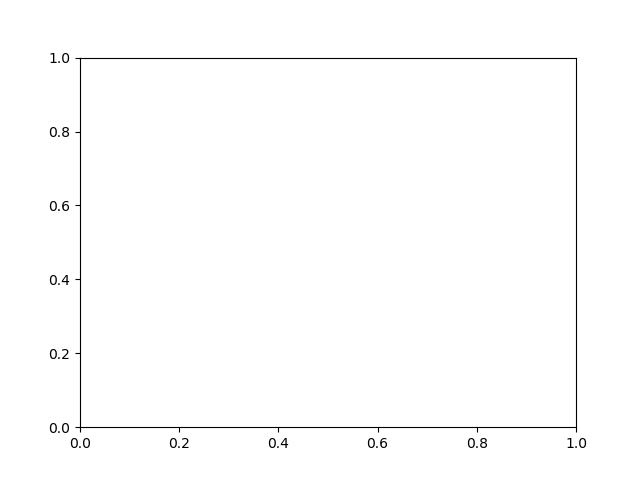

Steps:  12

Best genome:


In [14]:
if __name__ == '__main__':
    config_path = 'snake-config.txt'
    run(config_path, 500)